# DATA PREPARATION AND COMMON FUNCTION

# Load and Split the Data

The full train set will be splitted into 80% for Train Set and 20% for Validation Set.
To make the process easier, we will extract it and save it into each file.

In [ ]:
import os
from torchvision.datasets import CIFAR10
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np

# Directory where we will save the images
base_dir = 'T:/cifar10_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Create subdirectories for each class (0-9 for CIFAR-10)
classes = [str(i) for i in range(10)]
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

# Load CIFAR-10 dataset
cifar10_data = CIFAR10(root='./data', train=True, download=True)
images, targets = cifar10_data.data, np.array(cifar10_data.targets)

# Stratified split into 80% training and 20% validation
train_indices, val_indices = train_test_split(
    np.arange(len(targets)),
    test_size=0.2,
    stratify=targets,
    random_state=42
)

# Save images to train and val folders
print("Saving images...")
for idx in train_indices:
    img = Image.fromarray(images[idx])
    label = str(targets[idx])
    img.save(os.path.join(train_dir, label, f'{idx}.png'))

for idx in val_indices:
    img = Image.fromarray(images[idx])
    label = str(targets[idx])
    img.save(os.path.join(val_dir, label, f'{idx}.png'))

print("Images saved successfully in train and val folders.")


Files already downloaded and verified
Saving images...
Images saved successfully in train and val folders.


In [ ]:
import os
import struct
import numpy as np
from PIL import Image

def save_images_to_cifar_format(images, labels, file_path):
    """Saves images and labels in CIFAR-10 binary format."""
    with open(file_path, 'wb') as f:
        for img, label in zip(images, labels):
            # Write the label (1 byte)
            f.write(struct.pack('B', label))
            # Write image data in RGB channel order (R, G, B) as 32x32 pixels
            img = img.transpose(2, 0, 1).ravel()  # Convert to (3, H, W) and flatten
            f.write(img.tobytes())

def load_images_from_folder(folder):
    """Loads images and labels from a folder structure with class subdirectories."""
    images = []
    labels = []
    class_names = sorted(os.listdir(folder))  # Assuming each class is in a subfolder

    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(folder, class_name)
        for file_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, file_name)
            img = Image.open(img_path)  # No need to resize or convert if from CIFAR-10
            img_array = np.array(img, dtype=np.uint8)
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Paths to train and validation directories
train_dir = 'T:/cifar10_split/train'
val_dir = 'T:/cifar10_split/val'

# Load images and labels from each directory
train_images, train_labels = load_images_from_folder(train_dir)
val_images, val_labels = load_images_from_folder(val_dir)

# Save the entire training set in one file
train_file = "./train_batch.bin"
save_images_to_cifar_format(train_images, train_labels, train_file)
print(f"Saved {train_file} with {len(train_images)} images.")

# Save the entire validation set in one file
val_file = "./validation_batch.bin"
save_images_to_cifar_format(val_images, val_labels, val_file)
print(f"Saved {val_file} with {len(val_images)} images.")


# Load, Transform, and Visualize

In [2]:
import os
import struct
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def set_seed(seed_value=42):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

class CIFAR10BinaryDataset(Dataset):
    def __init__(self, data_files, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform

        # Load data from binary files
        for file_path in data_files:
            with open(file_path, 'rb') as f:
                while True:
                    label_bytes = f.read(1)
                    if not label_bytes:
                        break
                    label = struct.unpack('B', label_bytes)[0]
                    self.labels.append(label)
                    
                    img_bytes = f.read(3 * 32 * 32)
                    img = np.frombuffer(img_bytes, dtype=np.uint8).reshape(3, 32, 32)  # Keep in [0, 255]
                    self.data.append(img)

        self.data = np.array(self.data)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]

        # Convert numpy array to PIL Image for compatibility with transforms
        img = Image.fromarray(img.transpose(1, 2, 0))  # Convert (C, H, W) to (H, W, C)

        # Apply transformations (including ToTensor) if provided
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)  # Ensure label is a LongTensor


# Paths to the binary files
train_files = ["./train_batch.bin"]
val_files = ["./validation_batch.bin"]

# Define transformations (with ToTensor in the Compose pipeline)
train_transform = transforms.Compose([
    transforms.ToTensor(),  
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the training and validation datasets
train_dataset = CIFAR10BinaryDataset(train_files, transform=train_transform)
val_dataset = CIFAR10BinaryDataset(val_files, transform=val_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=val_transform)

# Print the number of samples in the training and validation sets
print(f"Number of images in the training set: {len(train_dataset)}")
print(f"Number of images in the validation set: {len(val_dataset)}")
print(f"Number of images in the test set: {len(test_dataset)}")


# Define DataLoaders for the training and validation sets
def datasetsloader(batch_size=64):
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return trainloader, valloader

def testsetloader(batch_size=64):
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return testloader


Number of images in the training set: 40000
Number of images in the validation set: 10000
Number of images in the test set: 10000


Training Set Sample:


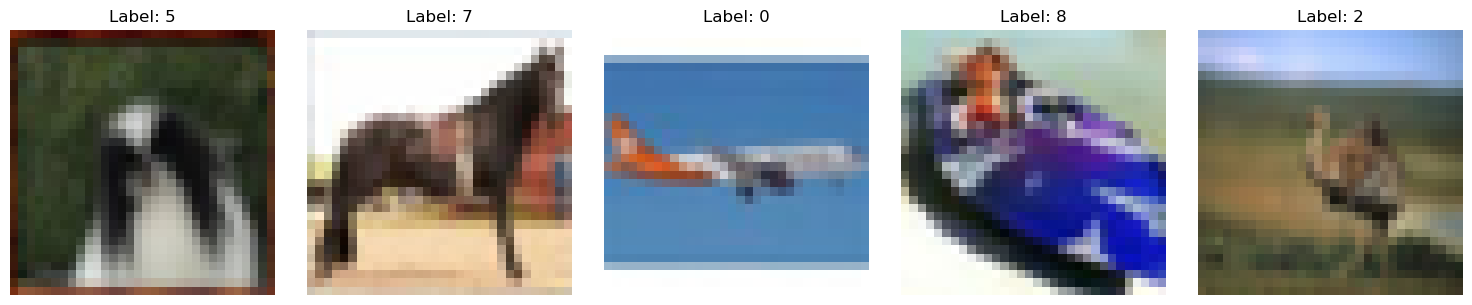

Validation Set Sample:


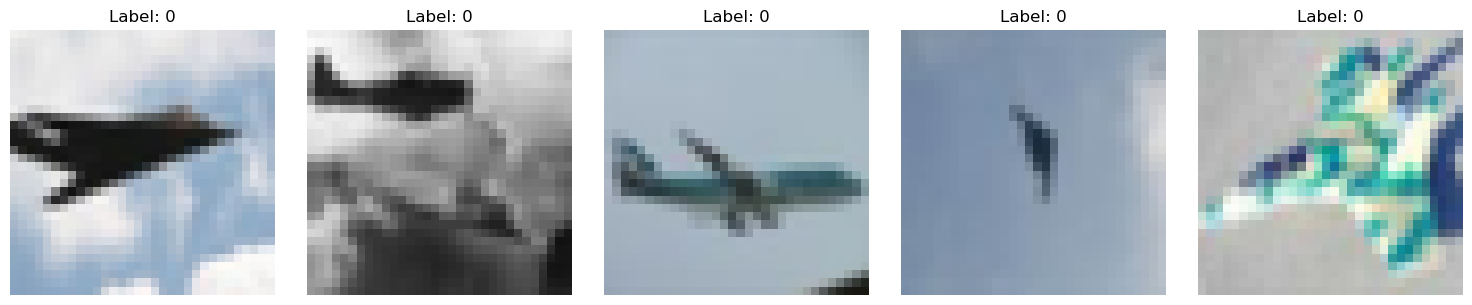

Test Set Sample:


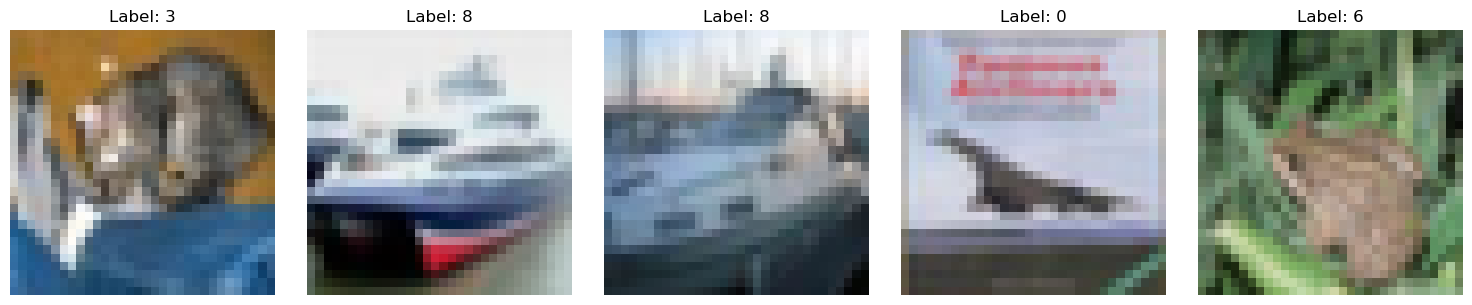

In [3]:
# show an image (for visualization purposes)
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor format (C, H, W) to (H, W, C)
    img = np.clip(img, 0, 1)  # Clip to range [0, 1] for display, if needed
    plt.imshow(img)
    plt.axis('off')

def visualize():
    trainloader, valloader = datasetsloader()
    
    # Visualize a sample batch from trainloader
    data_iter = iter(trainloader)
    images, labels = next(data_iter)
    print("Training Set Sample:")
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for idx in range(5):  # Display 5 images as an example
        ax = axes[idx]
        img = images[idx]
        img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor format (C, H, W) to (H, W, C)
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Label: {labels[idx].item()}")
    plt.tight_layout()
    plt.show()
    
    # Visualize a sample batch from valloader
    data_iter = iter(valloader)
    images, labels = next(data_iter)
    print("Validation Set Sample:")
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for idx in range(5):  # Display 5 images as an example
        ax = axes[idx]
        img = images[idx]
        img = img.numpy().transpose((1, 2, 0))
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Label: {labels[idx].item()}")
    plt.tight_layout()
    plt.show()

    # Visualize a sample batch from valloader
    data_iter = iter(testsetloader())
    images, labels = next(data_iter)
    print("Test Set Sample:")
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for idx in range(5):  # Display 5 images as an example
        ax = axes[idx]
        img = images[idx]
        img = img.numpy().transpose((1, 2, 0))
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Label: {labels[idx].item()}")
    plt.tight_layout()
    plt.show()

visualize()

# Common Function

In [37]:
from torchsummary import summary
import os
import time
import statistics
import csv
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import pandas as pd
import matplotlib.pyplot as plt
import glob   

# Set Logging
def set_log(model_name):
    csv_filename = f"{model_name}_training_log.csv"
    save_model_path = f"{model_name}_best_model.pth"
    checkpoint_path = f"{model_name}_checkpoint.pth"
    return csv_filename, save_model_path, checkpoint_path



# Full training function with per-class validation accuracy tracking
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, model_name="model_001", csv_filename=None, checkpoint_path=None, save_model_path="best_model.pth", resume=True, save_best_on="accuracy"):
    best_val_acc = 0.0
    best_val_loss = float('inf')
    start_epoch = 0
    num_classes = 10  # Set this to the number of classes in your dataset

    # Load from checkpoint if resume is True and a checkpoint filename is provided
    if resume and checkpoint_path and os.path.isfile(checkpoint_path):
        print("Loading checkpoint...")
        checkpoint = torch.load(checkpoint_path)
        try:
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint['epoch'] + 1
            best_val_acc = checkpoint.get('best_val_acc', best_val_acc)
            best_val_loss = checkpoint.get('best_val_loss', best_val_loss)
            print(f"Resuming training from epoch {start_epoch}")
        except RuntimeError as e:
            print(f"Error loading model/optimizer state: {e}")
            print("Starting training from scratch with the provided parameters.")
    
    # Open CSV file in append mode if resuming, or write mode if starting fresh
    mode = 'a' if csv_filename and start_epoch > 0 else 'w'
    with open(csv_filename or f"{model_name}_training_log.csv", mode, newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        if start_epoch == 0:
            csv_writer.writerow([
                'Epoch', 'Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy',
                'Min Val Acc', 'Max Val Acc', 'Median Val Acc',
                'Training Time (s)', 'Validation Time (s)', 'Model Filename'
            ])

        for epoch in range(start_epoch, num_epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            # Measure training time
            train_start_time = time.time()

            # Training phase with tqdm progress bar
            for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_acc = 100 * correct / total
            train_loss = running_loss / len(train_loader)

            # End training time
            train_end_time = time.time()
            training_time = train_end_time - train_start_time

            # Validation phase
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0

            # Initialize per-class correct and total counters
            class_correct = [0] * num_classes
            class_total = [0] * num_classes

            # Measure validation time
            val_start_time = time.time()

            with torch.no_grad():
                for val_images, val_labels in val_loader:
                    val_images, val_labels = val_images.to(device), val_labels.to(device)

                    val_outputs = model(val_images)
                    loss = criterion(val_outputs, val_labels)
                    val_loss += loss.item()

                    _, val_predicted = torch.max(val_outputs, 1)
                    val_total += val_labels.size(0)
                    val_correct += (val_predicted == val_labels).sum().item()

                    # Update per-class correct and total counts
                    for i in range(len(val_labels)):
                        label = val_labels[i].item()
                        pred = val_predicted[i].item()
                        class_total[label] += 1
                        if pred == label:
                            class_correct[label] += 1

            val_end_time = time.time()
            validation_time = val_end_time - val_start_time

            # Calculate overall validation accuracy
            val_acc = 100 * val_correct / val_total
            val_loss = val_loss / len(val_loader)

            # Calculate per-class validation accuracy
            class_accuracies = [
                100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
                for i in range(num_classes)
            ]

            # Calculate min, max, and median per-class accuracy
            min_val_acc = min(class_accuracies)
            max_val_acc = max(class_accuracies)
            median_val_acc = statistics.median(class_accuracies)

            # Log epoch details to CSV, including the model filename
            csv_writer.writerow([
                epoch + 1, train_loss, train_acc, val_loss, val_acc,
                min_val_acc, max_val_acc, median_val_acc,
                training_time, validation_time, save_model_path
            ])

            # Print progress
            print(f"Epoch [{epoch+1}/{num_epochs}] "
                  f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, "
                  f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%, "
                  f"Min Val Acc: {min_val_acc:.2f}%, Max Val Acc: {max_val_acc:.2f}%, "
                  f"Median Val Acc: {median_val_acc:.2f}%, "
                  f"Training Time: {training_time:.2f}s, Validation Time: {validation_time:.2f}s")

            # Save the model based on the criterion specified
            if save_best_on == "accuracy" and val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), save_model_path)
                print(f"Model saved with validation accuracy: {val_acc:.2f}%")
            elif save_best_on == "loss" and val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), save_model_path)
                print(f"Model saved with validation loss: {val_loss:.4f}")

            # Save a checkpoint at the end of each epoch
            if checkpoint_path:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_val_acc': best_val_acc,
                    'best_val_loss': best_val_loss,
                }, checkpoint_path)
                print(f"Checkpoint saved at epoch {epoch+1}")


def analyze_training_log(file_path,  type):
    """
    Analyzes the training log for a model based on loss and accuracy.

    Parameters:
        file_path (str): Path to the training log CSV file.

    Returns:
        None
    """
    if type == 'resnet':
        folder = 'logs'
    elif type == 'efficientnet':
        folder = 'logs_efficientnet'
    else:
        folder = 'logs_mobilenet'
    
    # Load the training log
    data = pd.read_csv(f'./{folder}/{file_path}')

     # Display the first few rows to understand the structure
    print("Training log data:")
    print(data.head())

    # Plot Training and Validation Loss over Epochs
    plt.figure(figsize=(8, 5))
    plt.plot(data['Epoch'], data['Train Loss'], label='Train Loss', marker='o')
    plt.plot(data['Epoch'], data['Validation Loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Training and Validation Accuracy over Epochs
    plt.figure(figsize=(8, 5))
    plt.plot(data['Epoch'], data['Train Accuracy'], label='Train Accuracy', marker='o')
    plt.plot(data['Epoch'], data['Validation Accuracy'], label='Validation Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    # Identify the epoch with the highest Validation Accuracy
    best_epoch = data['Validation Accuracy'].idxmax()
    best_epoch_data = data.loc[best_epoch]

    # Summary Statistics for Validation Accuracy of the Best Model
    final_val_acc = best_epoch_data['Validation Accuracy']

    print("\nValidation Accuracy Summary for Best Model:")
    print(f"Best Epoch: {best_epoch + 1}")
    print(f"Best Validation Accuracy: {final_val_acc:.2f}%")

def compare_multi(file_paths, type='resnet'):
    # Initialize dictionaries to store data
    train_losses = {}
    val_losses = {}
    train_accuracies = {}
    val_accuracies = {}
    training_times = {}
    
    if type == 'resnet':
        folder = 'logs'
    elif type == 'efficientnet':
        folder = 'logs_efficientnet'
    else:
        folder = 'logs_mobilenet'
    
    # Read each file and extract the metrics, adjusting for different row counts
    max_epochs = 0
    for file_path in file_paths:
        model_id = file_path
        df = pd.read_csv(f'./{folder}/{file_path}')
        
        # Update max_epochs to match the longest sequence found
        max_epochs = max(max_epochs, len(df))
        
        # Store data by model ID
        train_losses[model_id] = df['Train Loss']
        val_losses[model_id] = df['Validation Loss']
        train_accuracies[model_id] = df['Train Accuracy']
        val_accuracies[model_id] = df['Validation Accuracy']
        training_times[model_id] = df['Training Time (s)'].cumsum()
    
    # Pad sequences to the maximum length with NaN values
    for model_id in train_losses:
        train_losses[model_id] = train_losses[model_id].reindex(range(max_epochs)).to_numpy()
        val_losses[model_id] = val_losses[model_id].reindex(range(max_epochs)).to_numpy()
        train_accuracies[model_id] = train_accuracies[model_id].reindex(range(max_epochs)).to_numpy()
        val_accuracies[model_id] = val_accuracies[model_id].reindex(range(max_epochs)).to_numpy()
        training_times[model_id] = training_times[model_id].reindex(range(max_epochs)).to_numpy()

    # Plotting Train Loss and Validation Loss
    plt.figure(figsize=(11, 6))
    for model_id, train_loss in train_losses.items():
        plt.plot(train_loss, label=f'{model_id} Train Loss')
    for model_id, val_loss in val_losses.items():
        plt.plot(val_loss, linestyle='--', label=f'{model_id} Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train Loss and Validation Loss Comparison')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.show()
    
    # Plotting Train Accuracy and Validation Accuracy
    plt.figure(figsize=(11, 6))
    for model_id, train_acc in train_accuracies.items():
        plt.plot(train_acc, label=f'{model_id} Train Accuracy')
    for model_id, val_acc in val_accuracies.items():
        plt.plot(val_acc, linestyle='--', label=f'{model_id} Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train Accuracy and Validation Accuracy Comparison')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.show()
    
    # Plotting Accumulated Training Time
    plt.figure(figsize=(11 ,6))
    for model_id, time in training_times.items():
        plt.plot(time, label=f'{model_id} Training Time (s)')
    plt.xlabel('Epoch')
    plt.ylabel('Cumulative Training Time (s)')
    plt.title('Accumulated Training Time Comparison')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.show()
    
    # Additional summaries
    for file_path in file_paths:
        model_id = file_path
        df = pd.read_csv(f'./{folder}/{file_path}')
        
        # Check for non-NaN values in Validation Accuracy before proceeding
        if df['Validation Accuracy'].notna().any():
            # Highest Validation Accuracy
            max_val_acc = df['Validation Accuracy'].max()
            max_val_acc_epoch = df['Validation Accuracy'].idxmax()
            total_time_to_max_val_acc = df['Training Time (s)'].iloc[:max_val_acc_epoch+1].sum()

            print(f"Model {model_id}:")
            print(f"  Highest Validation Accuracy: {max_val_acc:.2f}")
            print(f"  Epoch at Highest Validation Accuracy: {max_val_acc_epoch + 1}")
            print(f"  Total Time to Reach Highest Validation Accuracy: {total_time_to_max_val_acc:.2f} seconds\n")
        else:
            print(f"Model {model_id}: Validation Accuracy data is missing or NaN in all rows.\n")
    
    for file_path in file_paths:
        model_id = file_path
        df = pd.read_csv(f'./{folder}/{file_path}')
    
        # Check for non-NaN values in Validation Loss before proceeding
        if df['Validation Loss'].notna().any():
            # Lowest Validation Loss
            min_val_loss = df['Validation Loss'].min()
            min_val_loss_epoch = df['Validation Loss'].idxmin()
            total_time_to_min_loss = df['Training Time (s)'].iloc[:min_val_loss_epoch+1].sum()
        
            print(f"Model {model_id}:")
            print(f"  Lowest Validation Loss: {min_val_loss:.3f}")
            print(f"  Epoch at Lowest Validation Loss: {min_val_loss_epoch + 1}")
            print(f"  Total Time to Reach Lowest Validation Loss: {total_time_to_min_loss:.2f} seconds\n")
        else:
            print(f"Model {model_id}: Validation Loss data is missing or NaN in all rows.\n")



# Set Logging
def set_log(model_name):
    csv_filename = f"{model_name}_training_log.csv"
    save_model_path = f"{model_name}_best_model.pth"
    checkpoint_path = f"{model_name}_checkpoint.pth"
    return csv_filename, save_model_path, checkpoint_path

# Full training function with per-class validation accuracy tracking
def train_model_reducelr(model, train_loader, val_loader, criterion, optimizer, 
                         num_epochs=10, model_name="model_001", csv_filename=None, 
                         checkpoint_path=None, save_model_path="best_model.pth", 
                         resume=True, save_best_on="accuracy",
                         step=0.5, patience=5):
    best_val_acc = 0.0
    best_val_loss = float('inf')
    start_epoch = 0
    num_classes = 10  # Set this to the number of classes in your dataset

    # Initialize scheduler with patience and reduction factor
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=step, patience=patience, verbose=True)

    # Load from checkpoint if resume is True and a checkpoint filename is provided
    if resume and checkpoint_path and os.path.isfile(checkpoint_path):
        print("Loading checkpoint...")
        checkpoint = torch.load(checkpoint_path)
        try:
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint['epoch'] + 1
            best_val_acc = checkpoint.get('best_val_acc', best_val_acc)
            best_val_loss = checkpoint.get('best_val_loss', best_val_loss)
            print(f"Resuming training from epoch {start_epoch}")
        except RuntimeError as e:
            print(f"Error loading model/optimizer state: {e}")
            print("Starting training from scratch with the provided parameters.")

    # Open CSV file in append mode if resuming, or write mode if starting fresh
    mode = 'a' if csv_filename and start_epoch > 0 else 'w'
    with open(csv_filename or f"{model_name}_training_log.csv", mode, newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        if start_epoch == 0:
            csv_writer.writerow([
                'Epoch', 'Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy',
                'Min Val Acc', 'Max Val Acc', 'Median Val Acc',
                'Training Time (s)', 'Validation Time (s)', 'Learning Rate', 'Model Filename'
            ])

        for epoch in range(start_epoch, num_epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            # Measure training time
            train_start_time = time.time()

            # Training phase with tqdm progress bar
            for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_acc = 100 * correct / total
            train_loss = running_loss / len(train_loader)

            # End training time
            train_end_time = time.time()
            training_time = train_end_time - train_start_time

            # Validation phase
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0

            # Initialize per-class correct and total counters
            class_correct = [0] * num_classes
            class_total = [0] * num_classes

            # Measure validation time
            val_start_time = time.time()

            with torch.no_grad():
                for val_images, val_labels in val_loader:
                    val_images, val_labels = val_images.to(device), val_labels.to(device)

                    val_outputs = model(val_images)
                    loss = criterion(val_outputs, val_labels)
                    val_loss += loss.item()

                    _, val_predicted = torch.max(val_outputs, 1)
                    val_total += val_labels.size(0)
                    val_correct += (val_predicted == val_labels).sum().item()

                    # Update per-class correct and total counts
                    for i in range(len(val_labels)):
                        label = val_labels[i].item()
                        pred = val_predicted[i].item()
                        class_total[label] += 1
                        if pred == label:
                            class_correct[label] += 1

            val_end_time = time.time()
            validation_time = val_end_time - val_start_time

            # Calculate overall validation accuracy
            val_acc = 100 * val_correct / val_total
            val_loss = val_loss / len(val_loader)

            # Calculate per-class validation accuracy
            class_accuracies = [
                100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
                for i in range(num_classes)
            ]

            # Calculate min, max, and median per-class accuracy
            min_val_acc = min(class_accuracies)
            max_val_acc = max(class_accuracies)
            median_val_acc = statistics.median(class_accuracies)

            # Get the current learning rate from the optimizer
            current_lr = optimizer.param_groups[0]['lr']

            # Log epoch details to CSV, including the model filename and learning rate
            csv_writer.writerow([
                epoch + 1, train_loss, train_acc, val_loss, val_acc,
                min_val_acc, max_val_acc, median_val_acc,
                training_time, validation_time, current_lr, save_model_path
            ])

            # Print progress
            print(f"Epoch [{epoch+1}/{num_epochs}] "
                  f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, "
                  f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%, "
                  f"Min Val Acc: {min_val_acc:.2f}%, Max Val Acc: {max_val_acc:.2f}%, "
                  f"Median Val Acc: {median_val_acc:.2f}%, "
                  f"Training Time: {training_time:.2f}s, Validation Time: {validation_time:.2f}s, "
                  f"Learning Rate: {current_lr:.6f}")

            # Save the model based on the criterion specified
            if save_best_on == "accuracy" and val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), save_model_path)
                print(f"Model saved with validation accuracy: {val_acc:.2f}%")
            elif save_best_on == "loss" and val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), save_model_path)
                print(f"Model saved with validation loss: {val_loss:.4f}")

            scheduler.step(val_loss)

            # Save a checkpoint at the end of each epoch
            if checkpoint_path:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_val_acc': best_val_acc,
                    'best_val_loss': best_val_loss,
                }, checkpoint_path)
                print(f"Checkpoint saved at epoch {epoch+1}")

def evaluate_model_on_test(model, test_loader, criterion, num_classes=10, model_path="best_model.pth", device='cpu'):
    """
    Evaluates a trained model on a test dataset (CIFAR-10).

    Parameters:
        model (torch.nn.Module): The model to evaluate.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        criterion (torch.nn.Module): Loss function.
        num_classes (int): Number of classes in the dataset.
        model_path (str): Path to the .pth file with trained model weights.
        device (str): Device to run evaluation on ('cpu' or 'cuda').

    Returns:
        dict: A dictionary with evaluation metrics including loss, accuracy, and per-class accuracy.
    """
    # CIFAR-10 class names
    class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    
    # Load the trained model weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()  # Set model to evaluation mode
    
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    # Measure evaluation time
    start_time = time.time()

    with torch.no_grad():
        for test_images, test_labels in test_loader:
            test_images, test_labels = test_images.to(device), test_labels.to(device)

            # Forward pass
            test_outputs = model(test_images)
            loss = criterion(test_outputs, test_labels)
            test_loss += loss.item()

            # Calculate accuracy
            _, test_predicted = torch.max(test_outputs, 1)
            test_total += test_labels.size(0)
            test_correct += (test_predicted == test_labels).sum().item()

            # Per-class accuracy calculations
            for i in range(len(test_labels)):
                label = test_labels[i].item()
                pred = test_predicted[i].item()
                class_total[label] += 1
                if pred == label:
                    class_correct[label] += 1

    end_time = time.time()
    evaluation_time = end_time - start_time

    # Calculate metrics
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * test_correct / test_total if test_total > 0 else 0
    class_accuracies = [
        (100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0)
        for i in range(num_classes)
    ]
    min_test_acc = min(class_accuracies)
    max_test_acc = max(class_accuracies)
    median_test_acc = statistics.median(class_accuracies)

    # Print evaluation results
    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Overall Test Accuracy: {test_accuracy:.2f}%")
    print("Per-Class Accuracy:")
    for i, acc in enumerate(class_accuracies):
        print(f"  {class_names[i]}: {acc:.2f}%")
    print(f"Min Class Accuracy: {min_test_acc:.2f}%")
    print(f"Max Class Accuracy: {max_test_acc:.2f}%")
    print(f"Median Class Accuracy: {median_test_acc:.2f}%")
    print(f"Evaluation Time: {evaluation_time:.2f} seconds")

    # Return metrics
    return {
        "Test Loss": avg_test_loss,
        "Overall Test Accuracy": test_accuracy,
        "Per-Class Accuracy": dict(zip(class_names, class_accuracies)),
        "Min Class Accuracy": min_test_acc,
        "Max Class Accuracy": max_test_acc,
        "Median Class Accuracy": median_test_acc,
        "Evaluation Time": evaluation_time
    }

def get_model_sum(model, input_size=(3, 32, 32)):
    summary(model, input_size)
    print('\nDetailed Configuration:')
    print(model)

# ResNet18

### Baseline
We will keep the baseline as simple as possible without much modification.\n
We will not use data augmentation for the baseline

In [8]:
def baseline_resnet(num_classes=10):
    model = models.resnet18(weights=None)

    # Modify the fully connected layer for the number of classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = baseline_resnet().to(device)
get_model_sum(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [15]:
def baseline_resnet(num_classes=10):
    model = models.resnet18(weights=None)

    # Modify the fully connected layer for the number of classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = baseline_resnet().to(device)

# Initialize criterion
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 1024
trainloader, valloader = datasetsloader(batch_size)

model_name='resnet_baseline'

train_model(
    model=model,
    train_loader=trainloader,
    val_loader=valloader,
    criterion=criterion,
    optimizer=optimizer, 
    num_epochs=20,
    model_name=model_name,
    csv_filename=f"./logs/{model_name}.csv",
    checkpoint_path=f"./models/{model_name}_check.pth",
    save_model_path=f"./models/{model_name}_best.pth",
    resume=False,
    save_best_on="accuracy")


Epoch 1/20: 100%|██████████| 40/40 [00:16<00:00,  2.48batch/s]


Epoch [1/20] Train Loss: 1.5735, Train Accuracy: 43.67%, Validation Loss: 3.0036, Validation Accuracy: 21.42%, Min Val Acc: 0.20%, Max Val Acc: 81.50%, Median Val Acc: 3.50%, Training Time: 16.12s, Validation Time: 4.58s
Model saved with validation accuracy: 21.42%
Checkpoint saved at epoch 1


Epoch 2/20: 100%|██████████| 40/40 [00:15<00:00,  2.54batch/s]


Epoch [2/20] Train Loss: 1.1569, Train Accuracy: 58.47%, Validation Loss: 1.3500, Validation Accuracy: 52.87%, Min Val Acc: 24.10%, Max Val Acc: 86.00%, Median Val Acc: 48.80%, Training Time: 15.72s, Validation Time: 5.03s
Model saved with validation accuracy: 52.87%
Checkpoint saved at epoch 2


Epoch 3/20: 100%|██████████| 40/40 [00:15<00:00,  2.61batch/s]


Epoch [3/20] Train Loss: 0.9448, Train Accuracy: 65.82%, Validation Loss: 1.7670, Validation Accuracy: 43.97%, Min Val Acc: 27.10%, Max Val Acc: 83.10%, Median Val Acc: 39.25%, Training Time: 15.34s, Validation Time: 3.70s
Checkpoint saved at epoch 3


Epoch 4/20: 100%|██████████| 40/40 [00:15<00:00,  2.62batch/s]


Epoch [4/20] Train Loss: 0.8027, Train Accuracy: 71.38%, Validation Loss: 1.8931, Validation Accuracy: 42.52%, Min Val Acc: 18.90%, Max Val Acc: 89.00%, Median Val Acc: 36.05%, Training Time: 15.29s, Validation Time: 4.46s
Checkpoint saved at epoch 4


Epoch 5/20: 100%|██████████| 40/40 [00:15<00:00,  2.62batch/s]


Epoch [5/20] Train Loss: 0.7214, Train Accuracy: 74.01%, Validation Loss: 1.4512, Validation Accuracy: 54.55%, Min Val Acc: 30.20%, Max Val Acc: 92.00%, Median Val Acc: 48.15%, Training Time: 15.24s, Validation Time: 5.63s
Model saved with validation accuracy: 54.55%
Checkpoint saved at epoch 5


Epoch 6/20: 100%|██████████| 40/40 [00:15<00:00,  2.60batch/s]


Epoch [6/20] Train Loss: 0.5681, Train Accuracy: 79.92%, Validation Loss: 1.3029, Validation Accuracy: 60.13%, Min Val Acc: 33.90%, Max Val Acc: 81.50%, Median Val Acc: 65.65%, Training Time: 15.40s, Validation Time: 3.94s
Model saved with validation accuracy: 60.13%
Checkpoint saved at epoch 6


Epoch 7/20: 100%|██████████| 40/40 [00:15<00:00,  2.58batch/s]


Epoch [7/20] Train Loss: 0.4919, Train Accuracy: 82.64%, Validation Loss: 1.4290, Validation Accuracy: 58.69%, Min Val Acc: 34.90%, Max Val Acc: 86.10%, Median Val Acc: 57.95%, Training Time: 15.51s, Validation Time: 4.00s
Checkpoint saved at epoch 7


Epoch 8/20: 100%|██████████| 40/40 [00:15<00:00,  2.56batch/s]


Epoch [8/20] Train Loss: 0.4411, Train Accuracy: 84.33%, Validation Loss: 1.2046, Validation Accuracy: 64.08%, Min Val Acc: 48.60%, Max Val Acc: 85.10%, Median Val Acc: 64.10%, Training Time: 15.63s, Validation Time: 5.00s
Model saved with validation accuracy: 64.08%
Checkpoint saved at epoch 8


Epoch 9/20: 100%|██████████| 40/40 [00:15<00:00,  2.63batch/s]


Epoch [9/20] Train Loss: 0.3251, Train Accuracy: 88.31%, Validation Loss: 1.3419, Validation Accuracy: 64.64%, Min Val Acc: 35.70%, Max Val Acc: 85.20%, Median Val Acc: 68.15%, Training Time: 15.21s, Validation Time: 3.87s
Model saved with validation accuracy: 64.64%
Checkpoint saved at epoch 9


Epoch 10/20: 100%|██████████| 40/40 [00:15<00:00,  2.61batch/s]


Epoch [10/20] Train Loss: 0.2569, Train Accuracy: 90.62%, Validation Loss: 1.5988, Validation Accuracy: 59.98%, Min Val Acc: 45.20%, Max Val Acc: 81.60%, Median Val Acc: 60.60%, Training Time: 15.34s, Validation Time: 4.17s
Checkpoint saved at epoch 10


Epoch 11/20: 100%|██████████| 40/40 [00:15<00:00,  2.57batch/s]


Epoch [11/20] Train Loss: 0.2261, Train Accuracy: 92.00%, Validation Loss: 1.5761, Validation Accuracy: 62.61%, Min Val Acc: 37.00%, Max Val Acc: 80.40%, Median Val Acc: 66.65%, Training Time: 15.58s, Validation Time: 4.88s
Checkpoint saved at epoch 11


Epoch 12/20: 100%|██████████| 40/40 [00:15<00:00,  2.59batch/s]


Epoch [12/20] Train Loss: 0.2594, Train Accuracy: 90.83%, Validation Loss: 1.7837, Validation Accuracy: 59.31%, Min Val Acc: 31.50%, Max Val Acc: 81.40%, Median Val Acc: 60.65%, Training Time: 15.45s, Validation Time: 3.83s
Checkpoint saved at epoch 12


Epoch 13/20: 100%|██████████| 40/40 [00:15<00:00,  2.62batch/s]


Epoch [13/20] Train Loss: 0.1473, Train Accuracy: 94.79%, Validation Loss: 1.6735, Validation Accuracy: 62.88%, Min Val Acc: 34.70%, Max Val Acc: 86.60%, Median Val Acc: 65.10%, Training Time: 15.26s, Validation Time: 4.10s
Checkpoint saved at epoch 13


Epoch 14/20: 100%|██████████| 40/40 [00:15<00:00,  2.61batch/s]


Epoch [14/20] Train Loss: 0.1396, Train Accuracy: 95.20%, Validation Loss: 1.7001, Validation Accuracy: 62.93%, Min Val Acc: 39.10%, Max Val Acc: 83.70%, Median Val Acc: 70.30%, Training Time: 15.30s, Validation Time: 3.83s
Checkpoint saved at epoch 14


Epoch 15/20: 100%|██████████| 40/40 [00:15<00:00,  2.54batch/s]


Epoch [15/20] Train Loss: 0.1711, Train Accuracy: 94.19%, Validation Loss: 2.1592, Validation Accuracy: 58.26%, Min Val Acc: 21.00%, Max Val Acc: 85.80%, Median Val Acc: 65.25%, Training Time: 15.74s, Validation Time: 4.57s
Checkpoint saved at epoch 15


Epoch 16/20: 100%|██████████| 40/40 [00:15<00:00,  2.58batch/s]


Epoch [16/20] Train Loss: 0.2097, Train Accuracy: 92.76%, Validation Loss: 1.4262, Validation Accuracy: 68.13%, Min Val Acc: 33.80%, Max Val Acc: 85.70%, Median Val Acc: 69.80%, Training Time: 15.54s, Validation Time: 4.10s
Model saved with validation accuracy: 68.13%
Checkpoint saved at epoch 16


Epoch 17/20: 100%|██████████| 40/40 [00:15<00:00,  2.62batch/s]


Epoch [17/20] Train Loss: 0.0970, Train Accuracy: 96.75%, Validation Loss: 1.6802, Validation Accuracy: 65.28%, Min Val Acc: 35.10%, Max Val Acc: 88.10%, Median Val Acc: 62.80%, Training Time: 15.30s, Validation Time: 4.44s
Checkpoint saved at epoch 17


Epoch 18/20: 100%|██████████| 40/40 [00:15<00:00,  2.56batch/s]


Epoch [18/20] Train Loss: 0.1009, Train Accuracy: 96.49%, Validation Loss: 1.6057, Validation Accuracy: 67.03%, Min Val Acc: 37.90%, Max Val Acc: 87.90%, Median Val Acc: 75.15%, Training Time: 15.65s, Validation Time: 4.70s
Checkpoint saved at epoch 18


Epoch 19/20: 100%|██████████| 40/40 [00:15<00:00,  2.64batch/s]


Epoch [19/20] Train Loss: 0.0805, Train Accuracy: 97.33%, Validation Loss: 1.6374, Validation Accuracy: 67.20%, Min Val Acc: 53.60%, Max Val Acc: 87.20%, Median Val Acc: 67.70%, Training Time: 15.15s, Validation Time: 3.80s
Checkpoint saved at epoch 19


Epoch 20/20: 100%|██████████| 40/40 [00:15<00:00,  2.56batch/s]


Epoch [20/20] Train Loss: 0.0856, Train Accuracy: 97.17%, Validation Loss: 2.0725, Validation Accuracy: 63.01%, Min Val Acc: 32.00%, Max Val Acc: 90.30%, Median Val Acc: 64.20%, Training Time: 15.65s, Validation Time: 4.44s
Checkpoint saved at epoch 20


Training log data:
   Epoch  Train Loss  Train Accuracy  Validation Loss  Validation Accuracy  \
0      1    1.573516         43.6750         3.003634                21.42   
1      2    1.156921         58.4650         1.349960                52.87   
2      3    0.944801         65.8175         1.767014                43.97   
3      4    0.802680         71.3775         1.893109                42.52   
4      5    0.721435         74.0100         1.451172                54.55   

   Min Val Acc  Max Val Acc  Median Val Acc  Training Time (s)  \
0          0.2         81.5            3.50          16.122581   
1         24.1         86.0           48.80          15.719121   
2         27.1         83.1           39.25          15.339893   
3         18.9         89.0           36.05          15.293230   
4         30.2         92.0           48.15          15.242617   

   Validation Time (s)                     Model Filename  
0             4.577185  ./models/resnet_baseline_best.p

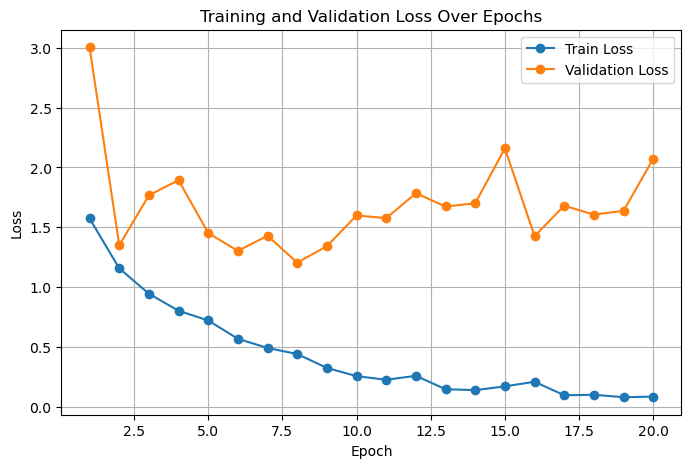

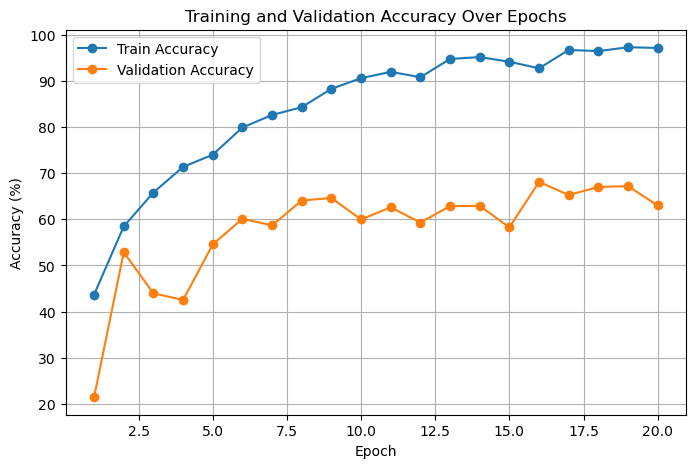


Validation Accuracy Summary for Best Model:
Best Epoch: 16
Final Validation Accuracy: 68.13%


In [27]:
analyze_training_log('resnet_baseline.csv','resnet')

### Modify the conv layer

In [10]:
def resnet_01(num_classes=10):
    model = models.resnet18(weights=None)
    
    model.conv1 = nn.Conv2d(
        in_channels=3,       # Input channels (RGB)
        out_channels=64,     # Number of filters
        kernel_size=3,       # default is 7
        stride=1,            # default is 2
        padding=1,           # default is 3
        bias=False
    )
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    return model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet_01().to(device)
get_model_sum(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

In [16]:
device = torch.device('cuda')
model = resnet_01().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 1024
trainloader, valloader = datasetsloader(batch_size)

model_name='resnet_01'

train_model(
    model=model,
    train_loader=trainloader,
    val_loader=valloader,
    criterion=criterion,
    optimizer=optimizer, 
    num_epochs=20,
    model_name=model_name,
    csv_filename=f"./logs/{model_name}.csv",
    checkpoint_path=f"./models/{model_name}_check.pth",
    save_model_path=f"./models/{model_name}_best.pth",
    resume=False,
    save_best_on="accuracy")


Epoch 1/20: 100%|██████████| 40/40 [00:18<00:00,  2.13batch/s]


Epoch [1/20] Train Loss: 1.4302, Train Accuracy: 47.73%, Validation Loss: 2.9675, Validation Accuracy: 21.20%, Min Val Acc: 0.60%, Max Val Acc: 81.80%, Median Val Acc: 6.25%, Training Time: 18.77s, Validation Time: 5.69s
Model saved with validation accuracy: 21.20%
Checkpoint saved at epoch 1


Epoch 2/20: 100%|██████████| 40/40 [00:19<00:00,  2.08batch/s]


Epoch [2/20] Train Loss: 0.9541, Train Accuracy: 65.77%, Validation Loss: 1.3607, Validation Accuracy: 55.64%, Min Val Acc: 5.50%, Max Val Acc: 94.10%, Median Val Acc: 63.20%, Training Time: 19.21s, Validation Time: 4.66s
Model saved with validation accuracy: 55.64%
Checkpoint saved at epoch 2


Epoch 3/20: 100%|██████████| 40/40 [00:19<00:00,  2.10batch/s]


Epoch [3/20] Train Loss: 0.7232, Train Accuracy: 74.04%, Validation Loss: 1.1712, Validation Accuracy: 61.69%, Min Val Acc: 28.60%, Max Val Acc: 88.20%, Median Val Acc: 63.55%, Training Time: 19.09s, Validation Time: 4.28s
Model saved with validation accuracy: 61.69%
Checkpoint saved at epoch 3


Epoch 4/20: 100%|██████████| 40/40 [00:18<00:00,  2.11batch/s]


Epoch [4/20] Train Loss: 0.5355, Train Accuracy: 81.22%, Validation Loss: 1.0758, Validation Accuracy: 65.45%, Min Val Acc: 33.60%, Max Val Acc: 92.30%, Median Val Acc: 69.60%, Training Time: 18.94s, Validation Time: 5.34s
Model saved with validation accuracy: 65.45%
Checkpoint saved at epoch 4


Epoch 5/20: 100%|██████████| 40/40 [00:18<00:00,  2.11batch/s]


Epoch [5/20] Train Loss: 0.4080, Train Accuracy: 85.79%, Validation Loss: 1.4124, Validation Accuracy: 62.37%, Min Val Acc: 21.40%, Max Val Acc: 94.10%, Median Val Acc: 61.85%, Training Time: 18.95s, Validation Time: 3.98s
Checkpoint saved at epoch 5


Epoch 6/20: 100%|██████████| 40/40 [00:18<00:00,  2.13batch/s]


Epoch [6/20] Train Loss: 0.3142, Train Accuracy: 89.08%, Validation Loss: 1.1666, Validation Accuracy: 67.75%, Min Val Acc: 41.10%, Max Val Acc: 83.90%, Median Val Acc: 73.15%, Training Time: 18.76s, Validation Time: 4.61s
Model saved with validation accuracy: 67.75%
Checkpoint saved at epoch 6


Epoch 7/20: 100%|██████████| 40/40 [00:18<00:00,  2.14batch/s]


Epoch [7/20] Train Loss: 0.2674, Train Accuracy: 90.49%, Validation Loss: 1.1446, Validation Accuracy: 69.85%, Min Val Acc: 33.00%, Max Val Acc: 90.60%, Median Val Acc: 70.45%, Training Time: 18.70s, Validation Time: 4.93s
Model saved with validation accuracy: 69.85%
Checkpoint saved at epoch 7


Epoch 8/20: 100%|██████████| 40/40 [00:19<00:00,  2.08batch/s]


Epoch [8/20] Train Loss: 0.1616, Train Accuracy: 94.35%, Validation Loss: 1.2936, Validation Accuracy: 69.70%, Min Val Acc: 41.90%, Max Val Acc: 89.60%, Median Val Acc: 69.70%, Training Time: 19.22s, Validation Time: 5.58s
Checkpoint saved at epoch 8


Epoch 9/20: 100%|██████████| 40/40 [00:19<00:00,  2.07batch/s]


Epoch [9/20] Train Loss: 0.1310, Train Accuracy: 95.41%, Validation Loss: 1.3419, Validation Accuracy: 69.58%, Min Val Acc: 45.60%, Max Val Acc: 92.70%, Median Val Acc: 67.60%, Training Time: 19.34s, Validation Time: 5.69s
Checkpoint saved at epoch 9


Epoch 10/20: 100%|██████████| 40/40 [00:19<00:00,  2.09batch/s]


Epoch [10/20] Train Loss: 0.0994, Train Accuracy: 96.66%, Validation Loss: 1.4279, Validation Accuracy: 68.86%, Min Val Acc: 46.90%, Max Val Acc: 82.60%, Median Val Acc: 71.65%, Training Time: 19.17s, Validation Time: 5.24s
Checkpoint saved at epoch 10


Epoch 11/20: 100%|██████████| 40/40 [00:19<00:00,  2.07batch/s]


Epoch [11/20] Train Loss: 0.1406, Train Accuracy: 95.18%, Validation Loss: 1.2284, Validation Accuracy: 71.38%, Min Val Acc: 55.10%, Max Val Acc: 89.10%, Median Val Acc: 70.95%, Training Time: 19.29s, Validation Time: 4.11s
Model saved with validation accuracy: 71.38%
Checkpoint saved at epoch 11


Epoch 12/20: 100%|██████████| 40/40 [00:18<00:00,  2.11batch/s]


Epoch [12/20] Train Loss: 0.0731, Train Accuracy: 97.60%, Validation Loss: 1.3475, Validation Accuracy: 70.77%, Min Val Acc: 43.90%, Max Val Acc: 87.90%, Median Val Acc: 77.90%, Training Time: 18.93s, Validation Time: 5.64s
Checkpoint saved at epoch 12


Epoch 13/20: 100%|██████████| 40/40 [00:18<00:00,  2.13batch/s]


Epoch [13/20] Train Loss: 0.1386, Train Accuracy: 95.31%, Validation Loss: 1.3179, Validation Accuracy: 69.70%, Min Val Acc: 41.10%, Max Val Acc: 86.60%, Median Val Acc: 71.55%, Training Time: 18.79s, Validation Time: 5.14s
Checkpoint saved at epoch 13


Epoch 14/20: 100%|██████████| 40/40 [00:18<00:00,  2.12batch/s]


Epoch [14/20] Train Loss: 0.0875, Train Accuracy: 96.96%, Validation Loss: 1.0879, Validation Accuracy: 73.95%, Min Val Acc: 57.90%, Max Val Acc: 87.10%, Median Val Acc: 78.05%, Training Time: 18.90s, Validation Time: 4.43s
Model saved with validation accuracy: 73.95%
Checkpoint saved at epoch 14


Epoch 15/20: 100%|██████████| 40/40 [00:19<00:00,  2.10batch/s]


Epoch [15/20] Train Loss: 0.0322, Train Accuracy: 99.02%, Validation Loss: 1.2654, Validation Accuracy: 74.20%, Min Val Acc: 51.90%, Max Val Acc: 88.30%, Median Val Acc: 73.00%, Training Time: 19.07s, Validation Time: 4.99s
Model saved with validation accuracy: 74.20%
Checkpoint saved at epoch 15


Epoch 16/20: 100%|██████████| 40/40 [00:18<00:00,  2.11batch/s]


Epoch [16/20] Train Loss: 0.0384, Train Accuracy: 98.74%, Validation Loss: 1.4133, Validation Accuracy: 72.86%, Min Val Acc: 44.90%, Max Val Acc: 89.20%, Median Val Acc: 74.00%, Training Time: 18.99s, Validation Time: 5.01s
Checkpoint saved at epoch 16


Epoch 17/20: 100%|██████████| 40/40 [00:19<00:00,  2.09batch/s]


Epoch [17/20] Train Loss: 0.0466, Train Accuracy: 98.38%, Validation Loss: 1.3836, Validation Accuracy: 72.13%, Min Val Acc: 56.00%, Max Val Acc: 89.60%, Median Val Acc: 70.25%, Training Time: 19.17s, Validation Time: 5.47s
Checkpoint saved at epoch 17


Epoch 18/20: 100%|██████████| 40/40 [00:19<00:00,  2.07batch/s]


Epoch [18/20] Train Loss: 0.0304, Train Accuracy: 99.08%, Validation Loss: 1.5298, Validation Accuracy: 71.35%, Min Val Acc: 42.60%, Max Val Acc: 89.30%, Median Val Acc: 76.20%, Training Time: 19.37s, Validation Time: 5.92s
Checkpoint saved at epoch 18


Epoch 19/20: 100%|██████████| 40/40 [00:19<00:00,  2.05batch/s]


Epoch [19/20] Train Loss: 0.0860, Train Accuracy: 97.19%, Validation Loss: 1.3308, Validation Accuracy: 71.49%, Min Val Acc: 57.90%, Max Val Acc: 84.70%, Median Val Acc: 73.25%, Training Time: 19.48s, Validation Time: 4.86s
Checkpoint saved at epoch 19


Epoch 20/20: 100%|██████████| 40/40 [00:19<00:00,  2.06batch/s]


Epoch [20/20] Train Loss: 0.0472, Train Accuracy: 98.52%, Validation Loss: 1.3190, Validation Accuracy: 73.63%, Min Val Acc: 58.80%, Max Val Acc: 89.50%, Median Val Acc: 74.20%, Training Time: 19.45s, Validation Time: 6.41s
Checkpoint saved at epoch 20


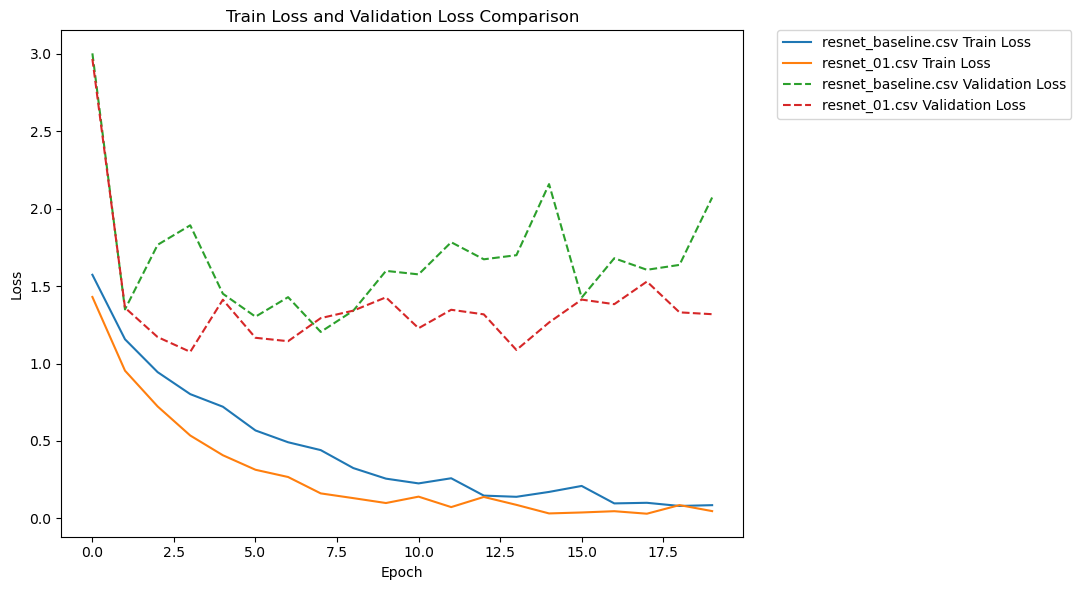

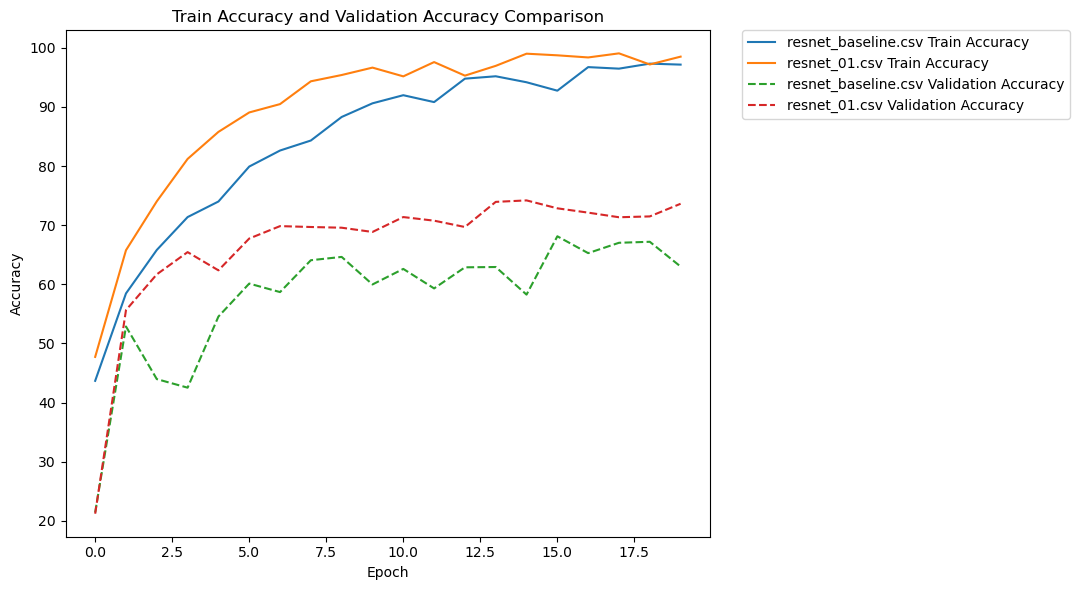

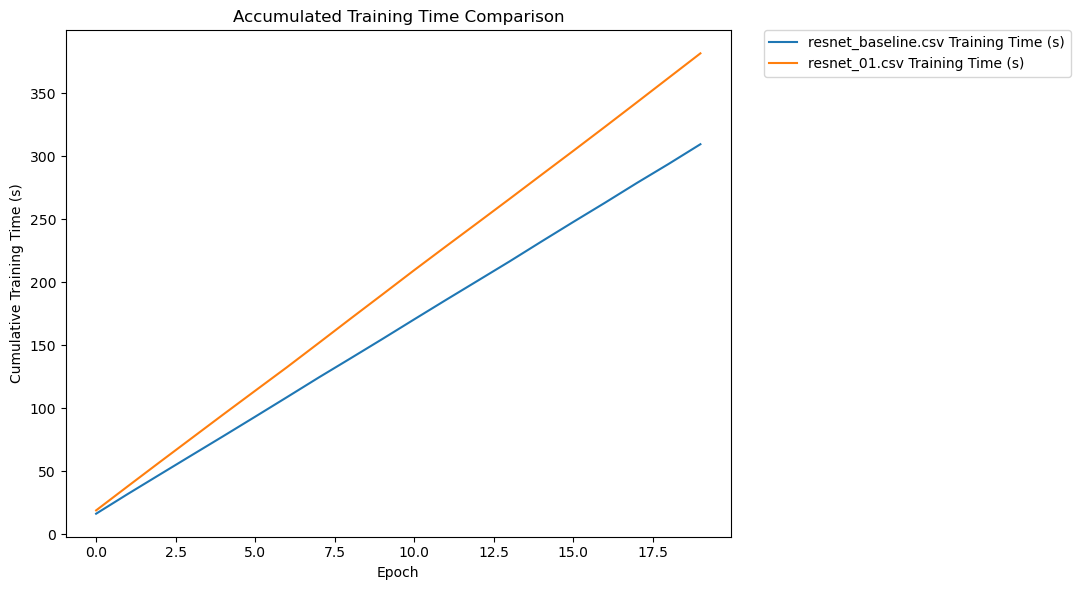

Model resnet_baseline.csv:
  Highest Validation Accuracy: 68.13
  Epoch at Highest Validation Accuracy: 16
  Total Time to Reach Highest Validation Accuracy: 247.68 seconds

Model resnet_01.csv:
  Highest Validation Accuracy: 74.20
  Epoch at Highest Validation Accuracy: 15
  Total Time to Reach Highest Validation Accuracy: 285.12 seconds

Model resnet_baseline.csv:
  Lowest Validation Loss: 1.205
  Epoch at Lowest Validation Loss: 8
  Total Time to Reach Lowest Validation Loss: 124.25 seconds

Model resnet_01.csv:
  Lowest Validation Loss: 1.076
  Epoch at Lowest Validation Loss: 4
  Total Time to Reach Lowest Validation Loss: 76.01 seconds



In [38]:
path = ['resnet_baseline.csv','resnet_01.csv']
compare_multi(path, 'resnet')

### Optimise Batch Size

In [17]:
device = torch.device('cuda')
model = resnet_01().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 512
trainloader, valloader = datasetsloader(batch_size)

model_name='resnet_01-batch512'

train_model(
    model=model,
    train_loader=trainloader,
    val_loader=valloader,
    criterion=criterion,
    optimizer=optimizer, 
    num_epochs=20,
    model_name=model_name,
    csv_filename=f"./logs/{model_name}.csv",
    checkpoint_path=f"./models/{model_name}_check.pth",
    save_model_path=f"./models/{model_name}_best.pth",
    resume=False,
    save_best_on="accuracy")


Epoch 1/20: 100%|██████████| 79/79 [00:20<00:00,  3.94batch/s]


Epoch [1/20] Train Loss: 1.3356, Train Accuracy: 51.66%, Validation Loss: 1.1177, Validation Accuracy: 60.58%, Min Val Acc: 36.70%, Max Val Acc: 77.30%, Median Val Acc: 60.10%, Training Time: 20.07s, Validation Time: 6.08s
Model saved with validation accuracy: 60.58%
Checkpoint saved at epoch 1


Epoch 2/20: 100%|██████████| 79/79 [00:20<00:00,  3.91batch/s]


Epoch [2/20] Train Loss: 0.8720, Train Accuracy: 69.35%, Validation Loss: 1.1572, Validation Accuracy: 61.11%, Min Val Acc: 20.00%, Max Val Acc: 94.50%, Median Val Acc: 68.05%, Training Time: 20.20s, Validation Time: 6.73s
Model saved with validation accuracy: 61.11%
Checkpoint saved at epoch 2


Epoch 3/20: 100%|██████████| 79/79 [00:19<00:00,  3.96batch/s]


Epoch [3/20] Train Loss: 0.6371, Train Accuracy: 77.76%, Validation Loss: 0.8479, Validation Accuracy: 70.67%, Min Val Acc: 40.70%, Max Val Acc: 85.80%, Median Val Acc: 73.40%, Training Time: 19.99s, Validation Time: 6.58s
Model saved with validation accuracy: 70.67%
Checkpoint saved at epoch 3


Epoch 4/20: 100%|██████████| 79/79 [00:19<00:00,  4.02batch/s]


Epoch [4/20] Train Loss: 0.4751, Train Accuracy: 83.32%, Validation Loss: 1.0786, Validation Accuracy: 66.98%, Min Val Acc: 41.50%, Max Val Acc: 93.20%, Median Val Acc: 68.50%, Training Time: 19.67s, Validation Time: 6.63s
Checkpoint saved at epoch 4


Epoch 5/20: 100%|██████████| 79/79 [00:20<00:00,  3.94batch/s]


Epoch [5/20] Train Loss: 0.3307, Train Accuracy: 88.45%, Validation Loss: 0.9675, Validation Accuracy: 71.79%, Min Val Acc: 55.30%, Max Val Acc: 94.80%, Median Val Acc: 71.90%, Training Time: 20.03s, Validation Time: 6.21s
Model saved with validation accuracy: 71.79%
Checkpoint saved at epoch 5


Epoch 6/20: 100%|██████████| 79/79 [00:20<00:00,  3.91batch/s]


Epoch [6/20] Train Loss: 0.2420, Train Accuracy: 91.40%, Validation Loss: 1.0180, Validation Accuracy: 71.87%, Min Val Acc: 43.10%, Max Val Acc: 85.20%, Median Val Acc: 73.70%, Training Time: 20.21s, Validation Time: 6.41s
Model saved with validation accuracy: 71.87%
Checkpoint saved at epoch 6


Epoch 7/20: 100%|██████████| 79/79 [00:19<00:00,  3.99batch/s]


Epoch [7/20] Train Loss: 0.1917, Train Accuracy: 93.23%, Validation Loss: 1.1904, Validation Accuracy: 70.83%, Min Val Acc: 37.90%, Max Val Acc: 96.50%, Median Val Acc: 72.55%, Training Time: 19.80s, Validation Time: 6.44s
Checkpoint saved at epoch 7


Epoch 8/20: 100%|██████████| 79/79 [00:19<00:00,  3.98batch/s]


Epoch [8/20] Train Loss: 0.1398, Train Accuracy: 95.11%, Validation Loss: 1.2863, Validation Accuracy: 71.44%, Min Val Acc: 44.30%, Max Val Acc: 92.40%, Median Val Acc: 75.55%, Training Time: 19.85s, Validation Time: 5.89s
Checkpoint saved at epoch 8


Epoch 9/20: 100%|██████████| 79/79 [00:19<00:00,  4.01batch/s]


Epoch [9/20] Train Loss: 0.1195, Train Accuracy: 95.77%, Validation Loss: 1.1484, Validation Accuracy: 73.83%, Min Val Acc: 51.70%, Max Val Acc: 92.60%, Median Val Acc: 75.60%, Training Time: 19.70s, Validation Time: 5.44s
Model saved with validation accuracy: 73.83%
Checkpoint saved at epoch 9


Epoch 10/20: 100%|██████████| 79/79 [00:19<00:00,  4.03batch/s]


Epoch [10/20] Train Loss: 0.0924, Train Accuracy: 96.86%, Validation Loss: 1.1754, Validation Accuracy: 73.98%, Min Val Acc: 59.90%, Max Val Acc: 88.70%, Median Val Acc: 70.10%, Training Time: 19.63s, Validation Time: 6.12s
Model saved with validation accuracy: 73.98%
Checkpoint saved at epoch 10


Epoch 11/20: 100%|██████████| 79/79 [00:19<00:00,  4.03batch/s]


Epoch [11/20] Train Loss: 0.0714, Train Accuracy: 97.51%, Validation Loss: 1.1893, Validation Accuracy: 74.36%, Min Val Acc: 58.60%, Max Val Acc: 90.70%, Median Val Acc: 75.95%, Training Time: 19.61s, Validation Time: 5.34s
Model saved with validation accuracy: 74.36%
Checkpoint saved at epoch 11


Epoch 12/20: 100%|██████████| 79/79 [00:19<00:00,  4.03batch/s]


Epoch [12/20] Train Loss: 0.0803, Train Accuracy: 97.14%, Validation Loss: 1.2451, Validation Accuracy: 73.62%, Min Val Acc: 48.70%, Max Val Acc: 91.60%, Median Val Acc: 79.70%, Training Time: 19.62s, Validation Time: 5.82s
Checkpoint saved at epoch 12


Epoch 13/20: 100%|██████████| 79/79 [00:19<00:00,  3.96batch/s]


Epoch [13/20] Train Loss: 0.0411, Train Accuracy: 98.59%, Validation Loss: 1.2848, Validation Accuracy: 74.42%, Min Val Acc: 55.20%, Max Val Acc: 90.90%, Median Val Acc: 77.95%, Training Time: 19.95s, Validation Time: 6.20s
Model saved with validation accuracy: 74.42%
Checkpoint saved at epoch 13


Epoch 14/20: 100%|██████████| 79/79 [00:19<00:00,  3.98batch/s]


Epoch [14/20] Train Loss: 0.0485, Train Accuracy: 98.34%, Validation Loss: 1.2720, Validation Accuracy: 75.03%, Min Val Acc: 55.80%, Max Val Acc: 92.80%, Median Val Acc: 76.90%, Training Time: 19.85s, Validation Time: 6.46s
Model saved with validation accuracy: 75.03%
Checkpoint saved at epoch 14


Epoch 15/20: 100%|██████████| 79/79 [00:19<00:00,  3.98batch/s]


Epoch [15/20] Train Loss: 0.0302, Train Accuracy: 98.98%, Validation Loss: 1.3470, Validation Accuracy: 74.62%, Min Val Acc: 56.30%, Max Val Acc: 91.80%, Median Val Acc: 73.70%, Training Time: 19.84s, Validation Time: 5.65s
Checkpoint saved at epoch 15


Epoch 16/20: 100%|██████████| 79/79 [00:19<00:00,  3.97batch/s]


Epoch [16/20] Train Loss: 0.0580, Train Accuracy: 98.08%, Validation Loss: 1.2963, Validation Accuracy: 73.82%, Min Val Acc: 56.20%, Max Val Acc: 88.70%, Median Val Acc: 76.95%, Training Time: 19.91s, Validation Time: 6.46s
Checkpoint saved at epoch 16


Epoch 17/20: 100%|██████████| 79/79 [00:19<00:00,  3.99batch/s]


Epoch [17/20] Train Loss: 0.0629, Train Accuracy: 97.86%, Validation Loss: 1.2399, Validation Accuracy: 74.95%, Min Val Acc: 61.80%, Max Val Acc: 90.80%, Median Val Acc: 76.65%, Training Time: 19.78s, Validation Time: 4.95s
Checkpoint saved at epoch 17


Epoch 18/20: 100%|██████████| 79/79 [00:19<00:00,  4.11batch/s]


Epoch [18/20] Train Loss: 0.0405, Train Accuracy: 98.56%, Validation Loss: 1.1922, Validation Accuracy: 76.34%, Min Val Acc: 62.10%, Max Val Acc: 89.90%, Median Val Acc: 78.05%, Training Time: 19.21s, Validation Time: 4.16s
Model saved with validation accuracy: 76.34%
Checkpoint saved at epoch 18


Epoch 19/20: 100%|██████████| 79/79 [00:19<00:00,  4.10batch/s]


Epoch [19/20] Train Loss: 0.0477, Train Accuracy: 98.37%, Validation Loss: 1.3494, Validation Accuracy: 74.14%, Min Val Acc: 59.80%, Max Val Acc: 94.50%, Median Val Acc: 72.00%, Training Time: 19.29s, Validation Time: 4.87s
Checkpoint saved at epoch 19


Epoch 20/20: 100%|██████████| 79/79 [00:19<00:00,  4.08batch/s]


Epoch [20/20] Train Loss: 0.0369, Train Accuracy: 98.69%, Validation Loss: 1.2003, Validation Accuracy: 76.50%, Min Val Acc: 53.90%, Max Val Acc: 89.50%, Median Val Acc: 76.60%, Training Time: 19.35s, Validation Time: 4.19s
Model saved with validation accuracy: 76.50%
Checkpoint saved at epoch 20


In [18]:
device = torch.device('cuda')
model = resnet_01().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 256
trainloader, valloader = datasetsloader(batch_size)

model_name='resnet_01-batch256'

train_model(
    model=model,
    train_loader=trainloader,
    val_loader=valloader,
    criterion=criterion,
    optimizer=optimizer, 
    num_epochs=20,
    model_name=model_name,
    csv_filename=f"./logs/{model_name}.csv",
    checkpoint_path=f"./models/{model_name}_check.pth",
    save_model_path=f"./models/{model_name}_best.pth",
    resume=False,
    save_best_on="accuracy")


Epoch 1/20: 100%|██████████| 157/157 [00:19<00:00,  8.01batch/s]


Epoch [1/20] Train Loss: 1.2745, Train Accuracy: 54.12%, Validation Loss: 1.0884, Validation Accuracy: 61.56%, Min Val Acc: 41.60%, Max Val Acc: 93.50%, Median Val Acc: 58.00%, Training Time: 19.60s, Validation Time: 5.61s
Model saved with validation accuracy: 61.56%
Checkpoint saved at epoch 1


Epoch 2/20: 100%|██████████| 157/157 [00:19<00:00,  8.05batch/s]


Epoch [2/20] Train Loss: 0.8189, Train Accuracy: 71.30%, Validation Loss: 1.1052, Validation Accuracy: 63.70%, Min Val Acc: 28.70%, Max Val Acc: 85.00%, Median Val Acc: 68.70%, Training Time: 19.51s, Validation Time: 4.63s
Model saved with validation accuracy: 63.70%
Checkpoint saved at epoch 2


Epoch 3/20: 100%|██████████| 157/157 [00:19<00:00,  7.92batch/s]


Epoch [3/20] Train Loss: 0.6203, Train Accuracy: 78.20%, Validation Loss: 1.0207, Validation Accuracy: 66.81%, Min Val Acc: 41.20%, Max Val Acc: 91.60%, Median Val Acc: 68.80%, Training Time: 19.82s, Validation Time: 4.39s
Model saved with validation accuracy: 66.81%
Checkpoint saved at epoch 3


Epoch 4/20: 100%|██████████| 157/157 [00:19<00:00,  8.03batch/s]


Epoch [4/20] Train Loss: 0.4590, Train Accuracy: 84.02%, Validation Loss: 0.9090, Validation Accuracy: 70.29%, Min Val Acc: 47.10%, Max Val Acc: 87.10%, Median Val Acc: 71.50%, Training Time: 19.56s, Validation Time: 4.93s
Model saved with validation accuracy: 70.29%
Checkpoint saved at epoch 4


Epoch 5/20: 100%|██████████| 157/157 [00:19<00:00,  8.03batch/s]


Epoch [5/20] Train Loss: 0.3362, Train Accuracy: 88.17%, Validation Loss: 0.8426, Validation Accuracy: 74.24%, Min Val Acc: 50.50%, Max Val Acc: 91.00%, Median Val Acc: 75.35%, Training Time: 19.57s, Validation Time: 4.42s
Model saved with validation accuracy: 74.24%
Checkpoint saved at epoch 5


Epoch 6/20: 100%|██████████| 157/157 [00:19<00:00,  8.02batch/s]


Epoch [6/20] Train Loss: 0.2511, Train Accuracy: 91.09%, Validation Loss: 1.0023, Validation Accuracy: 72.28%, Min Val Acc: 29.00%, Max Val Acc: 92.90%, Median Val Acc: 76.35%, Training Time: 19.57s, Validation Time: 5.14s
Checkpoint saved at epoch 6


Epoch 7/20: 100%|██████████| 157/157 [00:19<00:00,  8.00batch/s]


Epoch [7/20] Train Loss: 0.1683, Train Accuracy: 94.17%, Validation Loss: 1.0694, Validation Accuracy: 72.53%, Min Val Acc: 58.90%, Max Val Acc: 91.30%, Median Val Acc: 70.30%, Training Time: 19.61s, Validation Time: 4.30s
Checkpoint saved at epoch 7


Epoch 8/20: 100%|██████████| 157/157 [00:19<00:00,  8.04batch/s]


Epoch [8/20] Train Loss: 0.1437, Train Accuracy: 95.03%, Validation Loss: 0.8498, Validation Accuracy: 77.99%, Min Val Acc: 64.70%, Max Val Acc: 88.20%, Median Val Acc: 79.35%, Training Time: 19.53s, Validation Time: 4.25s
Model saved with validation accuracy: 77.99%
Checkpoint saved at epoch 8


Epoch 9/20: 100%|██████████| 157/157 [00:19<00:00,  7.99batch/s]


Epoch [9/20] Train Loss: 0.1035, Train Accuracy: 96.42%, Validation Loss: 0.9903, Validation Accuracy: 75.75%, Min Val Acc: 56.60%, Max Val Acc: 90.00%, Median Val Acc: 79.50%, Training Time: 19.65s, Validation Time: 4.43s
Checkpoint saved at epoch 9


Epoch 10/20: 100%|██████████| 157/157 [00:19<00:00,  8.05batch/s]


Epoch [10/20] Train Loss: 0.0885, Train Accuracy: 96.94%, Validation Loss: 1.0523, Validation Accuracy: 76.57%, Min Val Acc: 65.90%, Max Val Acc: 90.40%, Median Val Acc: 75.95%, Training Time: 19.50s, Validation Time: 4.35s
Checkpoint saved at epoch 10


Epoch 11/20: 100%|██████████| 157/157 [00:19<00:00,  7.90batch/s]


Epoch [11/20] Train Loss: 0.0709, Train Accuracy: 97.56%, Validation Loss: 1.0885, Validation Accuracy: 76.27%, Min Val Acc: 47.10%, Max Val Acc: 91.30%, Median Val Acc: 78.90%, Training Time: 19.87s, Validation Time: 4.99s
Checkpoint saved at epoch 11


Epoch 12/20: 100%|██████████| 157/157 [00:19<00:00,  8.05batch/s]


Epoch [12/20] Train Loss: 0.0650, Train Accuracy: 97.72%, Validation Loss: 1.1595, Validation Accuracy: 75.77%, Min Val Acc: 62.60%, Max Val Acc: 93.20%, Median Val Acc: 72.65%, Training Time: 19.50s, Validation Time: 4.29s
Checkpoint saved at epoch 12


Epoch 13/20: 100%|██████████| 157/157 [00:20<00:00,  7.84batch/s]


Epoch [13/20] Train Loss: 0.0615, Train Accuracy: 97.88%, Validation Loss: 1.0444, Validation Accuracy: 77.79%, Min Val Acc: 60.10%, Max Val Acc: 91.30%, Median Val Acc: 79.85%, Training Time: 20.04s, Validation Time: 6.02s
Checkpoint saved at epoch 13


Epoch 14/20: 100%|██████████| 157/157 [00:19<00:00,  7.85batch/s]


Epoch [14/20] Train Loss: 0.0555, Train Accuracy: 98.04%, Validation Loss: 1.1255, Validation Accuracy: 76.19%, Min Val Acc: 52.80%, Max Val Acc: 90.30%, Median Val Acc: 77.80%, Training Time: 19.99s, Validation Time: 4.57s
Checkpoint saved at epoch 14


Epoch 15/20: 100%|██████████| 157/157 [00:20<00:00,  7.76batch/s]


Epoch [15/20] Train Loss: 0.0583, Train Accuracy: 97.97%, Validation Loss: 1.1258, Validation Accuracy: 76.91%, Min Val Acc: 50.50%, Max Val Acc: 90.90%, Median Val Acc: 77.75%, Training Time: 20.24s, Validation Time: 4.25s
Checkpoint saved at epoch 15


Epoch 16/20: 100%|██████████| 157/157 [00:19<00:00,  7.97batch/s]


Epoch [16/20] Train Loss: 0.0473, Train Accuracy: 98.38%, Validation Loss: 1.0997, Validation Accuracy: 77.47%, Min Val Acc: 55.60%, Max Val Acc: 88.20%, Median Val Acc: 79.80%, Training Time: 19.71s, Validation Time: 4.83s
Checkpoint saved at epoch 16


Epoch 17/20: 100%|██████████| 157/157 [00:19<00:00,  7.95batch/s]


Epoch [17/20] Train Loss: 0.0315, Train Accuracy: 98.96%, Validation Loss: 1.0469, Validation Accuracy: 79.33%, Min Val Acc: 61.40%, Max Val Acc: 88.80%, Median Val Acc: 83.45%, Training Time: 19.75s, Validation Time: 4.40s
Model saved with validation accuracy: 79.33%
Checkpoint saved at epoch 17


Epoch 18/20: 100%|██████████| 157/157 [00:19<00:00,  7.88batch/s]


Epoch [18/20] Train Loss: 0.0483, Train Accuracy: 98.33%, Validation Loss: 1.3612, Validation Accuracy: 73.77%, Min Val Acc: 63.90%, Max Val Acc: 88.20%, Median Val Acc: 73.75%, Training Time: 19.94s, Validation Time: 5.12s
Checkpoint saved at epoch 18


Epoch 19/20: 100%|██████████| 157/157 [00:20<00:00,  7.69batch/s]


Epoch [19/20] Train Loss: 0.0449, Train Accuracy: 98.42%, Validation Loss: 1.1069, Validation Accuracy: 78.10%, Min Val Acc: 63.80%, Max Val Acc: 93.40%, Median Val Acc: 79.80%, Training Time: 20.40s, Validation Time: 4.42s
Checkpoint saved at epoch 19


Epoch 20/20: 100%|██████████| 157/157 [00:19<00:00,  7.96batch/s]


Epoch [20/20] Train Loss: 0.0452, Train Accuracy: 98.48%, Validation Loss: 1.0747, Validation Accuracy: 78.80%, Min Val Acc: 57.80%, Max Val Acc: 94.10%, Median Val Acc: 83.30%, Training Time: 19.73s, Validation Time: 4.60s
Checkpoint saved at epoch 20


In [19]:
device = torch.device('cuda')
model = resnet_01().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 128
trainloader, valloader = datasetsloader(batch_size)

model_name='resnet_01-batch128'

train_model(
    model=model,
    train_loader=trainloader,
    val_loader=valloader,
    criterion=criterion,
    optimizer=optimizer, 
    num_epochs=20,
    model_name=model_name,
    csv_filename=f"./logs/{model_name}.csv",
    checkpoint_path=f"./models/{model_name}_check.pth",
    save_model_path=f"./models/{model_name}_best.pth",
    resume=False,
    save_best_on="accuracy")


Epoch 1/20: 100%|██████████| 313/313 [00:21<00:00, 14.65batch/s]


Epoch [1/20] Train Loss: 1.2309, Train Accuracy: 55.60%, Validation Loss: 1.0506, Validation Accuracy: 63.02%, Min Val Acc: 36.40%, Max Val Acc: 85.00%, Median Val Acc: 64.60%, Training Time: 21.36s, Validation Time: 5.59s
Model saved with validation accuracy: 63.02%
Checkpoint saved at epoch 1


Epoch 2/20: 100%|██████████| 313/313 [00:21<00:00, 14.75batch/s]


Epoch [2/20] Train Loss: 0.8005, Train Accuracy: 71.88%, Validation Loss: 0.8529, Validation Accuracy: 70.22%, Min Val Acc: 37.50%, Max Val Acc: 91.20%, Median Val Acc: 70.45%, Training Time: 21.22s, Validation Time: 4.71s
Model saved with validation accuracy: 70.22%
Checkpoint saved at epoch 2


Epoch 3/20: 100%|██████████| 313/313 [00:21<00:00, 14.65batch/s]


Epoch [3/20] Train Loss: 0.6041, Train Accuracy: 79.02%, Validation Loss: 0.8028, Validation Accuracy: 73.14%, Min Val Acc: 47.10%, Max Val Acc: 94.30%, Median Val Acc: 72.90%, Training Time: 21.37s, Validation Time: 4.34s
Model saved with validation accuracy: 73.14%
Checkpoint saved at epoch 3


Epoch 4/20: 100%|██████████| 313/313 [00:21<00:00, 14.63batch/s]


Epoch [4/20] Train Loss: 0.4703, Train Accuracy: 83.59%, Validation Loss: 0.7065, Validation Accuracy: 76.58%, Min Val Acc: 45.00%, Max Val Acc: 90.00%, Median Val Acc: 79.30%, Training Time: 21.39s, Validation Time: 4.92s
Model saved with validation accuracy: 76.58%
Checkpoint saved at epoch 4


Epoch 5/20: 100%|██████████| 313/313 [00:21<00:00, 14.58batch/s]


Epoch [5/20] Train Loss: 0.3525, Train Accuracy: 87.72%, Validation Loss: 0.7759, Validation Accuracy: 75.13%, Min Val Acc: 52.90%, Max Val Acc: 86.80%, Median Val Acc: 76.35%, Training Time: 21.47s, Validation Time: 5.23s
Checkpoint saved at epoch 5


Epoch 6/20: 100%|██████████| 313/313 [00:21<00:00, 14.64batch/s]


Epoch [6/20] Train Loss: 0.2527, Train Accuracy: 91.18%, Validation Loss: 0.7468, Validation Accuracy: 77.25%, Min Val Acc: 57.30%, Max Val Acc: 93.90%, Median Val Acc: 78.35%, Training Time: 21.40s, Validation Time: 4.31s
Model saved with validation accuracy: 77.25%
Checkpoint saved at epoch 6


Epoch 7/20: 100%|██████████| 313/313 [00:21<00:00, 14.48batch/s]


Epoch [7/20] Train Loss: 0.1851, Train Accuracy: 93.64%, Validation Loss: 0.8411, Validation Accuracy: 76.78%, Min Val Acc: 61.10%, Max Val Acc: 95.80%, Median Val Acc: 79.10%, Training Time: 21.62s, Validation Time: 4.64s
Checkpoint saved at epoch 7


Epoch 8/20: 100%|██████████| 313/313 [00:21<00:00, 14.52batch/s]


Epoch [8/20] Train Loss: 0.1339, Train Accuracy: 95.41%, Validation Loss: 0.9216, Validation Accuracy: 76.00%, Min Val Acc: 52.70%, Max Val Acc: 89.50%, Median Val Acc: 78.15%, Training Time: 21.55s, Validation Time: 5.38s
Checkpoint saved at epoch 8


Epoch 9/20: 100%|██████████| 313/313 [00:21<00:00, 14.42batch/s]


Epoch [9/20] Train Loss: 0.1073, Train Accuracy: 96.30%, Validation Loss: 1.2532, Validation Accuracy: 69.52%, Min Val Acc: 55.70%, Max Val Acc: 87.30%, Median Val Acc: 66.30%, Training Time: 21.71s, Validation Time: 4.42s
Checkpoint saved at epoch 9


Epoch 10/20: 100%|██████████| 313/313 [00:21<00:00, 14.37batch/s]


Epoch [10/20] Train Loss: 0.0925, Train Accuracy: 96.83%, Validation Loss: 0.9907, Validation Accuracy: 76.92%, Min Val Acc: 56.00%, Max Val Acc: 90.30%, Median Val Acc: 80.90%, Training Time: 21.78s, Validation Time: 4.45s
Checkpoint saved at epoch 10


Epoch 11/20: 100%|██████████| 313/313 [00:21<00:00, 14.52batch/s]


Epoch [11/20] Train Loss: 0.0817, Train Accuracy: 97.15%, Validation Loss: 0.9234, Validation Accuracy: 78.42%, Min Val Acc: 61.40%, Max Val Acc: 93.50%, Median Val Acc: 81.30%, Training Time: 21.56s, Validation Time: 5.52s
Model saved with validation accuracy: 78.42%
Checkpoint saved at epoch 11


Epoch 12/20: 100%|██████████| 313/313 [00:21<00:00, 14.46batch/s]


Epoch [12/20] Train Loss: 0.0727, Train Accuracy: 97.41%, Validation Loss: 0.9048, Validation Accuracy: 79.30%, Min Val Acc: 58.30%, Max Val Acc: 93.10%, Median Val Acc: 80.05%, Training Time: 21.66s, Validation Time: 5.24s
Model saved with validation accuracy: 79.30%
Checkpoint saved at epoch 12


Epoch 13/20: 100%|██████████| 313/313 [00:21<00:00, 14.55batch/s]


Epoch [13/20] Train Loss: 0.0567, Train Accuracy: 98.02%, Validation Loss: 1.0223, Validation Accuracy: 78.35%, Min Val Acc: 63.00%, Max Val Acc: 91.20%, Median Val Acc: 81.15%, Training Time: 21.51s, Validation Time: 4.97s
Checkpoint saved at epoch 13


Epoch 14/20: 100%|██████████| 313/313 [00:21<00:00, 14.44batch/s]


Epoch [14/20] Train Loss: 0.0578, Train Accuracy: 97.99%, Validation Loss: 1.0301, Validation Accuracy: 78.80%, Min Val Acc: 57.00%, Max Val Acc: 93.60%, Median Val Acc: 81.60%, Training Time: 21.68s, Validation Time: 4.50s
Checkpoint saved at epoch 14


Epoch 15/20: 100%|██████████| 313/313 [00:21<00:00, 14.59batch/s]


Epoch [15/20] Train Loss: 0.0529, Train Accuracy: 98.20%, Validation Loss: 1.0110, Validation Accuracy: 78.59%, Min Val Acc: 56.50%, Max Val Acc: 93.10%, Median Val Acc: 81.90%, Training Time: 21.46s, Validation Time: 5.57s
Checkpoint saved at epoch 15


Epoch 16/20: 100%|██████████| 313/313 [00:21<00:00, 14.48batch/s]


Epoch [16/20] Train Loss: 0.0571, Train Accuracy: 98.02%, Validation Loss: 1.0069, Validation Accuracy: 78.80%, Min Val Acc: 65.10%, Max Val Acc: 93.00%, Median Val Acc: 79.85%, Training Time: 21.61s, Validation Time: 4.53s
Checkpoint saved at epoch 16


Epoch 17/20: 100%|██████████| 313/313 [00:21<00:00, 14.54batch/s]


Epoch [17/20] Train Loss: 0.0433, Train Accuracy: 98.47%, Validation Loss: 1.0645, Validation Accuracy: 78.54%, Min Val Acc: 63.30%, Max Val Acc: 91.50%, Median Val Acc: 78.80%, Training Time: 21.52s, Validation Time: 4.49s
Checkpoint saved at epoch 17


Epoch 18/20: 100%|██████████| 313/313 [00:21<00:00, 14.43batch/s]


Epoch [18/20] Train Loss: 0.0480, Train Accuracy: 98.43%, Validation Loss: 1.0160, Validation Accuracy: 79.78%, Min Val Acc: 55.90%, Max Val Acc: 91.30%, Median Val Acc: 83.25%, Training Time: 21.69s, Validation Time: 5.14s
Model saved with validation accuracy: 79.78%
Checkpoint saved at epoch 18


Epoch 19/20: 100%|██████████| 313/313 [00:21<00:00, 14.45batch/s]


Epoch [19/20] Train Loss: 0.0355, Train Accuracy: 98.81%, Validation Loss: 1.2465, Validation Accuracy: 76.99%, Min Val Acc: 66.40%, Max Val Acc: 91.10%, Median Val Acc: 77.25%, Training Time: 21.66s, Validation Time: 5.12s
Checkpoint saved at epoch 19


Epoch 20/20: 100%|██████████| 313/313 [00:21<00:00, 14.49batch/s]


Epoch [20/20] Train Loss: 0.0370, Train Accuracy: 98.73%, Validation Loss: 1.1745, Validation Accuracy: 78.08%, Min Val Acc: 65.20%, Max Val Acc: 93.60%, Median Val Acc: 76.95%, Training Time: 21.60s, Validation Time: 4.96s
Checkpoint saved at epoch 20


In [20]:
device = torch.device('cuda')
model = resnet_01().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
trainloader, valloader = datasetsloader(batch_size)

model_name='resnet_01-batch64'

train_model(
    model=model,
    train_loader=trainloader,
    val_loader=valloader,
    criterion=criterion,
    optimizer=optimizer, 
    num_epochs=20,
    model_name=model_name,
    csv_filename=f"./logs/{model_name}.csv",
    checkpoint_path=f"./models/{model_name}_check.pth",
    save_model_path=f"./models/{model_name}_best.pth",
    resume=False,
    save_best_on="accuracy")


Epoch 1/20: 100%|██████████| 625/625 [00:26<00:00, 23.95batch/s]


Epoch [1/20] Train Loss: 1.2365, Train Accuracy: 55.59%, Validation Loss: 1.0795, Validation Accuracy: 61.32%, Min Val Acc: 26.20%, Max Val Acc: 84.50%, Median Val Acc: 65.60%, Training Time: 26.10s, Validation Time: 4.93s
Model saved with validation accuracy: 61.32%
Checkpoint saved at epoch 1


Epoch 2/20: 100%|██████████| 625/625 [00:26<00:00, 23.93batch/s]


Epoch [2/20] Train Loss: 0.8027, Train Accuracy: 71.86%, Validation Loss: 1.1324, Validation Accuracy: 63.09%, Min Val Acc: 11.60%, Max Val Acc: 92.20%, Median Val Acc: 75.15%, Training Time: 26.13s, Validation Time: 4.96s
Model saved with validation accuracy: 63.09%
Checkpoint saved at epoch 2


Epoch 3/20: 100%|██████████| 625/625 [00:26<00:00, 23.96batch/s]


Epoch [3/20] Train Loss: 0.6094, Train Accuracy: 78.77%, Validation Loss: 0.6948, Validation Accuracy: 76.32%, Min Val Acc: 50.10%, Max Val Acc: 90.20%, Median Val Acc: 81.55%, Training Time: 26.08s, Validation Time: 4.82s
Model saved with validation accuracy: 76.32%
Checkpoint saved at epoch 3


Epoch 4/20: 100%|██████████| 625/625 [00:26<00:00, 23.96batch/s]


Epoch [4/20] Train Loss: 0.4747, Train Accuracy: 83.60%, Validation Loss: 0.7086, Validation Accuracy: 76.64%, Min Val Acc: 58.90%, Max Val Acc: 91.10%, Median Val Acc: 77.10%, Training Time: 26.10s, Validation Time: 5.06s
Model saved with validation accuracy: 76.64%
Checkpoint saved at epoch 4


Epoch 5/20: 100%|██████████| 625/625 [00:25<00:00, 24.21batch/s]


Epoch [5/20] Train Loss: 0.3629, Train Accuracy: 87.28%, Validation Loss: 0.6797, Validation Accuracy: 78.07%, Min Val Acc: 55.10%, Max Val Acc: 91.40%, Median Val Acc: 79.65%, Training Time: 25.81s, Validation Time: 4.78s
Model saved with validation accuracy: 78.07%
Checkpoint saved at epoch 5


Epoch 6/20: 100%|██████████| 625/625 [00:26<00:00, 23.96batch/s]


Epoch [6/20] Train Loss: 0.2651, Train Accuracy: 90.77%, Validation Loss: 0.8734, Validation Accuracy: 73.29%, Min Val Acc: 56.50%, Max Val Acc: 91.00%, Median Val Acc: 74.40%, Training Time: 26.08s, Validation Time: 4.84s
Checkpoint saved at epoch 6


Epoch 7/20: 100%|██████████| 625/625 [00:26<00:00, 23.97batch/s]


Epoch [7/20] Train Loss: 0.1843, Train Accuracy: 93.64%, Validation Loss: 0.9714, Validation Accuracy: 74.07%, Min Val Acc: 56.70%, Max Val Acc: 92.30%, Median Val Acc: 69.10%, Training Time: 26.07s, Validation Time: 4.94s
Checkpoint saved at epoch 7


Epoch 8/20: 100%|██████████| 625/625 [00:26<00:00, 23.97batch/s]


Epoch [8/20] Train Loss: 0.1389, Train Accuracy: 95.11%, Validation Loss: 0.8186, Validation Accuracy: 78.33%, Min Val Acc: 53.90%, Max Val Acc: 91.00%, Median Val Acc: 80.90%, Training Time: 26.08s, Validation Time: 4.96s
Model saved with validation accuracy: 78.33%
Checkpoint saved at epoch 8


Epoch 9/20: 100%|██████████| 625/625 [00:25<00:00, 24.15batch/s]


Epoch [9/20] Train Loss: 0.1065, Train Accuracy: 96.30%, Validation Loss: 0.8333, Validation Accuracy: 79.69%, Min Val Acc: 62.90%, Max Val Acc: 92.50%, Median Val Acc: 80.75%, Training Time: 25.88s, Validation Time: 5.66s
Model saved with validation accuracy: 79.69%
Checkpoint saved at epoch 9


Epoch 10/20: 100%|██████████| 625/625 [00:25<00:00, 24.17batch/s]


Epoch [10/20] Train Loss: 0.0943, Train Accuracy: 96.70%, Validation Loss: 0.8520, Validation Accuracy: 79.92%, Min Val Acc: 59.50%, Max Val Acc: 91.50%, Median Val Acc: 83.40%, Training Time: 25.88s, Validation Time: 5.11s
Model saved with validation accuracy: 79.92%
Checkpoint saved at epoch 10


Epoch 11/20: 100%|██████████| 625/625 [00:26<00:00, 23.96batch/s]


Epoch [11/20] Train Loss: 0.0784, Train Accuracy: 97.37%, Validation Loss: 0.9404, Validation Accuracy: 78.19%, Min Val Acc: 63.00%, Max Val Acc: 91.90%, Median Val Acc: 78.60%, Training Time: 26.08s, Validation Time: 5.13s
Checkpoint saved at epoch 11


Epoch 12/20: 100%|██████████| 625/625 [00:25<00:00, 24.14batch/s]


Epoch [12/20] Train Loss: 0.0714, Train Accuracy: 97.54%, Validation Loss: 0.9579, Validation Accuracy: 79.60%, Min Val Acc: 61.30%, Max Val Acc: 92.40%, Median Val Acc: 82.40%, Training Time: 25.89s, Validation Time: 4.91s
Checkpoint saved at epoch 12


Epoch 13/20: 100%|██████████| 625/625 [00:25<00:00, 24.10batch/s]


Epoch [13/20] Train Loss: 0.0675, Train Accuracy: 97.69%, Validation Loss: 1.0058, Validation Accuracy: 78.63%, Min Val Acc: 53.10%, Max Val Acc: 90.00%, Median Val Acc: 83.30%, Training Time: 25.94s, Validation Time: 4.97s
Checkpoint saved at epoch 13


Epoch 14/20: 100%|██████████| 625/625 [00:25<00:00, 24.05batch/s]


Epoch [14/20] Train Loss: 0.0533, Train Accuracy: 98.19%, Validation Loss: 1.0241, Validation Accuracy: 79.61%, Min Val Acc: 70.40%, Max Val Acc: 94.40%, Median Val Acc: 78.10%, Training Time: 25.99s, Validation Time: 5.29s
Checkpoint saved at epoch 14


Epoch 15/20: 100%|██████████| 625/625 [00:25<00:00, 24.10batch/s]


Epoch [15/20] Train Loss: 0.0588, Train Accuracy: 98.00%, Validation Loss: 1.1330, Validation Accuracy: 77.74%, Min Val Acc: 54.90%, Max Val Acc: 95.50%, Median Val Acc: 83.65%, Training Time: 25.93s, Validation Time: 5.19s
Checkpoint saved at epoch 15


Epoch 16/20: 100%|██████████| 625/625 [00:26<00:00, 23.75batch/s]


Epoch [16/20] Train Loss: 0.0510, Train Accuracy: 98.25%, Validation Loss: 1.0632, Validation Accuracy: 78.50%, Min Val Acc: 54.70%, Max Val Acc: 92.00%, Median Val Acc: 83.75%, Training Time: 26.32s, Validation Time: 5.18s
Checkpoint saved at epoch 16


Epoch 17/20: 100%|██████████| 625/625 [00:26<00:00, 23.62batch/s]


Epoch [17/20] Train Loss: 0.0485, Train Accuracy: 98.36%, Validation Loss: 1.0489, Validation Accuracy: 78.74%, Min Val Acc: 59.90%, Max Val Acc: 94.20%, Median Val Acc: 78.85%, Training Time: 26.46s, Validation Time: 7.40s
Checkpoint saved at epoch 17


Epoch 18/20: 100%|██████████| 625/625 [00:25<00:00, 24.28batch/s]


Epoch [18/20] Train Loss: 0.0433, Train Accuracy: 98.45%, Validation Loss: 1.0313, Validation Accuracy: 79.41%, Min Val Acc: 52.30%, Max Val Acc: 91.10%, Median Val Acc: 84.75%, Training Time: 25.74s, Validation Time: 5.60s
Checkpoint saved at epoch 18


Epoch 19/20: 100%|██████████| 625/625 [00:25<00:00, 24.38batch/s]


Epoch [19/20] Train Loss: 0.0391, Train Accuracy: 98.67%, Validation Loss: 1.1152, Validation Accuracy: 78.16%, Min Val Acc: 64.00%, Max Val Acc: 89.80%, Median Val Acc: 79.10%, Training Time: 25.63s, Validation Time: 5.84s
Checkpoint saved at epoch 19


Epoch 20/20: 100%|██████████| 625/625 [00:25<00:00, 24.38batch/s]


Epoch [20/20] Train Loss: 0.0431, Train Accuracy: 98.57%, Validation Loss: 1.0820, Validation Accuracy: 78.75%, Min Val Acc: 61.20%, Max Val Acc: 92.20%, Median Val Acc: 82.05%, Training Time: 25.64s, Validation Time: 5.61s
Checkpoint saved at epoch 20


In [21]:
device = torch.device('cuda')
model = resnet_01().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 32
trainloader, valloader = datasetsloader(batch_size)

model_name='resnet_01-batch32'

train_model(
    model=model,
    train_loader=trainloader,
    val_loader=valloader,
    criterion=criterion,
    optimizer=optimizer, 
    num_epochs=20,
    model_name=model_name,
    csv_filename=f"./logs/{model_name}.csv",
    checkpoint_path=f"./models/{model_name}_check.pth",
    save_model_path=f"./models/{model_name}_best.pth",
    resume=False,
    save_best_on="accuracy")


Epoch 1/20: 100%|██████████| 1250/1250 [00:35<00:00, 34.82batch/s]


Epoch [1/20] Train Loss: 1.2489, Train Accuracy: 55.56%, Validation Loss: 1.1385, Validation Accuracy: 61.11%, Min Val Acc: 33.10%, Max Val Acc: 89.70%, Median Val Acc: 58.35%, Training Time: 35.90s, Validation Time: 5.86s
Model saved with validation accuracy: 61.11%
Checkpoint saved at epoch 1


Epoch 2/20: 100%|██████████| 1250/1250 [00:35<00:00, 35.09batch/s]


Epoch [2/20] Train Loss: 0.8278, Train Accuracy: 71.51%, Validation Loss: 0.8566, Validation Accuracy: 71.22%, Min Val Acc: 55.20%, Max Val Acc: 94.80%, Median Val Acc: 72.45%, Training Time: 35.63s, Validation Time: 5.90s
Model saved with validation accuracy: 71.22%
Checkpoint saved at epoch 2


Epoch 3/20: 100%|██████████| 1250/1250 [00:35<00:00, 35.04batch/s]


Epoch [3/20] Train Loss: 0.6459, Train Accuracy: 77.91%, Validation Loss: 0.7498, Validation Accuracy: 73.74%, Min Val Acc: 49.40%, Max Val Acc: 96.90%, Median Val Acc: 76.50%, Training Time: 35.67s, Validation Time: 6.86s
Model saved with validation accuracy: 73.74%
Checkpoint saved at epoch 3


Epoch 4/20: 100%|██████████| 1250/1250 [00:36<00:00, 34.52batch/s]


Epoch [4/20] Train Loss: 0.5042, Train Accuracy: 82.59%, Validation Loss: 0.6500, Validation Accuracy: 77.60%, Min Val Acc: 55.70%, Max Val Acc: 88.60%, Median Val Acc: 79.55%, Training Time: 36.21s, Validation Time: 6.10s
Model saved with validation accuracy: 77.60%
Checkpoint saved at epoch 4


Epoch 5/20: 100%|██████████| 1250/1250 [00:35<00:00, 35.26batch/s]


Epoch [5/20] Train Loss: 0.3799, Train Accuracy: 86.83%, Validation Loss: 0.6470, Validation Accuracy: 79.33%, Min Val Acc: 50.50%, Max Val Acc: 92.10%, Median Val Acc: 81.35%, Training Time: 35.47s, Validation Time: 5.79s
Model saved with validation accuracy: 79.33%
Checkpoint saved at epoch 5


Epoch 6/20: 100%|██████████| 1250/1250 [00:35<00:00, 34.91batch/s]


Epoch [6/20] Train Loss: 0.2805, Train Accuracy: 90.41%, Validation Loss: 0.6302, Validation Accuracy: 80.42%, Min Val Acc: 64.80%, Max Val Acc: 93.40%, Median Val Acc: 82.85%, Training Time: 35.81s, Validation Time: 6.84s
Model saved with validation accuracy: 80.42%
Checkpoint saved at epoch 6


Epoch 7/20: 100%|██████████| 1250/1250 [00:35<00:00, 34.90batch/s]


Epoch [7/20] Train Loss: 0.1974, Train Accuracy: 93.13%, Validation Loss: 0.7916, Validation Accuracy: 78.03%, Min Val Acc: 66.80%, Max Val Acc: 89.70%, Median Val Acc: 77.35%, Training Time: 35.82s, Validation Time: 7.27s
Checkpoint saved at epoch 7


Epoch 8/20: 100%|██████████| 1250/1250 [00:37<00:00, 33.35batch/s]


Epoch [8/20] Train Loss: 0.1432, Train Accuracy: 95.00%, Validation Loss: 0.8346, Validation Accuracy: 78.93%, Min Val Acc: 56.70%, Max Val Acc: 91.20%, Median Val Acc: 83.60%, Training Time: 37.48s, Validation Time: 6.29s
Checkpoint saved at epoch 8


Epoch 9/20: 100%|██████████| 1250/1250 [00:36<00:00, 34.37batch/s]


Epoch [9/20] Train Loss: 0.1158, Train Accuracy: 95.90%, Validation Loss: 0.8379, Validation Accuracy: 78.66%, Min Val Acc: 58.50%, Max Val Acc: 89.90%, Median Val Acc: 81.50%, Training Time: 36.36s, Validation Time: 6.40s
Checkpoint saved at epoch 9


Epoch 10/20: 100%|██████████| 1250/1250 [00:36<00:00, 33.92batch/s]


Epoch [10/20] Train Loss: 0.0936, Train Accuracy: 96.78%, Validation Loss: 0.9235, Validation Accuracy: 77.55%, Min Val Acc: 64.90%, Max Val Acc: 88.70%, Median Val Acc: 76.75%, Training Time: 36.85s, Validation Time: 6.98s
Checkpoint saved at epoch 10


Epoch 11/20: 100%|██████████| 1250/1250 [00:36<00:00, 33.91batch/s]


Epoch [11/20] Train Loss: 0.0809, Train Accuracy: 97.23%, Validation Loss: 0.8593, Validation Accuracy: 80.40%, Min Val Acc: 64.00%, Max Val Acc: 91.30%, Median Val Acc: 82.05%, Training Time: 36.86s, Validation Time: 7.37s
Checkpoint saved at epoch 11


Epoch 12/20: 100%|██████████| 1250/1250 [00:36<00:00, 34.26batch/s]


Epoch [12/20] Train Loss: 0.0714, Train Accuracy: 97.53%, Validation Loss: 1.0335, Validation Accuracy: 77.47%, Min Val Acc: 59.80%, Max Val Acc: 90.60%, Median Val Acc: 77.40%, Training Time: 36.48s, Validation Time: 6.82s
Checkpoint saved at epoch 12


Epoch 13/20: 100%|██████████| 1250/1250 [00:36<00:00, 34.25batch/s]


Epoch [13/20] Train Loss: 0.0697, Train Accuracy: 97.56%, Validation Loss: 0.9390, Validation Accuracy: 79.71%, Min Val Acc: 59.10%, Max Val Acc: 93.80%, Median Val Acc: 82.90%, Training Time: 36.50s, Validation Time: 6.35s
Checkpoint saved at epoch 13


Epoch 14/20: 100%|██████████| 1250/1250 [00:36<00:00, 34.26batch/s]


Epoch [14/20] Train Loss: 0.0558, Train Accuracy: 98.09%, Validation Loss: 0.9796, Validation Accuracy: 80.50%, Min Val Acc: 58.30%, Max Val Acc: 90.70%, Median Val Acc: 83.90%, Training Time: 36.50s, Validation Time: 6.62s
Model saved with validation accuracy: 80.50%
Checkpoint saved at epoch 14


Epoch 15/20: 100%|██████████| 1250/1250 [00:36<00:00, 34.37batch/s]


Epoch [15/20] Train Loss: 0.0567, Train Accuracy: 98.08%, Validation Loss: 0.9654, Validation Accuracy: 80.26%, Min Val Acc: 59.90%, Max Val Acc: 90.50%, Median Val Acc: 83.65%, Training Time: 36.37s, Validation Time: 7.08s
Checkpoint saved at epoch 15


Epoch 16/20: 100%|██████████| 1250/1250 [00:36<00:00, 34.09batch/s]


Epoch [16/20] Train Loss: 0.0507, Train Accuracy: 98.32%, Validation Loss: 1.0416, Validation Accuracy: 78.16%, Min Val Acc: 66.10%, Max Val Acc: 90.80%, Median Val Acc: 76.75%, Training Time: 36.67s, Validation Time: 6.75s
Checkpoint saved at epoch 16


Epoch 17/20: 100%|██████████| 1250/1250 [00:37<00:00, 33.64batch/s]


Epoch [17/20] Train Loss: 0.0494, Train Accuracy: 98.39%, Validation Loss: 1.0533, Validation Accuracy: 79.43%, Min Val Acc: 60.20%, Max Val Acc: 92.30%, Median Val Acc: 79.95%, Training Time: 37.16s, Validation Time: 8.74s
Checkpoint saved at epoch 17


Epoch 18/20: 100%|██████████| 1250/1250 [00:35<00:00, 34.73batch/s]


Epoch [18/20] Train Loss: 0.0417, Train Accuracy: 98.62%, Validation Loss: 1.0675, Validation Accuracy: 78.78%, Min Val Acc: 62.10%, Max Val Acc: 92.50%, Median Val Acc: 81.25%, Training Time: 35.99s, Validation Time: 6.41s
Checkpoint saved at epoch 18


Epoch 19/20: 100%|██████████| 1250/1250 [00:35<00:00, 34.75batch/s]


Epoch [19/20] Train Loss: 0.0460, Train Accuracy: 98.50%, Validation Loss: 1.0972, Validation Accuracy: 78.80%, Min Val Acc: 57.60%, Max Val Acc: 90.30%, Median Val Acc: 82.55%, Training Time: 35.97s, Validation Time: 6.46s
Checkpoint saved at epoch 19


Epoch 20/20: 100%|██████████| 1250/1250 [00:36<00:00, 34.54batch/s]


Epoch [20/20] Train Loss: 0.0376, Train Accuracy: 98.71%, Validation Loss: 1.0115, Validation Accuracy: 80.53%, Min Val Acc: 64.40%, Max Val Acc: 93.30%, Median Val Acc: 82.40%, Training Time: 36.19s, Validation Time: 6.71s
Model saved with validation accuracy: 80.53%
Checkpoint saved at epoch 20


In [22]:
device = torch.device('cuda')
model = resnet_01().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 16
trainloader, valloader = datasetsloader(batch_size)

model_name='resnet_01-batch16'

train_model(
    model=model,
    train_loader=trainloader,
    val_loader=valloader,
    criterion=criterion,
    optimizer=optimizer, 
    num_epochs=20,
    model_name=model_name,
    csv_filename=f"./logs/{model_name}.csv",
    checkpoint_path=f"./models/{model_name}_check.pth",
    save_model_path=f"./models/{model_name}_best.pth",
    resume=False,
    save_best_on="accuracy")


Epoch 1/20: 100%|██████████| 2500/2500 [00:52<00:00, 47.57batch/s]


Epoch [1/20] Train Loss: 1.3381, Train Accuracy: 52.49%, Validation Loss: 1.2461, Validation Accuracy: 56.98%, Min Val Acc: 14.70%, Max Val Acc: 84.20%, Median Val Acc: 64.80%, Training Time: 52.56s, Validation Time: 8.75s
Model saved with validation accuracy: 56.98%
Checkpoint saved at epoch 1


Epoch 2/20: 100%|██████████| 2500/2500 [00:52<00:00, 47.42batch/s]


Epoch [2/20] Train Loss: 0.8894, Train Accuracy: 69.13%, Validation Loss: 1.0014, Validation Accuracy: 66.39%, Min Val Acc: 39.10%, Max Val Acc: 91.60%, Median Val Acc: 62.45%, Training Time: 52.74s, Validation Time: 8.29s
Model saved with validation accuracy: 66.39%
Checkpoint saved at epoch 2


Epoch 3/20: 100%|██████████| 2500/2500 [00:51<00:00, 48.26batch/s]


Epoch [3/20] Train Loss: 0.6824, Train Accuracy: 76.59%, Validation Loss: 0.7587, Validation Accuracy: 74.33%, Min Val Acc: 49.20%, Max Val Acc: 93.10%, Median Val Acc: 77.25%, Training Time: 51.81s, Validation Time: 8.19s
Model saved with validation accuracy: 74.33%
Checkpoint saved at epoch 3


Epoch 4/20: 100%|██████████| 2500/2500 [00:51<00:00, 48.24batch/s]


Epoch [4/20] Train Loss: 0.5303, Train Accuracy: 81.71%, Validation Loss: 0.6688, Validation Accuracy: 77.51%, Min Val Acc: 61.50%, Max Val Acc: 89.00%, Median Val Acc: 79.90%, Training Time: 51.82s, Validation Time: 8.26s
Model saved with validation accuracy: 77.51%
Checkpoint saved at epoch 4


Epoch 5/20: 100%|██████████| 2500/2500 [00:52<00:00, 48.03batch/s]


Epoch [5/20] Train Loss: 0.4030, Train Accuracy: 86.07%, Validation Loss: 0.7019, Validation Accuracy: 77.17%, Min Val Acc: 61.00%, Max Val Acc: 91.80%, Median Val Acc: 76.00%, Training Time: 52.06s, Validation Time: 8.68s
Checkpoint saved at epoch 5


Epoch 6/20: 100%|██████████| 2500/2500 [00:53<00:00, 47.10batch/s]


Epoch [6/20] Train Loss: 0.2900, Train Accuracy: 89.91%, Validation Loss: 0.7507, Validation Accuracy: 76.99%, Min Val Acc: 60.00%, Max Val Acc: 93.80%, Median Val Acc: 75.20%, Training Time: 53.08s, Validation Time: 9.20s
Checkpoint saved at epoch 6


Epoch 7/20: 100%|██████████| 2500/2500 [00:53<00:00, 46.94batch/s]


Epoch [7/20] Train Loss: 0.2096, Train Accuracy: 92.50%, Validation Loss: 0.7661, Validation Accuracy: 78.21%, Min Val Acc: 64.70%, Max Val Acc: 91.70%, Median Val Acc: 78.55%, Training Time: 53.28s, Validation Time: 8.62s
Model saved with validation accuracy: 78.21%
Checkpoint saved at epoch 7


Epoch 8/20: 100%|██████████| 2500/2500 [00:52<00:00, 47.84batch/s]


Epoch [8/20] Train Loss: 0.1541, Train Accuracy: 94.67%, Validation Loss: 0.8126, Validation Accuracy: 78.95%, Min Val Acc: 62.40%, Max Val Acc: 91.30%, Median Val Acc: 84.80%, Training Time: 52.26s, Validation Time: 8.54s
Model saved with validation accuracy: 78.95%
Checkpoint saved at epoch 8


Epoch 9/20: 100%|██████████| 2500/2500 [00:52<00:00, 47.69batch/s]


Epoch [9/20] Train Loss: 0.1214, Train Accuracy: 95.84%, Validation Loss: 0.7942, Validation Accuracy: 79.72%, Min Val Acc: 65.80%, Max Val Acc: 90.00%, Median Val Acc: 83.85%, Training Time: 52.43s, Validation Time: 8.58s
Model saved with validation accuracy: 79.72%
Checkpoint saved at epoch 9


Epoch 10/20: 100%|██████████| 2500/2500 [00:51<00:00, 48.17batch/s]


Epoch [10/20] Train Loss: 0.1044, Train Accuracy: 96.41%, Validation Loss: 0.8362, Validation Accuracy: 79.10%, Min Val Acc: 65.40%, Max Val Acc: 92.10%, Median Val Acc: 79.60%, Training Time: 51.89s, Validation Time: 8.30s
Checkpoint saved at epoch 10


Epoch 11/20: 100%|██████████| 2500/2500 [00:52<00:00, 47.42batch/s]


Epoch [11/20] Train Loss: 0.0882, Train Accuracy: 96.95%, Validation Loss: 0.9233, Validation Accuracy: 79.76%, Min Val Acc: 66.90%, Max Val Acc: 88.80%, Median Val Acc: 80.30%, Training Time: 52.72s, Validation Time: 8.33s
Model saved with validation accuracy: 79.76%
Checkpoint saved at epoch 11


Epoch 12/20: 100%|██████████| 2500/2500 [00:53<00:00, 46.60batch/s]


Epoch [12/20] Train Loss: 0.0825, Train Accuracy: 97.17%, Validation Loss: 0.8379, Validation Accuracy: 79.99%, Min Val Acc: 65.10%, Max Val Acc: 90.00%, Median Val Acc: 82.55%, Training Time: 53.65s, Validation Time: 8.44s
Model saved with validation accuracy: 79.99%
Checkpoint saved at epoch 12


Epoch 13/20: 100%|██████████| 2500/2500 [00:53<00:00, 47.10batch/s]


Epoch [13/20] Train Loss: 0.0671, Train Accuracy: 97.72%, Validation Loss: 0.9103, Validation Accuracy: 80.11%, Min Val Acc: 64.00%, Max Val Acc: 92.00%, Median Val Acc: 81.70%, Training Time: 53.08s, Validation Time: 8.59s
Model saved with validation accuracy: 80.11%
Checkpoint saved at epoch 13


Epoch 14/20: 100%|██████████| 2500/2500 [00:53<00:00, 47.08batch/s]


Epoch [14/20] Train Loss: 0.0638, Train Accuracy: 97.78%, Validation Loss: 0.9950, Validation Accuracy: 79.45%, Min Val Acc: 64.30%, Max Val Acc: 93.20%, Median Val Acc: 82.40%, Training Time: 53.11s, Validation Time: 8.29s
Checkpoint saved at epoch 14


Epoch 15/20: 100%|██████████| 2500/2500 [00:53<00:00, 46.76batch/s]


Epoch [15/20] Train Loss: 0.0610, Train Accuracy: 97.93%, Validation Loss: 0.9483, Validation Accuracy: 80.20%, Min Val Acc: 63.50%, Max Val Acc: 92.70%, Median Val Acc: 81.70%, Training Time: 53.46s, Validation Time: 8.33s
Model saved with validation accuracy: 80.20%
Checkpoint saved at epoch 15


Epoch 16/20: 100%|██████████| 2500/2500 [00:52<00:00, 47.25batch/s]


Epoch [16/20] Train Loss: 0.0539, Train Accuracy: 98.19%, Validation Loss: 1.0593, Validation Accuracy: 78.80%, Min Val Acc: 62.00%, Max Val Acc: 90.90%, Median Val Acc: 79.50%, Training Time: 52.91s, Validation Time: 8.81s
Checkpoint saved at epoch 16


Epoch 17/20: 100%|██████████| 2500/2500 [00:52<00:00, 47.56batch/s]


Epoch [17/20] Train Loss: 0.0506, Train Accuracy: 98.22%, Validation Loss: 1.0765, Validation Accuracy: 78.65%, Min Val Acc: 54.50%, Max Val Acc: 89.80%, Median Val Acc: 83.80%, Training Time: 52.57s, Validation Time: 8.86s
Checkpoint saved at epoch 17


Epoch 18/20: 100%|██████████| 2500/2500 [00:53<00:00, 46.73batch/s]


Epoch [18/20] Train Loss: 0.0482, Train Accuracy: 98.39%, Validation Loss: 0.9798, Validation Accuracy: 79.52%, Min Val Acc: 67.80%, Max Val Acc: 90.90%, Median Val Acc: 81.15%, Training Time: 53.50s, Validation Time: 8.93s
Checkpoint saved at epoch 18


Epoch 19/20: 100%|██████████| 2500/2500 [00:53<00:00, 46.58batch/s]


Epoch [19/20] Train Loss: 0.0410, Train Accuracy: 98.62%, Validation Loss: 1.0879, Validation Accuracy: 79.98%, Min Val Acc: 61.80%, Max Val Acc: 92.20%, Median Val Acc: 81.50%, Training Time: 53.67s, Validation Time: 8.64s
Checkpoint saved at epoch 19


Epoch 20/20: 100%|██████████| 2500/2500 [00:51<00:00, 48.78batch/s]


Epoch [20/20] Train Loss: 0.0429, Train Accuracy: 98.48%, Validation Loss: 1.0389, Validation Accuracy: 80.25%, Min Val Acc: 61.70%, Max Val Acc: 92.00%, Median Val Acc: 80.40%, Training Time: 51.26s, Validation Time: 8.68s
Model saved with validation accuracy: 80.25%
Checkpoint saved at epoch 20


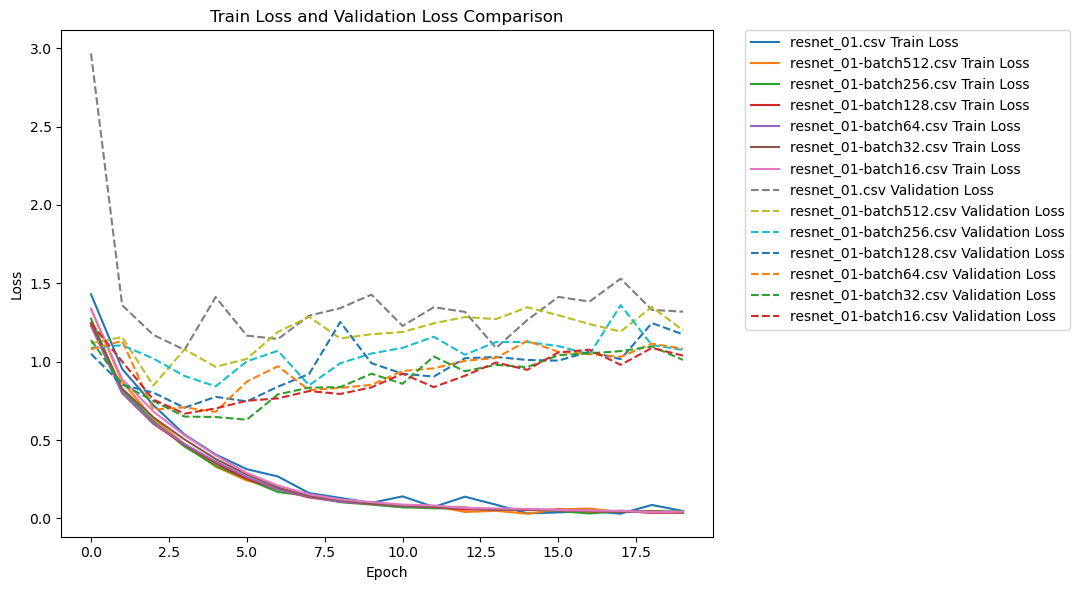

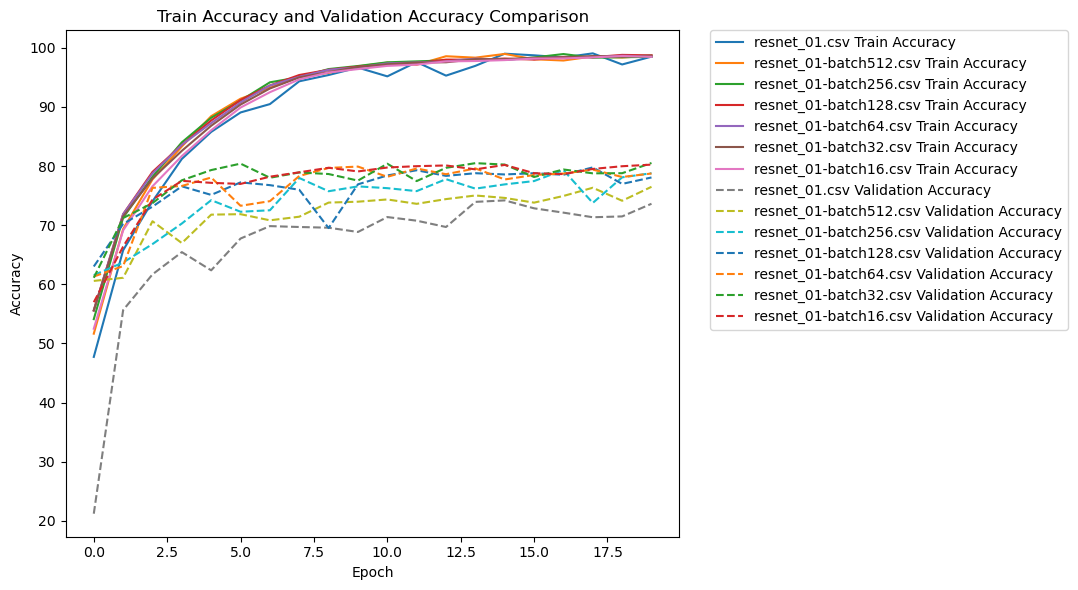

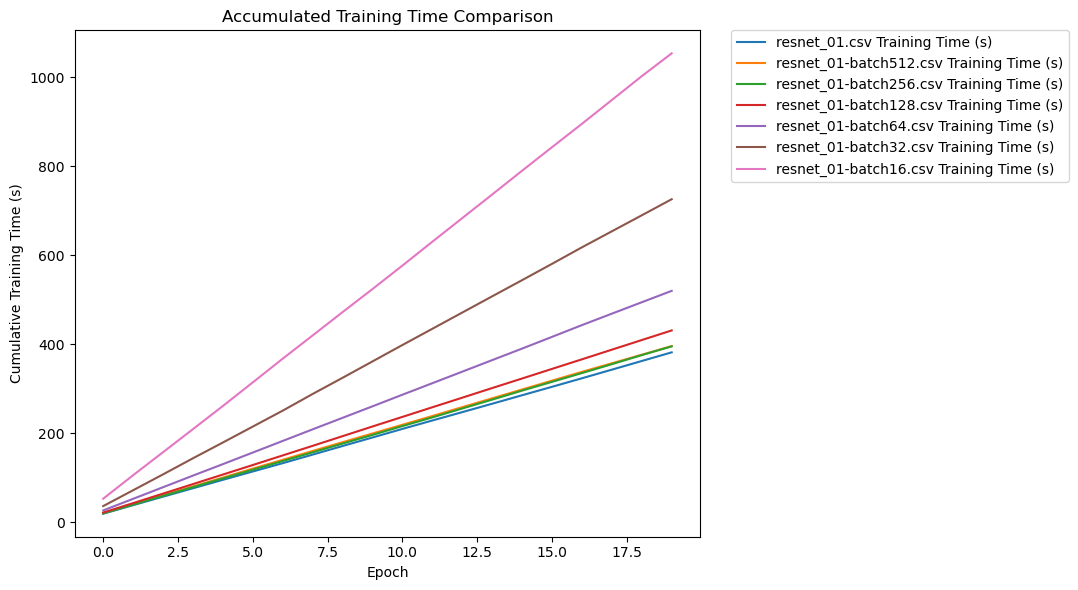

Model resnet_01.csv:
  Highest Validation Accuracy: 74.20
  Epoch at Highest Validation Accuracy: 15
  Total Time to Reach Highest Validation Accuracy: 285.12 seconds

Model resnet_01-batch512.csv:
  Highest Validation Accuracy: 76.50
  Epoch at Highest Validation Accuracy: 20
  Total Time to Reach Highest Validation Accuracy: 395.57 seconds

Model resnet_01-batch256.csv:
  Highest Validation Accuracy: 79.33
  Epoch at Highest Validation Accuracy: 17
  Total Time to Reach Highest Validation Accuracy: 335.02 seconds

Model resnet_01-batch128.csv:
  Highest Validation Accuracy: 79.78
  Epoch at Highest Validation Accuracy: 18
  Total Time to Reach Highest Validation Accuracy: 387.57 seconds

Model resnet_01-batch64.csv:
  Highest Validation Accuracy: 79.92
  Epoch at Highest Validation Accuracy: 10
  Total Time to Reach Highest Validation Accuracy: 260.21 seconds

Model resnet_01-batch32.csv:
  Highest Validation Accuracy: 80.53
  Epoch at Highest Validation Accuracy: 20
  Total Time to 

In [39]:
file_paths = [
    "resnet_01.csv",
    "resnet_01-batch512.csv",
    "resnet_01-batch256.csv",
    "resnet_01-batch128.csv",
    "resnet_01-batch64.csv",
    "resnet_01-batch32.csv",
    "resnet_01-batch16.csv",
]

compare_multi(file_paths,'resnet')


Batch 32 has the best performance in terms of validation accuracy and loss.

## Data Augmentation

### Data Normalize
We will get the mean and std to normalize the image

In [28]:
import os
import struct
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image

def calculate_mean_std(data_loader):
    """Calculate the mean and standard deviation for each channel in a dataset."""
    mean = 0.0
    std = 0.0
    total_images_count = 0

    for images, _ in data_loader:
        # Flatten the images along the batch and pixel dimensions, keep channel dimension
        images = images.view(images.size(0), images.size(1), -1)
        total_images_count += images.size(0)  # Batch size
        mean += images.mean(2).sum(0)  # Sum over all pixels and accumulate
        std += images.std(2).sum(0)    # Sum over all pixels and accumulate

    # Average the mean and std over all images
    mean /= total_images_count
    std /= total_images_count

    return mean, std

# Paths to the CIFAR-10 binary files
train_files = [f"./data_batch_{i+1}.bin" for i in range(5)]

# Define the dataset and data loader
train_transform = transforms.ToTensor()  # Only ToTensor for mean and std calculation
train_dataset = CIFAR10BinaryDataset(train_files, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

# Calculate mean and standard deviation
mean_value, std_value = calculate_mean_std(train_loader)
print(f"Mean: {mean_value}")
print(f"Standard Deviation: {std_value}")


Mean: tensor([0.4911, 0.4821, 0.4466])
Standard Deviation: tensor([0.2023, 0.1995, 0.2010])


In [39]:
# Add normalize
train_transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to tensor and scales to [0, 1]
    transforms.Normalize((0.4911, 0.4821, 0.4466), (0.2023, 0.1995, 0.2010)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4911, 0.4821, 0.4466), (0.2023, 0.1995, 0.2010))
])

# Reload Datasets
train_dataset = CIFAR10BinaryDataset(train_files, transform=train_transform)
val_dataset = CIFAR10BinaryDataset(val_files, transform=val_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=val_transform)

In [40]:
device = torch.device('cuda')
model = resnet_01().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 32
trainloader, valloader = datasetsloader(batch_size)

model_name='resnet_01-batch32-normalize'

train_model(
    model=model,
    train_loader=trainloader,
    val_loader=valloader,
    criterion=criterion,
    optimizer=optimizer, 
    num_epochs=20,
    model_name=model_name,
    csv_filename=f"./logs/{model_name}.csv",
    checkpoint_path=f"./models/{model_name}_check.pth",
    save_model_path=f"./models/{model_name}_best.pth",
    resume=False,
    save_best_on="accuracy")


Epoch 1/20: 100%|██████████| 1250/1250 [00:39<00:00, 31.45batch/s]


Epoch [1/20] Train Loss: 1.2827, Train Accuracy: 53.99%, Validation Loss: 1.0363, Validation Accuracy: 63.17%, Min Val Acc: 44.80%, Max Val Acc: 86.80%, Median Val Acc: 62.05%, Training Time: 39.74s, Validation Time: 7.67s
Model saved with validation accuracy: 63.17%
Checkpoint saved at epoch 1


Epoch 2/20: 100%|██████████| 1250/1250 [00:39<00:00, 31.32batch/s]


Epoch [2/20] Train Loss: 0.8355, Train Accuracy: 70.73%, Validation Loss: 0.8420, Validation Accuracy: 71.70%, Min Val Acc: 32.60%, Max Val Acc: 96.60%, Median Val Acc: 75.20%, Training Time: 39.91s, Validation Time: 7.60s
Model saved with validation accuracy: 71.70%
Checkpoint saved at epoch 2


Epoch 3/20: 100%|██████████| 1250/1250 [00:39<00:00, 31.39batch/s]


Epoch [3/20] Train Loss: 0.6442, Train Accuracy: 77.56%, Validation Loss: 0.6766, Validation Accuracy: 77.20%, Min Val Acc: 58.30%, Max Val Acc: 93.90%, Median Val Acc: 79.55%, Training Time: 39.82s, Validation Time: 8.10s
Model saved with validation accuracy: 77.20%
Checkpoint saved at epoch 3


Epoch 4/20: 100%|██████████| 1250/1250 [00:39<00:00, 31.32batch/s]


Epoch [4/20] Train Loss: 0.5027, Train Accuracy: 82.68%, Validation Loss: 0.6530, Validation Accuracy: 78.08%, Min Val Acc: 59.00%, Max Val Acc: 93.30%, Median Val Acc: 80.15%, Training Time: 39.91s, Validation Time: 8.00s
Model saved with validation accuracy: 78.08%
Checkpoint saved at epoch 4


Epoch 5/20: 100%|██████████| 1250/1250 [00:39<00:00, 31.37batch/s]


Epoch [5/20] Train Loss: 0.3773, Train Accuracy: 87.06%, Validation Loss: 0.6333, Validation Accuracy: 79.18%, Min Val Acc: 61.00%, Max Val Acc: 91.30%, Median Val Acc: 81.20%, Training Time: 39.86s, Validation Time: 8.27s
Model saved with validation accuracy: 79.18%
Checkpoint saved at epoch 5


Epoch 6/20: 100%|██████████| 1250/1250 [00:40<00:00, 30.99batch/s]


Epoch [6/20] Train Loss: 0.2675, Train Accuracy: 90.69%, Validation Loss: 0.6841, Validation Accuracy: 79.45%, Min Val Acc: 51.30%, Max Val Acc: 91.20%, Median Val Acc: 83.30%, Training Time: 40.35s, Validation Time: 7.45s
Model saved with validation accuracy: 79.45%
Checkpoint saved at epoch 6


Epoch 7/20: 100%|██████████| 1250/1250 [00:40<00:00, 31.07batch/s]


Epoch [7/20] Train Loss: 0.1951, Train Accuracy: 93.26%, Validation Loss: 0.6664, Validation Accuracy: 80.78%, Min Val Acc: 64.70%, Max Val Acc: 89.70%, Median Val Acc: 83.65%, Training Time: 40.23s, Validation Time: 7.57s
Model saved with validation accuracy: 80.78%
Checkpoint saved at epoch 7


Epoch 8/20: 100%|██████████| 1250/1250 [00:40<00:00, 30.93batch/s]


Epoch [8/20] Train Loss: 0.1403, Train Accuracy: 95.09%, Validation Loss: 0.7391, Validation Accuracy: 80.13%, Min Val Acc: 63.50%, Max Val Acc: 89.70%, Median Val Acc: 82.45%, Training Time: 40.42s, Validation Time: 7.79s
Checkpoint saved at epoch 8


Epoch 9/20: 100%|██████████| 1250/1250 [00:40<00:00, 31.24batch/s]


Epoch [9/20] Train Loss: 0.1110, Train Accuracy: 96.17%, Validation Loss: 0.8637, Validation Accuracy: 79.01%, Min Val Acc: 62.70%, Max Val Acc: 93.90%, Median Val Acc: 80.70%, Training Time: 40.01s, Validation Time: 6.96s
Checkpoint saved at epoch 9


Epoch 10/20: 100%|██████████| 1250/1250 [00:39<00:00, 31.45batch/s]


Epoch [10/20] Train Loss: 0.0944, Train Accuracy: 96.76%, Validation Loss: 0.8196, Validation Accuracy: 79.98%, Min Val Acc: 66.10%, Max Val Acc: 89.20%, Median Val Acc: 80.45%, Training Time: 39.75s, Validation Time: 7.30s
Checkpoint saved at epoch 10


Epoch 11/20: 100%|██████████| 1250/1250 [00:40<00:00, 31.07batch/s]


Epoch [11/20] Train Loss: 0.0765, Train Accuracy: 97.36%, Validation Loss: 0.8614, Validation Accuracy: 80.26%, Min Val Acc: 69.30%, Max Val Acc: 88.90%, Median Val Acc: 81.85%, Training Time: 40.23s, Validation Time: 7.36s
Checkpoint saved at epoch 11


Epoch 12/20: 100%|██████████| 1250/1250 [00:39<00:00, 31.50batch/s]


Epoch [12/20] Train Loss: 0.0814, Train Accuracy: 97.27%, Validation Loss: 0.8344, Validation Accuracy: 81.23%, Min Val Acc: 70.10%, Max Val Acc: 91.50%, Median Val Acc: 81.65%, Training Time: 39.68s, Validation Time: 7.26s
Model saved with validation accuracy: 81.23%
Checkpoint saved at epoch 12


Epoch 13/20: 100%|██████████| 1250/1250 [00:40<00:00, 30.91batch/s]


Epoch [13/20] Train Loss: 0.0606, Train Accuracy: 97.94%, Validation Loss: 0.9473, Validation Accuracy: 79.92%, Min Val Acc: 65.70%, Max Val Acc: 93.20%, Median Val Acc: 82.00%, Training Time: 40.43s, Validation Time: 7.61s
Checkpoint saved at epoch 13


Epoch 14/20: 100%|██████████| 1250/1250 [00:41<00:00, 30.45batch/s]


Epoch [14/20] Train Loss: 0.0607, Train Accuracy: 97.85%, Validation Loss: 0.9137, Validation Accuracy: 80.48%, Min Val Acc: 64.10%, Max Val Acc: 91.20%, Median Val Acc: 83.45%, Training Time: 41.06s, Validation Time: 7.00s
Checkpoint saved at epoch 14


Epoch 15/20: 100%|██████████| 1250/1250 [00:40<00:00, 31.21batch/s]


Epoch [15/20] Train Loss: 0.0604, Train Accuracy: 97.97%, Validation Loss: 0.9822, Validation Accuracy: 79.50%, Min Val Acc: 55.60%, Max Val Acc: 93.30%, Median Val Acc: 82.40%, Training Time: 40.05s, Validation Time: 7.64s
Checkpoint saved at epoch 15


Epoch 16/20: 100%|██████████| 1250/1250 [00:39<00:00, 31.39batch/s]


Epoch [16/20] Train Loss: 0.0477, Train Accuracy: 98.32%, Validation Loss: 0.9483, Validation Accuracy: 80.27%, Min Val Acc: 68.60%, Max Val Acc: 93.10%, Median Val Acc: 80.65%, Training Time: 39.83s, Validation Time: 7.29s
Checkpoint saved at epoch 16


Epoch 17/20: 100%|██████████| 1250/1250 [00:40<00:00, 31.05batch/s]


Epoch [17/20] Train Loss: 0.0446, Train Accuracy: 98.48%, Validation Loss: 1.0690, Validation Accuracy: 78.99%, Min Val Acc: 65.90%, Max Val Acc: 92.70%, Median Val Acc: 78.95%, Training Time: 40.26s, Validation Time: 7.16s
Checkpoint saved at epoch 17


Epoch 18/20: 100%|██████████| 1250/1250 [00:39<00:00, 31.29batch/s]


Epoch [18/20] Train Loss: 0.0470, Train Accuracy: 98.46%, Validation Loss: 0.9552, Validation Accuracy: 81.11%, Min Val Acc: 66.40%, Max Val Acc: 91.90%, Median Val Acc: 81.70%, Training Time: 39.95s, Validation Time: 7.22s
Checkpoint saved at epoch 18


Epoch 19/20: 100%|██████████| 1250/1250 [00:40<00:00, 30.95batch/s]


Epoch [19/20] Train Loss: 0.0380, Train Accuracy: 98.71%, Validation Loss: 1.0108, Validation Accuracy: 80.51%, Min Val Acc: 64.60%, Max Val Acc: 92.20%, Median Val Acc: 81.25%, Training Time: 40.39s, Validation Time: 7.24s
Checkpoint saved at epoch 19


Epoch 20/20: 100%|██████████| 1250/1250 [00:40<00:00, 30.95batch/s]


Epoch [20/20] Train Loss: 0.0392, Train Accuracy: 98.68%, Validation Loss: 1.0584, Validation Accuracy: 79.91%, Min Val Acc: 65.20%, Max Val Acc: 92.40%, Median Val Acc: 81.35%, Training Time: 40.39s, Validation Time: 7.36s
Checkpoint saved at epoch 20


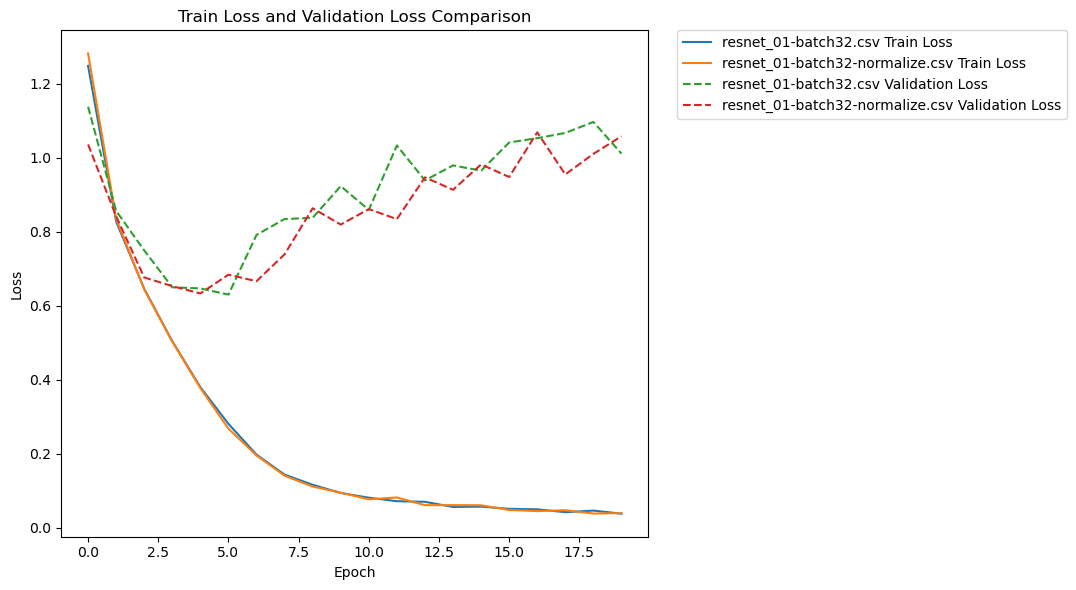

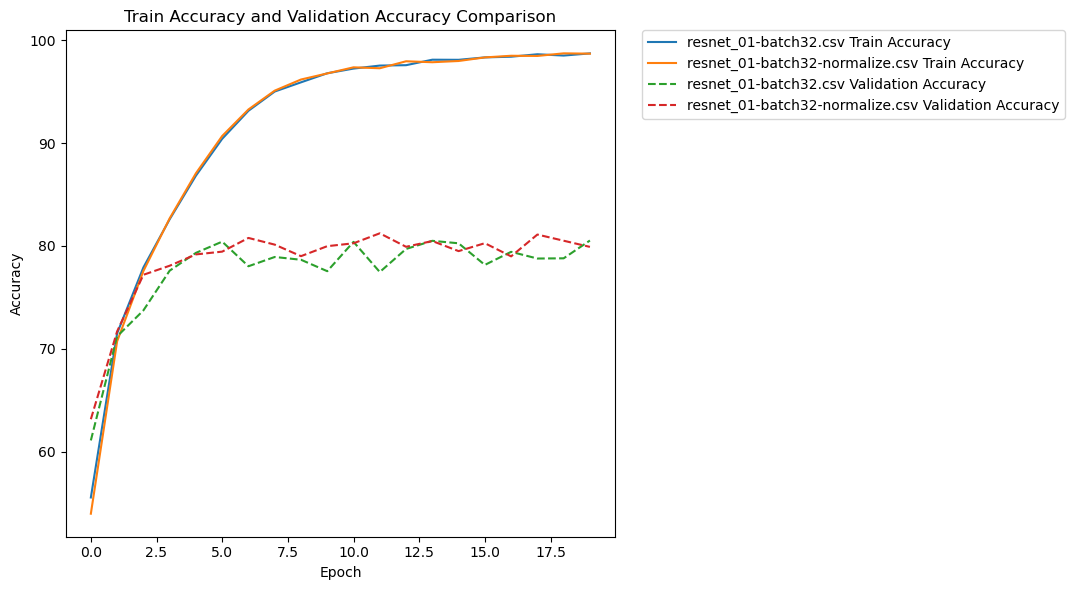

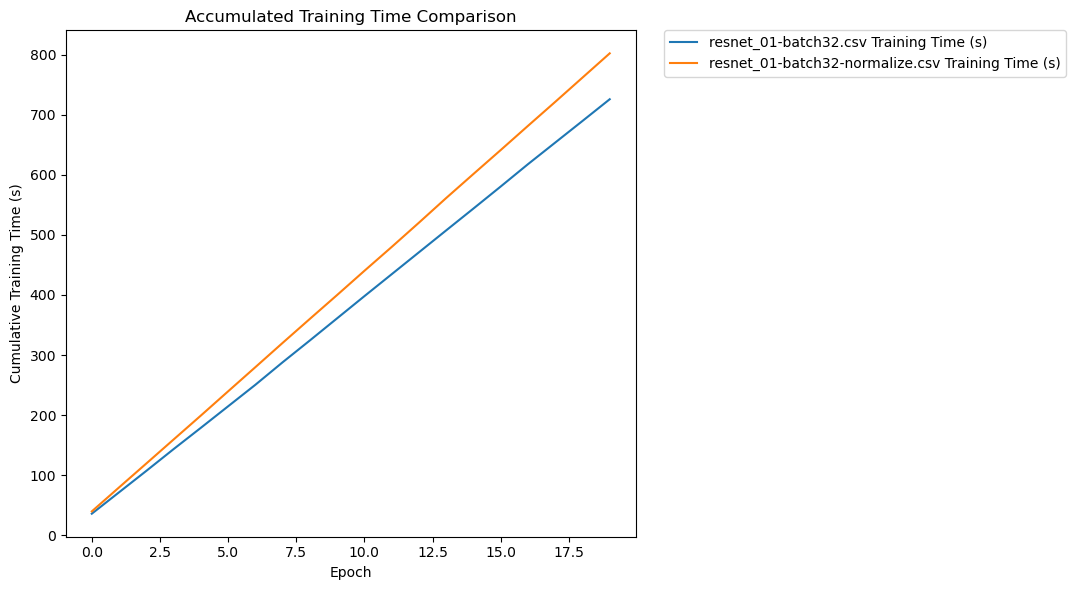

Model resnet_01-batch32.csv:
  Highest Validation Accuracy: 80.53
  Epoch at Highest Validation Accuracy: 20
  Total Time to Reach Highest Validation Accuracy: 725.89 seconds

Model resnet_01-batch32-normalize.csv:
  Highest Validation Accuracy: 81.23
  Epoch at Highest Validation Accuracy: 12
  Total Time to Reach Highest Validation Accuracy: 479.91 seconds

Model resnet_01-batch32.csv:
  Lowest Validation Loss: 0.630
  Epoch at Lowest Validation Loss: 6
  Total Time to Reach Lowest Validation Loss: 214.68 seconds

Model resnet_01-batch32-normalize.csv:
  Lowest Validation Loss: 0.633
  Epoch at Lowest Validation Loss: 5
  Total Time to Reach Lowest Validation Loss: 199.25 seconds



In [40]:
file_paths = [
    "resnet_01-batch32.csv",
    "resnet_01-batch32-normalize.csv",
]

compare_multi(file_paths)

The normalize one reach the high validation score faster and more stable

### RandomHorizontal Flip

In [35]:
# Add normalize
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),  # Converts to tensor and scales to [0, 1]
    transforms.Normalize((0.4911, 0.4821, 0.4466), (0.2023, 0.1995, 0.2010)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4911, 0.4821, 0.4466), (0.2023, 0.1995, 0.2010))
])

# Reload Datasets
train_dataset = CIFAR10BinaryDataset(train_files, transform=train_transform)
val_dataset = CIFAR10BinaryDataset(val_files, transform=val_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=val_transform)

In [38]:
device = torch.device('cuda')
model = resnet_01().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 32
trainloader, valloader = datasetsloader(batch_size)

model_name='resnet_01-batch32-nrmlz_hflip'

train_model(
    model=model,
    train_loader=trainloader,
    val_loader=valloader,
    criterion=criterion,
    optimizer=optimizer, 
    num_epochs=20,
    model_name=model_name,
    csv_filename=f"./logs/{model_name}.csv",
    checkpoint_path=f"./models/{model_name}_check.pth",
    save_model_path=f"./models/{model_name}_best.pth",
    resume=False,
    save_best_on="accuracy")


Epoch 1/20: 100%|██████████| 1250/1250 [00:42<00:00, 29.60batch/s]


Epoch [1/20] Train Loss: 1.2802, Train Accuracy: 54.05%, Validation Loss: 1.0466, Validation Accuracy: 63.51%, Min Val Acc: 31.10%, Max Val Acc: 87.20%, Median Val Acc: 66.70%, Training Time: 42.22s, Validation Time: 7.76s
Model saved with validation accuracy: 63.51%
Checkpoint saved at epoch 1


Epoch 2/20: 100%|██████████| 1250/1250 [00:42<00:00, 29.52batch/s]


Epoch [2/20] Train Loss: 0.8473, Train Accuracy: 70.43%, Validation Loss: 0.8092, Validation Accuracy: 72.20%, Min Val Acc: 52.90%, Max Val Acc: 92.70%, Median Val Acc: 71.55%, Training Time: 42.34s, Validation Time: 8.08s
Model saved with validation accuracy: 72.20%
Checkpoint saved at epoch 2


Epoch 3/20: 100%|██████████| 1250/1250 [00:41<00:00, 29.88batch/s]


Epoch [3/20] Train Loss: 0.6823, Train Accuracy: 76.66%, Validation Loss: 0.7970, Validation Accuracy: 73.15%, Min Val Acc: 53.10%, Max Val Acc: 97.30%, Median Val Acc: 72.90%, Training Time: 41.84s, Validation Time: 7.15s
Model saved with validation accuracy: 73.15%
Checkpoint saved at epoch 3


Epoch 4/20: 100%|██████████| 1250/1250 [00:42<00:00, 29.33batch/s]


Epoch [4/20] Train Loss: 0.5706, Train Accuracy: 80.44%, Validation Loss: 0.5869, Validation Accuracy: 80.37%, Min Val Acc: 66.00%, Max Val Acc: 92.40%, Median Val Acc: 80.65%, Training Time: 42.62s, Validation Time: 7.24s
Model saved with validation accuracy: 80.37%
Checkpoint saved at epoch 4


Epoch 5/20: 100%|██████████| 1250/1250 [00:42<00:00, 29.33batch/s]


Epoch [5/20] Train Loss: 0.4874, Train Accuracy: 83.21%, Validation Loss: 0.5562, Validation Accuracy: 81.49%, Min Val Acc: 57.80%, Max Val Acc: 92.00%, Median Val Acc: 82.80%, Training Time: 42.61s, Validation Time: 7.16s
Model saved with validation accuracy: 81.49%
Checkpoint saved at epoch 5


Epoch 6/20: 100%|██████████| 1250/1250 [00:42<00:00, 29.40batch/s]


Epoch [6/20] Train Loss: 0.4137, Train Accuracy: 85.77%, Validation Loss: 0.6245, Validation Accuracy: 79.21%, Min Val Acc: 61.30%, Max Val Acc: 92.40%, Median Val Acc: 79.20%, Training Time: 42.53s, Validation Time: 8.00s
Checkpoint saved at epoch 6


Epoch 7/20: 100%|██████████| 1250/1250 [00:41<00:00, 29.91batch/s]


Epoch [7/20] Train Loss: 0.3542, Train Accuracy: 87.86%, Validation Loss: 0.5705, Validation Accuracy: 80.98%, Min Val Acc: 66.90%, Max Val Acc: 88.60%, Median Val Acc: 82.25%, Training Time: 41.80s, Validation Time: 8.00s
Checkpoint saved at epoch 7


Epoch 8/20: 100%|██████████| 1250/1250 [00:42<00:00, 29.16batch/s]


Epoch [8/20] Train Loss: 0.3011, Train Accuracy: 89.61%, Validation Loss: 0.5344, Validation Accuracy: 82.73%, Min Val Acc: 61.40%, Max Val Acc: 92.40%, Median Val Acc: 86.20%, Training Time: 42.87s, Validation Time: 7.43s
Model saved with validation accuracy: 82.73%
Checkpoint saved at epoch 8


Epoch 9/20: 100%|██████████| 1250/1250 [00:42<00:00, 29.27batch/s]


Epoch [9/20] Train Loss: 0.2556, Train Accuracy: 91.32%, Validation Loss: 0.5373, Validation Accuracy: 83.07%, Min Val Acc: 72.10%, Max Val Acc: 92.60%, Median Val Acc: 85.05%, Training Time: 42.71s, Validation Time: 7.43s
Model saved with validation accuracy: 83.07%
Checkpoint saved at epoch 9


Epoch 10/20: 100%|██████████| 1250/1250 [00:42<00:00, 29.72batch/s]


Epoch [10/20] Train Loss: 0.2183, Train Accuracy: 92.44%, Validation Loss: 0.5971, Validation Accuracy: 82.41%, Min Val Acc: 71.70%, Max Val Acc: 95.40%, Median Val Acc: 82.65%, Training Time: 42.07s, Validation Time: 7.09s
Checkpoint saved at epoch 10


Epoch 11/20: 100%|██████████| 1250/1250 [00:42<00:00, 29.61batch/s]


Epoch [11/20] Train Loss: 0.1874, Train Accuracy: 93.62%, Validation Loss: 0.5481, Validation Accuracy: 83.35%, Min Val Acc: 68.80%, Max Val Acc: 91.40%, Median Val Acc: 87.90%, Training Time: 42.22s, Validation Time: 7.82s
Model saved with validation accuracy: 83.35%
Checkpoint saved at epoch 11


Epoch 12/20: 100%|██████████| 1250/1250 [00:42<00:00, 29.26batch/s]


Epoch [12/20] Train Loss: 0.1525, Train Accuracy: 94.78%, Validation Loss: 0.6035, Validation Accuracy: 83.16%, Min Val Acc: 66.60%, Max Val Acc: 92.50%, Median Val Acc: 86.20%, Training Time: 42.73s, Validation Time: 8.10s
Checkpoint saved at epoch 12


Epoch 13/20: 100%|██████████| 1250/1250 [00:42<00:00, 29.65batch/s]


Epoch [13/20] Train Loss: 0.1399, Train Accuracy: 95.23%, Validation Loss: 0.6673, Validation Accuracy: 82.04%, Min Val Acc: 63.20%, Max Val Acc: 97.00%, Median Val Acc: 85.00%, Training Time: 42.16s, Validation Time: 7.81s
Checkpoint saved at epoch 13


Epoch 14/20: 100%|██████████| 1250/1250 [00:42<00:00, 29.28batch/s]


Epoch [14/20] Train Loss: 0.1186, Train Accuracy: 95.83%, Validation Loss: 0.5863, Validation Accuracy: 84.00%, Min Val Acc: 70.80%, Max Val Acc: 92.90%, Median Val Acc: 86.30%, Training Time: 42.70s, Validation Time: 7.44s
Model saved with validation accuracy: 84.00%
Checkpoint saved at epoch 14


Epoch 15/20: 100%|██████████| 1250/1250 [00:42<00:00, 29.61batch/s]


Epoch [15/20] Train Loss: 0.1081, Train Accuracy: 96.28%, Validation Loss: 0.6723, Validation Accuracy: 83.02%, Min Val Acc: 70.00%, Max Val Acc: 94.40%, Median Val Acc: 81.70%, Training Time: 42.21s, Validation Time: 7.38s
Checkpoint saved at epoch 15


Epoch 16/20: 100%|██████████| 1250/1250 [00:42<00:00, 29.44batch/s]


Epoch [16/20] Train Loss: 0.0991, Train Accuracy: 96.55%, Validation Loss: 0.6108, Validation Accuracy: 84.17%, Min Val Acc: 70.60%, Max Val Acc: 91.90%, Median Val Acc: 86.65%, Training Time: 42.47s, Validation Time: 7.91s
Model saved with validation accuracy: 84.17%
Checkpoint saved at epoch 16


Epoch 17/20: 100%|██████████| 1250/1250 [00:42<00:00, 29.62batch/s]


Epoch [17/20] Train Loss: 0.0882, Train Accuracy: 96.94%, Validation Loss: 0.6646, Validation Accuracy: 82.89%, Min Val Acc: 71.50%, Max Val Acc: 92.30%, Median Val Acc: 85.40%, Training Time: 42.22s, Validation Time: 8.55s
Checkpoint saved at epoch 17


Epoch 18/20: 100%|██████████| 1250/1250 [00:41<00:00, 30.01batch/s]


Epoch [18/20] Train Loss: 0.0804, Train Accuracy: 97.23%, Validation Loss: 0.6599, Validation Accuracy: 83.91%, Min Val Acc: 67.60%, Max Val Acc: 93.20%, Median Val Acc: 84.50%, Training Time: 41.66s, Validation Time: 7.70s
Checkpoint saved at epoch 18


Epoch 19/20: 100%|██████████| 1250/1250 [00:42<00:00, 29.66batch/s]


Epoch [19/20] Train Loss: 0.0764, Train Accuracy: 97.35%, Validation Loss: 0.7090, Validation Accuracy: 83.16%, Min Val Acc: 68.40%, Max Val Acc: 90.80%, Median Val Acc: 85.85%, Training Time: 42.16s, Validation Time: 7.64s
Checkpoint saved at epoch 19


Epoch 20/20: 100%|██████████| 1250/1250 [00:42<00:00, 29.53batch/s]


Epoch [20/20] Train Loss: 0.0695, Train Accuracy: 97.53%, Validation Loss: 0.7066, Validation Accuracy: 83.45%, Min Val Acc: 72.40%, Max Val Acc: 92.40%, Median Val Acc: 83.65%, Training Time: 42.33s, Validation Time: 7.30s
Checkpoint saved at epoch 20


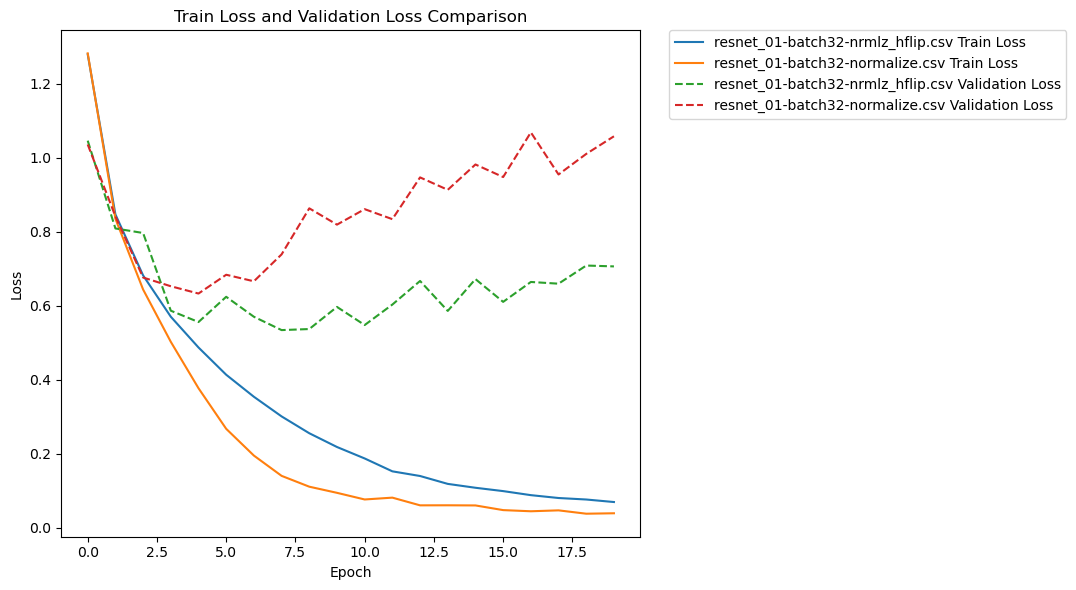

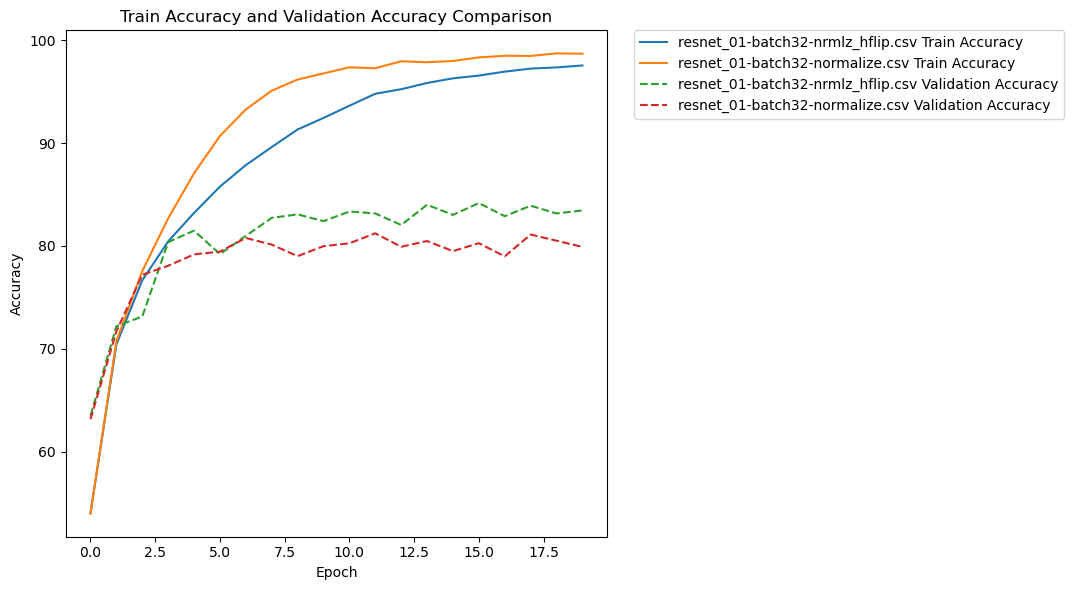

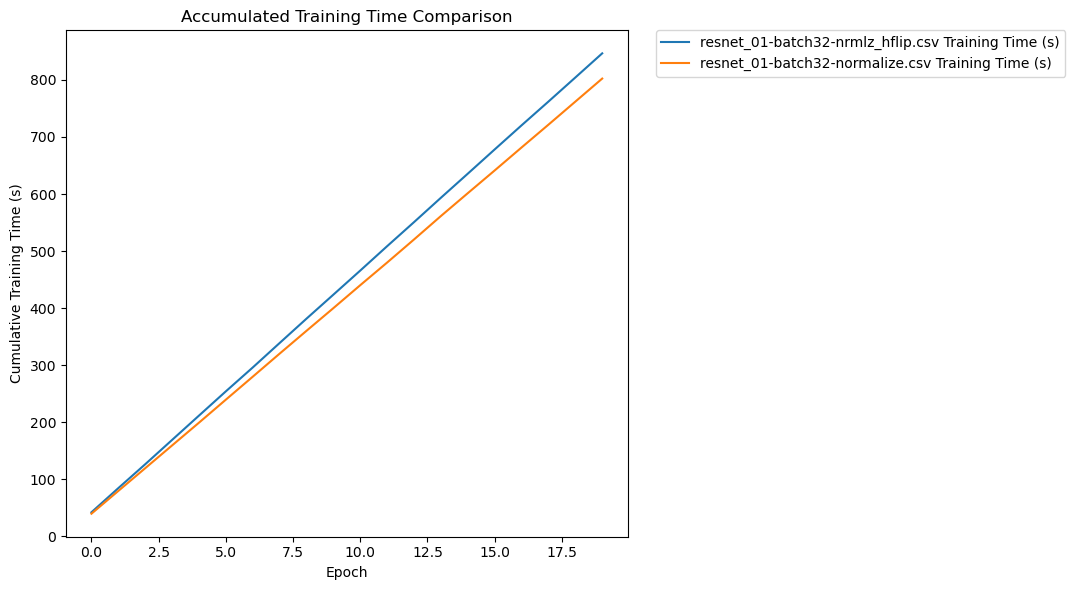

Model resnet_01-batch32-nrmlz_hflip.csv:
  Highest Validation Accuracy: 84.17
  Epoch at Highest Validation Accuracy: 16
  Total Time to Reach Highest Validation Accuracy: 678.11 seconds

Model resnet_01-batch32-normalize.csv:
  Highest Validation Accuracy: 81.23
  Epoch at Highest Validation Accuracy: 12
  Total Time to Reach Highest Validation Accuracy: 479.91 seconds

Model resnet_01-batch32-nrmlz_hflip.csv:
  Lowest Validation Loss: 0.534
  Epoch at Lowest Validation Loss: 8
  Total Time to Reach Lowest Validation Loss: 338.85 seconds

Model resnet_01-batch32-normalize.csv:
  Lowest Validation Loss: 0.633
  Epoch at Lowest Validation Loss: 5
  Total Time to Reach Lowest Validation Loss: 199.25 seconds



In [41]:
file_paths = [
    "resnet_01-batch32-nrmlz_hflip.csv",
    "resnet_01-batch32-normalize.csv",
]

compare_multi(file_paths)

### Random Rotation

In [45]:
# Add normalize
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ToTensor(),  # Converts to tensor and scales to [0, 1]
    transforms.Normalize((0.4911, 0.4821, 0.4466), (0.2023, 0.1995, 0.2010)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4911, 0.4821, 0.4466), (0.2023, 0.1995, 0.2010))
])

# Reload Datasets
train_dataset = CIFAR10BinaryDataset(train_files, transform=train_transform)
val_dataset = CIFAR10BinaryDataset(val_files, transform=val_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=val_transform)



In [46]:
device = torch.device('cuda')
model = resnet_01().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 32
trainloader, valloader = datasetsloader(batch_size)

model_name='resnet_01-batch32-randomrotate'

train_model(
    model=model,
    train_loader=trainloader,
    val_loader=valloader,
    criterion=criterion,
    optimizer=optimizer, 
    num_epochs=20,
    model_name=model_name,
    csv_filename=f"./logs/{model_name}.csv",
    checkpoint_path=f"./models/{model_name}_check.pth",
    save_model_path=f"./models/{model_name}_best.pth",
    resume=False,
    save_best_on="accuracy")


Epoch 1/20: 100%|██████████| 1250/1250 [01:06<00:00, 18.71batch/s]


Epoch [1/20] Train Loss: 1.3724, Train Accuracy: 50.62%, Validation Loss: 1.0862, Validation Accuracy: 62.09%, Min Val Acc: 39.70%, Max Val Acc: 85.80%, Median Val Acc: 61.15%, Training Time: 66.82s, Validation Time: 7.97s
Model saved with validation accuracy: 62.09%
Checkpoint saved at epoch 1


Epoch 2/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.56batch/s]


Epoch [2/20] Train Loss: 1.0078, Train Accuracy: 64.72%, Validation Loss: 0.8222, Validation Accuracy: 71.16%, Min Val Acc: 52.10%, Max Val Acc: 84.50%, Median Val Acc: 74.65%, Training Time: 67.38s, Validation Time: 7.57s
Model saved with validation accuracy: 71.16%
Checkpoint saved at epoch 2


Epoch 3/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.62batch/s]


Epoch [3/20] Train Loss: 0.8465, Train Accuracy: 70.59%, Validation Loss: 0.7849, Validation Accuracy: 73.24%, Min Val Acc: 55.00%, Max Val Acc: 89.10%, Median Val Acc: 70.45%, Training Time: 67.14s, Validation Time: 7.77s
Model saved with validation accuracy: 73.24%
Checkpoint saved at epoch 3


Epoch 4/20: 100%|██████████| 1250/1250 [01:10<00:00, 17.70batch/s]


Epoch [4/20] Train Loss: 0.7505, Train Accuracy: 73.69%, Validation Loss: 0.6417, Validation Accuracy: 78.22%, Min Val Acc: 60.80%, Max Val Acc: 88.40%, Median Val Acc: 81.45%, Training Time: 70.63s, Validation Time: 7.55s
Model saved with validation accuracy: 78.22%
Checkpoint saved at epoch 4


Epoch 5/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.51batch/s]


Epoch [5/20] Train Loss: 0.6779, Train Accuracy: 76.52%, Validation Loss: 0.6044, Validation Accuracy: 79.10%, Min Val Acc: 64.30%, Max Val Acc: 93.90%, Median Val Acc: 81.15%, Training Time: 67.53s, Validation Time: 8.37s
Model saved with validation accuracy: 79.10%
Checkpoint saved at epoch 5


Epoch 6/20: 100%|██████████| 1250/1250 [01:06<00:00, 18.69batch/s]


Epoch [6/20] Train Loss: 0.6145, Train Accuracy: 78.67%, Validation Loss: 0.5792, Validation Accuracy: 80.19%, Min Val Acc: 63.50%, Max Val Acc: 93.00%, Median Val Acc: 81.60%, Training Time: 66.90s, Validation Time: 7.96s
Model saved with validation accuracy: 80.19%
Checkpoint saved at epoch 6


Epoch 7/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.53batch/s]


Epoch [7/20] Train Loss: 0.5609, Train Accuracy: 80.57%, Validation Loss: 0.5990, Validation Accuracy: 80.27%, Min Val Acc: 68.30%, Max Val Acc: 95.80%, Median Val Acc: 80.55%, Training Time: 67.45s, Validation Time: 7.12s
Model saved with validation accuracy: 80.27%
Checkpoint saved at epoch 7


Epoch 8/20: 100%|██████████| 1250/1250 [01:06<00:00, 18.69batch/s]


Epoch [8/20] Train Loss: 0.5176, Train Accuracy: 82.27%, Validation Loss: 0.5383, Validation Accuracy: 81.75%, Min Val Acc: 64.90%, Max Val Acc: 90.50%, Median Val Acc: 83.70%, Training Time: 66.91s, Validation Time: 7.31s
Model saved with validation accuracy: 81.75%
Checkpoint saved at epoch 8


Epoch 9/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.59batch/s]


Epoch [9/20] Train Loss: 0.4778, Train Accuracy: 83.44%, Validation Loss: 0.5646, Validation Accuracy: 81.19%, Min Val Acc: 58.00%, Max Val Acc: 93.30%, Median Val Acc: 83.80%, Training Time: 67.26s, Validation Time: 8.46s
Checkpoint saved at epoch 9


Epoch 10/20: 100%|██████████| 1250/1250 [01:08<00:00, 18.28batch/s]


Epoch [10/20] Train Loss: 0.4403, Train Accuracy: 84.85%, Validation Loss: 0.5201, Validation Accuracy: 82.65%, Min Val Acc: 63.60%, Max Val Acc: 92.50%, Median Val Acc: 87.30%, Training Time: 68.39s, Validation Time: 8.63s
Model saved with validation accuracy: 82.65%
Checkpoint saved at epoch 10


Epoch 11/20: 100%|██████████| 1250/1250 [01:08<00:00, 18.36batch/s]


Epoch [11/20] Train Loss: 0.4085, Train Accuracy: 85.59%, Validation Loss: 0.4972, Validation Accuracy: 83.85%, Min Val Acc: 67.70%, Max Val Acc: 95.00%, Median Val Acc: 86.65%, Training Time: 68.07s, Validation Time: 8.29s
Model saved with validation accuracy: 83.85%
Checkpoint saved at epoch 11


Epoch 12/20: 100%|██████████| 1250/1250 [01:09<00:00, 17.89batch/s]


Epoch [12/20] Train Loss: 0.3767, Train Accuracy: 86.96%, Validation Loss: 0.4954, Validation Accuracy: 83.92%, Min Val Acc: 62.60%, Max Val Acc: 94.90%, Median Val Acc: 84.10%, Training Time: 69.86s, Validation Time: 7.91s
Model saved with validation accuracy: 83.92%
Checkpoint saved at epoch 12


Epoch 13/20: 100%|██████████| 1250/1250 [01:08<00:00, 18.36batch/s]


Epoch [13/20] Train Loss: 0.3551, Train Accuracy: 87.60%, Validation Loss: 0.5027, Validation Accuracy: 83.76%, Min Val Acc: 67.30%, Max Val Acc: 94.20%, Median Val Acc: 85.80%, Training Time: 68.12s, Validation Time: 7.37s
Checkpoint saved at epoch 13


Epoch 14/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.44batch/s]


Epoch [14/20] Train Loss: 0.3309, Train Accuracy: 88.38%, Validation Loss: 0.4930, Validation Accuracy: 84.42%, Min Val Acc: 68.30%, Max Val Acc: 94.10%, Median Val Acc: 86.15%, Training Time: 67.79s, Validation Time: 7.37s
Model saved with validation accuracy: 84.42%
Checkpoint saved at epoch 14


Epoch 15/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.46batch/s]


Epoch [15/20] Train Loss: 0.3095, Train Accuracy: 89.22%, Validation Loss: 0.5086, Validation Accuracy: 84.31%, Min Val Acc: 68.30%, Max Val Acc: 96.20%, Median Val Acc: 87.80%, Training Time: 67.70s, Validation Time: 8.00s
Checkpoint saved at epoch 15


Epoch 16/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.44batch/s]


Epoch [16/20] Train Loss: 0.2832, Train Accuracy: 90.16%, Validation Loss: 0.5110, Validation Accuracy: 84.37%, Min Val Acc: 68.40%, Max Val Acc: 94.50%, Median Val Acc: 85.90%, Training Time: 67.78s, Validation Time: 8.24s
Checkpoint saved at epoch 16


Epoch 17/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.62batch/s]


Epoch [17/20] Train Loss: 0.2647, Train Accuracy: 90.81%, Validation Loss: 0.5202, Validation Accuracy: 84.33%, Min Val Acc: 65.30%, Max Val Acc: 93.80%, Median Val Acc: 87.50%, Training Time: 67.12s, Validation Time: 7.93s
Checkpoint saved at epoch 17


Epoch 18/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.41batch/s]


Epoch [18/20] Train Loss: 0.2521, Train Accuracy: 91.23%, Validation Loss: 0.5242, Validation Accuracy: 84.17%, Min Val Acc: 73.70%, Max Val Acc: 93.50%, Median Val Acc: 85.65%, Training Time: 67.89s, Validation Time: 7.28s
Checkpoint saved at epoch 18


Epoch 19/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.42batch/s]


Epoch [19/20] Train Loss: 0.2393, Train Accuracy: 91.73%, Validation Loss: 0.5306, Validation Accuracy: 84.65%, Min Val Acc: 68.20%, Max Val Acc: 94.40%, Median Val Acc: 84.90%, Training Time: 67.88s, Validation Time: 7.72s
Model saved with validation accuracy: 84.65%
Checkpoint saved at epoch 19


Epoch 20/20: 100%|██████████| 1250/1250 [01:07<00:00, 18.42batch/s]


Epoch [20/20] Train Loss: 0.2227, Train Accuracy: 92.33%, Validation Loss: 0.5367, Validation Accuracy: 84.80%, Min Val Acc: 75.60%, Max Val Acc: 92.80%, Median Val Acc: 87.40%, Training Time: 67.86s, Validation Time: 8.31s
Model saved with validation accuracy: 84.80%
Checkpoint saved at epoch 20


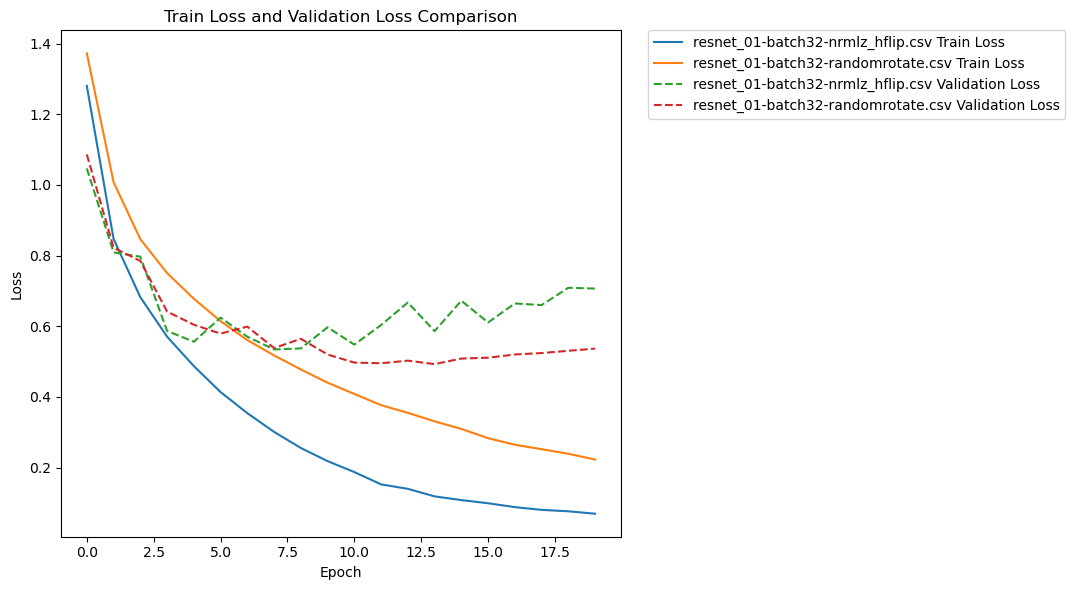

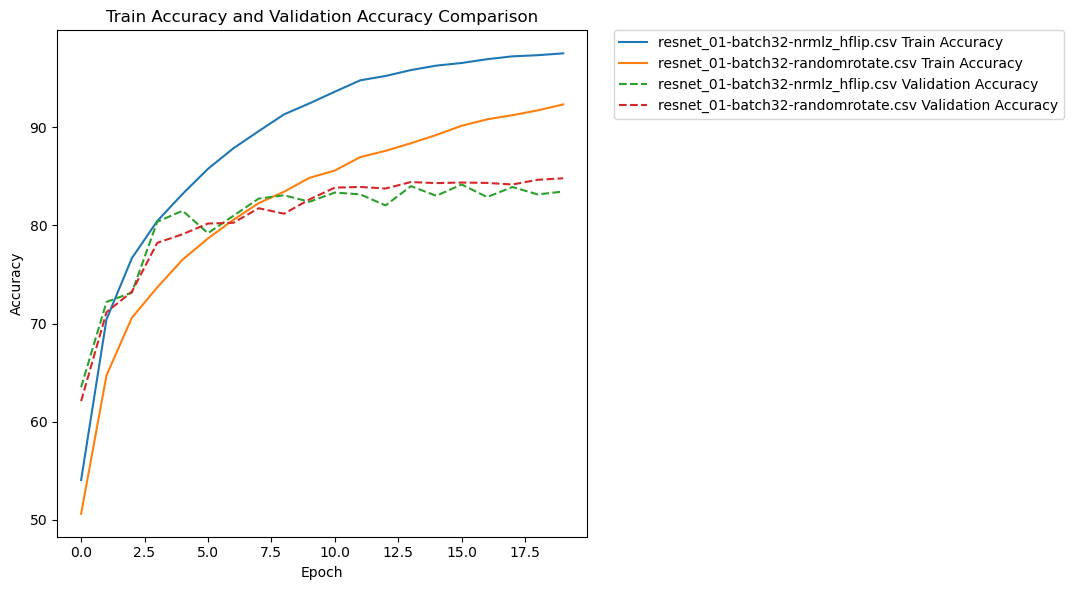

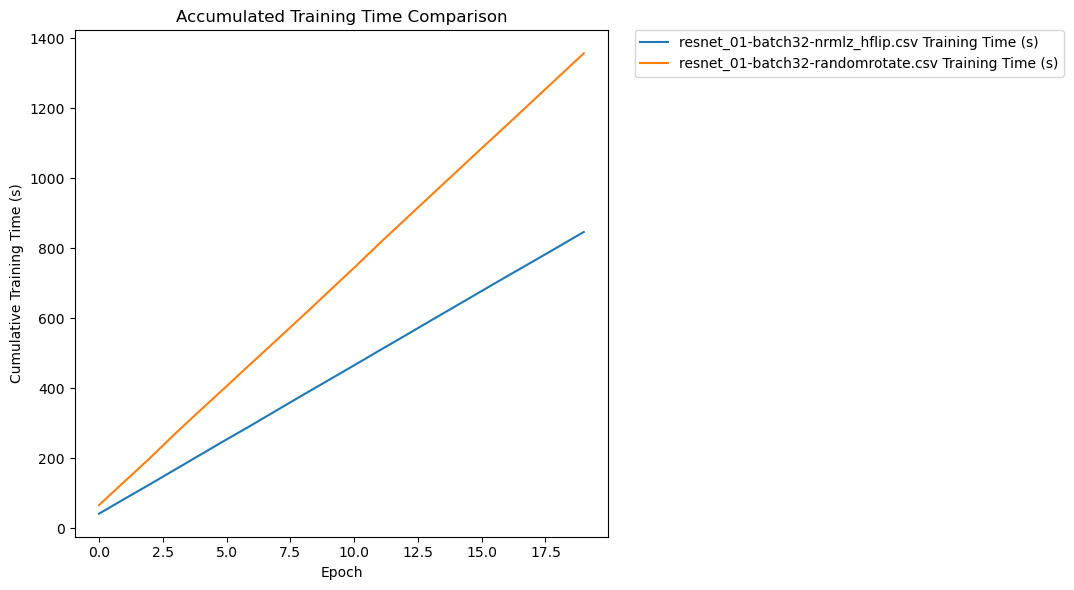

Model resnet_01-batch32-nrmlz_hflip.csv:
  Highest Validation Accuracy: 84.17
  Epoch at Highest Validation Accuracy: 16
  Total Time to Reach Highest Validation Accuracy: 678.11 seconds

Model resnet_01-batch32-randomrotate.csv:
  Highest Validation Accuracy: 84.80
  Epoch at Highest Validation Accuracy: 20
  Total Time to Reach Highest Validation Accuracy: 1356.46 seconds

Model resnet_01-batch32-nrmlz_hflip.csv:
  Lowest Validation Loss: 0.534
  Epoch at Lowest Validation Loss: 8
  Total Time to Reach Lowest Validation Loss: 338.85 seconds

Model resnet_01-batch32-randomrotate.csv:
  Lowest Validation Loss: 0.493
  Epoch at Lowest Validation Loss: 14
  Total Time to Reach Lowest Validation Loss: 950.22 seconds



In [42]:
file_paths = [
    "resnet_01-batch32-nrmlz_hflip.csv",
    "resnet_01-batch32-randomrotate.csv",
]

compare_multi(file_paths)

Applying random rotation improve stability and better accuration

### Random Erase

In [49]:
# Add normalize
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ToTensor(),  # Converts to tensor and scales to [0, 1]
    transforms.Normalize((0.4911, 0.4821, 0.4466), (0.2023, 0.1995, 0.2010)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), value='random', inplace=False)

])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4911, 0.4821, 0.4466), (0.2023, 0.1995, 0.2010))
])

# Reload Datasets
train_dataset = CIFAR10BinaryDataset(train_files, transform=train_transform)
val_dataset = CIFAR10BinaryDataset(val_files, transform=val_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=val_transform)



In [50]:
device = torch.device('cuda')
model = resnet_01().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 32
trainloader, valloader = datasetsloader(batch_size)

model_name='resnet_01-batch32-randomerase'

train_model(
    model=model,
    train_loader=trainloader,
    val_loader=valloader,
    criterion=criterion,
    optimizer=optimizer, 
    num_epochs=20,
    model_name=model_name,
    csv_filename=f"./logs/{model_name}.csv",
    checkpoint_path=f"./models/{model_name}_check.pth",
    save_model_path=f"./models/{model_name}_best.pth",
    resume=False,
    save_best_on="accuracy")


Epoch 1/20: 100%|██████████| 1250/1250 [00:51<00:00, 24.38batch/s]


Epoch [1/20] Train Loss: 1.4510, Train Accuracy: 47.78%, Validation Loss: 1.0716, Validation Accuracy: 61.53%, Min Val Acc: 43.90%, Max Val Acc: 83.40%, Median Val Acc: 57.45%, Training Time: 51.28s, Validation Time: 7.61s
Model saved with validation accuracy: 61.53%
Checkpoint saved at epoch 1


Epoch 2/20: 100%|██████████| 1250/1250 [00:51<00:00, 24.32batch/s]


Epoch [2/20] Train Loss: 1.1057, Train Accuracy: 60.91%, Validation Loss: 0.9020, Validation Accuracy: 68.05%, Min Val Acc: 53.40%, Max Val Acc: 85.70%, Median Val Acc: 67.00%, Training Time: 51.39s, Validation Time: 7.06s
Model saved with validation accuracy: 68.05%
Checkpoint saved at epoch 2


Epoch 3/20: 100%|██████████| 1250/1250 [00:51<00:00, 24.40batch/s]


Epoch [3/20] Train Loss: 0.9519, Train Accuracy: 66.67%, Validation Loss: 0.8428, Validation Accuracy: 70.71%, Min Val Acc: 49.30%, Max Val Acc: 88.40%, Median Val Acc: 72.45%, Training Time: 51.24s, Validation Time: 7.67s
Model saved with validation accuracy: 70.71%
Checkpoint saved at epoch 3


Epoch 4/20: 100%|██████████| 1250/1250 [00:51<00:00, 24.10batch/s]


Epoch [4/20] Train Loss: 0.8409, Train Accuracy: 70.69%, Validation Loss: 0.7429, Validation Accuracy: 74.26%, Min Val Acc: 44.40%, Max Val Acc: 93.60%, Median Val Acc: 75.05%, Training Time: 51.87s, Validation Time: 7.83s
Model saved with validation accuracy: 74.26%
Checkpoint saved at epoch 4


Epoch 5/20: 100%|██████████| 1250/1250 [00:51<00:00, 24.44batch/s]


Epoch [5/20] Train Loss: 0.7596, Train Accuracy: 73.74%, Validation Loss: 0.6580, Validation Accuracy: 77.49%, Min Val Acc: 65.70%, Max Val Acc: 94.60%, Median Val Acc: 76.75%, Training Time: 51.14s, Validation Time: 7.64s
Model saved with validation accuracy: 77.49%
Checkpoint saved at epoch 5


Epoch 6/20: 100%|██████████| 1250/1250 [00:51<00:00, 24.49batch/s]


Epoch [6/20] Train Loss: 0.7024, Train Accuracy: 75.50%, Validation Loss: 0.6737, Validation Accuracy: 77.00%, Min Val Acc: 54.60%, Max Val Acc: 90.40%, Median Val Acc: 80.60%, Training Time: 51.06s, Validation Time: 7.12s
Checkpoint saved at epoch 6


Epoch 7/20: 100%|██████████| 1250/1250 [00:51<00:00, 24.32batch/s]


Epoch [7/20] Train Loss: 0.6491, Train Accuracy: 77.36%, Validation Loss: 0.5654, Validation Accuracy: 80.45%, Min Val Acc: 64.10%, Max Val Acc: 91.20%, Median Val Acc: 82.50%, Training Time: 51.41s, Validation Time: 7.41s
Model saved with validation accuracy: 80.45%
Checkpoint saved at epoch 7


Epoch 8/20: 100%|██████████| 1250/1250 [00:51<00:00, 24.18batch/s]


Epoch [8/20] Train Loss: 0.6038, Train Accuracy: 78.97%, Validation Loss: 0.5721, Validation Accuracy: 80.97%, Min Val Acc: 61.80%, Max Val Acc: 93.20%, Median Val Acc: 83.60%, Training Time: 51.72s, Validation Time: 7.84s
Model saved with validation accuracy: 80.97%
Checkpoint saved at epoch 8


Epoch 9/20: 100%|██████████| 1250/1250 [00:50<00:00, 24.54batch/s]


Epoch [9/20] Train Loss: 0.5629, Train Accuracy: 80.30%, Validation Loss: 0.5354, Validation Accuracy: 81.82%, Min Val Acc: 70.20%, Max Val Acc: 92.20%, Median Val Acc: 82.75%, Training Time: 50.94s, Validation Time: 7.99s
Model saved with validation accuracy: 81.82%
Checkpoint saved at epoch 9


Epoch 10/20: 100%|██████████| 1250/1250 [00:50<00:00, 24.56batch/s]


Epoch [10/20] Train Loss: 0.5310, Train Accuracy: 81.39%, Validation Loss: 0.5417, Validation Accuracy: 81.86%, Min Val Acc: 68.60%, Max Val Acc: 92.90%, Median Val Acc: 83.55%, Training Time: 50.90s, Validation Time: 7.05s
Model saved with validation accuracy: 81.86%
Checkpoint saved at epoch 10


Epoch 11/20: 100%|██████████| 1250/1250 [00:51<00:00, 24.49batch/s]


Epoch [11/20] Train Loss: 0.4984, Train Accuracy: 82.65%, Validation Loss: 0.4958, Validation Accuracy: 83.16%, Min Val Acc: 70.10%, Max Val Acc: 92.20%, Median Val Acc: 85.30%, Training Time: 51.03s, Validation Time: 7.23s
Model saved with validation accuracy: 83.16%
Checkpoint saved at epoch 11


Epoch 12/20: 100%|██████████| 1250/1250 [00:51<00:00, 24.13batch/s]


Epoch [12/20] Train Loss: 0.4715, Train Accuracy: 83.53%, Validation Loss: 0.4854, Validation Accuracy: 83.93%, Min Val Acc: 66.30%, Max Val Acc: 93.90%, Median Val Acc: 84.20%, Training Time: 51.81s, Validation Time: 8.09s
Model saved with validation accuracy: 83.93%
Checkpoint saved at epoch 12


Epoch 13/20: 100%|██████████| 1250/1250 [00:50<00:00, 24.82batch/s]


Epoch [13/20] Train Loss: 0.4456, Train Accuracy: 84.64%, Validation Loss: 0.4668, Validation Accuracy: 84.13%, Min Val Acc: 68.40%, Max Val Acc: 92.40%, Median Val Acc: 86.10%, Training Time: 50.37s, Validation Time: 7.69s
Model saved with validation accuracy: 84.13%
Checkpoint saved at epoch 13


Epoch 14/20: 100%|██████████| 1250/1250 [00:51<00:00, 24.31batch/s]


Epoch [14/20] Train Loss: 0.4164, Train Accuracy: 85.36%, Validation Loss: 0.5035, Validation Accuracy: 83.38%, Min Val Acc: 68.30%, Max Val Acc: 94.60%, Median Val Acc: 83.10%, Training Time: 51.43s, Validation Time: 7.23s
Checkpoint saved at epoch 14


Epoch 15/20: 100%|██████████| 1250/1250 [00:52<00:00, 23.99batch/s]


Epoch [15/20] Train Loss: 0.3917, Train Accuracy: 86.27%, Validation Loss: 0.4762, Validation Accuracy: 84.49%, Min Val Acc: 62.40%, Max Val Acc: 93.40%, Median Val Acc: 87.15%, Training Time: 52.09s, Validation Time: 7.89s
Model saved with validation accuracy: 84.49%
Checkpoint saved at epoch 15


Epoch 16/20: 100%|██████████| 1250/1250 [00:52<00:00, 23.81batch/s]


Epoch [16/20] Train Loss: 0.3769, Train Accuracy: 86.79%, Validation Loss: 0.4699, Validation Accuracy: 84.81%, Min Val Acc: 70.90%, Max Val Acc: 94.90%, Median Val Acc: 83.95%, Training Time: 52.49s, Validation Time: 7.72s
Model saved with validation accuracy: 84.81%
Checkpoint saved at epoch 16


Epoch 17/20: 100%|██████████| 1250/1250 [00:50<00:00, 24.56batch/s]


Epoch [17/20] Train Loss: 0.3491, Train Accuracy: 87.82%, Validation Loss: 0.5002, Validation Accuracy: 84.28%, Min Val Acc: 75.40%, Max Val Acc: 94.40%, Median Val Acc: 84.75%, Training Time: 50.90s, Validation Time: 7.75s
Checkpoint saved at epoch 17


Epoch 18/20: 100%|██████████| 1250/1250 [00:51<00:00, 24.33batch/s]


Epoch [18/20] Train Loss: 0.3388, Train Accuracy: 88.15%, Validation Loss: 0.4869, Validation Accuracy: 84.45%, Min Val Acc: 65.50%, Max Val Acc: 92.80%, Median Val Acc: 86.75%, Training Time: 51.38s, Validation Time: 7.29s
Checkpoint saved at epoch 18


Epoch 19/20: 100%|██████████| 1250/1250 [00:51<00:00, 24.37batch/s]


Epoch [19/20] Train Loss: 0.3176, Train Accuracy: 88.68%, Validation Loss: 0.4765, Validation Accuracy: 85.25%, Min Val Acc: 68.50%, Max Val Acc: 94.20%, Median Val Acc: 86.65%, Training Time: 51.29s, Validation Time: 7.00s
Model saved with validation accuracy: 85.25%
Checkpoint saved at epoch 19


Epoch 20/20: 100%|██████████| 1250/1250 [00:52<00:00, 23.95batch/s]


Epoch [20/20] Train Loss: 0.3006, Train Accuracy: 89.47%, Validation Loss: 0.4911, Validation Accuracy: 84.75%, Min Val Acc: 60.50%, Max Val Acc: 92.30%, Median Val Acc: 86.90%, Training Time: 52.22s, Validation Time: 7.81s
Checkpoint saved at epoch 20


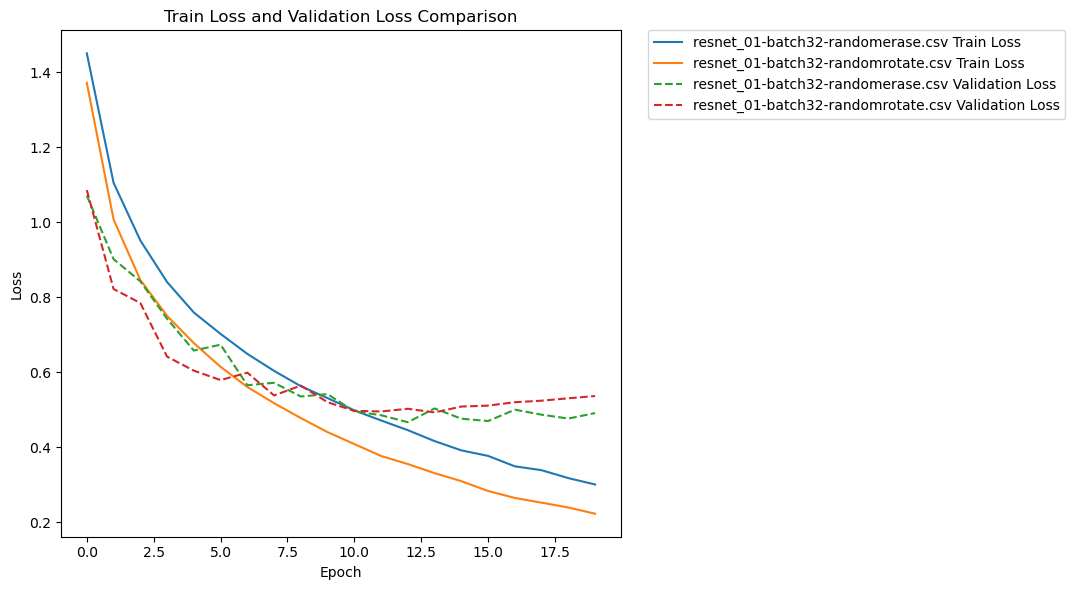

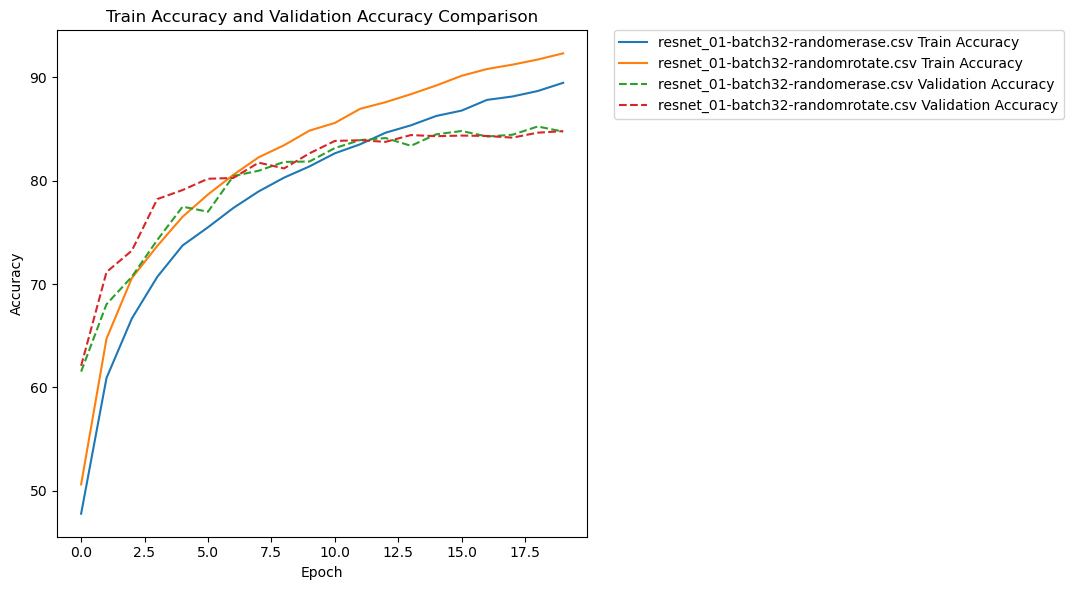

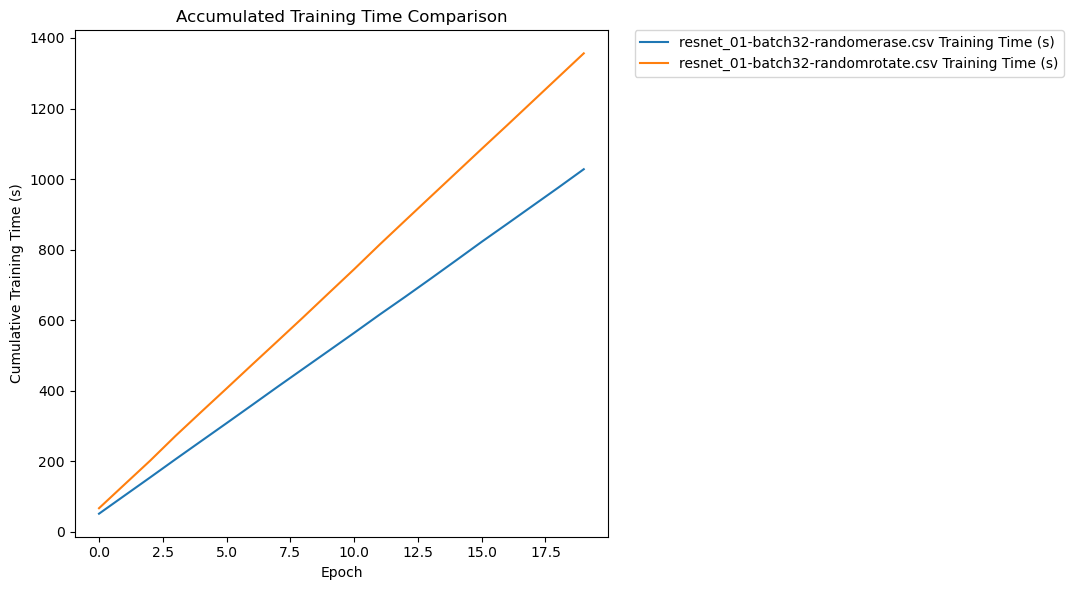

Model resnet_01-batch32-randomerase.csv:
  Highest Validation Accuracy: 85.25
  Epoch at Highest Validation Accuracy: 19
  Total Time to Reach Highest Validation Accuracy: 975.75 seconds

Model resnet_01-batch32-randomrotate.csv:
  Highest Validation Accuracy: 84.80
  Epoch at Highest Validation Accuracy: 20
  Total Time to Reach Highest Validation Accuracy: 1356.46 seconds

Model resnet_01-batch32-randomerase.csv:
  Lowest Validation Loss: 0.467
  Epoch at Lowest Validation Loss: 13
  Total Time to Reach Lowest Validation Loss: 666.17 seconds

Model resnet_01-batch32-randomrotate.csv:
  Lowest Validation Loss: 0.493
  Epoch at Lowest Validation Loss: 14
  Total Time to Reach Lowest Validation Loss: 950.22 seconds



In [43]:
file_paths = [
    "resnet_01-batch32-randomerase.csv",
    "resnet_01-batch32-randomrotate.csv",
]

compare_multi(file_paths)

We can see that random erase helps the model more stable and can reach higher accuracy

### Collor Jitter

In [15]:
# Add normalize
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),  # Converts to tensor and scales to [0, 1]
    transforms.Normalize((0.4911, 0.4821, 0.4466), (0.2023, 0.1995, 0.2010)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), value='random', inplace=False)
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4911, 0.4821, 0.4466), (0.2023, 0.1995, 0.2010))
])

# Reload Datasets
train_dataset = CIFAR10BinaryDataset(train_files, transform=train_transform)
val_dataset = CIFAR10BinaryDataset(val_files, transform=val_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=val_transform)



In [53]:
device = torch.device('cuda')
model = resnet_01().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 32
trainloader, valloader = datasetsloader(batch_size)

model_name='resnet_01-batch32-colorjitter'

train_model(
    model=model,
    train_loader=trainloader,
    val_loader=valloader,
    criterion=criterion,
    optimizer=optimizer, 
    num_epochs=20,
    model_name=model_name,
    csv_filename=f"./logs/{model_name}.csv",
    checkpoint_path=f"./models/{model_name}_check.pth",
    save_model_path=f"./models/{model_name}_best.pth",
    resume=False,
    save_best_on="accuracy")


Epoch 1/20: 100%|██████████| 1250/1250 [01:24<00:00, 14.73batch/s]


Epoch [1/20] Train Loss: 1.4845, Train Accuracy: 46.28%, Validation Loss: 1.0859, Validation Accuracy: 61.54%, Min Val Acc: 38.40%, Max Val Acc: 74.80%, Median Val Acc: 66.75%, Training Time: 84.85s, Validation Time: 7.75s
Model saved with validation accuracy: 61.54%
Checkpoint saved at epoch 1


Epoch 2/20: 100%|██████████| 1250/1250 [01:24<00:00, 14.86batch/s]


Epoch [2/20] Train Loss: 1.1346, Train Accuracy: 59.91%, Validation Loss: 0.9073, Validation Accuracy: 67.90%, Min Val Acc: 39.40%, Max Val Acc: 88.50%, Median Val Acc: 69.10%, Training Time: 84.12s, Validation Time: 8.35s
Model saved with validation accuracy: 67.90%
Checkpoint saved at epoch 2


Epoch 3/20: 100%|██████████| 1250/1250 [01:22<00:00, 15.08batch/s]


Epoch [3/20] Train Loss: 0.9753, Train Accuracy: 65.91%, Validation Loss: 0.7763, Validation Accuracy: 73.01%, Min Val Acc: 50.90%, Max Val Acc: 91.80%, Median Val Acc: 75.60%, Training Time: 82.91s, Validation Time: 8.24s
Model saved with validation accuracy: 73.01%
Checkpoint saved at epoch 3


Epoch 4/20: 100%|██████████| 1250/1250 [01:25<00:00, 14.58batch/s]


Epoch [4/20] Train Loss: 0.8605, Train Accuracy: 69.78%, Validation Loss: 0.7078, Validation Accuracy: 75.77%, Min Val Acc: 58.30%, Max Val Acc: 89.60%, Median Val Acc: 76.80%, Training Time: 85.76s, Validation Time: 8.03s
Model saved with validation accuracy: 75.77%
Checkpoint saved at epoch 4


Epoch 5/20: 100%|██████████| 1250/1250 [01:23<00:00, 14.89batch/s]


Epoch [5/20] Train Loss: 0.7861, Train Accuracy: 72.79%, Validation Loss: 0.6926, Validation Accuracy: 76.38%, Min Val Acc: 47.30%, Max Val Acc: 92.90%, Median Val Acc: 79.30%, Training Time: 83.94s, Validation Time: 7.62s
Model saved with validation accuracy: 76.38%
Checkpoint saved at epoch 5


Epoch 6/20: 100%|██████████| 1250/1250 [01:25<00:00, 14.66batch/s]


Epoch [6/20] Train Loss: 0.7168, Train Accuracy: 75.21%, Validation Loss: 0.5724, Validation Accuracy: 80.40%, Min Val Acc: 63.90%, Max Val Acc: 91.00%, Median Val Acc: 82.85%, Training Time: 85.27s, Validation Time: 8.28s
Model saved with validation accuracy: 80.40%
Checkpoint saved at epoch 6


Epoch 7/20: 100%|██████████| 1250/1250 [01:24<00:00, 14.81batch/s]


Epoch [7/20] Train Loss: 0.6696, Train Accuracy: 76.64%, Validation Loss: 0.6056, Validation Accuracy: 79.05%, Min Val Acc: 51.70%, Max Val Acc: 93.90%, Median Val Acc: 81.10%, Training Time: 84.38s, Validation Time: 7.63s
Checkpoint saved at epoch 7


Epoch 8/20: 100%|██████████| 1250/1250 [01:23<00:00, 14.89batch/s]


Epoch [8/20] Train Loss: 0.6247, Train Accuracy: 78.34%, Validation Loss: 0.5594, Validation Accuracy: 80.80%, Min Val Acc: 57.80%, Max Val Acc: 95.40%, Median Val Acc: 82.30%, Training Time: 83.99s, Validation Time: 8.28s
Model saved with validation accuracy: 80.80%
Checkpoint saved at epoch 8


Epoch 9/20: 100%|██████████| 1250/1250 [01:24<00:00, 14.84batch/s]


Epoch [9/20] Train Loss: 0.5846, Train Accuracy: 79.61%, Validation Loss: 0.5272, Validation Accuracy: 81.86%, Min Val Acc: 62.10%, Max Val Acc: 92.70%, Median Val Acc: 83.25%, Training Time: 84.21s, Validation Time: 8.30s
Model saved with validation accuracy: 81.86%
Checkpoint saved at epoch 9


Epoch 10/20: 100%|██████████| 1250/1250 [01:23<00:00, 14.93batch/s]


Epoch [10/20] Train Loss: 0.5614, Train Accuracy: 80.46%, Validation Loss: 0.5131, Validation Accuracy: 82.57%, Min Val Acc: 68.00%, Max Val Acc: 93.00%, Median Val Acc: 83.75%, Training Time: 83.72s, Validation Time: 8.05s
Model saved with validation accuracy: 82.57%
Checkpoint saved at epoch 10


Epoch 11/20: 100%|██████████| 1250/1250 [01:26<00:00, 14.50batch/s]


Epoch [11/20] Train Loss: 0.5266, Train Accuracy: 81.69%, Validation Loss: 0.4876, Validation Accuracy: 83.38%, Min Val Acc: 64.10%, Max Val Acc: 92.90%, Median Val Acc: 84.80%, Training Time: 86.21s, Validation Time: 8.35s
Model saved with validation accuracy: 83.38%
Checkpoint saved at epoch 11


Epoch 12/20: 100%|██████████| 1250/1250 [01:27<00:00, 14.28batch/s]


Epoch [12/20] Train Loss: 0.4973, Train Accuracy: 82.57%, Validation Loss: 0.4971, Validation Accuracy: 83.00%, Min Val Acc: 70.50%, Max Val Acc: 94.40%, Median Val Acc: 84.25%, Training Time: 87.52s, Validation Time: 8.19s
Checkpoint saved at epoch 12


Epoch 13/20: 100%|██████████| 1250/1250 [01:23<00:00, 15.03batch/s]


Epoch [13/20] Train Loss: 0.4730, Train Accuracy: 83.58%, Validation Loss: 0.4862, Validation Accuracy: 83.81%, Min Val Acc: 69.30%, Max Val Acc: 95.30%, Median Val Acc: 84.70%, Training Time: 83.16s, Validation Time: 8.48s
Model saved with validation accuracy: 83.81%
Checkpoint saved at epoch 13


Epoch 14/20: 100%|██████████| 1250/1250 [01:25<00:00, 14.69batch/s]


Epoch [14/20] Train Loss: 0.4484, Train Accuracy: 84.41%, Validation Loss: 0.4847, Validation Accuracy: 84.32%, Min Val Acc: 61.60%, Max Val Acc: 93.60%, Median Val Acc: 86.50%, Training Time: 85.11s, Validation Time: 7.46s
Model saved with validation accuracy: 84.32%
Checkpoint saved at epoch 14


Epoch 15/20: 100%|██████████| 1250/1250 [01:25<00:00, 14.64batch/s]


Epoch [15/20] Train Loss: 0.4236, Train Accuracy: 85.20%, Validation Loss: 0.4610, Validation Accuracy: 84.53%, Min Val Acc: 70.90%, Max Val Acc: 93.30%, Median Val Acc: 86.95%, Training Time: 85.36s, Validation Time: 7.74s
Model saved with validation accuracy: 84.53%
Checkpoint saved at epoch 15


Epoch 16/20: 100%|██████████| 1250/1250 [01:22<00:00, 15.08batch/s]


Epoch [16/20] Train Loss: 0.4088, Train Accuracy: 85.62%, Validation Loss: 0.4756, Validation Accuracy: 84.93%, Min Val Acc: 70.40%, Max Val Acc: 93.10%, Median Val Acc: 89.00%, Training Time: 82.90s, Validation Time: 8.25s
Model saved with validation accuracy: 84.93%
Checkpoint saved at epoch 16


Epoch 17/20: 100%|██████████| 1250/1250 [01:24<00:00, 14.85batch/s]


Epoch [17/20] Train Loss: 0.3871, Train Accuracy: 86.47%, Validation Loss: 0.4623, Validation Accuracy: 85.24%, Min Val Acc: 71.90%, Max Val Acc: 93.70%, Median Val Acc: 87.30%, Training Time: 84.18s, Validation Time: 8.84s
Model saved with validation accuracy: 85.24%
Checkpoint saved at epoch 17


Epoch 18/20: 100%|██████████| 1250/1250 [01:25<00:00, 14.67batch/s]


Epoch [18/20] Train Loss: 0.3658, Train Accuracy: 87.28%, Validation Loss: 0.4561, Validation Accuracy: 85.22%, Min Val Acc: 74.30%, Max Val Acc: 93.50%, Median Val Acc: 86.45%, Training Time: 85.20s, Validation Time: 8.29s
Checkpoint saved at epoch 18


Epoch 19/20: 100%|██████████| 1250/1250 [01:24<00:00, 14.79batch/s]


Epoch [19/20] Train Loss: 0.3525, Train Accuracy: 87.80%, Validation Loss: 0.4684, Validation Accuracy: 84.83%, Min Val Acc: 72.40%, Max Val Acc: 94.30%, Median Val Acc: 86.65%, Training Time: 84.51s, Validation Time: 8.20s
Checkpoint saved at epoch 19


Epoch 20/20: 100%|██████████| 1250/1250 [01:23<00:00, 14.92batch/s]


Epoch [20/20] Train Loss: 0.3366, Train Accuracy: 88.21%, Validation Loss: 0.4841, Validation Accuracy: 85.27%, Min Val Acc: 69.80%, Max Val Acc: 93.90%, Median Val Acc: 87.10%, Training Time: 83.79s, Validation Time: 7.75s
Model saved with validation accuracy: 85.27%
Checkpoint saved at epoch 20


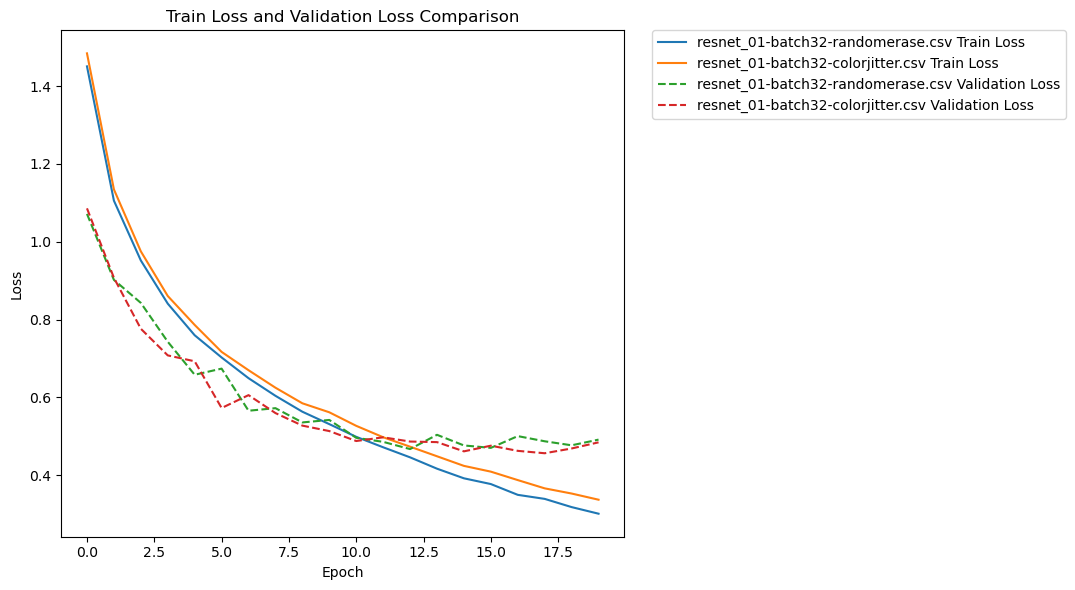

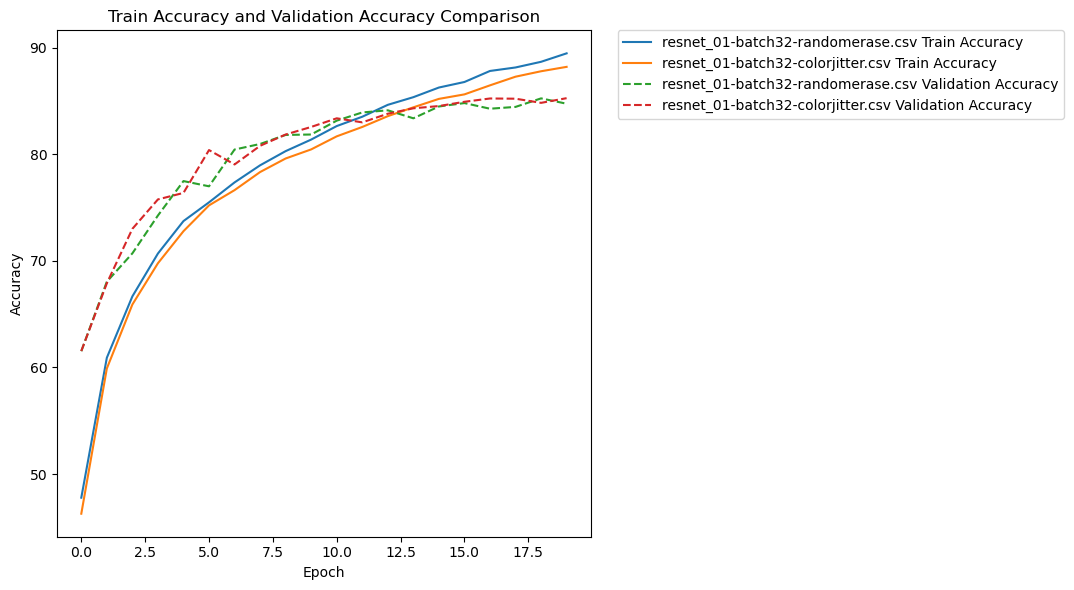

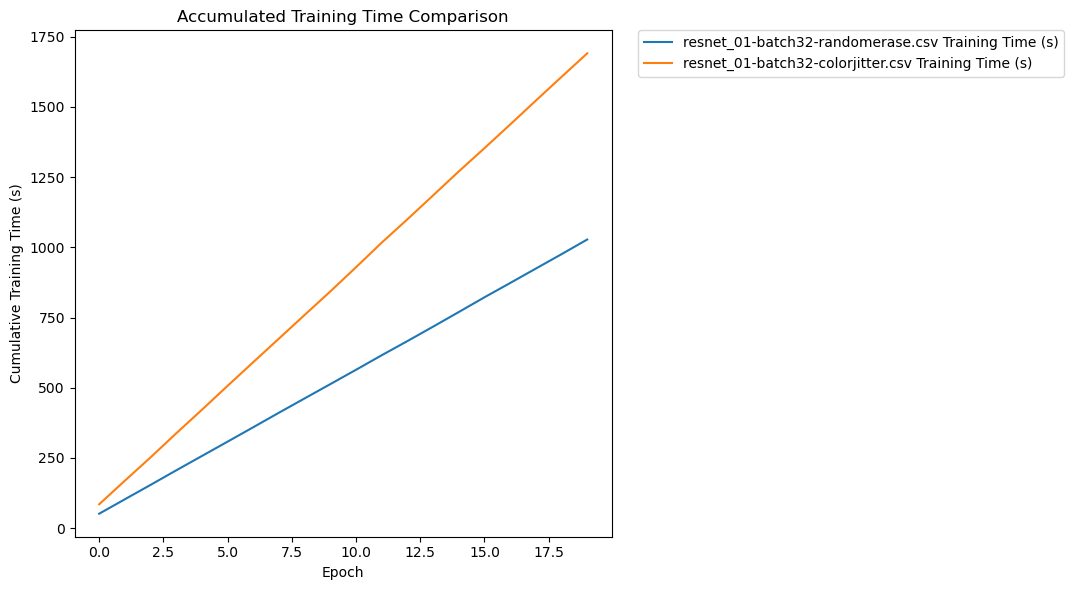

Model resnet_01-batch32-randomerase.csv:
  Highest Validation Accuracy: 85.25
  Epoch at Highest Validation Accuracy: 19
  Total Time to Reach Highest Validation Accuracy: 975.75 seconds

Model resnet_01-batch32-colorjitter.csv:
  Highest Validation Accuracy: 85.27
  Epoch at Highest Validation Accuracy: 20
  Total Time to Reach Highest Validation Accuracy: 1691.10 seconds

Model resnet_01-batch32-randomerase.csv:
  Lowest Validation Loss: 0.467
  Epoch at Lowest Validation Loss: 13
  Total Time to Reach Lowest Validation Loss: 666.17 seconds

Model resnet_01-batch32-colorjitter.csv:
  Lowest Validation Loss: 0.456
  Epoch at Lowest Validation Loss: 18
  Total Time to Reach Lowest Validation Loss: 1522.79 seconds



In [44]:
file_paths = [
    "resnet_01-batch32-randomerase.csv",
    "resnet_01-batch32-colorjitter.csv",
]

compare_multi(file_paths)

Color Jitter makes the model be more stable.

### Adjust the learning rate

In [56]:
device = torch.device('cuda')
model = resnet_01().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.005)

batch_size = 32
trainloader, valloader = datasetsloader(batch_size)

model_name='resnet_01-batch32-colorjitter-lr005'

train_model(
    model=model,
    train_loader=trainloader,
    val_loader=valloader,
    criterion=criterion,
    optimizer=optimizer, 
    num_epochs=20,
    model_name=model_name,
    csv_filename=f"./logs/{model_name}.csv",
    checkpoint_path=f"./models/{model_name}_check.pth",
    save_model_path=f"./models/{model_name}_best.pth",
    resume=False,
    save_best_on="accuracy")


Epoch 1/20: 100%|██████████| 1250/1250 [01:24<00:00, 14.71batch/s]


Epoch [1/20] Train Loss: 1.6779, Train Accuracy: 38.42%, Validation Loss: 1.3367, Validation Accuracy: 53.13%, Min Val Acc: 27.30%, Max Val Acc: 77.20%, Median Val Acc: 52.40%, Training Time: 84.97s, Validation Time: 7.46s
Model saved with validation accuracy: 53.13%
Checkpoint saved at epoch 1


Epoch 2/20: 100%|██████████| 1250/1250 [01:22<00:00, 15.10batch/s]


Epoch [2/20] Train Loss: 1.2994, Train Accuracy: 53.70%, Validation Loss: 1.0979, Validation Accuracy: 60.51%, Min Val Acc: 19.20%, Max Val Acc: 82.90%, Median Val Acc: 59.05%, Training Time: 82.80s, Validation Time: 7.79s
Model saved with validation accuracy: 60.51%
Checkpoint saved at epoch 2


Epoch 3/20: 100%|██████████| 1250/1250 [01:24<00:00, 14.84batch/s]


Epoch [3/20] Train Loss: 1.1301, Train Accuracy: 59.74%, Validation Loss: 0.8924, Validation Accuracy: 67.88%, Min Val Acc: 49.60%, Max Val Acc: 85.90%, Median Val Acc: 69.05%, Training Time: 84.22s, Validation Time: 8.06s
Model saved with validation accuracy: 67.88%
Checkpoint saved at epoch 3


Epoch 4/20: 100%|██████████| 1250/1250 [01:25<00:00, 14.69batch/s]


Epoch [4/20] Train Loss: 0.9955, Train Accuracy: 64.89%, Validation Loss: 0.8133, Validation Accuracy: 71.42%, Min Val Acc: 51.20%, Max Val Acc: 84.60%, Median Val Acc: 73.45%, Training Time: 85.06s, Validation Time: 8.32s
Model saved with validation accuracy: 71.42%
Checkpoint saved at epoch 4


Epoch 5/20: 100%|██████████| 1250/1250 [01:23<00:00, 15.04batch/s]


Epoch [5/20] Train Loss: 0.8937, Train Accuracy: 68.66%, Validation Loss: 0.7447, Validation Accuracy: 74.14%, Min Val Acc: 41.30%, Max Val Acc: 90.60%, Median Val Acc: 81.30%, Training Time: 83.10s, Validation Time: 7.88s
Model saved with validation accuracy: 74.14%
Checkpoint saved at epoch 5


Epoch 6/20: 100%|██████████| 1250/1250 [01:23<00:00, 14.91batch/s]


Epoch [6/20] Train Loss: 0.8175, Train Accuracy: 71.33%, Validation Loss: 0.6563, Validation Accuracy: 77.33%, Min Val Acc: 61.40%, Max Val Acc: 90.90%, Median Val Acc: 78.10%, Training Time: 83.86s, Validation Time: 7.45s
Model saved with validation accuracy: 77.33%
Checkpoint saved at epoch 6


Epoch 7/20: 100%|██████████| 1250/1250 [01:23<00:00, 14.95batch/s]


Epoch [7/20] Train Loss: 0.7478, Train Accuracy: 74.00%, Validation Loss: 0.6327, Validation Accuracy: 78.54%, Min Val Acc: 53.70%, Max Val Acc: 89.80%, Median Val Acc: 81.30%, Training Time: 83.62s, Validation Time: 8.06s
Model saved with validation accuracy: 78.54%
Checkpoint saved at epoch 7


Epoch 8/20: 100%|██████████| 1250/1250 [01:24<00:00, 14.72batch/s]


Epoch [8/20] Train Loss: 0.7022, Train Accuracy: 75.35%, Validation Loss: 0.6008, Validation Accuracy: 79.53%, Min Val Acc: 54.30%, Max Val Acc: 90.80%, Median Val Acc: 85.50%, Training Time: 84.90s, Validation Time: 7.45s
Model saved with validation accuracy: 79.53%
Checkpoint saved at epoch 8


Epoch 9/20: 100%|██████████| 1250/1250 [01:23<00:00, 14.92batch/s]


Epoch [9/20] Train Loss: 0.6530, Train Accuracy: 77.40%, Validation Loss: 0.6257, Validation Accuracy: 78.21%, Min Val Acc: 52.90%, Max Val Acc: 88.20%, Median Val Acc: 81.30%, Training Time: 83.78s, Validation Time: 8.27s
Checkpoint saved at epoch 9


Epoch 10/20: 100%|██████████| 1250/1250 [01:23<00:00, 14.94batch/s]


Epoch [10/20] Train Loss: 0.6249, Train Accuracy: 78.14%, Validation Loss: 0.5587, Validation Accuracy: 80.90%, Min Val Acc: 57.50%, Max Val Acc: 95.80%, Median Val Acc: 87.00%, Training Time: 83.70s, Validation Time: 8.28s
Model saved with validation accuracy: 80.90%
Checkpoint saved at epoch 10


Epoch 11/20: 100%|██████████| 1250/1250 [01:24<00:00, 14.81batch/s]


Epoch [11/20] Train Loss: 0.5856, Train Accuracy: 79.62%, Validation Loss: 0.5556, Validation Accuracy: 81.07%, Min Val Acc: 70.60%, Max Val Acc: 92.50%, Median Val Acc: 81.50%, Training Time: 84.42s, Validation Time: 8.08s
Model saved with validation accuracy: 81.07%
Checkpoint saved at epoch 11


Epoch 12/20: 100%|██████████| 1250/1250 [01:25<00:00, 14.63batch/s]


Epoch [12/20] Train Loss: 0.5546, Train Accuracy: 80.78%, Validation Loss: 0.5367, Validation Accuracy: 81.74%, Min Val Acc: 67.90%, Max Val Acc: 91.80%, Median Val Acc: 83.80%, Training Time: 85.45s, Validation Time: 7.40s
Model saved with validation accuracy: 81.74%
Checkpoint saved at epoch 12


Epoch 13/20: 100%|██████████| 1250/1250 [01:24<00:00, 14.73batch/s]


Epoch [13/20] Train Loss: 0.5279, Train Accuracy: 81.64%, Validation Loss: 0.5299, Validation Accuracy: 81.96%, Min Val Acc: 70.30%, Max Val Acc: 92.20%, Median Val Acc: 80.65%, Training Time: 84.87s, Validation Time: 7.72s
Model saved with validation accuracy: 81.96%
Checkpoint saved at epoch 13


Epoch 14/20: 100%|██████████| 1250/1250 [01:24<00:00, 14.73batch/s]


Epoch [14/20] Train Loss: 0.5021, Train Accuracy: 82.39%, Validation Loss: 0.5078, Validation Accuracy: 82.95%, Min Val Acc: 70.50%, Max Val Acc: 94.20%, Median Val Acc: 84.00%, Training Time: 84.88s, Validation Time: 7.76s
Model saved with validation accuracy: 82.95%
Checkpoint saved at epoch 14


Epoch 15/20: 100%|██████████| 1250/1250 [01:25<00:00, 14.69batch/s]


Epoch [15/20] Train Loss: 0.4846, Train Accuracy: 83.08%, Validation Loss: 0.4750, Validation Accuracy: 83.63%, Min Val Acc: 64.70%, Max Val Acc: 92.30%, Median Val Acc: 86.60%, Training Time: 85.11s, Validation Time: 7.64s
Model saved with validation accuracy: 83.63%
Checkpoint saved at epoch 15


Epoch 16/20: 100%|██████████| 1250/1250 [01:25<00:00, 14.60batch/s]


Epoch [16/20] Train Loss: 0.4594, Train Accuracy: 83.77%, Validation Loss: 0.4782, Validation Accuracy: 83.82%, Min Val Acc: 57.70%, Max Val Acc: 93.70%, Median Val Acc: 87.20%, Training Time: 85.64s, Validation Time: 7.99s
Model saved with validation accuracy: 83.82%
Checkpoint saved at epoch 16


Epoch 17/20: 100%|██████████| 1250/1250 [01:25<00:00, 14.68batch/s]


Epoch [17/20] Train Loss: 0.4415, Train Accuracy: 84.55%, Validation Loss: 0.4933, Validation Accuracy: 83.98%, Min Val Acc: 68.70%, Max Val Acc: 94.40%, Median Val Acc: 86.65%, Training Time: 85.18s, Validation Time: 8.25s
Model saved with validation accuracy: 83.98%
Checkpoint saved at epoch 17


Epoch 18/20: 100%|██████████| 1250/1250 [01:26<00:00, 14.41batch/s]


Epoch [18/20] Train Loss: 0.4217, Train Accuracy: 85.12%, Validation Loss: 0.5039, Validation Accuracy: 83.94%, Min Val Acc: 68.90%, Max Val Acc: 96.00%, Median Val Acc: 83.50%, Training Time: 86.75s, Validation Time: 8.45s
Checkpoint saved at epoch 18


Epoch 19/20: 100%|██████████| 1250/1250 [01:25<00:00, 14.68batch/s]


Epoch [19/20] Train Loss: 0.4047, Train Accuracy: 85.90%, Validation Loss: 0.5188, Validation Accuracy: 83.75%, Min Val Acc: 69.50%, Max Val Acc: 95.00%, Median Val Acc: 84.35%, Training Time: 85.14s, Validation Time: 8.01s
Checkpoint saved at epoch 19


Epoch 20/20: 100%|██████████| 1250/1250 [01:25<00:00, 14.62batch/s]


Epoch [20/20] Train Loss: 0.3872, Train Accuracy: 86.42%, Validation Loss: 0.4803, Validation Accuracy: 84.59%, Min Val Acc: 75.20%, Max Val Acc: 92.30%, Median Val Acc: 84.65%, Training Time: 85.50s, Validation Time: 8.25s
Model saved with validation accuracy: 84.59%
Checkpoint saved at epoch 20


In [60]:
device = torch.device('cuda')
model = resnet_01().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.0005)

batch_size = 32
trainloader, valloader = datasetsloader(batch_size)

model_name='resnet_01-batch32-colorjitter-lr0005'

train_model(
    model=model,
    train_loader=trainloader,
    val_loader=valloader,
    criterion=criterion,
    optimizer=optimizer, 
    num_epochs=20,
    model_name=model_name,
    csv_filename=f"./logs/{model_name}.csv",
    checkpoint_path=f"./models/{model_name}_check.pth",
    save_model_path=f"./models/{model_name}_best.pth",
    resume=False,
    save_best_on="accuracy")


Epoch 1/20: 100%|██████████| 1250/1250 [01:22<00:00, 15.10batch/s]


Epoch [1/20] Train Loss: 1.4500, Train Accuracy: 47.77%, Validation Loss: 1.1144, Validation Accuracy: 60.75%, Min Val Acc: 27.80%, Max Val Acc: 84.10%, Median Val Acc: 65.50%, Training Time: 82.80s, Validation Time: 8.26s
Model saved with validation accuracy: 60.75%
Checkpoint saved at epoch 1


Epoch 2/20: 100%|██████████| 1250/1250 [01:23<00:00, 15.00batch/s]


Epoch [2/20] Train Loss: 1.1074, Train Accuracy: 60.61%, Validation Loss: 0.9014, Validation Accuracy: 67.95%, Min Val Acc: 48.60%, Max Val Acc: 80.70%, Median Val Acc: 70.40%, Training Time: 83.32s, Validation Time: 8.38s
Model saved with validation accuracy: 67.95%
Checkpoint saved at epoch 2


Epoch 3/20: 100%|██████████| 1250/1250 [01:26<00:00, 14.50batch/s]


Epoch [3/20] Train Loss: 0.9652, Train Accuracy: 66.06%, Validation Loss: 0.7439, Validation Accuracy: 74.38%, Min Val Acc: 55.10%, Max Val Acc: 84.90%, Median Val Acc: 79.25%, Training Time: 86.21s, Validation Time: 8.50s
Model saved with validation accuracy: 74.38%
Checkpoint saved at epoch 3


Epoch 4/20: 100%|██████████| 1250/1250 [01:24<00:00, 14.82batch/s]


Epoch [4/20] Train Loss: 0.8573, Train Accuracy: 70.10%, Validation Loss: 0.6965, Validation Accuracy: 75.85%, Min Val Acc: 61.70%, Max Val Acc: 91.10%, Median Val Acc: 75.30%, Training Time: 84.33s, Validation Time: 7.89s
Model saved with validation accuracy: 75.85%
Checkpoint saved at epoch 4


Epoch 5/20: 100%|██████████| 1250/1250 [01:22<00:00, 15.22batch/s]


Epoch [5/20] Train Loss: 0.7866, Train Accuracy: 72.61%, Validation Loss: 0.7215, Validation Accuracy: 74.93%, Min Val Acc: 39.80%, Max Val Acc: 95.20%, Median Val Acc: 79.45%, Training Time: 82.14s, Validation Time: 7.98s
Checkpoint saved at epoch 5


Epoch 6/20: 100%|██████████| 1250/1250 [01:22<00:00, 15.15batch/s]


Epoch [6/20] Train Loss: 0.7282, Train Accuracy: 74.59%, Validation Loss: 0.6429, Validation Accuracy: 77.63%, Min Val Acc: 39.30%, Max Val Acc: 92.10%, Median Val Acc: 83.20%, Training Time: 82.52s, Validation Time: 8.22s
Model saved with validation accuracy: 77.63%
Checkpoint saved at epoch 6


Epoch 7/20: 100%|██████████| 1250/1250 [01:22<00:00, 15.18batch/s]


Epoch [7/20] Train Loss: 0.6835, Train Accuracy: 75.90%, Validation Loss: 0.5922, Validation Accuracy: 79.86%, Min Val Acc: 63.70%, Max Val Acc: 94.30%, Median Val Acc: 80.95%, Training Time: 82.34s, Validation Time: 8.18s
Model saved with validation accuracy: 79.86%
Checkpoint saved at epoch 7


Epoch 8/20: 100%|██████████| 1250/1250 [01:24<00:00, 14.87batch/s]


Epoch [8/20] Train Loss: 0.6382, Train Accuracy: 77.83%, Validation Loss: 0.5982, Validation Accuracy: 79.68%, Min Val Acc: 63.70%, Max Val Acc: 94.20%, Median Val Acc: 78.75%, Training Time: 84.06s, Validation Time: 7.97s
Checkpoint saved at epoch 8


Epoch 9/20: 100%|██████████| 1250/1250 [01:24<00:00, 14.88batch/s]


Epoch [9/20] Train Loss: 0.6015, Train Accuracy: 79.11%, Validation Loss: 0.4999, Validation Accuracy: 82.79%, Min Val Acc: 68.20%, Max Val Acc: 94.20%, Median Val Acc: 84.90%, Training Time: 84.03s, Validation Time: 7.37s
Model saved with validation accuracy: 82.79%
Checkpoint saved at epoch 9


Epoch 10/20: 100%|██████████| 1250/1250 [01:23<00:00, 14.97batch/s]


Epoch [10/20] Train Loss: 0.5677, Train Accuracy: 80.29%, Validation Loss: 0.5257, Validation Accuracy: 81.93%, Min Val Acc: 65.60%, Max Val Acc: 92.80%, Median Val Acc: 84.45%, Training Time: 83.50s, Validation Time: 7.40s
Checkpoint saved at epoch 10


Epoch 11/20: 100%|██████████| 1250/1250 [01:23<00:00, 15.02batch/s]


Epoch [11/20] Train Loss: 0.5401, Train Accuracy: 81.12%, Validation Loss: 0.5224, Validation Accuracy: 82.42%, Min Val Acc: 67.40%, Max Val Acc: 94.30%, Median Val Acc: 86.00%, Training Time: 83.25s, Validation Time: 8.37s
Checkpoint saved at epoch 11


Epoch 12/20: 100%|██████████| 1250/1250 [01:23<00:00, 15.04batch/s]


Epoch [12/20] Train Loss: 0.5168, Train Accuracy: 81.96%, Validation Loss: 0.5107, Validation Accuracy: 82.94%, Min Val Acc: 66.40%, Max Val Acc: 95.00%, Median Val Acc: 85.00%, Training Time: 83.11s, Validation Time: 8.05s
Model saved with validation accuracy: 82.94%
Checkpoint saved at epoch 12


Epoch 13/20: 100%|██████████| 1250/1250 [01:22<00:00, 15.07batch/s]


Epoch [13/20] Train Loss: 0.4866, Train Accuracy: 83.28%, Validation Loss: 0.4926, Validation Accuracy: 83.19%, Min Val Acc: 67.70%, Max Val Acc: 94.40%, Median Val Acc: 83.70%, Training Time: 82.97s, Validation Time: 7.63s
Model saved with validation accuracy: 83.19%
Checkpoint saved at epoch 13


Epoch 14/20: 100%|██████████| 1250/1250 [01:23<00:00, 14.95batch/s]


Epoch [14/20] Train Loss: 0.4601, Train Accuracy: 83.90%, Validation Loss: 0.4796, Validation Accuracy: 83.85%, Min Val Acc: 65.70%, Max Val Acc: 94.30%, Median Val Acc: 83.75%, Training Time: 83.64s, Validation Time: 7.44s
Model saved with validation accuracy: 83.85%
Checkpoint saved at epoch 14


Epoch 15/20: 100%|██████████| 1250/1250 [01:23<00:00, 14.96batch/s]


Epoch [15/20] Train Loss: 0.4417, Train Accuracy: 84.45%, Validation Loss: 0.4607, Validation Accuracy: 84.64%, Min Val Acc: 62.40%, Max Val Acc: 93.10%, Median Val Acc: 87.35%, Training Time: 83.59s, Validation Time: 8.29s
Model saved with validation accuracy: 84.64%
Checkpoint saved at epoch 15


Epoch 16/20: 100%|██████████| 1250/1250 [01:25<00:00, 14.59batch/s]


Epoch [16/20] Train Loss: 0.4255, Train Accuracy: 85.06%, Validation Loss: 0.4815, Validation Accuracy: 83.97%, Min Val Acc: 63.60%, Max Val Acc: 93.10%, Median Val Acc: 86.05%, Training Time: 85.66s, Validation Time: 8.54s
Checkpoint saved at epoch 16


Epoch 17/20: 100%|██████████| 1250/1250 [01:24<00:00, 14.82batch/s]


Epoch [17/20] Train Loss: 0.4000, Train Accuracy: 85.96%, Validation Loss: 0.4648, Validation Accuracy: 84.91%, Min Val Acc: 68.80%, Max Val Acc: 93.60%, Median Val Acc: 84.70%, Training Time: 84.34s, Validation Time: 8.59s
Model saved with validation accuracy: 84.91%
Checkpoint saved at epoch 17


Epoch 18/20: 100%|██████████| 1250/1250 [01:25<00:00, 14.63batch/s]


Epoch [18/20] Train Loss: 0.3862, Train Accuracy: 86.40%, Validation Loss: 0.4645, Validation Accuracy: 84.82%, Min Val Acc: 71.40%, Max Val Acc: 93.80%, Median Val Acc: 86.55%, Training Time: 85.44s, Validation Time: 8.46s
Checkpoint saved at epoch 18


Epoch 19/20: 100%|██████████| 1250/1250 [01:24<00:00, 14.72batch/s]


Epoch [19/20] Train Loss: 0.3674, Train Accuracy: 87.06%, Validation Loss: 0.4695, Validation Accuracy: 85.02%, Min Val Acc: 73.20%, Max Val Acc: 95.20%, Median Val Acc: 85.60%, Training Time: 84.94s, Validation Time: 8.05s
Model saved with validation accuracy: 85.02%
Checkpoint saved at epoch 19


Epoch 20/20: 100%|██████████| 1250/1250 [01:25<00:00, 14.65batch/s]


Epoch [20/20] Train Loss: 0.3526, Train Accuracy: 87.65%, Validation Loss: 0.4670, Validation Accuracy: 85.12%, Min Val Acc: 66.00%, Max Val Acc: 95.20%, Median Val Acc: 84.75%, Training Time: 85.31s, Validation Time: 8.02s
Model saved with validation accuracy: 85.12%
Checkpoint saved at epoch 20


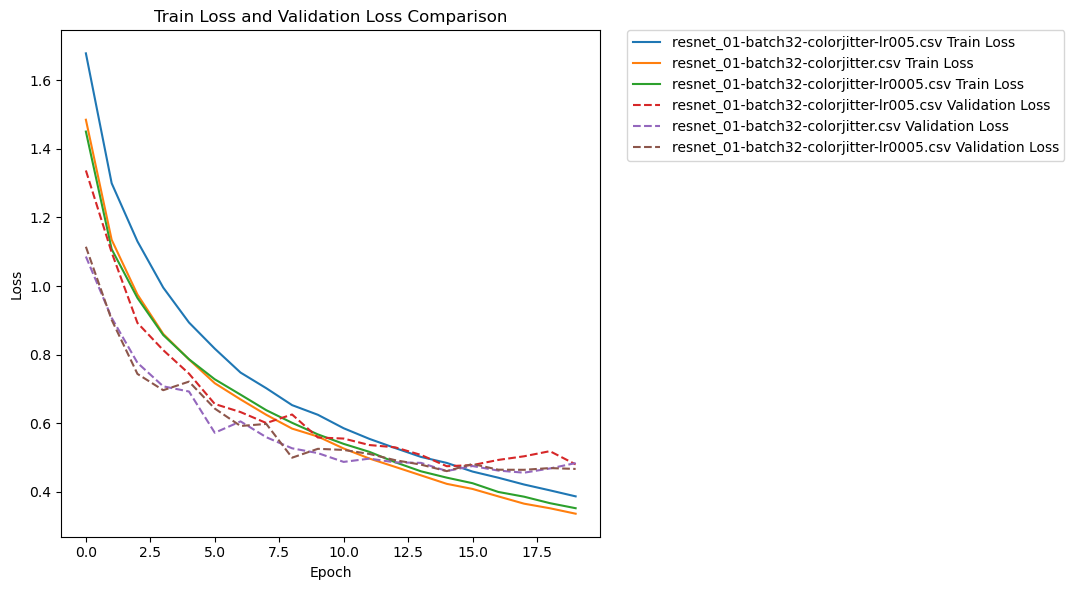

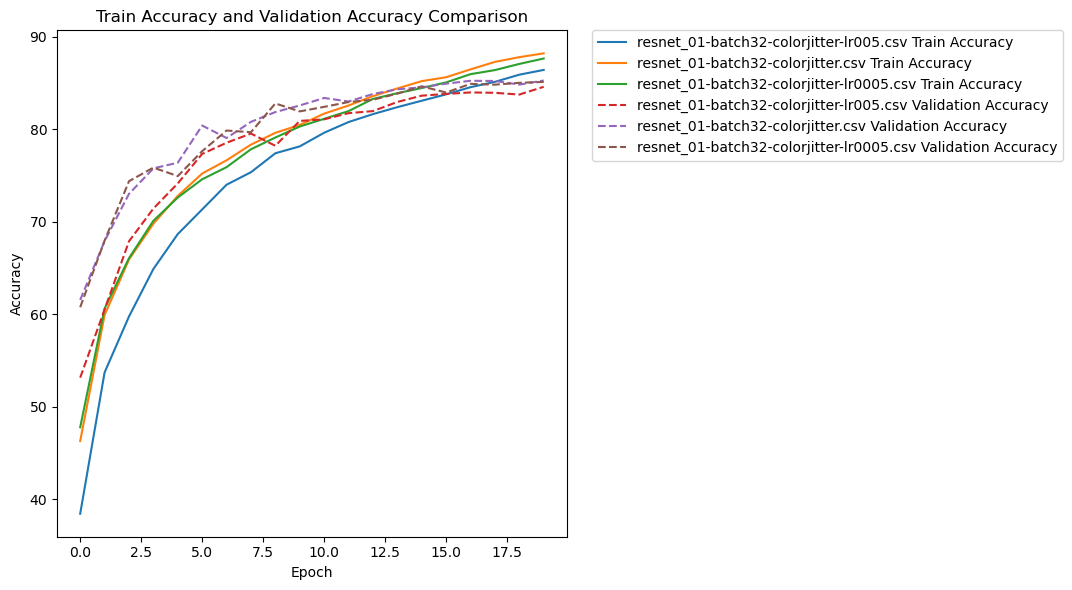

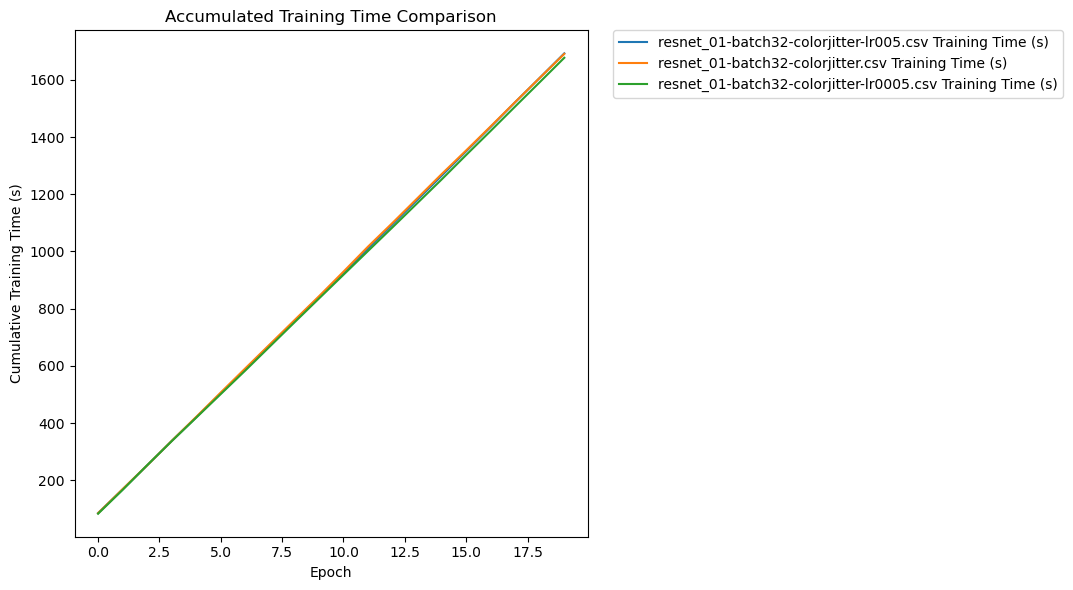

Model resnet_01-batch32-colorjitter-lr005.csv:
  Highest Validation Accuracy: 84.59
  Epoch at Highest Validation Accuracy: 20
  Total Time to Reach Highest Validation Accuracy: 1692.93 seconds

Model resnet_01-batch32-colorjitter.csv:
  Highest Validation Accuracy: 85.27
  Epoch at Highest Validation Accuracy: 20
  Total Time to Reach Highest Validation Accuracy: 1691.10 seconds

Model resnet_01-batch32-colorjitter-lr0005.csv:
  Highest Validation Accuracy: 85.12
  Epoch at Highest Validation Accuracy: 20
  Total Time to Reach Highest Validation Accuracy: 1677.49 seconds

Model resnet_01-batch32-colorjitter-lr005.csv:
  Lowest Validation Loss: 0.475
  Epoch at Lowest Validation Loss: 15
  Total Time to Reach Lowest Validation Loss: 1264.72 seconds

Model resnet_01-batch32-colorjitter.csv:
  Lowest Validation Loss: 0.456
  Epoch at Lowest Validation Loss: 18
  Total Time to Reach Lowest Validation Loss: 1522.79 seconds

Model resnet_01-batch32-colorjitter-lr0005.csv:
  Lowest Validatio

In [46]:
file_paths = [
    "resnet_01-batch32-colorjitter-lr005.csv",
    "resnet_01-batch32-colorjitter.csv",
    "resnet_01-batch32-colorjitter-lr0005.csv",
]

compare_multi(file_paths)

We can see that lr001 and lr0005 has close performance. We will use lr001 with scheduler and use more epoch (50) as the plot indicates that it will give better result in the long run.

### Long Run with Scheduler

In [22]:
def resnet_01(num_classes=10):
    model = models.resnet18(weights=None)
    
    model.conv1 = nn.Conv2d(
        in_channels=3,       # Input channels (RGB)
        out_channels=64,     # Number of filters
        kernel_size=3,       # Smaller kernel size for 32x32
        stride=1,            # Stride of 1 to retain spatial dimensions
        padding=1,           # Padding to maintain output size
        bias=False
    )
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    return model

In [23]:
device = torch.device('cuda')
model = resnet_01().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 32
trainloader, valloader = datasetsloader(batch_size)

model_name='resnet_01-batch32-colorjitter-reducelr'

train_model_reducelr(model=model, train_loader=trainloader, val_loader=valloader, criterion=criterion, optimizer=optimizer, 
                     num_epochs=50, model_name=model_name, csv_filename=f"./logs/{model_name}.csv", 
                     checkpoint_path=f"./models/{model_name}_check.pth", save_model_path=f"./models/{model_name}_check.pth", 
                     resume=False, save_best_on="accuracy", step=0.5, patience=5)

Epoch 1/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.50batch/s]


Epoch [1/50] Train Loss: 1.4836, Train Accuracy: 46.82%, Validation Loss: 1.1942, Validation Accuracy: 58.55%, Min Val Acc: 22.30%, Max Val Acc: 84.40%, Median Val Acc: 59.65%, Training Time: 92.57s, Validation Time: 8.48s, Learning Rate: 0.001000
Model saved with validation accuracy: 58.55%
Checkpoint saved at epoch 1


Epoch 2/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.40batch/s]


Epoch [2/50] Train Loss: 1.1289, Train Accuracy: 59.91%, Validation Loss: 0.8571, Validation Accuracy: 70.18%, Min Val Acc: 53.80%, Max Val Acc: 87.80%, Median Val Acc: 69.95%, Training Time: 93.29s, Validation Time: 8.49s, Learning Rate: 0.001000
Model saved with validation accuracy: 70.18%
Checkpoint saved at epoch 2


Epoch 3/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.48batch/s]


Epoch [3/50] Train Loss: 0.9752, Train Accuracy: 65.98%, Validation Loss: 0.7668, Validation Accuracy: 73.15%, Min Val Acc: 53.00%, Max Val Acc: 91.00%, Median Val Acc: 73.40%, Training Time: 92.72s, Validation Time: 8.52s, Learning Rate: 0.001000
Model saved with validation accuracy: 73.15%
Checkpoint saved at epoch 3


Epoch 4/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.36batch/s]


Epoch [4/50] Train Loss: 0.8679, Train Accuracy: 69.84%, Validation Loss: 0.6800, Validation Accuracy: 76.24%, Min Val Acc: 57.80%, Max Val Acc: 87.80%, Median Val Acc: 77.30%, Training Time: 93.57s, Validation Time: 8.58s, Learning Rate: 0.001000
Model saved with validation accuracy: 76.24%
Checkpoint saved at epoch 4


Epoch 5/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.38batch/s]


Epoch [5/50] Train Loss: 0.7912, Train Accuracy: 72.64%, Validation Loss: 0.6506, Validation Accuracy: 77.62%, Min Val Acc: 58.20%, Max Val Acc: 95.80%, Median Val Acc: 79.65%, Training Time: 93.40s, Validation Time: 8.34s, Learning Rate: 0.001000
Model saved with validation accuracy: 77.62%
Checkpoint saved at epoch 5


Epoch 6/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.43batch/s]


Epoch [6/50] Train Loss: 0.7315, Train Accuracy: 74.50%, Validation Loss: 0.5904, Validation Accuracy: 79.70%, Min Val Acc: 62.70%, Max Val Acc: 93.30%, Median Val Acc: 80.20%, Training Time: 93.05s, Validation Time: 8.31s, Learning Rate: 0.001000
Model saved with validation accuracy: 79.70%
Checkpoint saved at epoch 6


Epoch 7/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.43batch/s]


Epoch [7/50] Train Loss: 0.6838, Train Accuracy: 76.20%, Validation Loss: 0.5544, Validation Accuracy: 80.72%, Min Val Acc: 65.70%, Max Val Acc: 90.70%, Median Val Acc: 82.50%, Training Time: 93.04s, Validation Time: 8.22s, Learning Rate: 0.001000
Model saved with validation accuracy: 80.72%
Checkpoint saved at epoch 7


Epoch 8/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.42batch/s]


Epoch [8/50] Train Loss: 0.6285, Train Accuracy: 78.26%, Validation Loss: 0.5927, Validation Accuracy: 79.50%, Min Val Acc: 62.40%, Max Val Acc: 93.80%, Median Val Acc: 81.30%, Training Time: 93.14s, Validation Time: 8.41s, Learning Rate: 0.001000
Checkpoint saved at epoch 8


Epoch 9/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.49batch/s]


Epoch [9/50] Train Loss: 0.5934, Train Accuracy: 79.39%, Validation Loss: 0.5286, Validation Accuracy: 81.98%, Min Val Acc: 68.60%, Max Val Acc: 94.00%, Median Val Acc: 82.65%, Training Time: 92.68s, Validation Time: 8.82s, Learning Rate: 0.001000
Model saved with validation accuracy: 81.98%
Checkpoint saved at epoch 9


Epoch 10/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:34<00:00, 13.22batch/s]


Epoch [10/50] Train Loss: 0.5617, Train Accuracy: 80.26%, Validation Loss: 0.5473, Validation Accuracy: 81.63%, Min Val Acc: 64.80%, Max Val Acc: 92.40%, Median Val Acc: 80.90%, Training Time: 94.59s, Validation Time: 8.77s, Learning Rate: 0.001000
Checkpoint saved at epoch 10


Epoch 11/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.43batch/s]


Epoch [11/50] Train Loss: 0.5353, Train Accuracy: 81.52%, Validation Loss: 0.5135, Validation Accuracy: 82.45%, Min Val Acc: 53.00%, Max Val Acc: 94.90%, Median Val Acc: 87.15%, Training Time: 93.09s, Validation Time: 8.17s, Learning Rate: 0.001000
Model saved with validation accuracy: 82.45%
Checkpoint saved at epoch 11


Epoch 12/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.54batch/s]


Epoch [12/50] Train Loss: 0.5010, Train Accuracy: 82.57%, Validation Loss: 0.5245, Validation Accuracy: 82.27%, Min Val Acc: 62.50%, Max Val Acc: 94.50%, Median Val Acc: 83.95%, Training Time: 92.35s, Validation Time: 8.36s, Learning Rate: 0.001000
Checkpoint saved at epoch 12


Epoch 13/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.39batch/s]


Epoch [13/50] Train Loss: 0.4800, Train Accuracy: 83.00%, Validation Loss: 0.5421, Validation Accuracy: 81.65%, Min Val Acc: 65.10%, Max Val Acc: 92.50%, Median Val Acc: 83.10%, Training Time: 93.34s, Validation Time: 8.52s, Learning Rate: 0.001000
Checkpoint saved at epoch 13


Epoch 14/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.51batch/s]


Epoch [14/50] Train Loss: 0.4499, Train Accuracy: 84.25%, Validation Loss: 0.4786, Validation Accuracy: 84.07%, Min Val Acc: 71.80%, Max Val Acc: 93.60%, Median Val Acc: 86.60%, Training Time: 92.53s, Validation Time: 8.60s, Learning Rate: 0.001000
Model saved with validation accuracy: 84.07%
Checkpoint saved at epoch 14


Epoch 15/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:31<00:00, 13.60batch/s]


Epoch [15/50] Train Loss: 0.4317, Train Accuracy: 84.84%, Validation Loss: 0.4749, Validation Accuracy: 84.42%, Min Val Acc: 58.60%, Max Val Acc: 94.10%, Median Val Acc: 86.20%, Training Time: 91.95s, Validation Time: 8.48s, Learning Rate: 0.001000
Model saved with validation accuracy: 84.42%
Checkpoint saved at epoch 15


Epoch 16/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.53batch/s]


Epoch [16/50] Train Loss: 0.4147, Train Accuracy: 85.49%, Validation Loss: 0.4732, Validation Accuracy: 84.66%, Min Val Acc: 71.20%, Max Val Acc: 94.60%, Median Val Acc: 86.95%, Training Time: 92.42s, Validation Time: 8.55s, Learning Rate: 0.001000
Model saved with validation accuracy: 84.66%
Checkpoint saved at epoch 16


Epoch 17/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.49batch/s]


Epoch [17/50] Train Loss: 0.3914, Train Accuracy: 86.30%, Validation Loss: 0.4667, Validation Accuracy: 84.31%, Min Val Acc: 75.80%, Max Val Acc: 93.90%, Median Val Acc: 85.40%, Training Time: 92.66s, Validation Time: 8.36s, Learning Rate: 0.001000
Checkpoint saved at epoch 17


Epoch 18/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.55batch/s]


Epoch [18/50] Train Loss: 0.3654, Train Accuracy: 87.14%, Validation Loss: 0.4676, Validation Accuracy: 84.83%, Min Val Acc: 67.80%, Max Val Acc: 94.90%, Median Val Acc: 86.95%, Training Time: 92.26s, Validation Time: 8.56s, Learning Rate: 0.001000
Model saved with validation accuracy: 84.83%
Checkpoint saved at epoch 18


Epoch 19/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.45batch/s]


Epoch [19/50] Train Loss: 0.3540, Train Accuracy: 87.59%, Validation Loss: 0.4585, Validation Accuracy: 85.27%, Min Val Acc: 70.90%, Max Val Acc: 93.00%, Median Val Acc: 89.15%, Training Time: 92.97s, Validation Time: 8.77s, Learning Rate: 0.001000
Model saved with validation accuracy: 85.27%
Checkpoint saved at epoch 19


Epoch 20/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.40batch/s]


Epoch [20/50] Train Loss: 0.3392, Train Accuracy: 88.19%, Validation Loss: 0.4861, Validation Accuracy: 85.00%, Min Val Acc: 74.00%, Max Val Acc: 94.30%, Median Val Acc: 85.65%, Training Time: 93.27s, Validation Time: 8.24s, Learning Rate: 0.001000
Checkpoint saved at epoch 20


Epoch 21/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.42batch/s]


Epoch [21/50] Train Loss: 0.3221, Train Accuracy: 88.78%, Validation Loss: 0.4668, Validation Accuracy: 85.32%, Min Val Acc: 74.20%, Max Val Acc: 95.00%, Median Val Acc: 86.50%, Training Time: 93.13s, Validation Time: 8.70s, Learning Rate: 0.001000
Model saved with validation accuracy: 85.32%
Checkpoint saved at epoch 21


Epoch 22/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.53batch/s]


Epoch [22/50] Train Loss: 0.3128, Train Accuracy: 89.06%, Validation Loss: 0.4825, Validation Accuracy: 84.72%, Min Val Acc: 63.40%, Max Val Acc: 93.20%, Median Val Acc: 86.85%, Training Time: 92.38s, Validation Time: 8.41s, Learning Rate: 0.001000
Checkpoint saved at epoch 22


Epoch 23/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.46batch/s]


Epoch [23/50] Train Loss: 0.3015, Train Accuracy: 89.46%, Validation Loss: 0.4780, Validation Accuracy: 85.60%, Min Val Acc: 71.70%, Max Val Acc: 94.60%, Median Val Acc: 86.05%, Training Time: 92.88s, Validation Time: 8.51s, Learning Rate: 0.001000
Model saved with validation accuracy: 85.60%
Checkpoint saved at epoch 23


Epoch 24/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.42batch/s]


Epoch [24/50] Train Loss: 0.2860, Train Accuracy: 89.83%, Validation Loss: 0.4729, Validation Accuracy: 85.65%, Min Val Acc: 68.80%, Max Val Acc: 93.80%, Median Val Acc: 86.55%, Training Time: 93.14s, Validation Time: 8.95s, Learning Rate: 0.001000
Model saved with validation accuracy: 85.65%
Checkpoint saved at epoch 24


Epoch 25/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.46batch/s]


Epoch [25/50] Train Loss: 0.2789, Train Accuracy: 90.28%, Validation Loss: 0.4792, Validation Accuracy: 85.63%, Min Val Acc: 74.60%, Max Val Acc: 94.70%, Median Val Acc: 85.25%, Training Time: 92.88s, Validation Time: 8.67s, Learning Rate: 0.001000
Checkpoint saved at epoch 25


Epoch 26/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.30batch/s]


Epoch [26/50] Train Loss: 0.2136, Train Accuracy: 92.62%, Validation Loss: 0.4596, Validation Accuracy: 86.64%, Min Val Acc: 71.40%, Max Val Acc: 95.00%, Median Val Acc: 89.00%, Training Time: 93.95s, Validation Time: 8.89s, Learning Rate: 0.000500
Model saved with validation accuracy: 86.64%
Checkpoint saved at epoch 26


Epoch 27/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.48batch/s]


Epoch [27/50] Train Loss: 0.1859, Train Accuracy: 93.54%, Validation Loss: 0.4623, Validation Accuracy: 86.71%, Min Val Acc: 70.30%, Max Val Acc: 95.10%, Median Val Acc: 87.90%, Training Time: 92.75s, Validation Time: 8.47s, Learning Rate: 0.000500
Model saved with validation accuracy: 86.71%
Checkpoint saved at epoch 27


Epoch 28/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.44batch/s]


Epoch [28/50] Train Loss: 0.1852, Train Accuracy: 93.60%, Validation Loss: 0.4573, Validation Accuracy: 86.91%, Min Val Acc: 71.50%, Max Val Acc: 93.70%, Median Val Acc: 89.55%, Training Time: 93.04s, Validation Time: 8.44s, Learning Rate: 0.000500
Model saved with validation accuracy: 86.91%
Checkpoint saved at epoch 28


Epoch 29/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.45batch/s]


Epoch [29/50] Train Loss: 0.1723, Train Accuracy: 94.04%, Validation Loss: 0.4901, Validation Accuracy: 86.54%, Min Val Acc: 70.10%, Max Val Acc: 94.30%, Median Val Acc: 88.30%, Training Time: 92.96s, Validation Time: 8.33s, Learning Rate: 0.000500
Checkpoint saved at epoch 29


Epoch 30/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:34<00:00, 13.25batch/s]


Epoch [30/50] Train Loss: 0.1692, Train Accuracy: 94.10%, Validation Loss: 0.4738, Validation Accuracy: 87.04%, Min Val Acc: 73.10%, Max Val Acc: 94.60%, Median Val Acc: 88.05%, Training Time: 94.32s, Validation Time: 8.26s, Learning Rate: 0.000500
Model saved with validation accuracy: 87.04%
Checkpoint saved at epoch 30


Epoch 31/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.35batch/s]


Epoch [31/50] Train Loss: 0.1579, Train Accuracy: 94.55%, Validation Loss: 0.4811, Validation Accuracy: 87.12%, Min Val Acc: 70.30%, Max Val Acc: 94.30%, Median Val Acc: 88.35%, Training Time: 93.66s, Validation Time: 8.24s, Learning Rate: 0.000500
Model saved with validation accuracy: 87.12%
Checkpoint saved at epoch 31


Epoch 32/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.35batch/s]


Epoch [32/50] Train Loss: 0.1506, Train Accuracy: 94.69%, Validation Loss: 0.5052, Validation Accuracy: 86.95%, Min Val Acc: 74.50%, Max Val Acc: 95.00%, Median Val Acc: 88.40%, Training Time: 93.67s, Validation Time: 8.43s, Learning Rate: 0.000500
Checkpoint saved at epoch 32


Epoch 33/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.42batch/s]


Epoch [33/50] Train Loss: 0.1444, Train Accuracy: 94.97%, Validation Loss: 0.5150, Validation Accuracy: 86.98%, Min Val Acc: 72.70%, Max Val Acc: 93.60%, Median Val Acc: 87.45%, Training Time: 93.14s, Validation Time: 8.69s, Learning Rate: 0.000500
Checkpoint saved at epoch 33


Epoch 34/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.39batch/s]


Epoch [34/50] Train Loss: 0.1378, Train Accuracy: 95.20%, Validation Loss: 0.5301, Validation Accuracy: 86.56%, Min Val Acc: 68.30%, Max Val Acc: 94.20%, Median Val Acc: 89.60%, Training Time: 93.38s, Validation Time: 8.43s, Learning Rate: 0.000500
Checkpoint saved at epoch 34


Epoch 35/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.37batch/s]


Epoch [35/50] Train Loss: 0.1181, Train Accuracy: 95.99%, Validation Loss: 0.5169, Validation Accuracy: 87.20%, Min Val Acc: 73.60%, Max Val Acc: 94.60%, Median Val Acc: 87.55%, Training Time: 93.48s, Validation Time: 8.57s, Learning Rate: 0.000250
Model saved with validation accuracy: 87.20%
Checkpoint saved at epoch 35


Epoch 36/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.39batch/s]


Epoch [36/50] Train Loss: 0.1059, Train Accuracy: 96.41%, Validation Loss: 0.5278, Validation Accuracy: 87.26%, Min Val Acc: 75.70%, Max Val Acc: 94.80%, Median Val Acc: 88.00%, Training Time: 93.38s, Validation Time: 8.23s, Learning Rate: 0.000250
Model saved with validation accuracy: 87.26%
Checkpoint saved at epoch 36


Epoch 37/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.37batch/s]


Epoch [37/50] Train Loss: 0.1023, Train Accuracy: 96.39%, Validation Loss: 0.5127, Validation Accuracy: 87.31%, Min Val Acc: 76.20%, Max Val Acc: 94.50%, Median Val Acc: 89.20%, Training Time: 93.46s, Validation Time: 8.63s, Learning Rate: 0.000250
Model saved with validation accuracy: 87.31%
Checkpoint saved at epoch 37


Epoch 38/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:34<00:00, 13.21batch/s]


Epoch [38/50] Train Loss: 0.1001, Train Accuracy: 96.55%, Validation Loss: 0.5114, Validation Accuracy: 87.43%, Min Val Acc: 73.90%, Max Val Acc: 94.40%, Median Val Acc: 88.50%, Training Time: 94.66s, Validation Time: 8.77s, Learning Rate: 0.000250
Model saved with validation accuracy: 87.43%
Checkpoint saved at epoch 38


Epoch 39/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.41batch/s]


Epoch [39/50] Train Loss: 0.0991, Train Accuracy: 96.63%, Validation Loss: 0.5252, Validation Accuracy: 87.17%, Min Val Acc: 74.60%, Max Val Acc: 94.50%, Median Val Acc: 87.70%, Training Time: 93.23s, Validation Time: 8.64s, Learning Rate: 0.000250
Checkpoint saved at epoch 39


Epoch 40/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.38batch/s]


Epoch [40/50] Train Loss: 0.0953, Train Accuracy: 96.68%, Validation Loss: 0.5300, Validation Accuracy: 87.31%, Min Val Acc: 74.70%, Max Val Acc: 94.90%, Median Val Acc: 88.20%, Training Time: 93.42s, Validation Time: 8.39s, Learning Rate: 0.000250
Checkpoint saved at epoch 40


Epoch 41/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.45batch/s]


Epoch [41/50] Train Loss: 0.0861, Train Accuracy: 97.10%, Validation Loss: 0.5212, Validation Accuracy: 87.72%, Min Val Acc: 74.30%, Max Val Acc: 95.00%, Median Val Acc: 89.15%, Training Time: 92.93s, Validation Time: 8.62s, Learning Rate: 0.000125
Model saved with validation accuracy: 87.72%
Checkpoint saved at epoch 41


Epoch 42/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.36batch/s]


Epoch [42/50] Train Loss: 0.0800, Train Accuracy: 97.33%, Validation Loss: 0.5130, Validation Accuracy: 87.52%, Min Val Acc: 75.80%, Max Val Acc: 94.20%, Median Val Acc: 89.60%, Training Time: 93.57s, Validation Time: 8.39s, Learning Rate: 0.000125
Checkpoint saved at epoch 42


Epoch 43/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.32batch/s]


Epoch [43/50] Train Loss: 0.0765, Train Accuracy: 97.37%, Validation Loss: 0.5238, Validation Accuracy: 87.81%, Min Val Acc: 74.40%, Max Val Acc: 95.00%, Median Val Acc: 89.45%, Training Time: 93.86s, Validation Time: 8.48s, Learning Rate: 0.000125
Model saved with validation accuracy: 87.81%
Checkpoint saved at epoch 43


Epoch 44/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.45batch/s]


Epoch [44/50] Train Loss: 0.0761, Train Accuracy: 97.39%, Validation Loss: 0.5218, Validation Accuracy: 87.87%, Min Val Acc: 75.20%, Max Val Acc: 94.50%, Median Val Acc: 90.00%, Training Time: 92.91s, Validation Time: 8.82s, Learning Rate: 0.000125
Model saved with validation accuracy: 87.87%
Checkpoint saved at epoch 44


Epoch 45/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.37batch/s]


Epoch [45/50] Train Loss: 0.0725, Train Accuracy: 97.52%, Validation Loss: 0.5291, Validation Accuracy: 87.84%, Min Val Acc: 77.50%, Max Val Acc: 94.10%, Median Val Acc: 89.90%, Training Time: 93.53s, Validation Time: 8.41s, Learning Rate: 0.000125
Checkpoint saved at epoch 45


Epoch 46/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.33batch/s]


Epoch [46/50] Train Loss: 0.0735, Train Accuracy: 97.52%, Validation Loss: 0.5293, Validation Accuracy: 87.87%, Min Val Acc: 74.90%, Max Val Acc: 94.90%, Median Val Acc: 88.85%, Training Time: 93.80s, Validation Time: 8.53s, Learning Rate: 0.000125
Checkpoint saved at epoch 46


Epoch 47/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.37batch/s]


Epoch [47/50] Train Loss: 0.0639, Train Accuracy: 97.81%, Validation Loss: 0.5318, Validation Accuracy: 87.92%, Min Val Acc: 76.90%, Max Val Acc: 94.60%, Median Val Acc: 88.65%, Training Time: 93.51s, Validation Time: 8.41s, Learning Rate: 0.000063
Model saved with validation accuracy: 87.92%
Checkpoint saved at epoch 47


Epoch 48/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:34<00:00, 13.30batch/s]


Epoch [48/50] Train Loss: 0.0640, Train Accuracy: 97.84%, Validation Loss: 0.5268, Validation Accuracy: 87.94%, Min Val Acc: 73.20%, Max Val Acc: 94.70%, Median Val Acc: 89.90%, Training Time: 94.01s, Validation Time: 8.54s, Learning Rate: 0.000063
Model saved with validation accuracy: 87.94%
Checkpoint saved at epoch 48


Epoch 49/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.33batch/s]


Epoch [49/50] Train Loss: 0.0631, Train Accuracy: 97.93%, Validation Loss: 0.5323, Validation Accuracy: 87.97%, Min Val Acc: 75.20%, Max Val Acc: 94.40%, Median Val Acc: 89.50%, Training Time: 93.79s, Validation Time: 8.70s, Learning Rate: 0.000063
Model saved with validation accuracy: 87.97%
Checkpoint saved at epoch 49


Epoch 50/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.37batch/s]


Epoch [50/50] Train Loss: 0.0615, Train Accuracy: 97.88%, Validation Loss: 0.5390, Validation Accuracy: 87.98%, Min Val Acc: 77.10%, Max Val Acc: 94.70%, Median Val Acc: 89.50%, Training Time: 93.53s, Validation Time: 8.54s, Learning Rate: 0.000063
Model saved with validation accuracy: 87.98%
Checkpoint saved at epoch 50


### Dropout

In [4]:
def resnet_02(num_classes=10, dropout_rate=0.5):
    model = models.resnet18(weights=None)
    
    model.conv1 = nn.Conv2d(
        in_channels=3,       
        out_channels=64,     
        kernel_size=3,       
        stride=1,            
        padding=1,           
        bias=False
    )
    
    model.fc = nn.Sequential(
        nn.Dropout(dropout_rate),  # Dropout before fully connected layer
        nn.Linear(model.fc.in_features, num_classes)
    )
    
    return model


num_epochs = 50

#### Dropout 0.1

In [17]:
device = torch.device('cuda')

dropout_rate = 0.1

model = resnet_02(dropout_rate=dropout_rate).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 32
trainloader, valloader = datasetsloader(batch_size)

model_name=f'resnet_02-{dropout_rate}'

train_model_reducelr(model=model, train_loader=trainloader, val_loader=valloader, criterion=criterion, optimizer=optimizer, 
                     num_epochs=num_epochs, model_name=model_name, csv_filename=f"./logs/{model_name}.csv", 
                     checkpoint_path=f"./models/{model_name}_check.pth", save_model_path=f"./models/{model_name}_check.pth", 
                     resume=False, save_best_on="accuracy", step=0.5, patience=5)

Epoch 1/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.53batch/s]


Epoch [1/50] Train Loss: 1.5008, Train Accuracy: 45.84%, Validation Loss: 1.2287, Validation Accuracy: 57.11%, Min Val Acc: 32.40%, Max Val Acc: 87.80%, Median Val Acc: 54.90%, Training Time: 92.36s, Validation Time: 8.57s, Learning Rate: 0.001000
Model saved with validation accuracy: 57.11%
Checkpoint saved at epoch 1


Epoch 2/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:36<00:00, 12.97batch/s]


Epoch [2/50] Train Loss: 1.1486, Train Accuracy: 59.45%, Validation Loss: 0.9078, Validation Accuracy: 68.65%, Min Val Acc: 51.80%, Max Val Acc: 86.40%, Median Val Acc: 66.80%, Training Time: 96.38s, Validation Time: 9.48s, Learning Rate: 0.001000
Model saved with validation accuracy: 68.65%
Checkpoint saved at epoch 2


Epoch 3/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:38<00:00, 12.67batch/s]


Epoch [3/50] Train Loss: 0.9806, Train Accuracy: 65.56%, Validation Loss: 0.7857, Validation Accuracy: 72.73%, Min Val Acc: 53.40%, Max Val Acc: 92.00%, Median Val Acc: 75.30%, Training Time: 98.67s, Validation Time: 8.25s, Learning Rate: 0.001000
Model saved with validation accuracy: 72.73%
Checkpoint saved at epoch 3


Epoch 4/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.42batch/s]


Epoch [4/50] Train Loss: 0.8787, Train Accuracy: 69.47%, Validation Loss: 0.7024, Validation Accuracy: 75.30%, Min Val Acc: 42.30%, Max Val Acc: 92.90%, Median Val Acc: 75.95%, Training Time: 93.17s, Validation Time: 8.32s, Learning Rate: 0.001000
Model saved with validation accuracy: 75.30%
Checkpoint saved at epoch 4


Epoch 5/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.35batch/s]


Epoch [5/50] Train Loss: 0.7955, Train Accuracy: 72.35%, Validation Loss: 0.6792, Validation Accuracy: 76.88%, Min Val Acc: 55.90%, Max Val Acc: 95.00%, Median Val Acc: 78.80%, Training Time: 93.64s, Validation Time: 8.34s, Learning Rate: 0.001000
Model saved with validation accuracy: 76.88%
Checkpoint saved at epoch 5


Epoch 6/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.54batch/s]


Epoch [6/50] Train Loss: 0.7374, Train Accuracy: 74.33%, Validation Loss: 0.6540, Validation Accuracy: 78.09%, Min Val Acc: 58.60%, Max Val Acc: 93.90%, Median Val Acc: 76.60%, Training Time: 92.34s, Validation Time: 8.84s, Learning Rate: 0.001000
Model saved with validation accuracy: 78.09%
Checkpoint saved at epoch 6


Epoch 7/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.44batch/s]


Epoch [7/50] Train Loss: 0.6857, Train Accuracy: 76.08%, Validation Loss: 0.5864, Validation Accuracy: 79.77%, Min Val Acc: 54.80%, Max Val Acc: 93.00%, Median Val Acc: 82.00%, Training Time: 92.98s, Validation Time: 8.09s, Learning Rate: 0.001000
Model saved with validation accuracy: 79.77%
Checkpoint saved at epoch 7


Epoch 8/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.53batch/s]


Epoch [8/50] Train Loss: 0.6400, Train Accuracy: 77.99%, Validation Loss: 0.5663, Validation Accuracy: 80.74%, Min Val Acc: 58.90%, Max Val Acc: 91.90%, Median Val Acc: 82.85%, Training Time: 92.39s, Validation Time: 8.39s, Learning Rate: 0.001000
Model saved with validation accuracy: 80.74%
Checkpoint saved at epoch 8


Epoch 9/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.43batch/s]


Epoch [9/50] Train Loss: 0.6004, Train Accuracy: 79.35%, Validation Loss: 0.5435, Validation Accuracy: 81.66%, Min Val Acc: 62.20%, Max Val Acc: 95.70%, Median Val Acc: 82.60%, Training Time: 93.08s, Validation Time: 8.33s, Learning Rate: 0.001000
Model saved with validation accuracy: 81.66%
Checkpoint saved at epoch 9


Epoch 10/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.49batch/s]


Epoch [10/50] Train Loss: 0.5660, Train Accuracy: 80.48%, Validation Loss: 0.5138, Validation Accuracy: 82.35%, Min Val Acc: 62.00%, Max Val Acc: 92.60%, Median Val Acc: 84.45%, Training Time: 92.68s, Validation Time: 8.38s, Learning Rate: 0.001000
Model saved with validation accuracy: 82.35%
Checkpoint saved at epoch 10


Epoch 11/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.45batch/s]


Epoch [11/50] Train Loss: 0.5386, Train Accuracy: 80.97%, Validation Loss: 0.4899, Validation Accuracy: 83.02%, Min Val Acc: 60.90%, Max Val Acc: 93.50%, Median Val Acc: 86.05%, Training Time: 92.99s, Validation Time: 8.41s, Learning Rate: 0.001000
Model saved with validation accuracy: 83.02%
Checkpoint saved at epoch 11


Epoch 12/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.51batch/s]


Epoch [12/50] Train Loss: 0.5069, Train Accuracy: 82.47%, Validation Loss: 0.4962, Validation Accuracy: 82.77%, Min Val Acc: 61.20%, Max Val Acc: 92.50%, Median Val Acc: 84.55%, Training Time: 92.53s, Validation Time: 8.52s, Learning Rate: 0.001000
Checkpoint saved at epoch 12


Epoch 13/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:31<00:00, 13.61batch/s]


Epoch [13/50] Train Loss: 0.4802, Train Accuracy: 83.24%, Validation Loss: 0.4891, Validation Accuracy: 84.01%, Min Val Acc: 70.90%, Max Val Acc: 93.60%, Median Val Acc: 87.05%, Training Time: 91.86s, Validation Time: 8.57s, Learning Rate: 0.001000
Model saved with validation accuracy: 84.01%
Checkpoint saved at epoch 13


Epoch 14/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.46batch/s]


Epoch [14/50] Train Loss: 0.4574, Train Accuracy: 84.24%, Validation Loss: 0.5017, Validation Accuracy: 83.22%, Min Val Acc: 72.00%, Max Val Acc: 94.50%, Median Val Acc: 81.90%, Training Time: 92.84s, Validation Time: 8.33s, Learning Rate: 0.001000
Checkpoint saved at epoch 14


Epoch 15/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.46batch/s]


Epoch [15/50] Train Loss: 0.4359, Train Accuracy: 84.70%, Validation Loss: 0.4834, Validation Accuracy: 84.05%, Min Val Acc: 66.30%, Max Val Acc: 94.20%, Median Val Acc: 84.75%, Training Time: 92.86s, Validation Time: 8.39s, Learning Rate: 0.001000
Model saved with validation accuracy: 84.05%
Checkpoint saved at epoch 15


Epoch 16/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.38batch/s]


Epoch [16/50] Train Loss: 0.4104, Train Accuracy: 85.84%, Validation Loss: 0.4725, Validation Accuracy: 84.73%, Min Val Acc: 66.90%, Max Val Acc: 93.00%, Median Val Acc: 89.20%, Training Time: 93.40s, Validation Time: 8.83s, Learning Rate: 0.001000
Model saved with validation accuracy: 84.73%
Checkpoint saved at epoch 16


Epoch 17/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:35<00:00, 13.12batch/s]


Epoch [17/50] Train Loss: 0.3972, Train Accuracy: 86.19%, Validation Loss: 0.4741, Validation Accuracy: 84.44%, Min Val Acc: 63.40%, Max Val Acc: 94.80%, Median Val Acc: 87.00%, Training Time: 95.25s, Validation Time: 8.70s, Learning Rate: 0.001000
Checkpoint saved at epoch 17


Epoch 18/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:34<00:00, 13.25batch/s]


Epoch [18/50] Train Loss: 0.3804, Train Accuracy: 86.84%, Validation Loss: 0.4528, Validation Accuracy: 85.10%, Min Val Acc: 65.60%, Max Val Acc: 93.00%, Median Val Acc: 87.75%, Training Time: 94.36s, Validation Time: 8.50s, Learning Rate: 0.001000
Model saved with validation accuracy: 85.10%
Checkpoint saved at epoch 18


Epoch 19/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.43batch/s]


Epoch [19/50] Train Loss: 0.3589, Train Accuracy: 87.41%, Validation Loss: 0.4841, Validation Accuracy: 84.64%, Min Val Acc: 68.90%, Max Val Acc: 95.40%, Median Val Acc: 87.00%, Training Time: 93.11s, Validation Time: 8.88s, Learning Rate: 0.001000
Checkpoint saved at epoch 19


Epoch 20/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.34batch/s]


Epoch [20/50] Train Loss: 0.3524, Train Accuracy: 87.80%, Validation Loss: 0.4642, Validation Accuracy: 85.31%, Min Val Acc: 70.00%, Max Val Acc: 94.40%, Median Val Acc: 85.60%, Training Time: 93.69s, Validation Time: 8.91s, Learning Rate: 0.001000
Model saved with validation accuracy: 85.31%
Checkpoint saved at epoch 20


Epoch 21/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.39batch/s]


Epoch [21/50] Train Loss: 0.3328, Train Accuracy: 88.49%, Validation Loss: 0.4723, Validation Accuracy: 85.23%, Min Val Acc: 68.40%, Max Val Acc: 93.50%, Median Val Acc: 87.80%, Training Time: 93.40s, Validation Time: 8.42s, Learning Rate: 0.001000
Checkpoint saved at epoch 21


Epoch 22/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.30batch/s]


Epoch [22/50] Train Loss: 0.3177, Train Accuracy: 88.91%, Validation Loss: 0.4508, Validation Accuracy: 85.84%, Min Val Acc: 69.80%, Max Val Acc: 95.40%, Median Val Acc: 86.95%, Training Time: 93.98s, Validation Time: 8.46s, Learning Rate: 0.001000
Model saved with validation accuracy: 85.84%
Checkpoint saved at epoch 22


Epoch 23/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.41batch/s]


Epoch [23/50] Train Loss: 0.3041, Train Accuracy: 89.22%, Validation Loss: 0.4867, Validation Accuracy: 85.25%, Min Val Acc: 70.30%, Max Val Acc: 96.10%, Median Val Acc: 89.15%, Training Time: 93.19s, Validation Time: 8.40s, Learning Rate: 0.001000
Checkpoint saved at epoch 23


Epoch 24/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.37batch/s]


Epoch [24/50] Train Loss: 0.2950, Train Accuracy: 89.69%, Validation Loss: 0.4897, Validation Accuracy: 84.95%, Min Val Acc: 68.20%, Max Val Acc: 96.70%, Median Val Acc: 87.05%, Training Time: 93.51s, Validation Time: 8.44s, Learning Rate: 0.001000
Checkpoint saved at epoch 24


Epoch 25/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.44batch/s]


Epoch [25/50] Train Loss: 0.2853, Train Accuracy: 90.14%, Validation Loss: 0.4689, Validation Accuracy: 85.42%, Min Val Acc: 72.60%, Max Val Acc: 94.40%, Median Val Acc: 85.95%, Training Time: 93.04s, Validation Time: 8.45s, Learning Rate: 0.001000
Checkpoint saved at epoch 25


Epoch 26/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.40batch/s]


Epoch [26/50] Train Loss: 0.2765, Train Accuracy: 90.20%, Validation Loss: 0.4735, Validation Accuracy: 85.59%, Min Val Acc: 74.10%, Max Val Acc: 94.90%, Median Val Acc: 86.80%, Training Time: 93.29s, Validation Time: 8.48s, Learning Rate: 0.001000
Checkpoint saved at epoch 26


Epoch 27/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.44batch/s]


Epoch [27/50] Train Loss: 0.2630, Train Accuracy: 90.80%, Validation Loss: 0.4943, Validation Accuracy: 85.47%, Min Val Acc: 70.00%, Max Val Acc: 96.60%, Median Val Acc: 87.10%, Training Time: 93.00s, Validation Time: 8.72s, Learning Rate: 0.001000
Checkpoint saved at epoch 27


Epoch 28/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.48batch/s]


Epoch [28/50] Train Loss: 0.2579, Train Accuracy: 91.00%, Validation Loss: 0.4761, Validation Accuracy: 85.73%, Min Val Acc: 73.80%, Max Val Acc: 93.50%, Median Val Acc: 87.25%, Training Time: 92.70s, Validation Time: 8.47s, Learning Rate: 0.001000
Checkpoint saved at epoch 28


Epoch 29/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.41batch/s]


Epoch [29/50] Train Loss: 0.1957, Train Accuracy: 93.31%, Validation Loss: 0.4730, Validation Accuracy: 86.77%, Min Val Acc: 69.90%, Max Val Acc: 95.70%, Median Val Acc: 88.50%, Training Time: 93.22s, Validation Time: 8.34s, Learning Rate: 0.000500
Model saved with validation accuracy: 86.77%
Checkpoint saved at epoch 29


Epoch 30/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.42batch/s]


Epoch [30/50] Train Loss: 0.1782, Train Accuracy: 93.68%, Validation Loss: 0.4878, Validation Accuracy: 86.65%, Min Val Acc: 70.20%, Max Val Acc: 94.80%, Median Val Acc: 88.05%, Training Time: 93.17s, Validation Time: 8.43s, Learning Rate: 0.000500
Checkpoint saved at epoch 30


Epoch 31/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.42batch/s]


Epoch [31/50] Train Loss: 0.1652, Train Accuracy: 94.31%, Validation Loss: 0.4815, Validation Accuracy: 87.07%, Min Val Acc: 71.80%, Max Val Acc: 94.50%, Median Val Acc: 89.60%, Training Time: 93.18s, Validation Time: 8.40s, Learning Rate: 0.000500
Model saved with validation accuracy: 87.07%
Checkpoint saved at epoch 31


Epoch 32/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.40batch/s]


Epoch [32/50] Train Loss: 0.1583, Train Accuracy: 94.55%, Validation Loss: 0.5084, Validation Accuracy: 86.54%, Min Val Acc: 73.80%, Max Val Acc: 93.90%, Median Val Acc: 88.40%, Training Time: 93.32s, Validation Time: 8.38s, Learning Rate: 0.000500
Checkpoint saved at epoch 32


Epoch 33/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:34<00:00, 13.27batch/s]


Epoch [33/50] Train Loss: 0.1551, Train Accuracy: 94.60%, Validation Loss: 0.4969, Validation Accuracy: 86.87%, Min Val Acc: 71.30%, Max Val Acc: 94.60%, Median Val Acc: 88.55%, Training Time: 94.24s, Validation Time: 8.50s, Learning Rate: 0.000500
Checkpoint saved at epoch 33


Epoch 34/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.34batch/s]


Epoch [34/50] Train Loss: 0.1439, Train Accuracy: 95.05%, Validation Loss: 0.5188, Validation Accuracy: 86.59%, Min Val Acc: 73.30%, Max Val Acc: 94.10%, Median Val Acc: 88.50%, Training Time: 93.69s, Validation Time: 8.91s, Learning Rate: 0.000500
Checkpoint saved at epoch 34


Epoch 35/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.32batch/s]


Epoch [35/50] Train Loss: 0.1229, Train Accuracy: 95.73%, Validation Loss: 0.4990, Validation Accuracy: 87.16%, Min Val Acc: 76.90%, Max Val Acc: 93.40%, Median Val Acc: 89.10%, Training Time: 93.82s, Validation Time: 8.36s, Learning Rate: 0.000250
Model saved with validation accuracy: 87.16%
Checkpoint saved at epoch 35


Epoch 36/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.36batch/s]


Epoch [36/50] Train Loss: 0.1172, Train Accuracy: 95.97%, Validation Loss: 0.5176, Validation Accuracy: 87.05%, Min Val Acc: 71.90%, Max Val Acc: 95.20%, Median Val Acc: 87.85%, Training Time: 93.54s, Validation Time: 8.25s, Learning Rate: 0.000250
Checkpoint saved at epoch 36


Epoch 37/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.40batch/s]


Epoch [37/50] Train Loss: 0.1103, Train Accuracy: 96.27%, Validation Loss: 0.5134, Validation Accuracy: 87.14%, Min Val Acc: 70.20%, Max Val Acc: 94.50%, Median Val Acc: 88.95%, Training Time: 93.28s, Validation Time: 8.87s, Learning Rate: 0.000250
Checkpoint saved at epoch 37


Epoch 38/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.36batch/s]


Epoch [38/50] Train Loss: 0.1014, Train Accuracy: 96.49%, Validation Loss: 0.5218, Validation Accuracy: 87.43%, Min Val Acc: 75.10%, Max Val Acc: 94.50%, Median Val Acc: 89.35%, Training Time: 93.54s, Validation Time: 8.55s, Learning Rate: 0.000250
Model saved with validation accuracy: 87.43%
Checkpoint saved at epoch 38


Epoch 39/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.50batch/s]


Epoch [39/50] Train Loss: 0.0988, Train Accuracy: 96.58%, Validation Loss: 0.5288, Validation Accuracy: 87.43%, Min Val Acc: 74.40%, Max Val Acc: 94.50%, Median Val Acc: 89.50%, Training Time: 92.58s, Validation Time: 8.62s, Learning Rate: 0.000250
Checkpoint saved at epoch 39


Epoch 40/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.47batch/s]


Epoch [40/50] Train Loss: 0.0972, Train Accuracy: 96.74%, Validation Loss: 0.5413, Validation Accuracy: 87.32%, Min Val Acc: 73.30%, Max Val Acc: 94.60%, Median Val Acc: 88.20%, Training Time: 92.81s, Validation Time: 8.49s, Learning Rate: 0.000250
Checkpoint saved at epoch 40


Epoch 41/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.39batch/s]


Epoch [41/50] Train Loss: 0.0852, Train Accuracy: 97.15%, Validation Loss: 0.5384, Validation Accuracy: 87.45%, Min Val Acc: 75.20%, Max Val Acc: 94.30%, Median Val Acc: 89.45%, Training Time: 93.35s, Validation Time: 8.77s, Learning Rate: 0.000125
Model saved with validation accuracy: 87.45%
Checkpoint saved at epoch 41


Epoch 42/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.44batch/s]


Epoch [42/50] Train Loss: 0.0823, Train Accuracy: 97.13%, Validation Loss: 0.5384, Validation Accuracy: 87.44%, Min Val Acc: 74.90%, Max Val Acc: 93.70%, Median Val Acc: 89.65%, Training Time: 93.04s, Validation Time: 8.48s, Learning Rate: 0.000125
Checkpoint saved at epoch 42


Epoch 43/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.41batch/s]


Epoch [43/50] Train Loss: 0.0799, Train Accuracy: 97.33%, Validation Loss: 0.5477, Validation Accuracy: 87.35%, Min Val Acc: 72.70%, Max Val Acc: 94.00%, Median Val Acc: 89.40%, Training Time: 93.20s, Validation Time: 8.45s, Learning Rate: 0.000125
Checkpoint saved at epoch 43


Epoch 44/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.42batch/s]


Epoch [44/50] Train Loss: 0.0754, Train Accuracy: 97.43%, Validation Loss: 0.5535, Validation Accuracy: 87.35%, Min Val Acc: 74.50%, Max Val Acc: 94.40%, Median Val Acc: 89.20%, Training Time: 93.17s, Validation Time: 8.31s, Learning Rate: 0.000125
Checkpoint saved at epoch 44


Epoch 45/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.42batch/s]


Epoch [45/50] Train Loss: 0.0771, Train Accuracy: 97.40%, Validation Loss: 0.5509, Validation Accuracy: 87.28%, Min Val Acc: 74.00%, Max Val Acc: 94.30%, Median Val Acc: 88.95%, Training Time: 93.18s, Validation Time: 8.50s, Learning Rate: 0.000125
Checkpoint saved at epoch 45


Epoch 46/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.42batch/s]


Epoch [46/50] Train Loss: 0.0724, Train Accuracy: 97.54%, Validation Loss: 0.5531, Validation Accuracy: 87.23%, Min Val Acc: 74.00%, Max Val Acc: 94.90%, Median Val Acc: 88.90%, Training Time: 93.12s, Validation Time: 8.54s, Learning Rate: 0.000125
Checkpoint saved at epoch 46


Epoch 47/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.37batch/s]


Epoch [47/50] Train Loss: 0.0702, Train Accuracy: 97.58%, Validation Loss: 0.5611, Validation Accuracy: 87.33%, Min Val Acc: 73.10%, Max Val Acc: 94.50%, Median Val Acc: 89.50%, Training Time: 93.51s, Validation Time: 8.52s, Learning Rate: 0.000063
Checkpoint saved at epoch 47


Epoch 48/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.45batch/s]


Epoch [48/50] Train Loss: 0.0694, Train Accuracy: 97.66%, Validation Loss: 0.5518, Validation Accuracy: 87.59%, Min Val Acc: 74.30%, Max Val Acc: 94.00%, Median Val Acc: 89.45%, Training Time: 92.95s, Validation Time: 8.59s, Learning Rate: 0.000063
Model saved with validation accuracy: 87.59%
Checkpoint saved at epoch 48


Epoch 49/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.38batch/s]


Epoch [49/50] Train Loss: 0.0661, Train Accuracy: 97.76%, Validation Loss: 0.5445, Validation Accuracy: 87.69%, Min Val Acc: 71.90%, Max Val Acc: 94.00%, Median Val Acc: 90.50%, Training Time: 93.44s, Validation Time: 8.66s, Learning Rate: 0.000063
Model saved with validation accuracy: 87.69%
Checkpoint saved at epoch 49


Epoch 50/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.47batch/s]


Epoch [50/50] Train Loss: 0.0680, Train Accuracy: 97.68%, Validation Loss: 0.5585, Validation Accuracy: 87.62%, Min Val Acc: 73.80%, Max Val Acc: 94.20%, Median Val Acc: 89.50%, Training Time: 92.83s, Validation Time: 8.55s, Learning Rate: 0.000063
Checkpoint saved at epoch 50


#### Dropout 0.2

In [18]:
device = torch.device('cuda')

dropout_rate = 0.2

model = resnet_02(dropout_rate=dropout_rate).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 32
trainloader, valloader = datasetsloader(batch_size)

model_name=f'resnet_02-{dropout_rate}'

train_model_reducelr(model=model, train_loader=trainloader, val_loader=valloader, criterion=criterion, optimizer=optimizer, 
                     num_epochs=num_epochs, model_name=model_name, csv_filename=f"./logs/{model_name}.csv", 
                     checkpoint_path=f"./models/{model_name}_check.pth", save_model_path=f"./models/{model_name}_check.pth", 
                     resume=False, save_best_on="accuracy", step=0.5, patience=5)

Epoch 1/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:31<00:00, 13.59batch/s]


Epoch [1/50] Train Loss: 1.5065, Train Accuracy: 45.27%, Validation Loss: 1.1780, Validation Accuracy: 58.07%, Min Val Acc: 24.40%, Max Val Acc: 87.30%, Median Val Acc: 50.50%, Training Time: 91.96s, Validation Time: 8.38s, Learning Rate: 0.001000
Model saved with validation accuracy: 58.07%
Checkpoint saved at epoch 1


Epoch 2/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.34batch/s]


Epoch [2/50] Train Loss: 1.1697, Train Accuracy: 58.80%, Validation Loss: 0.9278, Validation Accuracy: 67.16%, Min Val Acc: 44.10%, Max Val Acc: 84.90%, Median Val Acc: 66.05%, Training Time: 93.67s, Validation Time: 8.51s, Learning Rate: 0.001000
Model saved with validation accuracy: 67.16%
Checkpoint saved at epoch 2


Epoch 3/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.48batch/s]


Epoch [3/50] Train Loss: 1.0079, Train Accuracy: 64.52%, Validation Loss: 0.7775, Validation Accuracy: 72.56%, Min Val Acc: 52.10%, Max Val Acc: 86.80%, Median Val Acc: 76.75%, Training Time: 92.76s, Validation Time: 8.47s, Learning Rate: 0.001000
Model saved with validation accuracy: 72.56%
Checkpoint saved at epoch 3


Epoch 4/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.44batch/s]


Epoch [4/50] Train Loss: 0.8834, Train Accuracy: 69.11%, Validation Loss: 0.7648, Validation Accuracy: 73.49%, Min Val Acc: 61.00%, Max Val Acc: 93.30%, Median Val Acc: 72.10%, Training Time: 93.03s, Validation Time: 8.54s, Learning Rate: 0.001000
Model saved with validation accuracy: 73.49%
Checkpoint saved at epoch 4


Epoch 5/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.42batch/s]


Epoch [5/50] Train Loss: 0.8084, Train Accuracy: 71.95%, Validation Loss: 0.6818, Validation Accuracy: 76.48%, Min Val Acc: 50.40%, Max Val Acc: 93.20%, Median Val Acc: 77.65%, Training Time: 93.15s, Validation Time: 8.91s, Learning Rate: 0.001000
Model saved with validation accuracy: 76.48%
Checkpoint saved at epoch 5


Epoch 6/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.52batch/s]


Epoch [6/50] Train Loss: 0.7399, Train Accuracy: 74.48%, Validation Loss: 0.5863, Validation Accuracy: 79.72%, Min Val Acc: 60.60%, Max Val Acc: 90.60%, Median Val Acc: 82.50%, Training Time: 92.43s, Validation Time: 8.21s, Learning Rate: 0.001000
Model saved with validation accuracy: 79.72%
Checkpoint saved at epoch 6


Epoch 7/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.44batch/s]


Epoch [7/50] Train Loss: 0.6859, Train Accuracy: 76.17%, Validation Loss: 0.6116, Validation Accuracy: 79.28%, Min Val Acc: 63.20%, Max Val Acc: 94.30%, Median Val Acc: 81.20%, Training Time: 93.03s, Validation Time: 8.27s, Learning Rate: 0.001000
Checkpoint saved at epoch 7


Epoch 8/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.46batch/s]


Epoch [8/50] Train Loss: 0.6433, Train Accuracy: 77.77%, Validation Loss: 0.5636, Validation Accuracy: 80.81%, Min Val Acc: 63.90%, Max Val Acc: 92.80%, Median Val Acc: 83.55%, Training Time: 92.91s, Validation Time: 8.63s, Learning Rate: 0.001000
Model saved with validation accuracy: 80.81%
Checkpoint saved at epoch 8


Epoch 9/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.35batch/s]


Epoch [9/50] Train Loss: 0.6038, Train Accuracy: 79.11%, Validation Loss: 0.5036, Validation Accuracy: 82.88%, Min Val Acc: 67.80%, Max Val Acc: 92.60%, Median Val Acc: 83.85%, Training Time: 93.64s, Validation Time: 8.41s, Learning Rate: 0.001000
Model saved with validation accuracy: 82.88%
Checkpoint saved at epoch 9


Epoch 10/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.41batch/s]


Epoch [10/50] Train Loss: 0.5724, Train Accuracy: 80.17%, Validation Loss: 0.5513, Validation Accuracy: 81.04%, Min Val Acc: 65.00%, Max Val Acc: 91.50%, Median Val Acc: 84.10%, Training Time: 93.23s, Validation Time: 8.67s, Learning Rate: 0.001000
Checkpoint saved at epoch 10


Epoch 11/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:31<00:00, 13.60batch/s]


Epoch [11/50] Train Loss: 0.5434, Train Accuracy: 81.16%, Validation Loss: 0.4949, Validation Accuracy: 82.92%, Min Val Acc: 61.10%, Max Val Acc: 93.70%, Median Val Acc: 86.25%, Training Time: 91.90s, Validation Time: 8.52s, Learning Rate: 0.001000
Model saved with validation accuracy: 82.92%
Checkpoint saved at epoch 11


Epoch 12/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.49batch/s]


Epoch [12/50] Train Loss: 0.5155, Train Accuracy: 82.08%, Validation Loss: 0.4861, Validation Accuracy: 83.57%, Min Val Acc: 61.90%, Max Val Acc: 95.40%, Median Val Acc: 84.20%, Training Time: 92.63s, Validation Time: 8.75s, Learning Rate: 0.001000
Model saved with validation accuracy: 83.57%
Checkpoint saved at epoch 12


Epoch 13/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.43batch/s]


Epoch [13/50] Train Loss: 0.4871, Train Accuracy: 83.14%, Validation Loss: 0.4795, Validation Accuracy: 83.45%, Min Val Acc: 59.00%, Max Val Acc: 94.10%, Median Val Acc: 85.45%, Training Time: 93.09s, Validation Time: 8.72s, Learning Rate: 0.001000
Checkpoint saved at epoch 13


Epoch 14/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.39batch/s]


Epoch [14/50] Train Loss: 0.4604, Train Accuracy: 83.99%, Validation Loss: 0.5049, Validation Accuracy: 83.15%, Min Val Acc: 59.70%, Max Val Acc: 91.80%, Median Val Acc: 85.15%, Training Time: 93.33s, Validation Time: 8.40s, Learning Rate: 0.001000
Checkpoint saved at epoch 14


Epoch 15/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.44batch/s]


Epoch [15/50] Train Loss: 0.4404, Train Accuracy: 84.60%, Validation Loss: 0.4749, Validation Accuracy: 83.92%, Min Val Acc: 71.70%, Max Val Acc: 91.40%, Median Val Acc: 85.95%, Training Time: 93.03s, Validation Time: 8.61s, Learning Rate: 0.001000
Model saved with validation accuracy: 83.92%
Checkpoint saved at epoch 15


Epoch 16/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.45batch/s]


Epoch [16/50] Train Loss: 0.4187, Train Accuracy: 85.22%, Validation Loss: 0.4855, Validation Accuracy: 84.21%, Min Val Acc: 73.20%, Max Val Acc: 94.40%, Median Val Acc: 84.35%, Training Time: 92.96s, Validation Time: 8.45s, Learning Rate: 0.001000
Model saved with validation accuracy: 84.21%
Checkpoint saved at epoch 16


Epoch 17/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.48batch/s]


Epoch [17/50] Train Loss: 0.4053, Train Accuracy: 85.79%, Validation Loss: 0.4621, Validation Accuracy: 84.57%, Min Val Acc: 69.10%, Max Val Acc: 93.50%, Median Val Acc: 85.15%, Training Time: 92.72s, Validation Time: 8.48s, Learning Rate: 0.001000
Model saved with validation accuracy: 84.57%
Checkpoint saved at epoch 17


Epoch 18/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.44batch/s]


Epoch [18/50] Train Loss: 0.3760, Train Accuracy: 86.92%, Validation Loss: 0.4612, Validation Accuracy: 84.95%, Min Val Acc: 74.00%, Max Val Acc: 95.00%, Median Val Acc: 84.90%, Training Time: 93.02s, Validation Time: 8.30s, Learning Rate: 0.001000
Model saved with validation accuracy: 84.95%
Checkpoint saved at epoch 18


Epoch 19/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.46batch/s]


Epoch [19/50] Train Loss: 0.3589, Train Accuracy: 87.48%, Validation Loss: 0.4894, Validation Accuracy: 84.38%, Min Val Acc: 63.40%, Max Val Acc: 93.40%, Median Val Acc: 84.70%, Training Time: 92.89s, Validation Time: 8.32s, Learning Rate: 0.001000
Checkpoint saved at epoch 19


Epoch 20/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.42batch/s]


Epoch [20/50] Train Loss: 0.3512, Train Accuracy: 87.70%, Validation Loss: 0.4715, Validation Accuracy: 84.66%, Min Val Acc: 71.90%, Max Val Acc: 95.70%, Median Val Acc: 85.60%, Training Time: 93.17s, Validation Time: 8.54s, Learning Rate: 0.001000
Checkpoint saved at epoch 20


Epoch 21/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.41batch/s]


Epoch [21/50] Train Loss: 0.3337, Train Accuracy: 88.24%, Validation Loss: 0.4767, Validation Accuracy: 84.98%, Min Val Acc: 70.80%, Max Val Acc: 93.70%, Median Val Acc: 85.15%, Training Time: 93.24s, Validation Time: 8.33s, Learning Rate: 0.001000
Model saved with validation accuracy: 84.98%
Checkpoint saved at epoch 21


Epoch 22/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.46batch/s]


Epoch [22/50] Train Loss: 0.3231, Train Accuracy: 88.69%, Validation Loss: 0.4505, Validation Accuracy: 85.53%, Min Val Acc: 72.40%, Max Val Acc: 94.60%, Median Val Acc: 86.55%, Training Time: 92.89s, Validation Time: 8.94s, Learning Rate: 0.001000
Model saved with validation accuracy: 85.53%
Checkpoint saved at epoch 22


Epoch 23/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.40batch/s]


Epoch [23/50] Train Loss: 0.3102, Train Accuracy: 89.09%, Validation Loss: 0.4652, Validation Accuracy: 85.57%, Min Val Acc: 72.50%, Max Val Acc: 94.30%, Median Val Acc: 88.80%, Training Time: 93.32s, Validation Time: 8.64s, Learning Rate: 0.001000
Model saved with validation accuracy: 85.57%
Checkpoint saved at epoch 23


Epoch 24/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.39batch/s]


Epoch [24/50] Train Loss: 0.2964, Train Accuracy: 89.48%, Validation Loss: 0.4726, Validation Accuracy: 85.12%, Min Val Acc: 73.80%, Max Val Acc: 94.40%, Median Val Acc: 86.85%, Training Time: 93.37s, Validation Time: 8.20s, Learning Rate: 0.001000
Checkpoint saved at epoch 24


Epoch 25/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.42batch/s]


Epoch [25/50] Train Loss: 0.2823, Train Accuracy: 90.12%, Validation Loss: 0.5137, Validation Accuracy: 84.62%, Min Val Acc: 65.50%, Max Val Acc: 94.70%, Median Val Acc: 86.25%, Training Time: 93.15s, Validation Time: 8.63s, Learning Rate: 0.001000
Checkpoint saved at epoch 25


Epoch 26/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.40batch/s]


Epoch [26/50] Train Loss: 0.2782, Train Accuracy: 90.23%, Validation Loss: 0.4760, Validation Accuracy: 85.74%, Min Val Acc: 73.80%, Max Val Acc: 93.30%, Median Val Acc: 87.25%, Training Time: 93.25s, Validation Time: 8.45s, Learning Rate: 0.001000
Model saved with validation accuracy: 85.74%
Checkpoint saved at epoch 26


Epoch 27/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.32batch/s]


Epoch [27/50] Train Loss: 0.2690, Train Accuracy: 90.49%, Validation Loss: 0.5192, Validation Accuracy: 84.58%, Min Val Acc: 69.60%, Max Val Acc: 93.10%, Median Val Acc: 85.60%, Training Time: 93.86s, Validation Time: 8.58s, Learning Rate: 0.001000
Checkpoint saved at epoch 27


Epoch 28/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.36batch/s]


Epoch [28/50] Train Loss: 0.2523, Train Accuracy: 91.27%, Validation Loss: 0.5183, Validation Accuracy: 84.69%, Min Val Acc: 70.50%, Max Val Acc: 93.10%, Median Val Acc: 87.20%, Training Time: 93.53s, Validation Time: 8.45s, Learning Rate: 0.001000
Checkpoint saved at epoch 28


Epoch 29/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:34<00:00, 13.25batch/s]


Epoch [29/50] Train Loss: 0.1982, Train Accuracy: 93.11%, Validation Loss: 0.4811, Validation Accuracy: 86.48%, Min Val Acc: 71.80%, Max Val Acc: 93.80%, Median Val Acc: 87.40%, Training Time: 94.32s, Validation Time: 8.71s, Learning Rate: 0.000500
Model saved with validation accuracy: 86.48%
Checkpoint saved at epoch 29


Epoch 30/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.39batch/s]


Epoch [30/50] Train Loss: 0.1783, Train Accuracy: 93.78%, Validation Loss: 0.4966, Validation Accuracy: 86.48%, Min Val Acc: 74.50%, Max Val Acc: 94.50%, Median Val Acc: 88.15%, Training Time: 93.38s, Validation Time: 8.43s, Learning Rate: 0.000500
Checkpoint saved at epoch 30


Epoch 31/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.40batch/s]


Epoch [31/50] Train Loss: 0.1675, Train Accuracy: 94.11%, Validation Loss: 0.5080, Validation Accuracy: 86.50%, Min Val Acc: 72.80%, Max Val Acc: 95.10%, Median Val Acc: 87.00%, Training Time: 93.27s, Validation Time: 8.40s, Learning Rate: 0.000500
Model saved with validation accuracy: 86.50%
Checkpoint saved at epoch 31


Epoch 32/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.46batch/s]


Epoch [32/50] Train Loss: 0.1636, Train Accuracy: 94.28%, Validation Loss: 0.5236, Validation Accuracy: 86.51%, Min Val Acc: 73.50%, Max Val Acc: 94.50%, Median Val Acc: 87.25%, Training Time: 92.89s, Validation Time: 8.51s, Learning Rate: 0.000500
Model saved with validation accuracy: 86.51%
Checkpoint saved at epoch 32


Epoch 33/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.45batch/s]


Epoch [33/50] Train Loss: 0.1495, Train Accuracy: 94.72%, Validation Loss: 0.5137, Validation Accuracy: 86.62%, Min Val Acc: 70.30%, Max Val Acc: 94.50%, Median Val Acc: 88.50%, Training Time: 92.95s, Validation Time: 8.64s, Learning Rate: 0.000500
Model saved with validation accuracy: 86.62%
Checkpoint saved at epoch 33


Epoch 34/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:34<00:00, 13.26batch/s]


Epoch [34/50] Train Loss: 0.1482, Train Accuracy: 94.84%, Validation Loss: 0.5261, Validation Accuracy: 86.22%, Min Val Acc: 67.40%, Max Val Acc: 95.30%, Median Val Acc: 86.70%, Training Time: 94.24s, Validation Time: 8.50s, Learning Rate: 0.000500
Checkpoint saved at epoch 34


Epoch 35/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.41batch/s]


Epoch [35/50] Train Loss: 0.1263, Train Accuracy: 95.66%, Validation Loss: 0.5063, Validation Accuracy: 87.25%, Min Val Acc: 73.10%, Max Val Acc: 95.10%, Median Val Acc: 89.35%, Training Time: 93.22s, Validation Time: 8.47s, Learning Rate: 0.000250
Model saved with validation accuracy: 87.25%
Checkpoint saved at epoch 35


Epoch 36/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.34batch/s]


Epoch [36/50] Train Loss: 0.1142, Train Accuracy: 96.04%, Validation Loss: 0.5165, Validation Accuracy: 87.34%, Min Val Acc: 75.30%, Max Val Acc: 94.60%, Median Val Acc: 88.75%, Training Time: 93.69s, Validation Time: 8.37s, Learning Rate: 0.000250
Model saved with validation accuracy: 87.34%
Checkpoint saved at epoch 36


Epoch 37/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.46batch/s]


Epoch [37/50] Train Loss: 0.1081, Train Accuracy: 96.30%, Validation Loss: 0.5178, Validation Accuracy: 87.19%, Min Val Acc: 73.10%, Max Val Acc: 94.70%, Median Val Acc: 89.30%, Training Time: 92.89s, Validation Time: 8.44s, Learning Rate: 0.000250
Checkpoint saved at epoch 37


Epoch 38/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.36batch/s]


Epoch [38/50] Train Loss: 0.1051, Train Accuracy: 96.42%, Validation Loss: 0.5547, Validation Accuracy: 86.81%, Min Val Acc: 72.00%, Max Val Acc: 94.40%, Median Val Acc: 88.25%, Training Time: 93.59s, Validation Time: 8.41s, Learning Rate: 0.000250
Checkpoint saved at epoch 38


Epoch 39/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.40batch/s]


Epoch [39/50] Train Loss: 0.0999, Train Accuracy: 96.56%, Validation Loss: 0.5395, Validation Accuracy: 87.34%, Min Val Acc: 74.90%, Max Val Acc: 94.50%, Median Val Acc: 87.95%, Training Time: 93.31s, Validation Time: 8.58s, Learning Rate: 0.000250
Checkpoint saved at epoch 39


Epoch 40/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.35batch/s]


Epoch [40/50] Train Loss: 0.0937, Train Accuracy: 96.78%, Validation Loss: 0.5503, Validation Accuracy: 87.10%, Min Val Acc: 74.90%, Max Val Acc: 95.50%, Median Val Acc: 88.65%, Training Time: 93.62s, Validation Time: 8.89s, Learning Rate: 0.000250
Checkpoint saved at epoch 40


Epoch 41/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.44batch/s]


Epoch [41/50] Train Loss: 0.0875, Train Accuracy: 97.00%, Validation Loss: 0.5562, Validation Accuracy: 87.34%, Min Val Acc: 74.00%, Max Val Acc: 94.90%, Median Val Acc: 88.85%, Training Time: 93.01s, Validation Time: 8.40s, Learning Rate: 0.000125
Checkpoint saved at epoch 41


Epoch 42/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.44batch/s]


Epoch [42/50] Train Loss: 0.0837, Train Accuracy: 97.18%, Validation Loss: 0.5529, Validation Accuracy: 87.13%, Min Val Acc: 71.50%, Max Val Acc: 94.40%, Median Val Acc: 88.60%, Training Time: 93.04s, Validation Time: 8.33s, Learning Rate: 0.000125
Checkpoint saved at epoch 42


Epoch 43/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.39batch/s]


Epoch [43/50] Train Loss: 0.0801, Train Accuracy: 97.30%, Validation Loss: 0.5619, Validation Accuracy: 87.31%, Min Val Acc: 75.50%, Max Val Acc: 95.10%, Median Val Acc: 88.10%, Training Time: 93.38s, Validation Time: 8.28s, Learning Rate: 0.000125
Checkpoint saved at epoch 43


Epoch 44/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.45batch/s]


Epoch [44/50] Train Loss: 0.0804, Train Accuracy: 97.30%, Validation Loss: 0.5584, Validation Accuracy: 87.38%, Min Val Acc: 75.40%, Max Val Acc: 94.90%, Median Val Acc: 89.40%, Training Time: 92.94s, Validation Time: 8.25s, Learning Rate: 0.000125
Model saved with validation accuracy: 87.38%
Checkpoint saved at epoch 44


Epoch 45/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.33batch/s]


Epoch [45/50] Train Loss: 0.0749, Train Accuracy: 97.42%, Validation Loss: 0.5708, Validation Accuracy: 87.31%, Min Val Acc: 71.90%, Max Val Acc: 94.90%, Median Val Acc: 88.95%, Training Time: 93.78s, Validation Time: 8.58s, Learning Rate: 0.000125
Checkpoint saved at epoch 45


Epoch 46/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.59batch/s]


Epoch [46/50] Train Loss: 0.0778, Train Accuracy: 97.33%, Validation Loss: 0.5550, Validation Accuracy: 87.42%, Min Val Acc: 74.60%, Max Val Acc: 94.30%, Median Val Acc: 89.10%, Training Time: 99.28s, Validation Time: 8.92s, Learning Rate: 0.000125
Model saved with validation accuracy: 87.42%
Checkpoint saved at epoch 46


Epoch 47/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:35<00:00, 13.16batch/s]


Epoch [47/50] Train Loss: 0.0695, Train Accuracy: 97.62%, Validation Loss: 0.5676, Validation Accuracy: 87.47%, Min Val Acc: 74.50%, Max Val Acc: 94.30%, Median Val Acc: 89.10%, Training Time: 95.01s, Validation Time: 8.69s, Learning Rate: 0.000063
Model saved with validation accuracy: 87.47%
Checkpoint saved at epoch 47


Epoch 48/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:35<00:00, 13.10batch/s]


Epoch [48/50] Train Loss: 0.0735, Train Accuracy: 97.51%, Validation Loss: 0.5695, Validation Accuracy: 87.42%, Min Val Acc: 72.80%, Max Val Acc: 95.40%, Median Val Acc: 88.20%, Training Time: 95.42s, Validation Time: 8.35s, Learning Rate: 0.000063
Checkpoint saved at epoch 48


Epoch 49/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:35<00:00, 13.14batch/s]


Epoch [49/50] Train Loss: 0.0675, Train Accuracy: 97.66%, Validation Loss: 0.5725, Validation Accuracy: 87.60%, Min Val Acc: 73.00%, Max Val Acc: 94.40%, Median Val Acc: 89.40%, Training Time: 95.11s, Validation Time: 8.48s, Learning Rate: 0.000063
Model saved with validation accuracy: 87.60%
Checkpoint saved at epoch 49


Epoch 50/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:36<00:00, 12.90batch/s]


Epoch [50/50] Train Loss: 0.0669, Train Accuracy: 97.68%, Validation Loss: 0.5683, Validation Accuracy: 87.56%, Min Val Acc: 74.20%, Max Val Acc: 95.30%, Median Val Acc: 88.85%, Training Time: 96.94s, Validation Time: 8.94s, Learning Rate: 0.000063
Checkpoint saved at epoch 50


#### Dropout 0.3

In [19]:
device = torch.device('cuda')

dropout_rate = 0.3

model = resnet_02(dropout_rate=dropout_rate).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 32
trainloader, valloader = datasetsloader(batch_size)

model_name=f'resnet_02-{dropout_rate}'

train_model_reducelr(model=model, train_loader=trainloader, val_loader=valloader, criterion=criterion, optimizer=optimizer, 
                     num_epochs=num_epochs, model_name=model_name, csv_filename=f"./logs/{model_name}.csv", 
                     checkpoint_path=f"./models/{model_name}_check.pth", save_model_path=f"./models/{model_name}_check.pth", 
                     resume=False, save_best_on="accuracy", step=0.5, patience=5)

Epoch 1/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:37<00:00, 12.86batch/s]


Epoch [1/50] Train Loss: 1.5283, Train Accuracy: 44.76%, Validation Loss: 1.2541, Validation Accuracy: 55.97%, Min Val Acc: 19.40%, Max Val Acc: 83.20%, Median Val Acc: 59.10%, Training Time: 97.21s, Validation Time: 9.05s, Learning Rate: 0.001000
Model saved with validation accuracy: 55.97%
Checkpoint saved at epoch 1


Epoch 2/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.61batch/s]


Epoch [2/50] Train Loss: 1.1773, Train Accuracy: 58.67%, Validation Loss: 0.9759, Validation Accuracy: 66.15%, Min Val Acc: 41.90%, Max Val Acc: 90.50%, Median Val Acc: 63.20%, Training Time: 99.15s, Validation Time: 9.32s, Learning Rate: 0.001000
Model saved with validation accuracy: 66.15%
Checkpoint saved at epoch 2


Epoch 3/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.58batch/s]


Epoch [3/50] Train Loss: 1.0052, Train Accuracy: 64.85%, Validation Loss: 0.7936, Validation Accuracy: 72.40%, Min Val Acc: 43.60%, Max Val Acc: 90.90%, Median Val Acc: 75.50%, Training Time: 99.36s, Validation Time: 9.06s, Learning Rate: 0.001000
Model saved with validation accuracy: 72.40%
Checkpoint saved at epoch 3


Epoch 4/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.54batch/s]


Epoch [4/50] Train Loss: 0.8904, Train Accuracy: 69.17%, Validation Loss: 0.7340, Validation Accuracy: 74.21%, Min Val Acc: 47.50%, Max Val Acc: 93.40%, Median Val Acc: 76.30%, Training Time: 99.65s, Validation Time: 8.89s, Learning Rate: 0.001000
Model saved with validation accuracy: 74.21%
Checkpoint saved at epoch 4


Epoch 5/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.54batch/s]


Epoch [5/50] Train Loss: 0.8158, Train Accuracy: 71.61%, Validation Loss: 0.7119, Validation Accuracy: 75.51%, Min Val Acc: 42.90%, Max Val Acc: 87.60%, Median Val Acc: 78.25%, Training Time: 99.69s, Validation Time: 9.20s, Learning Rate: 0.001000
Model saved with validation accuracy: 75.51%
Checkpoint saved at epoch 5


Epoch 6/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.55batch/s]


Epoch [6/50] Train Loss: 0.7537, Train Accuracy: 73.66%, Validation Loss: 0.6151, Validation Accuracy: 78.47%, Min Val Acc: 61.10%, Max Val Acc: 93.10%, Median Val Acc: 77.90%, Training Time: 99.62s, Validation Time: 8.92s, Learning Rate: 0.001000
Model saved with validation accuracy: 78.47%
Checkpoint saved at epoch 6


Epoch 7/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.55batch/s]


Epoch [7/50] Train Loss: 0.6957, Train Accuracy: 75.91%, Validation Loss: 0.5948, Validation Accuracy: 79.45%, Min Val Acc: 65.30%, Max Val Acc: 90.20%, Median Val Acc: 81.25%, Training Time: 99.63s, Validation Time: 8.99s, Learning Rate: 0.001000
Model saved with validation accuracy: 79.45%
Checkpoint saved at epoch 7


Epoch 8/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.61batch/s]


Epoch [8/50] Train Loss: 0.6491, Train Accuracy: 77.63%, Validation Loss: 0.5546, Validation Accuracy: 81.10%, Min Val Acc: 62.50%, Max Val Acc: 93.90%, Median Val Acc: 84.75%, Training Time: 99.11s, Validation Time: 9.11s, Learning Rate: 0.001000
Model saved with validation accuracy: 81.10%
Checkpoint saved at epoch 8


Epoch 9/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.58batch/s]


Epoch [9/50] Train Loss: 0.6132, Train Accuracy: 78.63%, Validation Loss: 0.5339, Validation Accuracy: 81.64%, Min Val Acc: 65.00%, Max Val Acc: 91.60%, Median Val Acc: 85.15%, Training Time: 99.34s, Validation Time: 9.04s, Learning Rate: 0.001000
Model saved with validation accuracy: 81.64%
Checkpoint saved at epoch 9


Epoch 10/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.53batch/s]


Epoch [10/50] Train Loss: 0.5842, Train Accuracy: 79.82%, Validation Loss: 0.5471, Validation Accuracy: 81.22%, Min Val Acc: 66.40%, Max Val Acc: 92.60%, Median Val Acc: 80.55%, Training Time: 99.73s, Validation Time: 8.87s, Learning Rate: 0.001000
Checkpoint saved at epoch 10


Epoch 11/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.53batch/s]


Epoch [11/50] Train Loss: 0.5518, Train Accuracy: 80.81%, Validation Loss: 0.5096, Validation Accuracy: 82.48%, Min Val Acc: 61.60%, Max Val Acc: 95.20%, Median Val Acc: 85.80%, Training Time: 99.73s, Validation Time: 9.08s, Learning Rate: 0.001000
Model saved with validation accuracy: 82.48%
Checkpoint saved at epoch 11


Epoch 12/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:40<00:00, 12.48batch/s]


Epoch [12/50] Train Loss: 0.5273, Train Accuracy: 81.50%, Validation Loss: 0.4858, Validation Accuracy: 83.89%, Min Val Acc: 69.30%, Max Val Acc: 93.40%, Median Val Acc: 83.80%, Training Time: 100.19s, Validation Time: 9.07s, Learning Rate: 0.001000
Model saved with validation accuracy: 83.89%
Checkpoint saved at epoch 12


Epoch 13/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.54batch/s]


Epoch [13/50] Train Loss: 0.5005, Train Accuracy: 82.62%, Validation Loss: 0.4745, Validation Accuracy: 84.02%, Min Val Acc: 71.00%, Max Val Acc: 93.10%, Median Val Acc: 84.70%, Training Time: 99.69s, Validation Time: 9.12s, Learning Rate: 0.001000
Model saved with validation accuracy: 84.02%
Checkpoint saved at epoch 13


Epoch 14/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.52batch/s]


Epoch [14/50] Train Loss: 0.4721, Train Accuracy: 83.59%, Validation Loss: 0.4629, Validation Accuracy: 84.53%, Min Val Acc: 66.50%, Max Val Acc: 94.70%, Median Val Acc: 89.50%, Training Time: 99.83s, Validation Time: 9.36s, Learning Rate: 0.001000
Model saved with validation accuracy: 84.53%
Checkpoint saved at epoch 14


Epoch 15/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.62batch/s]


Epoch [15/50] Train Loss: 0.4499, Train Accuracy: 84.22%, Validation Loss: 0.4601, Validation Accuracy: 84.63%, Min Val Acc: 71.60%, Max Val Acc: 95.20%, Median Val Acc: 85.65%, Training Time: 99.08s, Validation Time: 8.99s, Learning Rate: 0.001000
Model saved with validation accuracy: 84.63%
Checkpoint saved at epoch 15


Epoch 16/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.60batch/s]


Epoch [16/50] Train Loss: 0.4253, Train Accuracy: 85.12%, Validation Loss: 0.4667, Validation Accuracy: 84.99%, Min Val Acc: 67.60%, Max Val Acc: 95.20%, Median Val Acc: 84.95%, Training Time: 99.20s, Validation Time: 8.95s, Learning Rate: 0.001000
Model saved with validation accuracy: 84.99%
Checkpoint saved at epoch 16


Epoch 17/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.53batch/s]


Epoch [17/50] Train Loss: 0.4144, Train Accuracy: 85.68%, Validation Loss: 0.5000, Validation Accuracy: 83.77%, Min Val Acc: 61.50%, Max Val Acc: 93.50%, Median Val Acc: 88.40%, Training Time: 99.78s, Validation Time: 8.94s, Learning Rate: 0.001000
Checkpoint saved at epoch 17


Epoch 18/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.59batch/s]


Epoch [18/50] Train Loss: 0.3920, Train Accuracy: 86.28%, Validation Loss: 0.4561, Validation Accuracy: 85.43%, Min Val Acc: 66.00%, Max Val Acc: 94.10%, Median Val Acc: 88.50%, Training Time: 99.28s, Validation Time: 8.93s, Learning Rate: 0.001000
Model saved with validation accuracy: 85.43%
Checkpoint saved at epoch 18


Epoch 19/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.54batch/s]


Epoch [19/50] Train Loss: 0.3718, Train Accuracy: 87.08%, Validation Loss: 0.4710, Validation Accuracy: 85.19%, Min Val Acc: 70.60%, Max Val Acc: 94.00%, Median Val Acc: 86.90%, Training Time: 99.71s, Validation Time: 8.94s, Learning Rate: 0.001000
Checkpoint saved at epoch 19


Epoch 20/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.53batch/s]


Epoch [20/50] Train Loss: 0.3591, Train Accuracy: 87.41%, Validation Loss: 0.5481, Validation Accuracy: 83.47%, Min Val Acc: 66.10%, Max Val Acc: 96.30%, Median Val Acc: 83.05%, Training Time: 99.74s, Validation Time: 9.16s, Learning Rate: 0.001000
Checkpoint saved at epoch 20


Epoch 21/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:38<00:00, 12.64batch/s]


Epoch [21/50] Train Loss: 0.3418, Train Accuracy: 88.09%, Validation Loss: 0.4684, Validation Accuracy: 85.38%, Min Val Acc: 68.80%, Max Val Acc: 92.60%, Median Val Acc: 88.30%, Training Time: 98.91s, Validation Time: 8.85s, Learning Rate: 0.001000
Checkpoint saved at epoch 21


Epoch 22/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.59batch/s]


Epoch [22/50] Train Loss: 0.3296, Train Accuracy: 88.61%, Validation Loss: 0.4675, Validation Accuracy: 85.60%, Min Val Acc: 71.50%, Max Val Acc: 95.00%, Median Val Acc: 86.45%, Training Time: 99.32s, Validation Time: 8.78s, Learning Rate: 0.001000
Model saved with validation accuracy: 85.60%
Checkpoint saved at epoch 22


Epoch 23/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.54batch/s]


Epoch [23/50] Train Loss: 0.3173, Train Accuracy: 88.86%, Validation Loss: 0.4589, Validation Accuracy: 85.68%, Min Val Acc: 69.40%, Max Val Acc: 94.80%, Median Val Acc: 87.50%, Training Time: 99.68s, Validation Time: 8.88s, Learning Rate: 0.001000
Model saved with validation accuracy: 85.68%
Checkpoint saved at epoch 23


Epoch 24/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:38<00:00, 12.63batch/s]


Epoch [24/50] Train Loss: 0.3060, Train Accuracy: 89.48%, Validation Loss: 0.4793, Validation Accuracy: 85.88%, Min Val Acc: 68.80%, Max Val Acc: 94.00%, Median Val Acc: 86.60%, Training Time: 99.01s, Validation Time: 8.95s, Learning Rate: 0.001000
Model saved with validation accuracy: 85.88%
Checkpoint saved at epoch 24


Epoch 25/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.54batch/s]


Epoch [25/50] Train Loss: 0.2363, Train Accuracy: 91.76%, Validation Loss: 0.4447, Validation Accuracy: 86.83%, Min Val Acc: 71.50%, Max Val Acc: 93.70%, Median Val Acc: 88.80%, Training Time: 99.69s, Validation Time: 9.34s, Learning Rate: 0.000500
Model saved with validation accuracy: 86.83%
Checkpoint saved at epoch 25


Epoch 26/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:38<00:00, 12.65batch/s]


Epoch [26/50] Train Loss: 0.2153, Train Accuracy: 92.51%, Validation Loss: 0.4528, Validation Accuracy: 87.07%, Min Val Acc: 67.00%, Max Val Acc: 94.30%, Median Val Acc: 89.45%, Training Time: 98.85s, Validation Time: 8.91s, Learning Rate: 0.000500
Model saved with validation accuracy: 87.07%
Checkpoint saved at epoch 26


Epoch 27/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.59batch/s]


Epoch [27/50] Train Loss: 0.2113, Train Accuracy: 92.64%, Validation Loss: 0.4612, Validation Accuracy: 86.75%, Min Val Acc: 72.40%, Max Val Acc: 94.00%, Median Val Acc: 87.25%, Training Time: 99.27s, Validation Time: 9.14s, Learning Rate: 0.000500
Checkpoint saved at epoch 27


Epoch 28/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.58batch/s]


Epoch [28/50] Train Loss: 0.1919, Train Accuracy: 93.34%, Validation Loss: 0.4822, Validation Accuracy: 86.52%, Min Val Acc: 68.50%, Max Val Acc: 93.90%, Median Val Acc: 88.85%, Training Time: 99.38s, Validation Time: 8.92s, Learning Rate: 0.000500
Checkpoint saved at epoch 28


Epoch 29/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.61batch/s]


Epoch [29/50] Train Loss: 0.1824, Train Accuracy: 93.63%, Validation Loss: 0.4892, Validation Accuracy: 86.70%, Min Val Acc: 69.40%, Max Val Acc: 94.90%, Median Val Acc: 87.90%, Training Time: 99.16s, Validation Time: 9.04s, Learning Rate: 0.000500
Checkpoint saved at epoch 29


Epoch 30/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:38<00:00, 12.64batch/s]


Epoch [30/50] Train Loss: 0.1828, Train Accuracy: 93.69%, Validation Loss: 0.4887, Validation Accuracy: 86.98%, Min Val Acc: 72.80%, Max Val Acc: 94.90%, Median Val Acc: 87.90%, Training Time: 98.90s, Validation Time: 8.97s, Learning Rate: 0.000500
Checkpoint saved at epoch 30


Epoch 31/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:38<00:00, 12.68batch/s]


Epoch [31/50] Train Loss: 0.1768, Train Accuracy: 93.92%, Validation Loss: 0.4953, Validation Accuracy: 86.83%, Min Val Acc: 70.40%, Max Val Acc: 94.50%, Median Val Acc: 89.05%, Training Time: 98.59s, Validation Time: 9.53s, Learning Rate: 0.000500
Checkpoint saved at epoch 31


Epoch 32/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.57batch/s]


Epoch [32/50] Train Loss: 0.1412, Train Accuracy: 95.11%, Validation Loss: 0.4985, Validation Accuracy: 87.40%, Min Val Acc: 74.60%, Max Val Acc: 95.30%, Median Val Acc: 88.80%, Training Time: 99.44s, Validation Time: 8.90s, Learning Rate: 0.000250
Model saved with validation accuracy: 87.40%
Checkpoint saved at epoch 32


Epoch 33/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.52batch/s]


Epoch [33/50] Train Loss: 0.1376, Train Accuracy: 95.24%, Validation Loss: 0.5126, Validation Accuracy: 87.31%, Min Val Acc: 72.50%, Max Val Acc: 93.80%, Median Val Acc: 87.85%, Training Time: 99.82s, Validation Time: 8.93s, Learning Rate: 0.000250
Checkpoint saved at epoch 33


Epoch 34/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:38<00:00, 12.63batch/s]


Epoch [34/50] Train Loss: 0.1261, Train Accuracy: 95.61%, Validation Loss: 0.5140, Validation Accuracy: 87.43%, Min Val Acc: 74.30%, Max Val Acc: 94.50%, Median Val Acc: 89.60%, Training Time: 98.99s, Validation Time: 8.87s, Learning Rate: 0.000250
Model saved with validation accuracy: 87.43%
Checkpoint saved at epoch 34


Epoch 35/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.57batch/s]


Epoch [35/50] Train Loss: 0.1242, Train Accuracy: 95.59%, Validation Loss: 0.5208, Validation Accuracy: 87.18%, Min Val Acc: 76.40%, Max Val Acc: 93.90%, Median Val Acc: 87.75%, Training Time: 99.44s, Validation Time: 8.91s, Learning Rate: 0.000250
Checkpoint saved at epoch 35


Epoch 36/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:38<00:00, 12.72batch/s]


Epoch [36/50] Train Loss: 0.1243, Train Accuracy: 95.71%, Validation Loss: 0.5249, Validation Accuracy: 87.21%, Min Val Acc: 78.10%, Max Val Acc: 93.50%, Median Val Acc: 88.90%, Training Time: 98.29s, Validation Time: 9.20s, Learning Rate: 0.000250
Checkpoint saved at epoch 36


Epoch 37/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:38<00:00, 12.68batch/s]


Epoch [37/50] Train Loss: 0.1184, Train Accuracy: 96.02%, Validation Loss: 0.5255, Validation Accuracy: 87.51%, Min Val Acc: 73.80%, Max Val Acc: 94.90%, Median Val Acc: 89.20%, Training Time: 98.62s, Validation Time: 8.89s, Learning Rate: 0.000250
Model saved with validation accuracy: 87.51%
Checkpoint saved at epoch 37


Epoch 38/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:38<00:00, 12.72batch/s]


Epoch [38/50] Train Loss: 0.1037, Train Accuracy: 96.49%, Validation Loss: 0.5365, Validation Accuracy: 87.39%, Min Val Acc: 74.50%, Max Val Acc: 94.50%, Median Val Acc: 88.75%, Training Time: 98.30s, Validation Time: 8.82s, Learning Rate: 0.000125
Checkpoint saved at epoch 38


Epoch 39/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:38<00:00, 12.70batch/s]


Epoch [39/50] Train Loss: 0.0984, Train Accuracy: 96.69%, Validation Loss: 0.5354, Validation Accuracy: 87.71%, Min Val Acc: 74.70%, Max Val Acc: 94.60%, Median Val Acc: 89.25%, Training Time: 98.43s, Validation Time: 8.78s, Learning Rate: 0.000125
Model saved with validation accuracy: 87.71%
Checkpoint saved at epoch 39


Epoch 40/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:38<00:00, 12.65batch/s]


Epoch [40/50] Train Loss: 0.0981, Train Accuracy: 96.60%, Validation Loss: 0.5331, Validation Accuracy: 87.66%, Min Val Acc: 77.90%, Max Val Acc: 93.90%, Median Val Acc: 88.95%, Training Time: 98.83s, Validation Time: 8.87s, Learning Rate: 0.000125
Checkpoint saved at epoch 40


Epoch 41/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.61batch/s]


Epoch [41/50] Train Loss: 0.0917, Train Accuracy: 96.84%, Validation Loss: 0.5498, Validation Accuracy: 87.45%, Min Val Acc: 75.90%, Max Val Acc: 94.00%, Median Val Acc: 88.95%, Training Time: 99.16s, Validation Time: 8.90s, Learning Rate: 0.000125
Checkpoint saved at epoch 41


Epoch 42/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:38<00:00, 12.69batch/s]


Epoch [42/50] Train Loss: 0.0914, Train Accuracy: 96.88%, Validation Loss: 0.5453, Validation Accuracy: 87.67%, Min Val Acc: 76.00%, Max Val Acc: 93.80%, Median Val Acc: 89.40%, Training Time: 98.53s, Validation Time: 9.32s, Learning Rate: 0.000125
Checkpoint saved at epoch 42


Epoch 43/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:37<00:00, 12.77batch/s]


Epoch [43/50] Train Loss: 0.0889, Train Accuracy: 96.92%, Validation Loss: 0.5634, Validation Accuracy: 87.72%, Min Val Acc: 73.50%, Max Val Acc: 95.00%, Median Val Acc: 89.80%, Training Time: 97.90s, Validation Time: 8.85s, Learning Rate: 0.000125
Model saved with validation accuracy: 87.72%
Checkpoint saved at epoch 43


Epoch 44/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:38<00:00, 12.69batch/s]


Epoch [44/50] Train Loss: 0.0821, Train Accuracy: 97.15%, Validation Loss: 0.5449, Validation Accuracy: 87.91%, Min Val Acc: 77.30%, Max Val Acc: 94.30%, Median Val Acc: 89.75%, Training Time: 98.52s, Validation Time: 8.94s, Learning Rate: 0.000063
Model saved with validation accuracy: 87.91%
Checkpoint saved at epoch 44


Epoch 45/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:38<00:00, 12.66batch/s]


Epoch [45/50] Train Loss: 0.0777, Train Accuracy: 97.39%, Validation Loss: 0.5430, Validation Accuracy: 87.94%, Min Val Acc: 75.20%, Max Val Acc: 94.90%, Median Val Acc: 89.00%, Training Time: 98.77s, Validation Time: 8.93s, Learning Rate: 0.000063
Model saved with validation accuracy: 87.94%
Checkpoint saved at epoch 45


Epoch 46/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:38<00:00, 12.67batch/s]


Epoch [46/50] Train Loss: 0.0772, Train Accuracy: 97.38%, Validation Loss: 0.5525, Validation Accuracy: 87.79%, Min Val Acc: 75.00%, Max Val Acc: 94.60%, Median Val Acc: 89.65%, Training Time: 98.66s, Validation Time: 9.09s, Learning Rate: 0.000063
Checkpoint saved at epoch 46


Epoch 47/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:38<00:00, 12.68batch/s]


Epoch [47/50] Train Loss: 0.0783, Train Accuracy: 97.26%, Validation Loss: 0.5573, Validation Accuracy: 87.56%, Min Val Acc: 73.70%, Max Val Acc: 94.00%, Median Val Acc: 89.15%, Training Time: 98.59s, Validation Time: 9.28s, Learning Rate: 0.000063
Checkpoint saved at epoch 47


Epoch 48/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:38<00:00, 12.64batch/s]


Epoch [48/50] Train Loss: 0.0807, Train Accuracy: 97.32%, Validation Loss: 0.5534, Validation Accuracy: 87.70%, Min Val Acc: 77.00%, Max Val Acc: 95.60%, Median Val Acc: 89.00%, Training Time: 98.90s, Validation Time: 8.89s, Learning Rate: 0.000063
Checkpoint saved at epoch 48


Epoch 49/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:38<00:00, 12.64batch/s]


Epoch [49/50] Train Loss: 0.0770, Train Accuracy: 97.49%, Validation Loss: 0.5507, Validation Accuracy: 88.11%, Min Val Acc: 77.00%, Max Val Acc: 94.80%, Median Val Acc: 89.05%, Training Time: 98.87s, Validation Time: 8.87s, Learning Rate: 0.000063
Model saved with validation accuracy: 88.11%
Checkpoint saved at epoch 49


Epoch 50/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:38<00:00, 12.66batch/s]


Epoch [50/50] Train Loss: 0.0757, Train Accuracy: 97.36%, Validation Loss: 0.5580, Validation Accuracy: 87.68%, Min Val Acc: 75.20%, Max Val Acc: 94.30%, Median Val Acc: 88.95%, Training Time: 98.77s, Validation Time: 8.86s, Learning Rate: 0.000031
Checkpoint saved at epoch 50


#### Dropout 0.4

In [20]:
device = torch.device('cuda')

dropout_rate = 0.4

model = resnet_02(dropout_rate=dropout_rate).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 32
trainloader, valloader = datasetsloader(batch_size)

model_name=f'resnet_02-{dropout_rate}'

train_model_reducelr(model=model, train_loader=trainloader, val_loader=valloader, criterion=criterion, optimizer=optimizer, 
                     num_epochs=num_epochs, model_name=model_name, csv_filename=f"./logs/{model_name}.csv", 
                     checkpoint_path=f"./models/{model_name}_check.pth", save_model_path=f"./models/{model_name}_check.pth", 
                     resume=False, save_best_on="accuracy", step=0.5, patience=5)

Epoch 1/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:38<00:00, 12.64batch/s]


Epoch [1/50] Train Loss: 1.5665, Train Accuracy: 43.64%, Validation Loss: 1.1348, Validation Accuracy: 59.24%, Min Val Acc: 40.20%, Max Val Acc: 82.90%, Median Val Acc: 59.55%, Training Time: 98.88s, Validation Time: 8.92s, Learning Rate: 0.001000
Model saved with validation accuracy: 59.24%
Checkpoint saved at epoch 1


Epoch 2/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.55batch/s]


Epoch [2/50] Train Loss: 1.2069, Train Accuracy: 57.43%, Validation Loss: 1.0002, Validation Accuracy: 64.49%, Min Val Acc: 47.50%, Max Val Acc: 92.70%, Median Val Acc: 61.65%, Training Time: 99.59s, Validation Time: 8.87s, Learning Rate: 0.001000
Model saved with validation accuracy: 64.49%
Checkpoint saved at epoch 2


Epoch 3/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:38<00:00, 12.70batch/s]


Epoch [3/50] Train Loss: 1.0308, Train Accuracy: 64.15%, Validation Loss: 0.7972, Validation Accuracy: 72.13%, Min Val Acc: 46.90%, Max Val Acc: 88.40%, Median Val Acc: 75.85%, Training Time: 98.39s, Validation Time: 9.26s, Learning Rate: 0.001000
Model saved with validation accuracy: 72.13%
Checkpoint saved at epoch 3


Epoch 4/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:38<00:00, 12.64batch/s]


Epoch [4/50] Train Loss: 0.9139, Train Accuracy: 68.17%, Validation Loss: 0.7399, Validation Accuracy: 74.67%, Min Val Acc: 55.40%, Max Val Acc: 91.10%, Median Val Acc: 76.25%, Training Time: 98.92s, Validation Time: 8.94s, Learning Rate: 0.001000
Model saved with validation accuracy: 74.67%
Checkpoint saved at epoch 4


Epoch 5/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:38<00:00, 12.64batch/s]


Epoch [5/50] Train Loss: 0.8317, Train Accuracy: 71.10%, Validation Loss: 0.6516, Validation Accuracy: 77.67%, Min Val Acc: 61.90%, Max Val Acc: 94.00%, Median Val Acc: 78.35%, Training Time: 98.87s, Validation Time: 8.92s, Learning Rate: 0.001000
Model saved with validation accuracy: 77.67%
Checkpoint saved at epoch 5


Epoch 6/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:38<00:00, 12.67batch/s]


Epoch [6/50] Train Loss: 0.7627, Train Accuracy: 73.59%, Validation Loss: 0.6406, Validation Accuracy: 77.98%, Min Val Acc: 56.70%, Max Val Acc: 90.70%, Median Val Acc: 82.25%, Training Time: 98.65s, Validation Time: 8.91s, Learning Rate: 0.001000
Model saved with validation accuracy: 77.98%
Checkpoint saved at epoch 6


Epoch 7/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:38<00:00, 12.64batch/s]


Epoch [7/50] Train Loss: 0.7159, Train Accuracy: 75.27%, Validation Loss: 0.6399, Validation Accuracy: 77.97%, Min Val Acc: 57.30%, Max Val Acc: 94.10%, Median Val Acc: 76.50%, Training Time: 98.90s, Validation Time: 9.17s, Learning Rate: 0.001000
Checkpoint saved at epoch 7


Epoch 8/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.62batch/s]


Epoch [8/50] Train Loss: 0.6701, Train Accuracy: 76.92%, Validation Loss: 0.5893, Validation Accuracy: 80.02%, Min Val Acc: 59.90%, Max Val Acc: 92.50%, Median Val Acc: 81.85%, Training Time: 99.09s, Validation Time: 9.41s, Learning Rate: 0.001000
Model saved with validation accuracy: 80.02%
Checkpoint saved at epoch 8


Epoch 9/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.63batch/s]


Epoch [9/50] Train Loss: 0.6271, Train Accuracy: 78.49%, Validation Loss: 0.5622, Validation Accuracy: 80.96%, Min Val Acc: 65.10%, Max Val Acc: 92.30%, Median Val Acc: 82.65%, Training Time: 99.00s, Validation Time: 8.79s, Learning Rate: 0.001000
Model saved with validation accuracy: 80.96%
Checkpoint saved at epoch 9


Epoch 10/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:38<00:00, 12.65batch/s]


Epoch [10/50] Train Loss: 0.5909, Train Accuracy: 79.59%, Validation Loss: 0.5307, Validation Accuracy: 81.77%, Min Val Acc: 71.70%, Max Val Acc: 90.60%, Median Val Acc: 82.45%, Training Time: 98.82s, Validation Time: 8.77s, Learning Rate: 0.001000
Model saved with validation accuracy: 81.77%
Checkpoint saved at epoch 10


Epoch 11/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:38<00:00, 12.66batch/s]


Epoch [11/50] Train Loss: 0.5620, Train Accuracy: 80.48%, Validation Loss: 0.5517, Validation Accuracy: 81.61%, Min Val Acc: 64.10%, Max Val Acc: 94.30%, Median Val Acc: 85.65%, Training Time: 98.75s, Validation Time: 8.96s, Learning Rate: 0.001000
Checkpoint saved at epoch 11


Epoch 12/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.58batch/s]


Epoch [12/50] Train Loss: 0.5331, Train Accuracy: 81.83%, Validation Loss: 0.5269, Validation Accuracy: 82.73%, Min Val Acc: 67.20%, Max Val Acc: 94.10%, Median Val Acc: 83.70%, Training Time: 99.33s, Validation Time: 8.91s, Learning Rate: 0.001000
Model saved with validation accuracy: 82.73%
Checkpoint saved at epoch 12


Epoch 13/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:39<00:00, 12.59batch/s]


Epoch [13/50] Train Loss: 0.5107, Train Accuracy: 82.36%, Validation Loss: 0.5125, Validation Accuracy: 83.24%, Min Val Acc: 70.70%, Max Val Acc: 94.70%, Median Val Acc: 83.05%, Training Time: 99.32s, Validation Time: 9.05s, Learning Rate: 0.001000
Model saved with validation accuracy: 83.24%
Checkpoint saved at epoch 13


Epoch 14/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:38<00:00, 12.66batch/s]


Epoch [14/50] Train Loss: 0.4818, Train Accuracy: 83.53%, Validation Loss: 0.4911, Validation Accuracy: 83.31%, Min Val Acc: 61.60%, Max Val Acc: 93.90%, Median Val Acc: 83.60%, Training Time: 98.76s, Validation Time: 9.26s, Learning Rate: 0.001000
Model saved with validation accuracy: 83.31%
Checkpoint saved at epoch 14


Epoch 15/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:36<00:00, 12.90batch/s]


Epoch [15/50] Train Loss: 0.4602, Train Accuracy: 84.18%, Validation Loss: 0.4908, Validation Accuracy: 83.96%, Min Val Acc: 65.20%, Max Val Acc: 94.90%, Median Val Acc: 85.50%, Training Time: 96.91s, Validation Time: 8.95s, Learning Rate: 0.001000
Model saved with validation accuracy: 83.96%
Checkpoint saved at epoch 15


Epoch 16/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.47batch/s]


Epoch [16/50] Train Loss: 0.4390, Train Accuracy: 84.75%, Validation Loss: 0.4705, Validation Accuracy: 84.49%, Min Val Acc: 68.00%, Max Val Acc: 95.10%, Median Val Acc: 85.45%, Training Time: 92.82s, Validation Time: 8.22s, Learning Rate: 0.001000
Model saved with validation accuracy: 84.49%
Checkpoint saved at epoch 16


Epoch 17/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.42batch/s]


Epoch [17/50] Train Loss: 0.4144, Train Accuracy: 85.51%, Validation Loss: 0.4779, Validation Accuracy: 84.57%, Min Val Acc: 73.10%, Max Val Acc: 95.20%, Median Val Acc: 86.15%, Training Time: 93.18s, Validation Time: 8.64s, Learning Rate: 0.001000
Model saved with validation accuracy: 84.57%
Checkpoint saved at epoch 17


Epoch 18/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.47batch/s]


Epoch [18/50] Train Loss: 0.4047, Train Accuracy: 85.80%, Validation Loss: 0.4842, Validation Accuracy: 84.60%, Min Val Acc: 74.40%, Max Val Acc: 93.30%, Median Val Acc: 83.80%, Training Time: 92.83s, Validation Time: 8.35s, Learning Rate: 0.001000
Model saved with validation accuracy: 84.60%
Checkpoint saved at epoch 18


Epoch 19/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.38batch/s]


Epoch [19/50] Train Loss: 0.3836, Train Accuracy: 86.66%, Validation Loss: 0.4855, Validation Accuracy: 84.74%, Min Val Acc: 72.90%, Max Val Acc: 95.10%, Median Val Acc: 84.70%, Training Time: 93.43s, Validation Time: 8.30s, Learning Rate: 0.001000
Model saved with validation accuracy: 84.74%
Checkpoint saved at epoch 19


Epoch 20/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.41batch/s]


Epoch [20/50] Train Loss: 0.3712, Train Accuracy: 87.28%, Validation Loss: 0.4883, Validation Accuracy: 84.92%, Min Val Acc: 64.20%, Max Val Acc: 95.40%, Median Val Acc: 86.50%, Training Time: 93.21s, Validation Time: 8.29s, Learning Rate: 0.001000
Model saved with validation accuracy: 84.92%
Checkpoint saved at epoch 20


Epoch 21/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.35batch/s]


Epoch [21/50] Train Loss: 0.3562, Train Accuracy: 87.66%, Validation Loss: 0.4662, Validation Accuracy: 85.04%, Min Val Acc: 63.30%, Max Val Acc: 94.10%, Median Val Acc: 86.80%, Training Time: 93.62s, Validation Time: 8.76s, Learning Rate: 0.001000
Model saved with validation accuracy: 85.04%
Checkpoint saved at epoch 21


Epoch 22/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.40batch/s]


Epoch [22/50] Train Loss: 0.3424, Train Accuracy: 88.33%, Validation Loss: 0.4521, Validation Accuracy: 85.77%, Min Val Acc: 76.40%, Max Val Acc: 93.60%, Median Val Acc: 88.20%, Training Time: 93.30s, Validation Time: 8.18s, Learning Rate: 0.001000
Model saved with validation accuracy: 85.77%
Checkpoint saved at epoch 22


Epoch 23/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.40batch/s]


Epoch [23/50] Train Loss: 0.3278, Train Accuracy: 88.56%, Validation Loss: 0.4717, Validation Accuracy: 85.69%, Min Val Acc: 71.80%, Max Val Acc: 95.00%, Median Val Acc: 87.00%, Training Time: 93.26s, Validation Time: 8.34s, Learning Rate: 0.001000
Checkpoint saved at epoch 23


Epoch 24/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.41batch/s]


Epoch [24/50] Train Loss: 0.3137, Train Accuracy: 88.98%, Validation Loss: 0.4717, Validation Accuracy: 85.55%, Min Val Acc: 68.10%, Max Val Acc: 94.00%, Median Val Acc: 86.85%, Training Time: 93.20s, Validation Time: 8.45s, Learning Rate: 0.001000
Checkpoint saved at epoch 24


Epoch 25/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.41batch/s]


Epoch [25/50] Train Loss: 0.3037, Train Accuracy: 89.38%, Validation Loss: 0.4961, Validation Accuracy: 85.32%, Min Val Acc: 66.60%, Max Val Acc: 94.30%, Median Val Acc: 85.45%, Training Time: 93.21s, Validation Time: 8.61s, Learning Rate: 0.001000
Checkpoint saved at epoch 25


Epoch 26/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.38batch/s]


Epoch [26/50] Train Loss: 0.2912, Train Accuracy: 89.81%, Validation Loss: 0.5061, Validation Accuracy: 85.42%, Min Val Acc: 70.20%, Max Val Acc: 94.80%, Median Val Acc: 86.90%, Training Time: 93.41s, Validation Time: 8.53s, Learning Rate: 0.001000
Checkpoint saved at epoch 26


Epoch 27/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.34batch/s]


Epoch [27/50] Train Loss: 0.2830, Train Accuracy: 90.09%, Validation Loss: 0.4674, Validation Accuracy: 86.27%, Min Val Acc: 74.70%, Max Val Acc: 94.80%, Median Val Acc: 86.10%, Training Time: 93.71s, Validation Time: 8.58s, Learning Rate: 0.001000
Model saved with validation accuracy: 86.27%
Checkpoint saved at epoch 27


Epoch 28/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:34<00:00, 13.24batch/s]


Epoch [28/50] Train Loss: 0.2752, Train Accuracy: 90.52%, Validation Loss: 0.4909, Validation Accuracy: 85.79%, Min Val Acc: 70.70%, Max Val Acc: 94.90%, Median Val Acc: 88.55%, Training Time: 94.44s, Validation Time: 8.68s, Learning Rate: 0.001000
Checkpoint saved at epoch 28


Epoch 29/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:35<00:00, 13.14batch/s]


Epoch [29/50] Train Loss: 0.2162, Train Accuracy: 92.50%, Validation Loss: 0.4738, Validation Accuracy: 86.66%, Min Val Acc: 73.60%, Max Val Acc: 94.20%, Median Val Acc: 88.25%, Training Time: 95.09s, Validation Time: 9.09s, Learning Rate: 0.000500
Model saved with validation accuracy: 86.66%
Checkpoint saved at epoch 29


Epoch 30/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:36<00:00, 12.90batch/s]


Epoch [30/50] Train Loss: 0.1918, Train Accuracy: 93.42%, Validation Loss: 0.5131, Validation Accuracy: 86.58%, Min Val Acc: 76.60%, Max Val Acc: 94.90%, Median Val Acc: 86.35%, Training Time: 96.92s, Validation Time: 8.55s, Learning Rate: 0.000500
Checkpoint saved at epoch 30


Epoch 31/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:35<00:00, 13.11batch/s]


Epoch [31/50] Train Loss: 0.1825, Train Accuracy: 93.61%, Validation Loss: 0.4939, Validation Accuracy: 86.51%, Min Val Acc: 71.70%, Max Val Acc: 94.20%, Median Val Acc: 87.25%, Training Time: 95.34s, Validation Time: 8.70s, Learning Rate: 0.000500
Checkpoint saved at epoch 31


Epoch 32/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.30batch/s]


Epoch [32/50] Train Loss: 0.1735, Train Accuracy: 93.89%, Validation Loss: 0.5156, Validation Accuracy: 86.30%, Min Val Acc: 70.30%, Max Val Acc: 95.50%, Median Val Acc: 86.55%, Training Time: 93.99s, Validation Time: 8.81s, Learning Rate: 0.000500
Checkpoint saved at epoch 32


Epoch 33/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.40batch/s]


Epoch [33/50] Train Loss: 0.1599, Train Accuracy: 94.53%, Validation Loss: 0.5191, Validation Accuracy: 86.60%, Min Val Acc: 72.20%, Max Val Acc: 94.50%, Median Val Acc: 88.05%, Training Time: 93.31s, Validation Time: 8.30s, Learning Rate: 0.000500
Checkpoint saved at epoch 33


Epoch 34/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.44batch/s]


Epoch [34/50] Train Loss: 0.1660, Train Accuracy: 94.30%, Validation Loss: 0.5123, Validation Accuracy: 86.61%, Min Val Acc: 71.20%, Max Val Acc: 94.70%, Median Val Acc: 88.75%, Training Time: 93.01s, Validation Time: 8.26s, Learning Rate: 0.000500
Checkpoint saved at epoch 34


Epoch 35/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.37batch/s]


Epoch [35/50] Train Loss: 0.1405, Train Accuracy: 95.09%, Validation Loss: 0.5199, Validation Accuracy: 87.28%, Min Val Acc: 77.00%, Max Val Acc: 94.20%, Median Val Acc: 89.50%, Training Time: 93.53s, Validation Time: 8.53s, Learning Rate: 0.000250
Model saved with validation accuracy: 87.28%
Checkpoint saved at epoch 35


Epoch 36/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.36batch/s]


Epoch [36/50] Train Loss: 0.1274, Train Accuracy: 95.66%, Validation Loss: 0.5215, Validation Accuracy: 87.25%, Min Val Acc: 77.30%, Max Val Acc: 94.40%, Median Val Acc: 88.85%, Training Time: 93.54s, Validation Time: 8.48s, Learning Rate: 0.000250
Checkpoint saved at epoch 36


Epoch 37/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.46batch/s]


Epoch [37/50] Train Loss: 0.1226, Train Accuracy: 95.89%, Validation Loss: 0.5334, Validation Accuracy: 87.31%, Min Val Acc: 79.10%, Max Val Acc: 94.20%, Median Val Acc: 87.60%, Training Time: 92.87s, Validation Time: 8.26s, Learning Rate: 0.000250
Model saved with validation accuracy: 87.31%
Checkpoint saved at epoch 37


Epoch 38/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.41batch/s]


Epoch [38/50] Train Loss: 0.1177, Train Accuracy: 95.94%, Validation Loss: 0.5276, Validation Accuracy: 87.40%, Min Val Acc: 75.60%, Max Val Acc: 94.70%, Median Val Acc: 88.45%, Training Time: 93.20s, Validation Time: 8.62s, Learning Rate: 0.000250
Model saved with validation accuracy: 87.40%
Checkpoint saved at epoch 38


Epoch 39/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.37batch/s]


Epoch [39/50] Train Loss: 0.1132, Train Accuracy: 96.19%, Validation Loss: 0.5436, Validation Accuracy: 87.17%, Min Val Acc: 74.60%, Max Val Acc: 94.70%, Median Val Acc: 87.90%, Training Time: 93.47s, Validation Time: 8.74s, Learning Rate: 0.000250
Checkpoint saved at epoch 39


Epoch 40/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.46batch/s]


Epoch [40/50] Train Loss: 0.1110, Train Accuracy: 96.22%, Validation Loss: 0.5479, Validation Accuracy: 87.31%, Min Val Acc: 75.30%, Max Val Acc: 95.10%, Median Val Acc: 88.15%, Training Time: 92.84s, Validation Time: 8.24s, Learning Rate: 0.000250
Checkpoint saved at epoch 40


Epoch 41/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.42batch/s]


Epoch [41/50] Train Loss: 0.0996, Train Accuracy: 96.72%, Validation Loss: 0.5463, Validation Accuracy: 87.33%, Min Val Acc: 75.60%, Max Val Acc: 94.70%, Median Val Acc: 88.45%, Training Time: 93.18s, Validation Time: 8.60s, Learning Rate: 0.000125
Checkpoint saved at epoch 41


Epoch 42/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.45batch/s]


Epoch [42/50] Train Loss: 0.0938, Train Accuracy: 96.80%, Validation Loss: 0.5559, Validation Accuracy: 87.57%, Min Val Acc: 77.50%, Max Val Acc: 95.50%, Median Val Acc: 88.80%, Training Time: 92.94s, Validation Time: 8.52s, Learning Rate: 0.000125
Model saved with validation accuracy: 87.57%
Checkpoint saved at epoch 42


Epoch 43/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.40batch/s]


Epoch [43/50] Train Loss: 0.0905, Train Accuracy: 96.92%, Validation Loss: 0.5560, Validation Accuracy: 87.46%, Min Val Acc: 76.70%, Max Val Acc: 95.10%, Median Val Acc: 88.90%, Training Time: 93.29s, Validation Time: 8.39s, Learning Rate: 0.000125
Checkpoint saved at epoch 43


Epoch 44/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.50batch/s]


Epoch [44/50] Train Loss: 0.0879, Train Accuracy: 97.00%, Validation Loss: 0.5615, Validation Accuracy: 87.55%, Min Val Acc: 75.80%, Max Val Acc: 95.60%, Median Val Acc: 89.05%, Training Time: 92.61s, Validation Time: 8.34s, Learning Rate: 0.000125
Checkpoint saved at epoch 44


Epoch 45/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:34<00:00, 13.23batch/s]


Epoch [45/50] Train Loss: 0.0850, Train Accuracy: 97.10%, Validation Loss: 0.5689, Validation Accuracy: 87.53%, Min Val Acc: 76.10%, Max Val Acc: 96.00%, Median Val Acc: 88.60%, Training Time: 94.51s, Validation Time: 8.43s, Learning Rate: 0.000125
Checkpoint saved at epoch 45


Epoch 46/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.39batch/s]


Epoch [46/50] Train Loss: 0.0853, Train Accuracy: 97.10%, Validation Loss: 0.5678, Validation Accuracy: 87.65%, Min Val Acc: 75.60%, Max Val Acc: 95.50%, Median Val Acc: 88.40%, Training Time: 93.33s, Validation Time: 8.96s, Learning Rate: 0.000125
Model saved with validation accuracy: 87.65%
Checkpoint saved at epoch 46


Epoch 47/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.33batch/s]


Epoch [47/50] Train Loss: 0.0816, Train Accuracy: 97.13%, Validation Loss: 0.5612, Validation Accuracy: 87.91%, Min Val Acc: 75.90%, Max Val Acc: 95.80%, Median Val Acc: 89.05%, Training Time: 93.81s, Validation Time: 8.42s, Learning Rate: 0.000063
Model saved with validation accuracy: 87.91%
Checkpoint saved at epoch 47


Epoch 48/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.34batch/s]


Epoch [48/50] Train Loss: 0.0745, Train Accuracy: 97.46%, Validation Loss: 0.5672, Validation Accuracy: 87.89%, Min Val Acc: 76.00%, Max Val Acc: 95.60%, Median Val Acc: 88.70%, Training Time: 93.70s, Validation Time: 8.46s, Learning Rate: 0.000063
Checkpoint saved at epoch 48


Epoch 49/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.37batch/s]


Epoch [49/50] Train Loss: 0.0742, Train Accuracy: 97.42%, Validation Loss: 0.5734, Validation Accuracy: 87.62%, Min Val Acc: 75.60%, Max Val Acc: 95.90%, Median Val Acc: 88.05%, Training Time: 93.51s, Validation Time: 8.94s, Learning Rate: 0.000063
Checkpoint saved at epoch 49


Epoch 50/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.39batch/s]


Epoch [50/50] Train Loss: 0.0768, Train Accuracy: 97.42%, Validation Loss: 0.5709, Validation Accuracy: 87.72%, Min Val Acc: 75.90%, Max Val Acc: 95.80%, Median Val Acc: 88.95%, Training Time: 93.33s, Validation Time: 8.61s, Learning Rate: 0.000063
Checkpoint saved at epoch 50


#### Dropout 0.5

In [21]:
device = torch.device('cuda')

dropout_rate = 0.5

model = resnet_02(dropout_rate=dropout_rate).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 32
trainloader, valloader = datasetsloader(batch_size)

model_name=f'resnet_02-{dropout_rate}'

train_model_reducelr(model=model, train_loader=trainloader, val_loader=valloader, criterion=criterion, optimizer=optimizer, 
                     num_epochs=num_epochs, model_name=model_name, csv_filename=f"./logs/{model_name}.csv", 
                     checkpoint_path=f"./models/{model_name}_check.pth", save_model_path=f"./models/{model_name}_check.pth", 
                     resume=False, save_best_on="accuracy", step=0.5, patience=5)

Epoch 1/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.41batch/s]


Epoch [1/50] Train Loss: 1.5789, Train Accuracy: 42.65%, Validation Loss: 1.1759, Validation Accuracy: 57.55%, Min Val Acc: 35.30%, Max Val Acc: 79.80%, Median Val Acc: 60.40%, Training Time: 93.23s, Validation Time: 8.45s, Learning Rate: 0.001000
Model saved with validation accuracy: 57.55%
Checkpoint saved at epoch 1


Epoch 2/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.41batch/s]


Epoch [2/50] Train Loss: 1.2167, Train Accuracy: 56.83%, Validation Loss: 1.0516, Validation Accuracy: 62.66%, Min Val Acc: 35.50%, Max Val Acc: 85.20%, Median Val Acc: 61.50%, Training Time: 93.19s, Validation Time: 8.44s, Learning Rate: 0.001000
Model saved with validation accuracy: 62.66%
Checkpoint saved at epoch 2


Epoch 3/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.43batch/s]


Epoch [3/50] Train Loss: 1.0478, Train Accuracy: 63.48%, Validation Loss: 0.8021, Validation Accuracy: 71.85%, Min Val Acc: 51.10%, Max Val Acc: 90.40%, Median Val Acc: 70.25%, Training Time: 93.11s, Validation Time: 8.60s, Learning Rate: 0.001000
Model saved with validation accuracy: 71.85%
Checkpoint saved at epoch 3


Epoch 4/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.43batch/s]


Epoch [4/50] Train Loss: 0.9278, Train Accuracy: 68.11%, Validation Loss: 0.7376, Validation Accuracy: 74.40%, Min Val Acc: 50.60%, Max Val Acc: 92.20%, Median Val Acc: 75.75%, Training Time: 93.07s, Validation Time: 8.29s, Learning Rate: 0.001000
Model saved with validation accuracy: 74.40%
Checkpoint saved at epoch 4


Epoch 5/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.43batch/s]


Epoch [5/50] Train Loss: 0.8422, Train Accuracy: 70.85%, Validation Loss: 0.6257, Validation Accuracy: 78.34%, Min Val Acc: 65.50%, Max Val Acc: 88.80%, Median Val Acc: 79.25%, Training Time: 93.06s, Validation Time: 8.17s, Learning Rate: 0.001000
Model saved with validation accuracy: 78.34%
Checkpoint saved at epoch 5


Epoch 6/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.38batch/s]


Epoch [6/50] Train Loss: 0.7728, Train Accuracy: 73.50%, Validation Loss: 0.6284, Validation Accuracy: 78.63%, Min Val Acc: 64.10%, Max Val Acc: 95.10%, Median Val Acc: 79.65%, Training Time: 93.42s, Validation Time: 8.44s, Learning Rate: 0.001000
Model saved with validation accuracy: 78.63%
Checkpoint saved at epoch 6


Epoch 7/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.55batch/s]


Epoch [7/50] Train Loss: 0.7222, Train Accuracy: 75.19%, Validation Loss: 0.6293, Validation Accuracy: 78.48%, Min Val Acc: 45.40%, Max Val Acc: 93.30%, Median Val Acc: 79.10%, Training Time: 92.28s, Validation Time: 8.57s, Learning Rate: 0.001000
Checkpoint saved at epoch 7


Epoch 8/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.41batch/s]


Epoch [8/50] Train Loss: 0.6753, Train Accuracy: 76.67%, Validation Loss: 0.6042, Validation Accuracy: 79.67%, Min Val Acc: 56.10%, Max Val Acc: 94.90%, Median Val Acc: 76.85%, Training Time: 93.22s, Validation Time: 8.46s, Learning Rate: 0.001000
Model saved with validation accuracy: 79.67%
Checkpoint saved at epoch 8


Epoch 9/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.42batch/s]


Epoch [9/50] Train Loss: 0.6346, Train Accuracy: 78.14%, Validation Loss: 0.5357, Validation Accuracy: 81.56%, Min Val Acc: 60.80%, Max Val Acc: 93.80%, Median Val Acc: 85.70%, Training Time: 93.16s, Validation Time: 8.35s, Learning Rate: 0.001000
Model saved with validation accuracy: 81.56%
Checkpoint saved at epoch 9


Epoch 10/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.42batch/s]


Epoch [10/50] Train Loss: 0.5985, Train Accuracy: 79.53%, Validation Loss: 0.5244, Validation Accuracy: 82.24%, Min Val Acc: 61.00%, Max Val Acc: 92.40%, Median Val Acc: 85.55%, Training Time: 93.15s, Validation Time: 8.77s, Learning Rate: 0.001000
Model saved with validation accuracy: 82.24%
Checkpoint saved at epoch 10


Epoch 11/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.38batch/s]


Epoch [11/50] Train Loss: 0.5686, Train Accuracy: 80.35%, Validation Loss: 0.5003, Validation Accuracy: 83.32%, Min Val Acc: 72.50%, Max Val Acc: 92.40%, Median Val Acc: 83.50%, Training Time: 93.41s, Validation Time: 8.27s, Learning Rate: 0.001000
Model saved with validation accuracy: 83.32%
Checkpoint saved at epoch 11


Epoch 12/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.36batch/s]


Epoch [12/50] Train Loss: 0.5411, Train Accuracy: 81.36%, Validation Loss: 0.4968, Validation Accuracy: 82.73%, Min Val Acc: 65.20%, Max Val Acc: 95.30%, Median Val Acc: 85.45%, Training Time: 93.58s, Validation Time: 8.34s, Learning Rate: 0.001000
Checkpoint saved at epoch 12


Epoch 13/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.37batch/s]


Epoch [13/50] Train Loss: 0.5106, Train Accuracy: 82.43%, Validation Loss: 0.4799, Validation Accuracy: 83.59%, Min Val Acc: 70.20%, Max Val Acc: 94.80%, Median Val Acc: 85.35%, Training Time: 93.48s, Validation Time: 8.58s, Learning Rate: 0.001000
Model saved with validation accuracy: 83.59%
Checkpoint saved at epoch 13


Epoch 14/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.39batch/s]


Epoch [14/50] Train Loss: 0.4916, Train Accuracy: 83.16%, Validation Loss: 0.4894, Validation Accuracy: 83.40%, Min Val Acc: 69.70%, Max Val Acc: 93.10%, Median Val Acc: 84.25%, Training Time: 93.36s, Validation Time: 8.79s, Learning Rate: 0.001000
Checkpoint saved at epoch 14


Epoch 15/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.41batch/s]


Epoch [15/50] Train Loss: 0.4705, Train Accuracy: 83.73%, Validation Loss: 0.4663, Validation Accuracy: 84.42%, Min Val Acc: 71.80%, Max Val Acc: 93.30%, Median Val Acc: 86.35%, Training Time: 93.22s, Validation Time: 8.48s, Learning Rate: 0.001000
Model saved with validation accuracy: 84.42%
Checkpoint saved at epoch 15


Epoch 16/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.41batch/s]


Epoch [16/50] Train Loss: 0.4425, Train Accuracy: 84.67%, Validation Loss: 0.4962, Validation Accuracy: 83.89%, Min Val Acc: 68.00%, Max Val Acc: 95.60%, Median Val Acc: 88.10%, Training Time: 93.18s, Validation Time: 8.24s, Learning Rate: 0.001000
Checkpoint saved at epoch 16


Epoch 17/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.43batch/s]


Epoch [17/50] Train Loss: 0.4320, Train Accuracy: 85.05%, Validation Loss: 0.4505, Validation Accuracy: 85.27%, Min Val Acc: 72.70%, Max Val Acc: 94.20%, Median Val Acc: 85.85%, Training Time: 93.09s, Validation Time: 8.71s, Learning Rate: 0.001000
Model saved with validation accuracy: 85.27%
Checkpoint saved at epoch 17


Epoch 18/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.34batch/s]


Epoch [18/50] Train Loss: 0.4059, Train Accuracy: 86.05%, Validation Loss: 0.4630, Validation Accuracy: 84.70%, Min Val Acc: 70.70%, Max Val Acc: 92.00%, Median Val Acc: 86.95%, Training Time: 93.73s, Validation Time: 8.03s, Learning Rate: 0.001000
Checkpoint saved at epoch 18


Epoch 19/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.38batch/s]


Epoch [19/50] Train Loss: 0.3974, Train Accuracy: 86.20%, Validation Loss: 0.4829, Validation Accuracy: 84.04%, Min Val Acc: 64.30%, Max Val Acc: 94.40%, Median Val Acc: 85.75%, Training Time: 93.43s, Validation Time: 8.19s, Learning Rate: 0.001000
Checkpoint saved at epoch 19


Epoch 20/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.41batch/s]


Epoch [20/50] Train Loss: 0.3783, Train Accuracy: 86.85%, Validation Loss: 0.4467, Validation Accuracy: 85.47%, Min Val Acc: 76.00%, Max Val Acc: 93.60%, Median Val Acc: 85.75%, Training Time: 93.22s, Validation Time: 8.55s, Learning Rate: 0.001000
Model saved with validation accuracy: 85.47%
Checkpoint saved at epoch 20


Epoch 21/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.40batch/s]


Epoch [21/50] Train Loss: 0.3593, Train Accuracy: 87.45%, Validation Loss: 0.4665, Validation Accuracy: 85.59%, Min Val Acc: 73.20%, Max Val Acc: 94.50%, Median Val Acc: 85.30%, Training Time: 93.25s, Validation Time: 8.13s, Learning Rate: 0.001000
Model saved with validation accuracy: 85.59%
Checkpoint saved at epoch 21


Epoch 22/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.44batch/s]


Epoch [22/50] Train Loss: 0.3494, Train Accuracy: 87.83%, Validation Loss: 0.4451, Validation Accuracy: 85.67%, Min Val Acc: 66.50%, Max Val Acc: 94.20%, Median Val Acc: 86.15%, Training Time: 93.00s, Validation Time: 8.28s, Learning Rate: 0.001000
Model saved with validation accuracy: 85.67%
Checkpoint saved at epoch 22


Epoch 23/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.38batch/s]


Epoch [23/50] Train Loss: 0.3332, Train Accuracy: 88.46%, Validation Loss: 0.4708, Validation Accuracy: 85.38%, Min Val Acc: 67.70%, Max Val Acc: 94.20%, Median Val Acc: 87.35%, Training Time: 93.41s, Validation Time: 8.60s, Learning Rate: 0.001000
Checkpoint saved at epoch 23


Epoch 24/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.41batch/s]


Epoch [24/50] Train Loss: 0.3262, Train Accuracy: 88.73%, Validation Loss: 0.4658, Validation Accuracy: 85.37%, Min Val Acc: 70.30%, Max Val Acc: 94.90%, Median Val Acc: 86.90%, Training Time: 93.22s, Validation Time: 8.76s, Learning Rate: 0.001000
Checkpoint saved at epoch 24


Epoch 25/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.41batch/s]


Epoch [25/50] Train Loss: 0.3134, Train Accuracy: 89.01%, Validation Loss: 0.4657, Validation Accuracy: 85.92%, Min Val Acc: 71.90%, Max Val Acc: 94.10%, Median Val Acc: 85.95%, Training Time: 93.25s, Validation Time: 8.67s, Learning Rate: 0.001000
Model saved with validation accuracy: 85.92%
Checkpoint saved at epoch 25


Epoch 26/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.36batch/s]


Epoch [26/50] Train Loss: 0.2992, Train Accuracy: 89.68%, Validation Loss: 0.4577, Validation Accuracy: 86.31%, Min Val Acc: 73.90%, Max Val Acc: 93.90%, Median Val Acc: 88.40%, Training Time: 93.54s, Validation Time: 8.40s, Learning Rate: 0.001000
Model saved with validation accuracy: 86.31%
Checkpoint saved at epoch 26


Epoch 27/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.38batch/s]


Epoch [27/50] Train Loss: 0.2882, Train Accuracy: 89.81%, Validation Loss: 0.4626, Validation Accuracy: 86.26%, Min Val Acc: 74.90%, Max Val Acc: 93.10%, Median Val Acc: 89.45%, Training Time: 93.44s, Validation Time: 8.32s, Learning Rate: 0.001000
Checkpoint saved at epoch 27


Epoch 28/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.48batch/s]


Epoch [28/50] Train Loss: 0.2776, Train Accuracy: 90.49%, Validation Loss: 0.4781, Validation Accuracy: 85.59%, Min Val Acc: 72.70%, Max Val Acc: 95.20%, Median Val Acc: 88.65%, Training Time: 92.74s, Validation Time: 8.24s, Learning Rate: 0.001000
Checkpoint saved at epoch 28


Epoch 29/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.41batch/s]


Epoch [29/50] Train Loss: 0.2199, Train Accuracy: 92.50%, Validation Loss: 0.4503, Validation Accuracy: 87.23%, Min Val Acc: 76.60%, Max Val Acc: 95.60%, Median Val Acc: 88.60%, Training Time: 93.24s, Validation Time: 8.43s, Learning Rate: 0.000500
Model saved with validation accuracy: 87.23%
Checkpoint saved at epoch 29


Epoch 30/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.44batch/s]


Epoch [30/50] Train Loss: 0.1972, Train Accuracy: 93.21%, Validation Loss: 0.4688, Validation Accuracy: 86.93%, Min Val Acc: 71.60%, Max Val Acc: 94.30%, Median Val Acc: 89.00%, Training Time: 93.00s, Validation Time: 8.32s, Learning Rate: 0.000500
Checkpoint saved at epoch 30


Epoch 31/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.47batch/s]


Epoch [31/50] Train Loss: 0.1859, Train Accuracy: 93.59%, Validation Loss: 0.4793, Validation Accuracy: 86.94%, Min Val Acc: 75.20%, Max Val Acc: 95.30%, Median Val Acc: 87.65%, Training Time: 92.80s, Validation Time: 9.00s, Learning Rate: 0.000500
Checkpoint saved at epoch 31


Epoch 32/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.34batch/s]


Epoch [32/50] Train Loss: 0.1824, Train Accuracy: 93.64%, Validation Loss: 0.4785, Validation Accuracy: 86.92%, Min Val Acc: 68.40%, Max Val Acc: 95.60%, Median Val Acc: 87.65%, Training Time: 93.70s, Validation Time: 8.63s, Learning Rate: 0.000500
Checkpoint saved at epoch 32


Epoch 33/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.44batch/s]


Epoch [33/50] Train Loss: 0.1735, Train Accuracy: 93.93%, Validation Loss: 0.4793, Validation Accuracy: 86.82%, Min Val Acc: 66.80%, Max Val Acc: 95.80%, Median Val Acc: 88.20%, Training Time: 93.04s, Validation Time: 8.32s, Learning Rate: 0.000500
Checkpoint saved at epoch 33


Epoch 34/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.45batch/s]


Epoch [34/50] Train Loss: 0.1650, Train Accuracy: 94.25%, Validation Loss: 0.5209, Validation Accuracy: 86.85%, Min Val Acc: 74.20%, Max Val Acc: 96.00%, Median Val Acc: 88.45%, Training Time: 92.97s, Validation Time: 8.31s, Learning Rate: 0.000500
Checkpoint saved at epoch 34


Epoch 35/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.46batch/s]


Epoch [35/50] Train Loss: 0.1432, Train Accuracy: 95.12%, Validation Loss: 0.4800, Validation Accuracy: 87.80%, Min Val Acc: 76.90%, Max Val Acc: 94.90%, Median Val Acc: 88.80%, Training Time: 92.85s, Validation Time: 8.59s, Learning Rate: 0.000250
Model saved with validation accuracy: 87.80%
Checkpoint saved at epoch 35


Epoch 36/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:34<00:00, 13.28batch/s]


Epoch [36/50] Train Loss: 0.1320, Train Accuracy: 95.47%, Validation Loss: 0.4971, Validation Accuracy: 87.66%, Min Val Acc: 77.30%, Max Val Acc: 95.10%, Median Val Acc: 88.35%, Training Time: 94.16s, Validation Time: 8.49s, Learning Rate: 0.000250
Checkpoint saved at epoch 36


Epoch 37/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.42batch/s]


Epoch [37/50] Train Loss: 0.1269, Train Accuracy: 95.60%, Validation Loss: 0.5059, Validation Accuracy: 87.47%, Min Val Acc: 71.20%, Max Val Acc: 94.20%, Median Val Acc: 88.75%, Training Time: 93.12s, Validation Time: 8.42s, Learning Rate: 0.000250
Checkpoint saved at epoch 37


Epoch 38/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.42batch/s]


Epoch [38/50] Train Loss: 0.1196, Train Accuracy: 95.97%, Validation Loss: 0.5108, Validation Accuracy: 87.95%, Min Val Acc: 73.90%, Max Val Acc: 95.30%, Median Val Acc: 89.30%, Training Time: 93.13s, Validation Time: 8.86s, Learning Rate: 0.000250
Model saved with validation accuracy: 87.95%
Checkpoint saved at epoch 38


Epoch 39/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.41batch/s]


Epoch [39/50] Train Loss: 0.1163, Train Accuracy: 95.97%, Validation Loss: 0.5170, Validation Accuracy: 87.58%, Min Val Acc: 72.80%, Max Val Acc: 95.40%, Median Val Acc: 89.05%, Training Time: 93.25s, Validation Time: 8.26s, Learning Rate: 0.000250
Checkpoint saved at epoch 39


Epoch 40/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.51batch/s]


Epoch [40/50] Train Loss: 0.1140, Train Accuracy: 96.07%, Validation Loss: 0.5184, Validation Accuracy: 88.02%, Min Val Acc: 76.30%, Max Val Acc: 95.30%, Median Val Acc: 88.90%, Training Time: 92.56s, Validation Time: 7.97s, Learning Rate: 0.000250
Model saved with validation accuracy: 88.02%
Checkpoint saved at epoch 40


Epoch 41/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.43batch/s]


Epoch [41/50] Train Loss: 0.1032, Train Accuracy: 96.45%, Validation Loss: 0.5129, Validation Accuracy: 88.12%, Min Val Acc: 77.00%, Max Val Acc: 95.60%, Median Val Acc: 89.00%, Training Time: 93.04s, Validation Time: 8.23s, Learning Rate: 0.000125
Model saved with validation accuracy: 88.12%
Checkpoint saved at epoch 41


Epoch 42/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.43batch/s]


Epoch [42/50] Train Loss: 0.0959, Train Accuracy: 96.83%, Validation Loss: 0.5255, Validation Accuracy: 88.00%, Min Val Acc: 72.30%, Max Val Acc: 95.50%, Median Val Acc: 88.80%, Training Time: 93.06s, Validation Time: 8.49s, Learning Rate: 0.000125
Checkpoint saved at epoch 42


Epoch 43/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:34<00:00, 13.29batch/s]


Epoch [43/50] Train Loss: 0.0946, Train Accuracy: 96.83%, Validation Loss: 0.5188, Validation Accuracy: 88.02%, Min Val Acc: 71.60%, Max Val Acc: 95.00%, Median Val Acc: 89.55%, Training Time: 94.05s, Validation Time: 8.34s, Learning Rate: 0.000125
Checkpoint saved at epoch 43


Epoch 44/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.43batch/s]


Epoch [44/50] Train Loss: 0.0897, Train Accuracy: 96.83%, Validation Loss: 0.5287, Validation Accuracy: 87.96%, Min Val Acc: 75.40%, Max Val Acc: 95.40%, Median Val Acc: 88.70%, Training Time: 93.11s, Validation Time: 8.47s, Learning Rate: 0.000125
Checkpoint saved at epoch 44


Epoch 45/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.40batch/s]


Epoch [45/50] Train Loss: 0.0891, Train Accuracy: 96.94%, Validation Loss: 0.5313, Validation Accuracy: 87.92%, Min Val Acc: 76.60%, Max Val Acc: 95.30%, Median Val Acc: 89.40%, Training Time: 93.26s, Validation Time: 9.04s, Learning Rate: 0.000125
Checkpoint saved at epoch 45


Epoch 46/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.37batch/s]


Epoch [46/50] Train Loss: 0.0877, Train Accuracy: 97.03%, Validation Loss: 0.5379, Validation Accuracy: 87.67%, Min Val Acc: 72.90%, Max Val Acc: 94.40%, Median Val Acc: 89.35%, Training Time: 93.52s, Validation Time: 8.26s, Learning Rate: 0.000125
Checkpoint saved at epoch 46


Epoch 47/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.42batch/s]


Epoch [47/50] Train Loss: 0.0832, Train Accuracy: 97.27%, Validation Loss: 0.5346, Validation Accuracy: 87.86%, Min Val Acc: 73.70%, Max Val Acc: 94.10%, Median Val Acc: 89.05%, Training Time: 93.12s, Validation Time: 8.57s, Learning Rate: 0.000063
Checkpoint saved at epoch 47


Epoch 48/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.41batch/s]


Epoch [48/50] Train Loss: 0.0809, Train Accuracy: 97.24%, Validation Loss: 0.5314, Validation Accuracy: 87.83%, Min Val Acc: 74.60%, Max Val Acc: 95.20%, Median Val Acc: 88.65%, Training Time: 93.20s, Validation Time: 8.34s, Learning Rate: 0.000063
Checkpoint saved at epoch 48


Epoch 49/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.40batch/s]


Epoch [49/50] Train Loss: 0.0815, Train Accuracy: 97.16%, Validation Loss: 0.5383, Validation Accuracy: 87.77%, Min Val Acc: 73.40%, Max Val Acc: 94.60%, Median Val Acc: 88.45%, Training Time: 93.30s, Validation Time: 8.41s, Learning Rate: 0.000063
Checkpoint saved at epoch 49


Epoch 50/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.45batch/s]


Epoch [50/50] Train Loss: 0.0744, Train Accuracy: 97.41%, Validation Loss: 0.5421, Validation Accuracy: 87.83%, Min Val Acc: 73.90%, Max Val Acc: 95.00%, Median Val Acc: 88.80%, Training Time: 92.94s, Validation Time: 8.21s, Learning Rate: 0.000063
Checkpoint saved at epoch 50


### Dropout 0.6

In [5]:
device = torch.device('cuda')

dropout_rate = 0.6

model = resnet_02(dropout_rate=dropout_rate).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 32
trainloader, valloader = datasetsloader(batch_size)

model_name=f'resnet_02-{dropout_rate}'

train_model_reducelr(model=model, train_loader=trainloader, val_loader=valloader, criterion=criterion, optimizer=optimizer, 
                     num_epochs=num_epochs, model_name=model_name, csv_filename=f"./logs/{model_name}.csv", 
                     checkpoint_path=f"./models/{model_name}_check.pth", save_model_path=f"./models/{model_name}_check.pth", 
                     resume=False, save_best_on="accuracy", step=0.5, patience=5)

D:\Users\a1901443\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.33batch/s]


Epoch [1/50] Train Loss: 1.6067, Train Accuracy: 42.48%, Validation Loss: 1.1854, Validation Accuracy: 58.01%, Min Val Acc: 13.80%, Max Val Acc: 85.30%, Median Val Acc: 63.90%, Training Time: 93.74s, Validation Time: 8.52s, Learning Rate: 0.001000
Model saved with validation accuracy: 58.01%
Checkpoint saved at epoch 1


Epoch 2/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.50batch/s]


Epoch [2/50] Train Loss: 1.2349, Train Accuracy: 56.80%, Validation Loss: 0.9738, Validation Accuracy: 65.61%, Min Val Acc: 25.90%, Max Val Acc: 86.20%, Median Val Acc: 73.55%, Training Time: 92.60s, Validation Time: 8.70s, Learning Rate: 0.001000
Model saved with validation accuracy: 65.61%
Checkpoint saved at epoch 2


Epoch 3/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.40batch/s]


Epoch [3/50] Train Loss: 1.0594, Train Accuracy: 63.44%, Validation Loss: 0.8552, Validation Accuracy: 70.24%, Min Val Acc: 44.50%, Max Val Acc: 88.10%, Median Val Acc: 75.00%, Training Time: 93.30s, Validation Time: 8.60s, Learning Rate: 0.001000
Model saved with validation accuracy: 70.24%
Checkpoint saved at epoch 3


Epoch 4/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.56batch/s]


Epoch [4/50] Train Loss: 0.9465, Train Accuracy: 67.39%, Validation Loss: 0.7669, Validation Accuracy: 73.09%, Min Val Acc: 46.80%, Max Val Acc: 93.30%, Median Val Acc: 75.70%, Training Time: 92.20s, Validation Time: 8.52s, Learning Rate: 0.001000
Model saved with validation accuracy: 73.09%
Checkpoint saved at epoch 4


Epoch 5/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.47batch/s]


Epoch [5/50] Train Loss: 0.8560, Train Accuracy: 70.63%, Validation Loss: 0.6816, Validation Accuracy: 76.64%, Min Val Acc: 61.60%, Max Val Acc: 93.70%, Median Val Acc: 79.10%, Training Time: 92.79s, Validation Time: 8.64s, Learning Rate: 0.001000
Model saved with validation accuracy: 76.64%
Checkpoint saved at epoch 5


Epoch 6/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.49batch/s]


Epoch [6/50] Train Loss: 0.7946, Train Accuracy: 72.80%, Validation Loss: 0.5959, Validation Accuracy: 79.41%, Min Val Acc: 63.40%, Max Val Acc: 87.80%, Median Val Acc: 82.40%, Training Time: 92.67s, Validation Time: 8.56s, Learning Rate: 0.001000
Model saved with validation accuracy: 79.41%
Checkpoint saved at epoch 6


Epoch 7/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.46batch/s]


Epoch [7/50] Train Loss: 0.7377, Train Accuracy: 74.85%, Validation Loss: 0.6059, Validation Accuracy: 79.51%, Min Val Acc: 55.40%, Max Val Acc: 91.30%, Median Val Acc: 84.45%, Training Time: 92.86s, Validation Time: 9.05s, Learning Rate: 0.001000
Model saved with validation accuracy: 79.51%
Checkpoint saved at epoch 7


Epoch 8/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.47batch/s]


Epoch [8/50] Train Loss: 0.6873, Train Accuracy: 76.56%, Validation Loss: 0.5583, Validation Accuracy: 80.67%, Min Val Acc: 61.70%, Max Val Acc: 91.50%, Median Val Acc: 83.45%, Training Time: 92.79s, Validation Time: 8.40s, Learning Rate: 0.001000
Model saved with validation accuracy: 80.67%
Checkpoint saved at epoch 8


Epoch 9/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.41batch/s]


Epoch [9/50] Train Loss: 0.6499, Train Accuracy: 77.74%, Validation Loss: 0.5298, Validation Accuracy: 82.17%, Min Val Acc: 62.40%, Max Val Acc: 93.60%, Median Val Acc: 85.20%, Training Time: 93.21s, Validation Time: 8.66s, Learning Rate: 0.001000
Model saved with validation accuracy: 82.17%
Checkpoint saved at epoch 9


Epoch 10/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.50batch/s]


Epoch [10/50] Train Loss: 0.6108, Train Accuracy: 79.07%, Validation Loss: 0.5114, Validation Accuracy: 82.93%, Min Val Acc: 69.90%, Max Val Acc: 94.00%, Median Val Acc: 84.45%, Training Time: 92.61s, Validation Time: 8.41s, Learning Rate: 0.001000
Model saved with validation accuracy: 82.93%
Checkpoint saved at epoch 10


Epoch 11/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.49batch/s]


Epoch [11/50] Train Loss: 0.5818, Train Accuracy: 80.06%, Validation Loss: 0.5246, Validation Accuracy: 82.51%, Min Val Acc: 65.90%, Max Val Acc: 93.50%, Median Val Acc: 82.95%, Training Time: 92.65s, Validation Time: 8.61s, Learning Rate: 0.001000
Checkpoint saved at epoch 11


Epoch 12/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.32batch/s]


Epoch [12/50] Train Loss: 0.5503, Train Accuracy: 81.16%, Validation Loss: 0.4940, Validation Accuracy: 83.18%, Min Val Acc: 71.90%, Max Val Acc: 94.10%, Median Val Acc: 82.40%, Training Time: 93.85s, Validation Time: 8.44s, Learning Rate: 0.001000
Model saved with validation accuracy: 83.18%
Checkpoint saved at epoch 12


Epoch 13/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.53batch/s]


Epoch [13/50] Train Loss: 0.5244, Train Accuracy: 81.91%, Validation Loss: 0.5115, Validation Accuracy: 82.99%, Min Val Acc: 61.00%, Max Val Acc: 95.80%, Median Val Acc: 84.15%, Training Time: 92.40s, Validation Time: 8.40s, Learning Rate: 0.001000
Checkpoint saved at epoch 13


Epoch 14/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.47batch/s]


Epoch [14/50] Train Loss: 0.4995, Train Accuracy: 82.97%, Validation Loss: 0.4864, Validation Accuracy: 83.92%, Min Val Acc: 63.70%, Max Val Acc: 94.00%, Median Val Acc: 85.40%, Training Time: 92.80s, Validation Time: 9.11s, Learning Rate: 0.001000
Model saved with validation accuracy: 83.92%
Checkpoint saved at epoch 14


Epoch 15/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.39batch/s]


Epoch [15/50] Train Loss: 0.4790, Train Accuracy: 83.61%, Validation Loss: 0.4961, Validation Accuracy: 83.90%, Min Val Acc: 67.70%, Max Val Acc: 93.90%, Median Val Acc: 86.60%, Training Time: 93.33s, Validation Time: 8.57s, Learning Rate: 0.001000
Checkpoint saved at epoch 15


Epoch 16/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:34<00:00, 13.28batch/s]


Epoch [16/50] Train Loss: 0.4566, Train Accuracy: 84.30%, Validation Loss: 0.4873, Validation Accuracy: 84.08%, Min Val Acc: 60.80%, Max Val Acc: 95.30%, Median Val Acc: 86.15%, Training Time: 94.12s, Validation Time: 8.52s, Learning Rate: 0.001000
Model saved with validation accuracy: 84.08%
Checkpoint saved at epoch 16


Epoch 17/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.39batch/s]


Epoch [17/50] Train Loss: 0.4333, Train Accuracy: 85.17%, Validation Loss: 0.4662, Validation Accuracy: 84.62%, Min Val Acc: 66.70%, Max Val Acc: 93.40%, Median Val Acc: 87.35%, Training Time: 93.35s, Validation Time: 8.73s, Learning Rate: 0.001000
Model saved with validation accuracy: 84.62%
Checkpoint saved at epoch 17


Epoch 18/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.43batch/s]


Epoch [18/50] Train Loss: 0.4139, Train Accuracy: 85.78%, Validation Loss: 0.4667, Validation Accuracy: 84.99%, Min Val Acc: 67.90%, Max Val Acc: 93.70%, Median Val Acc: 86.80%, Training Time: 93.11s, Validation Time: 8.41s, Learning Rate: 0.001000
Model saved with validation accuracy: 84.99%
Checkpoint saved at epoch 18


Epoch 19/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.44batch/s]


Epoch [19/50] Train Loss: 0.4053, Train Accuracy: 86.04%, Validation Loss: 0.4702, Validation Accuracy: 85.17%, Min Val Acc: 71.40%, Max Val Acc: 96.00%, Median Val Acc: 86.15%, Training Time: 92.98s, Validation Time: 8.60s, Learning Rate: 0.001000
Model saved with validation accuracy: 85.17%
Checkpoint saved at epoch 19


Epoch 20/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.51batch/s]


Epoch [20/50] Train Loss: 0.3790, Train Accuracy: 86.90%, Validation Loss: 0.4651, Validation Accuracy: 85.24%, Min Val Acc: 62.20%, Max Val Acc: 92.60%, Median Val Acc: 88.15%, Training Time: 92.50s, Validation Time: 8.24s, Learning Rate: 0.001000
Model saved with validation accuracy: 85.24%
Checkpoint saved at epoch 20


Epoch 21/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.52batch/s]


Epoch [21/50] Train Loss: 0.3615, Train Accuracy: 87.54%, Validation Loss: 0.4620, Validation Accuracy: 85.68%, Min Val Acc: 67.50%, Max Val Acc: 94.40%, Median Val Acc: 86.65%, Training Time: 92.47s, Validation Time: 8.65s, Learning Rate: 0.001000
Model saved with validation accuracy: 85.68%
Checkpoint saved at epoch 21


Epoch 22/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:34<00:00, 13.27batch/s]


Epoch [22/50] Train Loss: 0.3592, Train Accuracy: 87.55%, Validation Loss: 0.4671, Validation Accuracy: 85.19%, Min Val Acc: 70.80%, Max Val Acc: 95.10%, Median Val Acc: 87.45%, Training Time: 94.18s, Validation Time: 8.61s, Learning Rate: 0.001000
Checkpoint saved at epoch 22


Epoch 23/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.38batch/s]


Epoch [23/50] Train Loss: 0.3430, Train Accuracy: 88.31%, Validation Loss: 0.4861, Validation Accuracy: 85.06%, Min Val Acc: 65.70%, Max Val Acc: 94.50%, Median Val Acc: 87.85%, Training Time: 93.43s, Validation Time: 8.54s, Learning Rate: 0.001000
Checkpoint saved at epoch 23


Epoch 24/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.39batch/s]


Epoch [24/50] Train Loss: 0.3287, Train Accuracy: 88.69%, Validation Loss: 0.4942, Validation Accuracy: 85.03%, Min Val Acc: 74.50%, Max Val Acc: 96.00%, Median Val Acc: 86.45%, Training Time: 93.32s, Validation Time: 8.80s, Learning Rate: 0.001000
Checkpoint saved at epoch 24


Epoch 25/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.40batch/s]


Epoch [25/50] Train Loss: 0.3160, Train Accuracy: 89.08%, Validation Loss: 0.4713, Validation Accuracy: 85.55%, Min Val Acc: 68.40%, Max Val Acc: 95.90%, Median Val Acc: 86.60%, Training Time: 93.31s, Validation Time: 8.59s, Learning Rate: 0.001000
Checkpoint saved at epoch 25


Epoch 26/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.32batch/s]


Epoch [26/50] Train Loss: 0.3097, Train Accuracy: 89.30%, Validation Loss: 0.4863, Validation Accuracy: 85.53%, Min Val Acc: 64.40%, Max Val Acc: 96.10%, Median Val Acc: 87.20%, Training Time: 93.81s, Validation Time: 8.44s, Learning Rate: 0.001000
Checkpoint saved at epoch 26


Epoch 27/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.41batch/s]


Epoch [27/50] Train Loss: 0.2946, Train Accuracy: 89.81%, Validation Loss: 0.4753, Validation Accuracy: 86.44%, Min Val Acc: 76.40%, Max Val Acc: 95.10%, Median Val Acc: 87.80%, Training Time: 93.23s, Validation Time: 8.69s, Learning Rate: 0.001000
Model saved with validation accuracy: 86.44%
Checkpoint saved at epoch 27


Epoch 28/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.48batch/s]


Epoch [28/50] Train Loss: 0.2290, Train Accuracy: 92.07%, Validation Loss: 0.4679, Validation Accuracy: 86.75%, Min Val Acc: 74.50%, Max Val Acc: 95.90%, Median Val Acc: 87.35%, Training Time: 92.76s, Validation Time: 9.02s, Learning Rate: 0.000500
Model saved with validation accuracy: 86.75%
Checkpoint saved at epoch 28


Epoch 29/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.41batch/s]


Epoch [29/50] Train Loss: 0.2119, Train Accuracy: 92.55%, Validation Loss: 0.4738, Validation Accuracy: 86.94%, Min Val Acc: 76.20%, Max Val Acc: 95.30%, Median Val Acc: 88.25%, Training Time: 93.20s, Validation Time: 8.52s, Learning Rate: 0.000500
Model saved with validation accuracy: 86.94%
Checkpoint saved at epoch 29


Epoch 30/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.39batch/s]


Epoch [30/50] Train Loss: 0.1969, Train Accuracy: 93.12%, Validation Loss: 0.4731, Validation Accuracy: 87.00%, Min Val Acc: 76.20%, Max Val Acc: 95.10%, Median Val Acc: 88.75%, Training Time: 93.37s, Validation Time: 8.44s, Learning Rate: 0.000500
Model saved with validation accuracy: 87.00%
Checkpoint saved at epoch 30


Epoch 31/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.37batch/s]


Epoch [31/50] Train Loss: 0.1877, Train Accuracy: 93.53%, Validation Loss: 0.4736, Validation Accuracy: 87.15%, Min Val Acc: 77.40%, Max Val Acc: 95.30%, Median Val Acc: 88.85%, Training Time: 93.51s, Validation Time: 8.90s, Learning Rate: 0.000500
Model saved with validation accuracy: 87.15%
Checkpoint saved at epoch 31


Epoch 32/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.57batch/s]


Epoch [32/50] Train Loss: 0.1887, Train Accuracy: 93.50%, Validation Loss: 0.4909, Validation Accuracy: 86.79%, Min Val Acc: 72.00%, Max Val Acc: 94.70%, Median Val Acc: 87.80%, Training Time: 92.10s, Validation Time: 8.83s, Learning Rate: 0.000500
Checkpoint saved at epoch 32


Epoch 33/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.58batch/s]


Epoch [33/50] Train Loss: 0.1751, Train Accuracy: 94.07%, Validation Loss: 0.5255, Validation Accuracy: 86.56%, Min Val Acc: 76.50%, Max Val Acc: 93.80%, Median Val Acc: 87.30%, Training Time: 92.05s, Validation Time: 8.68s, Learning Rate: 0.000500
Checkpoint saved at epoch 33


Epoch 34/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.58batch/s]


Epoch [34/50] Train Loss: 0.1473, Train Accuracy: 94.91%, Validation Loss: 0.4854, Validation Accuracy: 87.56%, Min Val Acc: 74.80%, Max Val Acc: 94.70%, Median Val Acc: 89.45%, Training Time: 92.06s, Validation Time: 8.94s, Learning Rate: 0.000250
Model saved with validation accuracy: 87.56%
Checkpoint saved at epoch 34


Epoch 35/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:32<00:00, 13.50batch/s]


Epoch [35/50] Train Loss: 0.1369, Train Accuracy: 95.43%, Validation Loss: 0.4957, Validation Accuracy: 87.53%, Min Val Acc: 74.10%, Max Val Acc: 95.10%, Median Val Acc: 89.20%, Training Time: 92.60s, Validation Time: 8.89s, Learning Rate: 0.000250
Checkpoint saved at epoch 35


Epoch 36/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.33batch/s]


Epoch [36/50] Train Loss: 0.1349, Train Accuracy: 95.50%, Validation Loss: 0.5249, Validation Accuracy: 87.34%, Min Val Acc: 72.80%, Max Val Acc: 94.70%, Median Val Acc: 89.00%, Training Time: 93.76s, Validation Time: 8.53s, Learning Rate: 0.000250
Checkpoint saved at epoch 36


Epoch 37/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.37batch/s]


Epoch [37/50] Train Loss: 0.1290, Train Accuracy: 95.59%, Validation Loss: 0.5167, Validation Accuracy: 87.21%, Min Val Acc: 71.70%, Max Val Acc: 95.50%, Median Val Acc: 88.90%, Training Time: 93.52s, Validation Time: 8.43s, Learning Rate: 0.000250
Checkpoint saved at epoch 37


Epoch 38/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.42batch/s]


Epoch [38/50] Train Loss: 0.1241, Train Accuracy: 95.77%, Validation Loss: 0.5180, Validation Accuracy: 87.78%, Min Val Acc: 74.60%, Max Val Acc: 94.90%, Median Val Acc: 89.65%, Training Time: 93.17s, Validation Time: 8.63s, Learning Rate: 0.000250
Model saved with validation accuracy: 87.78%
Checkpoint saved at epoch 38


Epoch 39/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.39batch/s]


Epoch [39/50] Train Loss: 0.1219, Train Accuracy: 95.92%, Validation Loss: 0.5268, Validation Accuracy: 87.74%, Min Val Acc: 74.60%, Max Val Acc: 95.20%, Median Val Acc: 89.80%, Training Time: 93.34s, Validation Time: 8.45s, Learning Rate: 0.000250
Checkpoint saved at epoch 39


Epoch 40/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.32batch/s]


Epoch [40/50] Train Loss: 0.1086, Train Accuracy: 96.21%, Validation Loss: 0.5326, Validation Accuracy: 87.74%, Min Val Acc: 75.70%, Max Val Acc: 94.80%, Median Val Acc: 89.30%, Training Time: 93.85s, Validation Time: 8.52s, Learning Rate: 0.000125
Checkpoint saved at epoch 40


Epoch 41/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.40batch/s]


Epoch [41/50] Train Loss: 0.1067, Train Accuracy: 96.43%, Validation Loss: 0.5272, Validation Accuracy: 87.75%, Min Val Acc: 74.80%, Max Val Acc: 95.50%, Median Val Acc: 89.00%, Training Time: 93.30s, Validation Time: 8.78s, Learning Rate: 0.000125
Checkpoint saved at epoch 41


Epoch 42/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.41batch/s]


Epoch [42/50] Train Loss: 0.1035, Train Accuracy: 96.38%, Validation Loss: 0.5200, Validation Accuracy: 87.83%, Min Val Acc: 74.70%, Max Val Acc: 94.90%, Median Val Acc: 89.30%, Training Time: 93.20s, Validation Time: 8.86s, Learning Rate: 0.000125
Model saved with validation accuracy: 87.83%
Checkpoint saved at epoch 42


Epoch 43/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:34<00:00, 13.24batch/s]


Epoch [43/50] Train Loss: 0.1020, Train Accuracy: 96.59%, Validation Loss: 0.5305, Validation Accuracy: 87.81%, Min Val Acc: 73.20%, Max Val Acc: 95.30%, Median Val Acc: 89.35%, Training Time: 94.40s, Validation Time: 8.60s, Learning Rate: 0.000125
Checkpoint saved at epoch 43


Epoch 44/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.37batch/s]


Epoch [44/50] Train Loss: 0.0935, Train Accuracy: 96.90%, Validation Loss: 0.5373, Validation Accuracy: 87.66%, Min Val Acc: 72.90%, Max Val Acc: 94.60%, Median Val Acc: 88.65%, Training Time: 93.51s, Validation Time: 8.34s, Learning Rate: 0.000125
Checkpoint saved at epoch 44


Epoch 45/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.38batch/s]


Epoch [45/50] Train Loss: 0.0932, Train Accuracy: 96.82%, Validation Loss: 0.5484, Validation Accuracy: 87.74%, Min Val Acc: 76.50%, Max Val Acc: 94.50%, Median Val Acc: 89.00%, Training Time: 93.41s, Validation Time: 8.65s, Learning Rate: 0.000125
Checkpoint saved at epoch 45


Epoch 46/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.40batch/s]


Epoch [46/50] Train Loss: 0.0827, Train Accuracy: 97.27%, Validation Loss: 0.5410, Validation Accuracy: 87.96%, Min Val Acc: 74.60%, Max Val Acc: 95.00%, Median Val Acc: 89.85%, Training Time: 93.32s, Validation Time: 8.74s, Learning Rate: 0.000063
Model saved with validation accuracy: 87.96%
Checkpoint saved at epoch 46


Epoch 47/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:34<00:00, 13.29batch/s]


Epoch [47/50] Train Loss: 0.0904, Train Accuracy: 96.99%, Validation Loss: 0.5401, Validation Accuracy: 87.87%, Min Val Acc: 74.40%, Max Val Acc: 94.90%, Median Val Acc: 89.15%, Training Time: 94.07s, Validation Time: 8.52s, Learning Rate: 0.000063
Checkpoint saved at epoch 47


Epoch 48/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.30batch/s]


Epoch [48/50] Train Loss: 0.0863, Train Accuracy: 97.08%, Validation Loss: 0.5401, Validation Accuracy: 87.83%, Min Val Acc: 75.10%, Max Val Acc: 94.80%, Median Val Acc: 89.05%, Training Time: 94.00s, Validation Time: 8.43s, Learning Rate: 0.000063
Checkpoint saved at epoch 48


Epoch 49/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.44batch/s]


Epoch [49/50] Train Loss: 0.0807, Train Accuracy: 97.18%, Validation Loss: 0.5421, Validation Accuracy: 87.95%, Min Val Acc: 75.40%, Max Val Acc: 94.20%, Median Val Acc: 89.50%, Training Time: 93.03s, Validation Time: 8.70s, Learning Rate: 0.000063
Checkpoint saved at epoch 49


Epoch 50/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:33<00:00, 13.32batch/s]


Epoch [50/50] Train Loss: 0.0841, Train Accuracy: 97.12%, Validation Loss: 0.5456, Validation Accuracy: 87.77%, Min Val Acc: 71.20%, Max Val Acc: 94.00%, Median Val Acc: 89.50%, Training Time: 93.85s, Validation Time: 8.59s, Learning Rate: 0.000063
Checkpoint saved at epoch 50


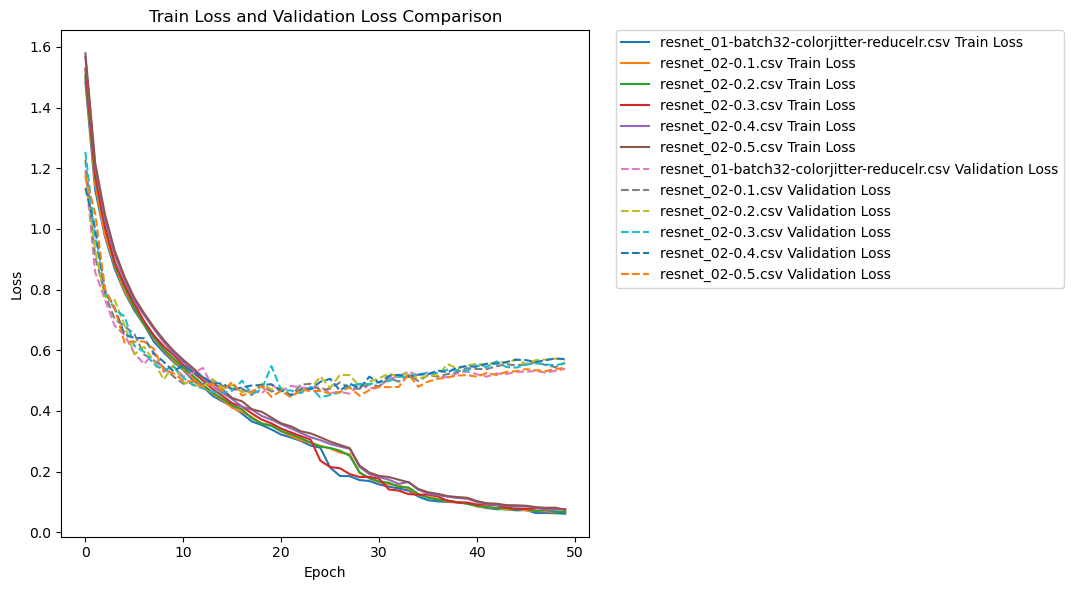

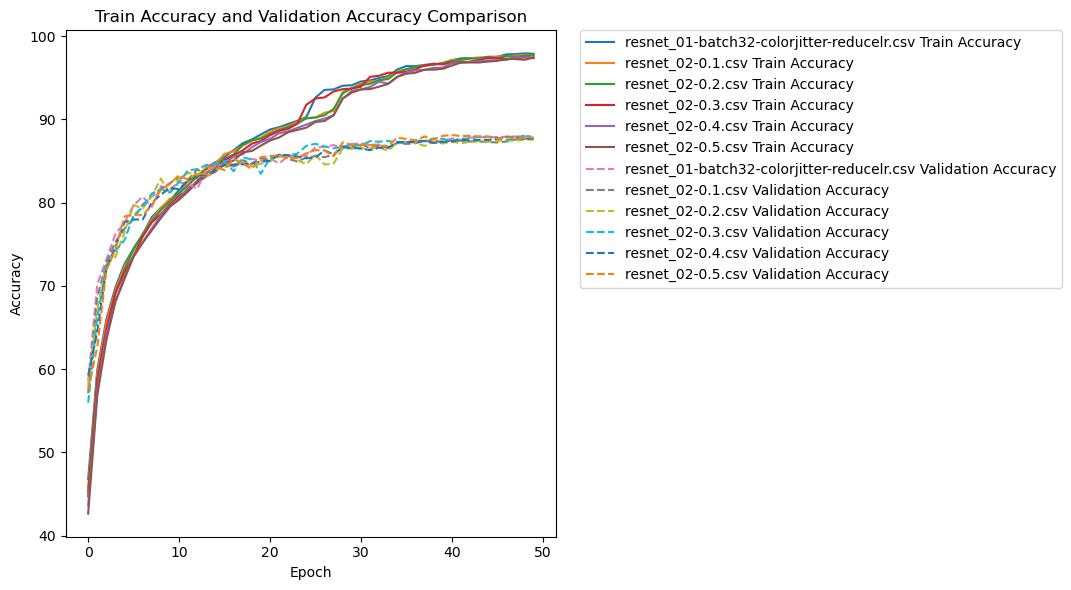

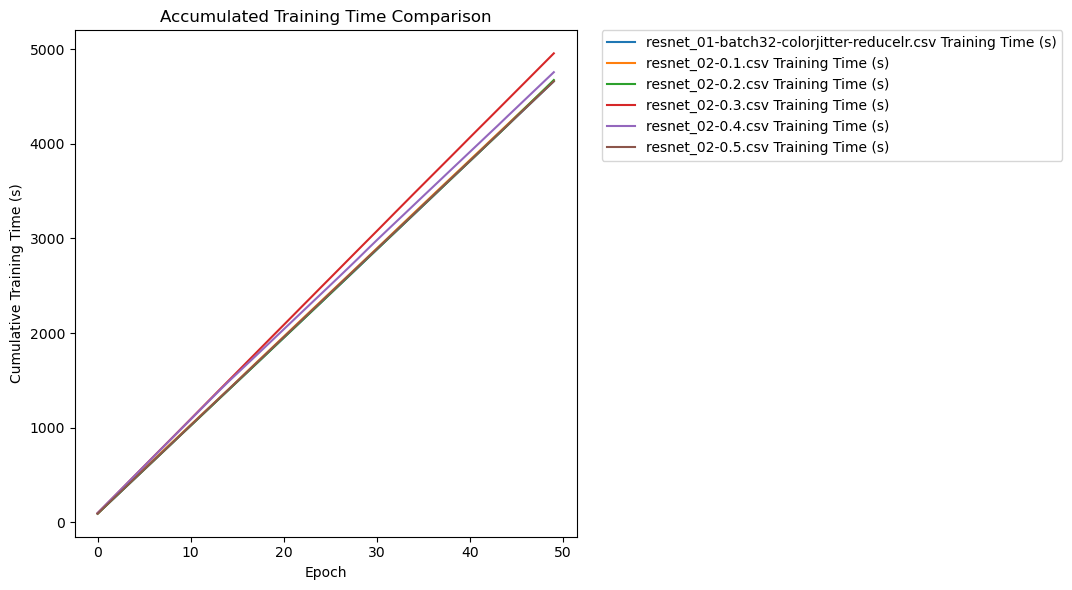

Model resnet_01-batch32-colorjitter-reducelr.csv:
  Highest Validation Accuracy: 87.98
  Epoch at Highest Validation Accuracy: 50
  Total Time to Reach Highest Validation Accuracy: 4661.24 seconds

Model resnet_02-0.1.csv:
  Highest Validation Accuracy: 87.69
  Epoch at Highest Validation Accuracy: 49
  Total Time to Reach Highest Validation Accuracy: 4576.03 seconds

Model resnet_02-0.2.csv:
  Highest Validation Accuracy: 87.60
  Epoch at Highest Validation Accuracy: 49
  Total Time to Reach Highest Validation Accuracy: 4577.51 seconds

Model resnet_02-0.3.csv:
  Highest Validation Accuracy: 88.11
  Epoch at Highest Validation Accuracy: 49
  Total Time to Reach Highest Validation Accuracy: 4857.55 seconds

Model resnet_02-0.4.csv:
  Highest Validation Accuracy: 87.91
  Epoch at Highest Validation Accuracy: 47
  Total Time to Reach Highest Validation Accuracy: 4476.60 seconds

Model resnet_02-0.5.csv:
  Highest Validation Accuracy: 88.12
  Epoch at Highest Validation Accuracy: 41
  Tot

In [47]:
file_paths = [
    'resnet_01-batch32-colorjitter-reducelr.csv', 
    "resnet_02-0.1.csv",
    "resnet_02-0.2.csv",
    "resnet_02-0.3.csv",
    "resnet_02-0.4.csv",
    "resnet_02-0.5.csv"
]

compare_multi(file_paths)

### Remove Max Pooling for the first layer
This is done to give more data to learn

In [50]:
def resnet_03(num_classes=10, dropout_rate=0.5):
    model = models.resnet18(weights=None)
    
    model.conv1 = nn.Conv2d(
        in_channels=3,       
        out_channels=64,     
        kernel_size=3,       
        stride=1,            
        padding=1,           
        bias=False
    )
    model.bn1 = nn.BatchNorm2d(64)
    model.maxpool = nn.Identity()   

    model.fc = nn.Sequential(
        nn.Dropout(dropout_rate),  
        nn.Linear(model.fc.in_features, num_classes)
    )
    
    return model
device = torch.device('cuda')
model = resnet_03().to(device)

get_model_sum(model) # We can see that we got 4,4 in Conv2d-51 which might improve the performance


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
          Identity-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [17]:
device = torch.device('cuda')

dropout_rate = 0.5
num_epochs = 50
model = resnet_03(dropout_rate=dropout_rate).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 32
trainloader, valloader = datasetsloader(batch_size)

model_name=f'resnet_03-{dropout_rate}'

train_model_reducelr(model=model, train_loader=trainloader, val_loader=valloader, criterion=criterion, optimizer=optimizer, 
                     num_epochs=num_epochs, model_name=model_name, csv_filename=f"./logs/{model_name}.csv", 
                     checkpoint_path=f"./models/{model_name}_check.pth", save_model_path=f"./models/{model_name}_best.pth", 
                     resume=False, save_best_on="accuracy", step=0.5, patience=5)

Epoch 1/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.35batch/s]


Epoch [1/50] Train Loss: 1.5911, Train Accuracy: 42.29%, Validation Loss: 1.1882, Validation Accuracy: 57.80%, Min Val Acc: 36.10%, Max Val Acc: 90.40%, Median Val Acc: 49.40%, Training Time: 76.45s, Validation Time: 6.53s, Learning Rate: 0.001000
Model saved with validation accuracy: 57.80%
Checkpoint saved at epoch 1


Epoch 2/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.32batch/s]


Epoch [2/50] Train Loss: 1.1653, Train Accuracy: 58.66%, Validation Loss: 0.8635, Validation Accuracy: 69.20%, Min Val Acc: 29.00%, Max Val Acc: 90.70%, Median Val Acc: 74.50%, Training Time: 76.59s, Validation Time: 6.19s, Learning Rate: 0.001000
Model saved with validation accuracy: 69.20%
Checkpoint saved at epoch 2


Epoch 3/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.44batch/s]


Epoch [3/50] Train Loss: 0.9720, Train Accuracy: 65.99%, Validation Loss: 0.7619, Validation Accuracy: 73.24%, Min Val Acc: 32.60%, Max Val Acc: 94.20%, Median Val Acc: 78.40%, Training Time: 76.04s, Validation Time: 6.17s, Learning Rate: 0.001000
Model saved with validation accuracy: 73.24%
Checkpoint saved at epoch 3


Epoch 4/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.38batch/s]


Epoch [4/50] Train Loss: 0.8494, Train Accuracy: 70.73%, Validation Loss: 0.6951, Validation Accuracy: 75.84%, Min Val Acc: 57.20%, Max Val Acc: 93.60%, Median Val Acc: 75.60%, Training Time: 76.31s, Validation Time: 6.58s, Learning Rate: 0.001000
Model saved with validation accuracy: 75.84%
Checkpoint saved at epoch 4


Epoch 5/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.38batch/s]


Epoch [5/50] Train Loss: 0.7606, Train Accuracy: 73.67%, Validation Loss: 0.5736, Validation Accuracy: 80.22%, Min Val Acc: 57.30%, Max Val Acc: 93.50%, Median Val Acc: 85.25%, Training Time: 76.32s, Validation Time: 6.18s, Learning Rate: 0.001000
Model saved with validation accuracy: 80.22%
Checkpoint saved at epoch 5


Epoch 6/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.34batch/s]


Epoch [6/50] Train Loss: 0.6948, Train Accuracy: 75.94%, Validation Loss: 0.5226, Validation Accuracy: 81.77%, Min Val Acc: 65.90%, Max Val Acc: 96.60%, Median Val Acc: 83.50%, Training Time: 76.49s, Validation Time: 6.16s, Learning Rate: 0.001000
Model saved with validation accuracy: 81.77%
Checkpoint saved at epoch 6


Epoch 7/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.39batch/s]


Epoch [7/50] Train Loss: 0.6395, Train Accuracy: 78.08%, Validation Loss: 0.4866, Validation Accuracy: 83.27%, Min Val Acc: 61.90%, Max Val Acc: 94.20%, Median Val Acc: 86.95%, Training Time: 76.26s, Validation Time: 6.11s, Learning Rate: 0.001000
Model saved with validation accuracy: 83.27%
Checkpoint saved at epoch 7


Epoch 8/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.38batch/s]


Epoch [8/50] Train Loss: 0.5915, Train Accuracy: 79.86%, Validation Loss: 0.5036, Validation Accuracy: 82.54%, Min Val Acc: 69.00%, Max Val Acc: 94.20%, Median Val Acc: 83.60%, Training Time: 76.31s, Validation Time: 6.23s, Learning Rate: 0.001000
Checkpoint saved at epoch 8


Epoch 9/50: 100%|███████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.40batch/s]


Epoch [9/50] Train Loss: 0.5506, Train Accuracy: 81.02%, Validation Loss: 0.4957, Validation Accuracy: 83.28%, Min Val Acc: 65.20%, Max Val Acc: 95.10%, Median Val Acc: 86.55%, Training Time: 76.20s, Validation Time: 6.38s, Learning Rate: 0.001000
Model saved with validation accuracy: 83.28%
Checkpoint saved at epoch 9


Epoch 10/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.38batch/s]


Epoch [10/50] Train Loss: 0.5180, Train Accuracy: 82.22%, Validation Loss: 0.4128, Validation Accuracy: 86.00%, Min Val Acc: 70.60%, Max Val Acc: 94.40%, Median Val Acc: 86.95%, Training Time: 76.32s, Validation Time: 6.25s, Learning Rate: 0.001000
Model saved with validation accuracy: 86.00%
Checkpoint saved at epoch 10


Epoch 11/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.32batch/s]


Epoch [11/50] Train Loss: 0.4837, Train Accuracy: 83.33%, Validation Loss: 0.3850, Validation Accuracy: 86.57%, Min Val Acc: 63.20%, Max Val Acc: 95.10%, Median Val Acc: 90.50%, Training Time: 76.60s, Validation Time: 6.15s, Learning Rate: 0.001000
Model saved with validation accuracy: 86.57%
Checkpoint saved at epoch 11


Epoch 12/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.28batch/s]


Epoch [12/50] Train Loss: 0.4548, Train Accuracy: 84.44%, Validation Loss: 0.4056, Validation Accuracy: 86.28%, Min Val Acc: 72.80%, Max Val Acc: 96.90%, Median Val Acc: 87.20%, Training Time: 76.77s, Validation Time: 6.20s, Learning Rate: 0.001000
Checkpoint saved at epoch 12


Epoch 13/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.27batch/s]


Epoch [13/50] Train Loss: 0.4227, Train Accuracy: 85.20%, Validation Loss: 0.3983, Validation Accuracy: 86.70%, Min Val Acc: 78.50%, Max Val Acc: 95.50%, Median Val Acc: 86.20%, Training Time: 76.82s, Validation Time: 6.10s, Learning Rate: 0.001000
Model saved with validation accuracy: 86.70%
Checkpoint saved at epoch 13


Epoch 14/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.39batch/s]


Epoch [14/50] Train Loss: 0.4070, Train Accuracy: 85.81%, Validation Loss: 0.3570, Validation Accuracy: 87.97%, Min Val Acc: 77.80%, Max Val Acc: 95.90%, Median Val Acc: 87.70%, Training Time: 76.25s, Validation Time: 6.07s, Learning Rate: 0.001000
Model saved with validation accuracy: 87.97%
Checkpoint saved at epoch 14


Epoch 15/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.41batch/s]


Epoch [15/50] Train Loss: 0.3795, Train Accuracy: 86.64%, Validation Loss: 0.3609, Validation Accuracy: 87.90%, Min Val Acc: 70.10%, Max Val Acc: 95.30%, Median Val Acc: 90.25%, Training Time: 76.16s, Validation Time: 6.28s, Learning Rate: 0.001000
Checkpoint saved at epoch 15


Epoch 16/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.39batch/s]


Epoch [16/50] Train Loss: 0.3545, Train Accuracy: 87.73%, Validation Loss: 0.3794, Validation Accuracy: 87.16%, Min Val Acc: 62.20%, Max Val Acc: 96.30%, Median Val Acc: 89.25%, Training Time: 76.28s, Validation Time: 6.27s, Learning Rate: 0.001000
Checkpoint saved at epoch 16


Epoch 17/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.39batch/s]


Epoch [17/50] Train Loss: 0.3382, Train Accuracy: 88.20%, Validation Loss: 0.3575, Validation Accuracy: 88.04%, Min Val Acc: 74.30%, Max Val Acc: 95.00%, Median Val Acc: 88.95%, Training Time: 76.28s, Validation Time: 6.60s, Learning Rate: 0.001000
Model saved with validation accuracy: 88.04%
Checkpoint saved at epoch 17


Epoch 18/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.37batch/s]


Epoch [18/50] Train Loss: 0.3220, Train Accuracy: 88.73%, Validation Loss: 0.3962, Validation Accuracy: 87.52%, Min Val Acc: 74.00%, Max Val Acc: 97.00%, Median Val Acc: 89.15%, Training Time: 76.34s, Validation Time: 6.19s, Learning Rate: 0.001000
Checkpoint saved at epoch 18


Epoch 19/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.33batch/s]


Epoch [19/50] Train Loss: 0.3071, Train Accuracy: 89.40%, Validation Loss: 0.3791, Validation Accuracy: 88.11%, Min Val Acc: 68.70%, Max Val Acc: 97.10%, Median Val Acc: 89.80%, Training Time: 76.56s, Validation Time: 6.26s, Learning Rate: 0.001000
Model saved with validation accuracy: 88.11%
Checkpoint saved at epoch 19


Epoch 20/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.29batch/s]


Epoch [20/50] Train Loss: 0.2875, Train Accuracy: 90.04%, Validation Loss: 0.3696, Validation Accuracy: 87.97%, Min Val Acc: 73.00%, Max Val Acc: 97.20%, Median Val Acc: 89.85%, Training Time: 76.74s, Validation Time: 6.19s, Learning Rate: 0.001000
Checkpoint saved at epoch 20


Epoch 21/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:17<00:00, 16.23batch/s]


Epoch [21/50] Train Loss: 0.2213, Train Accuracy: 92.28%, Validation Loss: 0.3098, Validation Accuracy: 90.15%, Min Val Acc: 78.70%, Max Val Acc: 95.20%, Median Val Acc: 91.50%, Training Time: 77.02s, Validation Time: 6.15s, Learning Rate: 0.000500
Model saved with validation accuracy: 90.15%
Checkpoint saved at epoch 21


Epoch 22/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.41batch/s]


Epoch [22/50] Train Loss: 0.1988, Train Accuracy: 93.16%, Validation Loss: 0.3160, Validation Accuracy: 90.17%, Min Val Acc: 79.70%, Max Val Acc: 96.40%, Median Val Acc: 91.65%, Training Time: 76.18s, Validation Time: 6.48s, Learning Rate: 0.000500
Model saved with validation accuracy: 90.17%
Checkpoint saved at epoch 22


Epoch 23/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.39batch/s]


Epoch [23/50] Train Loss: 0.1802, Train Accuracy: 93.72%, Validation Loss: 0.3216, Validation Accuracy: 90.30%, Min Val Acc: 77.30%, Max Val Acc: 97.30%, Median Val Acc: 90.75%, Training Time: 76.28s, Validation Time: 6.14s, Learning Rate: 0.000500
Model saved with validation accuracy: 90.30%
Checkpoint saved at epoch 23


Epoch 24/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.40batch/s]


Epoch [24/50] Train Loss: 0.1779, Train Accuracy: 93.81%, Validation Loss: 0.3297, Validation Accuracy: 90.22%, Min Val Acc: 77.50%, Max Val Acc: 97.20%, Median Val Acc: 91.85%, Training Time: 76.22s, Validation Time: 6.09s, Learning Rate: 0.000500
Checkpoint saved at epoch 24


Epoch 25/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.40batch/s]


Epoch [25/50] Train Loss: 0.1663, Train Accuracy: 94.26%, Validation Loss: 0.3352, Validation Accuracy: 90.00%, Min Val Acc: 79.30%, Max Val Acc: 96.70%, Median Val Acc: 91.10%, Training Time: 76.23s, Validation Time: 6.15s, Learning Rate: 0.000500
Checkpoint saved at epoch 25


Epoch 26/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.39batch/s]


Epoch [26/50] Train Loss: 0.1575, Train Accuracy: 94.48%, Validation Loss: 0.3479, Validation Accuracy: 90.29%, Min Val Acc: 81.90%, Max Val Acc: 95.90%, Median Val Acc: 91.05%, Training Time: 76.29s, Validation Time: 6.17s, Learning Rate: 0.000500
Checkpoint saved at epoch 26


Epoch 27/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.40batch/s]


Epoch [27/50] Train Loss: 0.1520, Train Accuracy: 94.80%, Validation Loss: 0.3423, Validation Accuracy: 90.17%, Min Val Acc: 81.00%, Max Val Acc: 97.00%, Median Val Acc: 91.10%, Training Time: 76.23s, Validation Time: 6.13s, Learning Rate: 0.000500
Checkpoint saved at epoch 27


Epoch 28/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.40batch/s]


Epoch [28/50] Train Loss: 0.1204, Train Accuracy: 95.90%, Validation Loss: 0.3235, Validation Accuracy: 90.94%, Min Val Acc: 81.30%, Max Val Acc: 97.00%, Median Val Acc: 90.90%, Training Time: 76.24s, Validation Time: 6.13s, Learning Rate: 0.000250
Model saved with validation accuracy: 90.94%
Checkpoint saved at epoch 28


Epoch 29/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.39batch/s]


Epoch [29/50] Train Loss: 0.1122, Train Accuracy: 96.15%, Validation Loss: 0.3307, Validation Accuracy: 90.96%, Min Val Acc: 81.60%, Max Val Acc: 96.90%, Median Val Acc: 91.90%, Training Time: 76.26s, Validation Time: 6.09s, Learning Rate: 0.000250
Model saved with validation accuracy: 90.96%
Checkpoint saved at epoch 29


Epoch 30/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.45batch/s]


Epoch [30/50] Train Loss: 0.1048, Train Accuracy: 96.36%, Validation Loss: 0.3315, Validation Accuracy: 91.28%, Min Val Acc: 81.80%, Max Val Acc: 97.10%, Median Val Acc: 92.00%, Training Time: 76.01s, Validation Time: 6.49s, Learning Rate: 0.000250
Model saved with validation accuracy: 91.28%
Checkpoint saved at epoch 30


Epoch 31/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.41batch/s]


Epoch [31/50] Train Loss: 0.1026, Train Accuracy: 96.58%, Validation Loss: 0.3331, Validation Accuracy: 90.91%, Min Val Acc: 82.10%, Max Val Acc: 95.80%, Median Val Acc: 92.60%, Training Time: 76.15s, Validation Time: 6.26s, Learning Rate: 0.000250
Checkpoint saved at epoch 31


Epoch 32/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.32batch/s]


Epoch [32/50] Train Loss: 0.0971, Train Accuracy: 96.73%, Validation Loss: 0.3300, Validation Accuracy: 91.23%, Min Val Acc: 79.80%, Max Val Acc: 97.50%, Median Val Acc: 92.55%, Training Time: 76.58s, Validation Time: 6.61s, Learning Rate: 0.000250
Checkpoint saved at epoch 32


Epoch 33/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:17<00:00, 16.23batch/s]


Epoch [33/50] Train Loss: 0.0897, Train Accuracy: 96.90%, Validation Loss: 0.3479, Validation Accuracy: 91.04%, Min Val Acc: 82.10%, Max Val Acc: 96.80%, Median Val Acc: 92.00%, Training Time: 77.02s, Validation Time: 6.44s, Learning Rate: 0.000250
Checkpoint saved at epoch 33


Epoch 34/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.43batch/s]


Epoch [34/50] Train Loss: 0.0808, Train Accuracy: 97.31%, Validation Loss: 0.3419, Validation Accuracy: 91.10%, Min Val Acc: 79.40%, Max Val Acc: 96.40%, Median Val Acc: 91.95%, Training Time: 76.10s, Validation Time: 6.17s, Learning Rate: 0.000125
Checkpoint saved at epoch 34


Epoch 35/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.40batch/s]


Epoch [35/50] Train Loss: 0.0744, Train Accuracy: 97.48%, Validation Loss: 0.3357, Validation Accuracy: 91.41%, Min Val Acc: 79.70%, Max Val Acc: 96.80%, Median Val Acc: 93.00%, Training Time: 76.20s, Validation Time: 6.39s, Learning Rate: 0.000125
Model saved with validation accuracy: 91.41%
Checkpoint saved at epoch 35


Epoch 36/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.35batch/s]


Epoch [36/50] Train Loss: 0.0717, Train Accuracy: 97.55%, Validation Loss: 0.3392, Validation Accuracy: 91.37%, Min Val Acc: 80.60%, Max Val Acc: 96.90%, Median Val Acc: 92.35%, Training Time: 76.43s, Validation Time: 6.15s, Learning Rate: 0.000125
Checkpoint saved at epoch 36


Epoch 37/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.42batch/s]


Epoch [37/50] Train Loss: 0.0696, Train Accuracy: 97.59%, Validation Loss: 0.3480, Validation Accuracy: 91.41%, Min Val Acc: 81.70%, Max Val Acc: 97.20%, Median Val Acc: 92.25%, Training Time: 76.15s, Validation Time: 6.18s, Learning Rate: 0.000125
Checkpoint saved at epoch 37


Epoch 38/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.36batch/s]


Epoch [38/50] Train Loss: 0.0680, Train Accuracy: 97.69%, Validation Loss: 0.3485, Validation Accuracy: 91.57%, Min Val Acc: 83.90%, Max Val Acc: 96.60%, Median Val Acc: 92.45%, Training Time: 76.39s, Validation Time: 6.45s, Learning Rate: 0.000125
Model saved with validation accuracy: 91.57%
Checkpoint saved at epoch 38


Epoch 39/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.37batch/s]


Epoch [39/50] Train Loss: 0.0673, Train Accuracy: 97.72%, Validation Loss: 0.3550, Validation Accuracy: 91.42%, Min Val Acc: 82.60%, Max Val Acc: 96.90%, Median Val Acc: 92.45%, Training Time: 76.36s, Validation Time: 6.16s, Learning Rate: 0.000125
Checkpoint saved at epoch 39


Epoch 40/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.38batch/s]


Epoch [40/50] Train Loss: 0.0630, Train Accuracy: 97.84%, Validation Loss: 0.3448, Validation Accuracy: 91.49%, Min Val Acc: 80.90%, Max Val Acc: 96.80%, Median Val Acc: 93.25%, Training Time: 76.32s, Validation Time: 6.19s, Learning Rate: 0.000063
Checkpoint saved at epoch 40


Epoch 41/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.41batch/s]


Epoch [41/50] Train Loss: 0.0569, Train Accuracy: 98.07%, Validation Loss: 0.3476, Validation Accuracy: 91.63%, Min Val Acc: 83.70%, Max Val Acc: 96.60%, Median Val Acc: 92.40%, Training Time: 76.18s, Validation Time: 6.14s, Learning Rate: 0.000063
Model saved with validation accuracy: 91.63%
Checkpoint saved at epoch 41


Epoch 42/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.40batch/s]


Epoch [42/50] Train Loss: 0.0584, Train Accuracy: 97.97%, Validation Loss: 0.3515, Validation Accuracy: 91.74%, Min Val Acc: 83.10%, Max Val Acc: 97.00%, Median Val Acc: 93.60%, Training Time: 76.23s, Validation Time: 6.18s, Learning Rate: 0.000063
Model saved with validation accuracy: 91.74%
Checkpoint saved at epoch 42


Epoch 43/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:17<00:00, 16.23batch/s]


Epoch [43/50] Train Loss: 0.0544, Train Accuracy: 98.15%, Validation Loss: 0.3500, Validation Accuracy: 91.54%, Min Val Acc: 82.90%, Max Val Acc: 97.00%, Median Val Acc: 92.25%, Training Time: 77.00s, Validation Time: 6.38s, Learning Rate: 0.000063
Checkpoint saved at epoch 43


Epoch 44/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.33batch/s]


Epoch [44/50] Train Loss: 0.0582, Train Accuracy: 98.06%, Validation Loss: 0.3571, Validation Accuracy: 91.64%, Min Val Acc: 81.40%, Max Val Acc: 96.30%, Median Val Acc: 93.00%, Training Time: 76.55s, Validation Time: 6.85s, Learning Rate: 0.000063
Checkpoint saved at epoch 44


Epoch 45/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.35batch/s]


Epoch [45/50] Train Loss: 0.0524, Train Accuracy: 98.26%, Validation Loss: 0.3599, Validation Accuracy: 91.52%, Min Val Acc: 80.70%, Max Val Acc: 96.70%, Median Val Acc: 92.50%, Training Time: 76.46s, Validation Time: 6.50s, Learning Rate: 0.000063
Checkpoint saved at epoch 45


Epoch 46/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.32batch/s]


Epoch [46/50] Train Loss: 0.0512, Train Accuracy: 98.30%, Validation Loss: 0.3555, Validation Accuracy: 91.81%, Min Val Acc: 81.10%, Max Val Acc: 97.10%, Median Val Acc: 92.60%, Training Time: 76.60s, Validation Time: 6.65s, Learning Rate: 0.000031
Model saved with validation accuracy: 91.81%
Checkpoint saved at epoch 46


Epoch 47/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:17<00:00, 16.22batch/s]


Epoch [47/50] Train Loss: 0.0486, Train Accuracy: 98.38%, Validation Loss: 0.3525, Validation Accuracy: 91.85%, Min Val Acc: 83.20%, Max Val Acc: 96.80%, Median Val Acc: 92.45%, Training Time: 77.04s, Validation Time: 6.21s, Learning Rate: 0.000031
Model saved with validation accuracy: 91.85%
Checkpoint saved at epoch 47


Epoch 48/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.24batch/s]


Epoch [48/50] Train Loss: 0.0505, Train Accuracy: 98.35%, Validation Loss: 0.3496, Validation Accuracy: 91.90%, Min Val Acc: 84.30%, Max Val Acc: 97.10%, Median Val Acc: 92.70%, Training Time: 76.98s, Validation Time: 6.67s, Learning Rate: 0.000031
Model saved with validation accuracy: 91.90%
Checkpoint saved at epoch 48


Epoch 49/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.32batch/s]


Epoch [49/50] Train Loss: 0.0500, Train Accuracy: 98.28%, Validation Loss: 0.3501, Validation Accuracy: 91.90%, Min Val Acc: 83.90%, Max Val Acc: 96.90%, Median Val Acc: 92.90%, Training Time: 76.61s, Validation Time: 6.21s, Learning Rate: 0.000031
Checkpoint saved at epoch 49


Epoch 50/50: 100%|██████████████████████████████████████████████████████████████| 1250/1250 [01:16<00:00, 16.43batch/s]


Epoch [50/50] Train Loss: 0.0467, Train Accuracy: 98.44%, Validation Loss: 0.3581, Validation Accuracy: 91.62%, Min Val Acc: 82.20%, Max Val Acc: 96.90%, Median Val Acc: 93.00%, Training Time: 76.09s, Validation Time: 6.24s, Learning Rate: 0.000031
Checkpoint saved at epoch 50


In [18]:
# Define the model and move to the appropriate device
model = resnet_03(num_classes=10)  # Replace with your specific model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the criterion (loss function) used during training
criterion = nn.CrossEntropyLoss()

test_dataset = datasets.CIFAR10(root='./data', train=False, transform=val_transform) #recall to use the latest transformation
test_loader = testsetloader(batch_size=32)

# Evaluate the model on the test set
evaluation_metrics = evaluate_model_on_test(
    model=model,
    test_loader=test_loader,  # Now using the test_loader instead of val_loader
    criterion=criterion,
    num_classes=10,  # Number of classes in your dataset
    model_path=f'./models/resnet_03-0.5_best.pth',  # Path to your saved model
    device=device
)

# Print evaluation results
print("\nEvaluation Metrics:")
for key, value in evaluation_metrics.items():
    print(f"{key}: {value}")


D:\Users\a1901443\AppData\Local\Temp\3\ipykernel_17096\1791267582.py:543: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_loca

Test Loss: 0.3538
Overall Test Accuracy: 90.98%
Per-Class Accuracy:
  Airplane: 91.70%
  Automobile: 96.20%
  Bird: 88.50%
  Cat: 82.10%
  Deer: 91.70%
  Dog: 84.80%
  Frog: 93.10%
  Horse: 92.30%
  Ship: 95.40%
  Truck: 94.00%
Min Class Accuracy: 82.10%
Max Class Accuracy: 96.20%
Median Class Accuracy: 92.00%
Evaluation Time: 6.48 seconds

Evaluation Metrics:
Test Loss: 0.3538094215603105
Overall Test Accuracy: 90.98
Per-Class Accuracy: {'Airplane': 91.7, 'Automobile': 96.2, 'Bird': 88.5, 'Cat': 82.1, 'Deer': 91.7, 'Dog': 84.8, 'Frog': 93.1, 'Horse': 92.3, 'Ship': 95.4, 'Truck': 94.0}
Min Class Accuracy: 82.1
Max Class Accuracy: 96.2
Median Class Accuracy: 92.0
Evaluation Time: 6.477425813674927
